<p><img alt="FruitSalad logo" height="auto" width="45" src="https://github.com/ctinnil/FruitSalad/blob/main/res/favicon.png?raw=true" align="left" hspace="10px" vspace="0px"></p>
<h1>Defining the framework model</h1>

## Dataset benchmarking 

First, we need to benchmark the resulting dataset. This operation can be done using some simple Python implementation of basic ML algorithms as in the [Develop a training dataset for FruitSalad notebook](https://github.com/ctinnil/FruitSalad/blob/main/Develop%20a%20training%20dataset%20for%20FruitSalad.ipynb). Alternatively, we can use pre implemented models available in the [Weka framework](https://www.cs.waikato.ac.nz/ml/weka/). Below you will find the results for the resulting set.

||OneR|PART|Logistic Regression|SVM|Naive Bayes|Bayes Net|Decision Table|Random Forest|Random Tree|REPTree|J48|Multilayer Perrceptron|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|**10 folds cross-validation**|88.00|99.55|99.55|99.27|82.18|89.36|98.18|99.91|99.09|99.18|99.73|99.64|
|**82% training-testing split**|90.91|98.48|99.49|98.48|85.35|92.42|96.97|100|98.99|96.97|97.98|98.98|

We suspect that some of the algorithms, like Random Forest, overfit the resulting dataset. We address this issue by employing feature selection and an ensemble model for our final cut framework.

In [1]:
# Install dependencies

!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11686 sha256=7d0d5b23f7c98fceeb50c2b69cf13a66b57c0a3ef8c47c6de58d3f1336e54d96
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [2]:
# Import dependencies

import itertools
import pandas as pd
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

In [3]:
# Mount Google Drive to import dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load raw dataset




In [4]:
attacks = pd.read_csv('./drive/MyDrive/Datasets/preprocessed.csv')

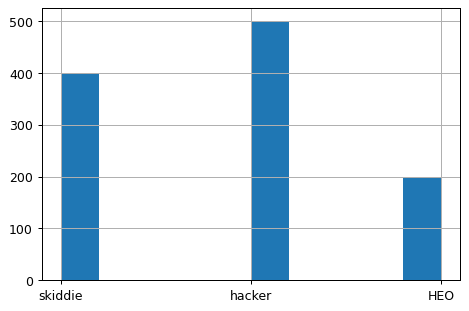

In [5]:
fig = plt.figure(dpi=90)
attacks["label"].hist()

In [6]:
test = attacks.copy()

In [7]:
mapping = {'skiddie':0, 'HEO': 2, 'hacker':1}
test['label'] = test['label'].replace(mapping)

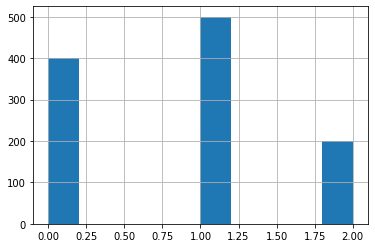

In [8]:
test["label"].hist()

In [99]:
cols =['Rate', 'len',
       'subtype', 'ID', 'SC', 'ChannelFrequency', 'dBm_AntSignal', 'reason',
        'same_time', 'same_AP_addr', 'same_client_addr', 'same_BSSID',
       'Client_BCAST', 'in_scope_AP', 'TXFlags_NOACK', 'TXFlags_NOSEQ',
       'TXFlags_TX_FAIL', 'FCfield_RETRY', 'FCS', 'ChannelFlags_2GHZ',
       'entropy_of_notdecoded', 'TSFT', 'CHANNEL', 'RXFLAGS', 'RADIOTAPNS',
       'EXT']

Rate
len
subtype
ID
SC
ChannelFrequency
dBm_AntSignal
reason
same_time
same_AP_addr
same_client_addr
same_BSSID
Client_BCAST
in_scope_AP
TXFlags_NOACK
TXFlags_NOSEQ
TXFlags_TX_FAIL
FCfield_RETRY
FCS
ChannelFlags_2GHZ
entropy_of_notdecoded
TSFT
CHANNEL
RXFLAGS


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


RADIOTAPNS
EXT


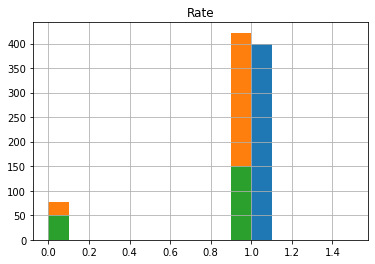

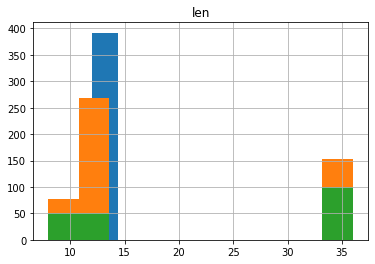

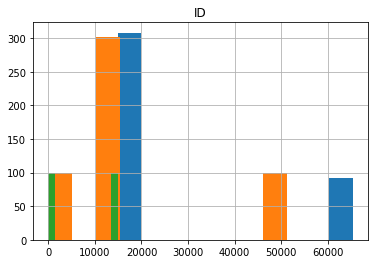

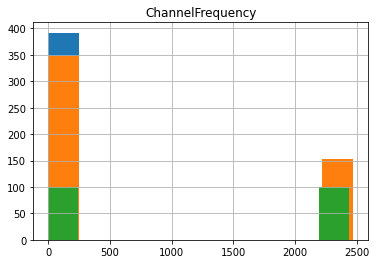

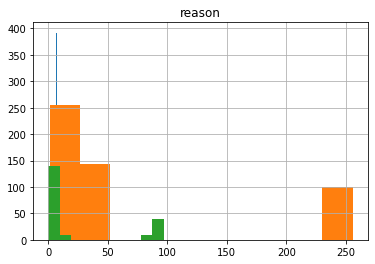

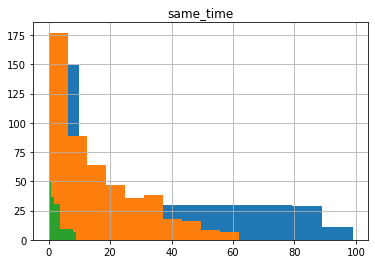

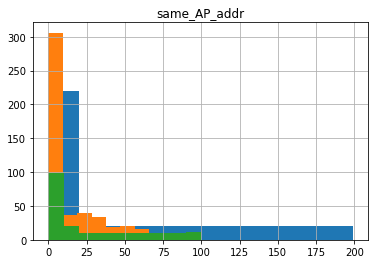

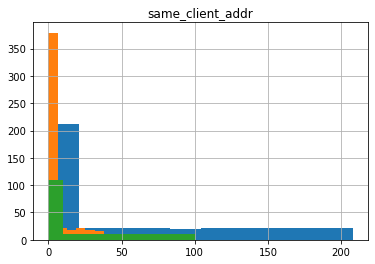

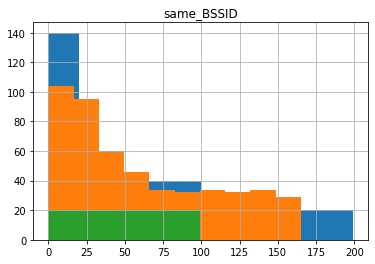

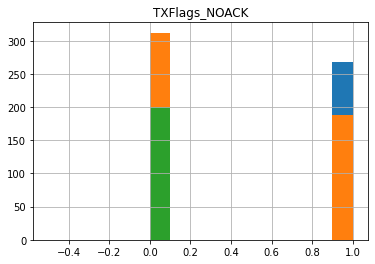

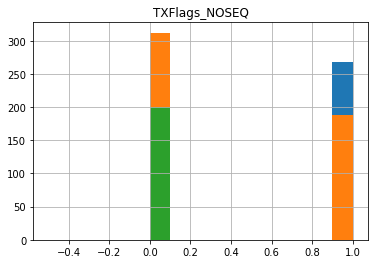

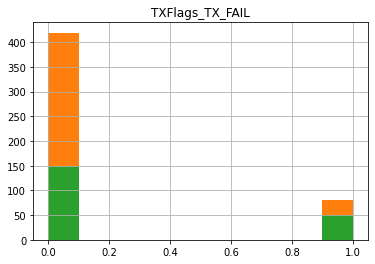

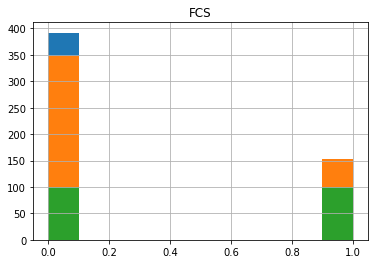

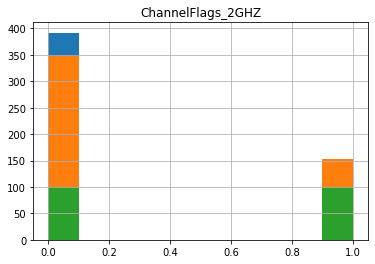

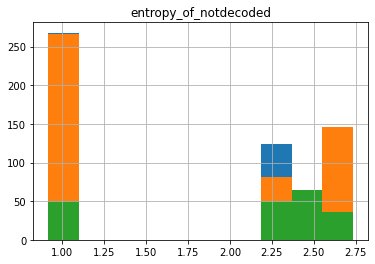

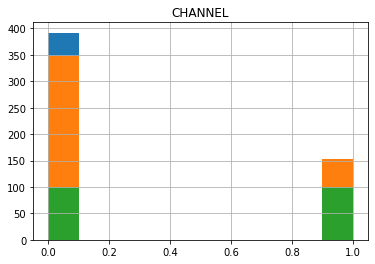

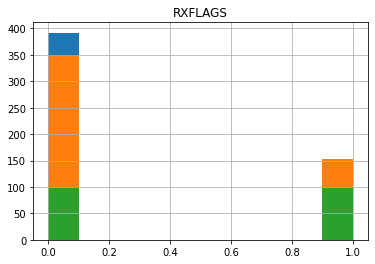

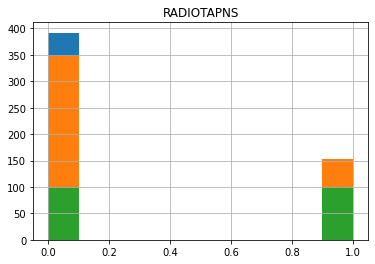

In [11]:
test_ = test[cols]

info_ = test_.columns

#info_ = ["day_number"]
for i in range(0,len(info_)):
  x = info_[i]
  fig = plt.figure()
  plt.title(x)
  print(info_[i])
  strategy = "label == 0"
  test.query(strategy)[x].hist()
  strategy = "label == 1"
  test.query(strategy)[x].hist()
  strategy = "label == 2"
  test.query(strategy)[x].hist()

In [ ]:
def trainXGB(train_data,Y_train,test_data,Y_test,gamma=0.05692,learing_rate=0.8126,max_depth=9,n_estimators=466,default=False):
  # fit model to training data
  if default == False:
    xgb_model = XGBClassifier(gamma=gamma,learing_rate=learning_rate,max_depth=max_depth,n_estimators=n_estimators)
  else:
    xgb_model = XGBClassifier()

  %time xgb_model.fit(train_data, Y_train,verbose=False)

  return xgb_model

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        gamma,reg_lambda):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,reg_lambda=reg_lambda)
  
    #print("new clf")
    #print(np.mean(cross_val_score(clf, train_data, Y_train, cv=3, scoring='roc_auc')))
    metrics = cross_val_score(clf, train_data, Y_train, cv=3)
    model = clf.fit(train_data,Y_train)
    #out = scoring(model,train_data,Y_train)
    #return out
    print(metrics)
    out = np.mean(metrics)
    if out < 0.6:
      return 0
    return out 
pbounds = {
    'learning_rate': (0.01,0.1),
    'n_estimators': (100, 1000),
    'max_depth': (3,10),
    'gamma': (0, 5),
    'reg_lambda':(0,1)}

def hyperParamsTunning():

  optimizer = BayesianOptimization(
      f=xgboost_hyper_param,
      pbounds=pbounds,
      random_state=0,
  )
  optimizer.maximize(
    init_points=2,
    n_iter=1000,
)

## FindBestModel

In [ ]:
#xgb_model = XGBClassifier(gamma=gamma,learing_rate=learning_rate,max_depth=max_depth,n_estimators=n_estimators)

xgb_model = XGBClassifier()

train_data = test[cols]
Y_train = test["label"]
%time xgb_model.fit(train_data, Y_train,verbose=False)
features_importance = xgb_model.feature_importances_
plot_importance(xgb_model)

kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(xgb_model,train_data,Y_train, cv=kfold)

print("cv results = ",results)
print("cv results = ",results.mean())



y_hat = xgb_model.predict(train_data)
out = classification_report(Y_train.to_numpy(), y_hat, output_dict=True)
print(classification_report(Y_train.to_numpy(), y_hat))

CPU times: user 258 ms, sys: 15.7 ms, total: 274 ms
Wall time: 404 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  [0.41818182 1.         0.83636364 0.18181818 0.99090909 0.82727273
 0.83636364 0.99090909 0.37272727 0.09090909]
cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100



In [ ]:
features = cols
k  = 2
pos = 0 

accuracy_hist = []
features_history = []
model_history = []

for subset in itertools.combinations(cols, k):
    features = np.array(subset)

    print("######################## ",pos)
    pos +=1
    xgb_model = XGBClassifier()

    train_data = test[features]
    Y_train = test["label"]
    %time xgb_model.fit(train_data, Y_train,verbose=False)

    features_importance = xgb_model.feature_importances_

    kfold = KFold(n_splits=10, random_state=7)
    results = cross_val_score(xgb_model,train_data,Y_train, cv=kfold)
    
    acc = results.mean()
    accuracy_hist.append(acc)
    features_history.append(features)
    model_history.append(xgb_model)
    print("cv results = ",results.mean())
    #plot_importance(xgb_model)

    
    y_hat = xgb_model.predict(train_data)

    print(classification_report(Y_train.to_numpy(), y_hat))


positions = np.argsort(accuracy_hist)
accuracy_hist = np.array(accuracy_hist)[positions]
features_history = np.array(features_history)[positions]
model_history = np.array(model_history)[positions]

########################  0
CPU times: user 68.3 ms, sys: 2.89 ms, total: 71.2 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  1
CPU times: user 59.8 ms, sys: 0 ns, total: 59.8 ms
Wall time: 59.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.1518181818181818
              precision    recall  f1-score   support

           0       0.44      0.98      0.61       400
           1       0.69      0.30      0.42       500
           2       0.00      0.00      0.00       200

    accuracy                           0.49      1100
   macro avg       0.38      0.43      0.34      1100
weighted avg       0.48      0.49      0.41      1100

########################  2
CPU times: user 62.8 ms, sys: 0 ns, total: 62.8 ms
Wall time: 62.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23818181818181813
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       400
           1       0.78      0.36      0.49       500
           2       0.70      0.25      0.37       200

    accuracy                           0.57      1100
   macro avg       0.66      0.54      0.51      1100
weighted avg       0.66      0.57      0.53      1100

########################  3
CPU times: user 71.6 ms, sys: 955 µs, total: 72.6 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       0.86      0.62      0.72       500
           2       0.81      0.69      0.74       200

    accuracy                           0.76      1100
   macro avg       0.79      0.76      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  4
CPU times: user 71.8 ms, sys: 0 ns, total: 71.8 ms
Wall time: 70.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  5
CPU times: user 67.6 ms, sys: 0 ns, total: 67.6 ms
Wall time: 67.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  6
CPU times: user 68 ms, sys: 1.96 ms, total: 70 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8236363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  7
CPU times: user 71.5 ms, sys: 2.94 ms, total: 74.4 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       400
           1       0.64      0.80      0.71       500
           2       0.63      0.41      0.49       200

    accuracy                           0.64      1100
   macro avg       0.64      0.59      0.60      1100
weighted avg       0.64      0.64      0.63      1100

########################  8
CPU times: user 72.2 ms, sys: 2.94 ms, total: 75.1 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3190909090909091
              precision    recall  f1-score   support

           0       0.66      0.47      0.55       400
           1       0.60      0.88      0.71       500
           2       0.47      0.18      0.26       200

    accuracy                           0.60      1100
   macro avg       0.58      0.51      0.51      1100
weighted avg       0.60      0.60      0.57      1100

########################  9
CPU times: user 67.6 ms, sys: 1.95 ms, total: 69.6 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.32636363636363636
              precision    recall  f1-score   support

           0       0.87      0.36      0.51       400
           1       0.60      0.94      0.73       500
           2       0.65      0.51      0.57       200

    accuracy                           0.65      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.71      0.65      0.63      1100

########################  10
CPU times: user 68 ms, sys: 5.03 ms, total: 73.1 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.27636363636363637
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       400
           1       0.59      0.79      0.67       500
           2       0.95      0.18      0.30       200

    accuracy                           0.59      1100
   macro avg       0.70      0.51      0.51      1100
weighted avg       0.64      0.59      0.56      1100

########################  11
CPU times: user 61 ms, sys: 4.01 ms, total: 65 ms
Wall time: 64.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6436363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  12
CPU times: user 62.5 ms, sys: 1.04 ms, total: 63.5 ms
Wall time: 64.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6045454545454546
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       400
           1       0.58      0.85      0.69       500
           2       1.00      0.25      0.40       200

    accuracy                           0.60      1100
   macro avg       0.73      0.53      0.54      1100
weighted avg       0.66      0.60      0.58      1100

########################  13
CPU times: user 61.9 ms, sys: 2.03 ms, total: 63.9 ms
Wall time: 63.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40181818181818185
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  14
CPU times: user 62.7 ms, sys: 2.98 ms, total: 65.7 ms
Wall time: 65.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40181818181818185
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  15
CPU times: user 58.6 ms, sys: 3.03 ms, total: 61.7 ms
Wall time: 61.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16
              precision    recall  f1-score   support

           0       0.47      0.97      0.63       400
           1       0.59      0.32      0.41       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.35      1100
weighted avg       0.44      0.50      0.42      1100

########################  16
CPU times: user 63.5 ms, sys: 2.98 ms, total: 66.5 ms
Wall time: 67.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.08636363636363636
              precision    recall  f1-score   support

           0       0.50      0.98      0.66       400
           1       0.56      0.34      0.43       500
           2       0.00      0.00      0.00       200

    accuracy                           0.51      1100
   macro avg       0.35      0.44      0.36      1100
weighted avg       0.43      0.51      0.43      1100

########################  17
CPU times: user 65.6 ms, sys: 994 µs, total: 66.6 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  18
CPU times: user 65 ms, sys: 0 ns, total: 65 ms
Wall time: 64.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  19
CPU times: user 67.4 ms, sys: 3.02 ms, total: 70.4 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  20
CPU times: user 60.1 ms, sys: 2 ms, total: 62.1 ms
Wall time: 61.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  21
CPU times: user 58.7 ms, sys: 2.02 ms, total: 60.7 ms
Wall time: 60.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  22
CPU times: user 58.8 ms, sys: 3.04 ms, total: 61.9 ms
Wall time: 61.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  23
CPU times: user 60.9 ms, sys: 0 ns, total: 60.9 ms
Wall time: 60.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  24
CPU times: user 62.3 ms, sys: 991 µs, total: 63.3 ms
Wall time: 63.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  25
CPU times: user 66.4 ms, sys: 3.02 ms, total: 69.4 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  26
CPU times: user 62.4 ms, sys: 3.02 ms, total: 65.4 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  27
CPU times: user 72.1 ms, sys: 1.95 ms, total: 74.1 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  28
CPU times: user 69.7 ms, sys: 0 ns, total: 69.7 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  29
CPU times: user 68.4 ms, sys: 2.01 ms, total: 70.4 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  30
CPU times: user 71 ms, sys: 5.03 ms, total: 76 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  31
CPU times: user 76.9 ms, sys: 3.03 ms, total: 79.9 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  32
CPU times: user 76.7 ms, sys: 0 ns, total: 76.7 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  33
CPU times: user 75.4 ms, sys: 2.04 ms, total: 77.4 ms
Wall time: 76.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  34
CPU times: user 75.7 ms, sys: 1.01 ms, total: 76.7 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  35
CPU times: user 73.5 ms, sys: 2.01 ms, total: 75.5 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  36
CPU times: user 72.3 ms, sys: 11 µs, total: 72.3 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  37
CPU times: user 64.3 ms, sys: 994 µs, total: 65.2 ms
Wall time: 64.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  38
CPU times: user 64.5 ms, sys: 0 ns, total: 64.5 ms
Wall time: 64.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  39
CPU times: user 64.4 ms, sys: 1.97 ms, total: 66.4 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  40
CPU times: user 62.5 ms, sys: 5.04 ms, total: 67.5 ms
Wall time: 67.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  41
CPU times: user 64.2 ms, sys: 3.02 ms, total: 67.3 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  42
CPU times: user 62.4 ms, sys: 2.98 ms, total: 65.3 ms
Wall time: 65.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  43
CPU times: user 68.4 ms, sys: 1e+03 µs, total: 69.4 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  44
CPU times: user 61.2 ms, sys: 3.02 ms, total: 64.3 ms
Wall time: 63.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  45
CPU times: user 62.9 ms, sys: 3 ms, total: 65.9 ms
Wall time: 65.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  46
CPU times: user 65.6 ms, sys: 2.02 ms, total: 67.6 ms
Wall time: 67.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  47
CPU times: user 60.8 ms, sys: 3 ms, total: 63.8 ms
Wall time: 63.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  48
CPU times: user 60.6 ms, sys: 2.99 ms, total: 63.6 ms
Wall time: 63.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  49
CPU times: user 63.4 ms, sys: 3.96 ms, total: 67.3 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3309090909090909
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.91      0.34      0.50       500
           2       0.50      0.50      0.50       200

    accuracy                           0.60      1100
   macro avg       0.65      0.61      0.57      1100
weighted avg       0.71      0.60      0.57      1100

########################  50
CPU times: user 71 ms, sys: 1.99 ms, total: 73 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45545454545454545
              precision    recall  f1-score   support

           0       0.72      0.97      0.83       400
           1       0.76      0.69      0.73       500
           2       0.88      0.49      0.63       200

    accuracy                           0.76      1100
   macro avg       0.79      0.72      0.73      1100
weighted avg       0.77      0.76      0.75      1100

########################  51
CPU times: user 62.2 ms, sys: 0 ns, total: 62.2 ms
Wall time: 61.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  52
CPU times: user 69.1 ms, sys: 1.03 ms, total: 70.1 ms
Wall time: 69.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  53
CPU times: user 64.4 ms, sys: 2.99 ms, total: 67.4 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8236363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  54
CPU times: user 73.9 ms, sys: 4.01 ms, total: 77.9 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4572727272727272
              precision    recall  f1-score   support

           0       0.68      0.47      0.56       400
           1       0.66      0.79      0.72       500
           2       0.49      0.54      0.51       200

    accuracy                           0.63      1100
   macro avg       0.61      0.60      0.60      1100
weighted avg       0.64      0.63      0.62      1100

########################  55
CPU times: user 70.8 ms, sys: 979 µs, total: 71.7 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39818181818181814
              precision    recall  f1-score   support

           0       0.72      0.35      0.48       400
           1       0.57      0.90      0.69       500
           2       0.43      0.24      0.31       200

    accuracy                           0.58      1100
   macro avg       0.57      0.50      0.49      1100
weighted avg       0.60      0.58      0.54      1100

########################  56
CPU times: user 72.7 ms, sys: 977 µs, total: 73.7 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.80      0.36      0.50       400
           1       0.59      0.93      0.72       500
           2       0.53      0.34      0.42       200

    accuracy                           0.62      1100
   macro avg       0.64      0.54      0.54      1100
weighted avg       0.65      0.62      0.58      1100

########################  57
CPU times: user 71.2 ms, sys: 2 ms, total: 73.2 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19818181818181815
              precision    recall  f1-score   support

           0       0.66      0.37      0.47       400
           1       0.51      0.89      0.65       500
           2       1.00      0.01      0.03       200

    accuracy                           0.54      1100
   macro avg       0.72      0.42      0.38      1100
weighted avg       0.65      0.54      0.47      1100

########################  58
CPU times: user 59.4 ms, sys: 0 ns, total: 59.4 ms
Wall time: 59.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6918181818181818
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  59
CPU times: user 58 ms, sys: 3.01 ms, total: 61 ms
Wall time: 60.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.52      0.48      0.50       400
           1       0.58      0.85      0.69       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.37      0.44      0.40      1100
weighted avg       0.45      0.56      0.49      1100

########################  60
CPU times: user 62.9 ms, sys: 13 µs, total: 62.9 ms
Wall time: 62.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46545454545454545
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.52      0.71      0.60       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.39      0.46      0.42      1100
weighted avg       0.47      0.57      0.51      1100

########################  61
CPU times: user 60.9 ms, sys: 1.97 ms, total: 62.9 ms
Wall time: 62.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46545454545454545
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.52      0.71      0.60       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.39      0.46      0.42      1100
weighted avg       0.47      0.57      0.51      1100

########################  62
CPU times: user 62.3 ms, sys: 2.01 ms, total: 64.3 ms
Wall time: 64.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.10181818181818181
              precision    recall  f1-score   support

           0       0.42      0.95      0.59       400
           1       0.61      0.25      0.35       500
           2       0.00      0.00      0.00       200

    accuracy                           0.46      1100
   macro avg       0.35      0.40      0.31      1100
weighted avg       0.43      0.46      0.37      1100

########################  63
CPU times: user 61.9 ms, sys: 987 µs, total: 62.9 ms
Wall time: 62.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.1290909090909091
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.65      0.33      0.44       500
           2       0.00      0.00      0.00       200

    accuracy                           0.51      1100
   macro avg       0.37      0.44      0.36      1100
weighted avg       0.47      0.51      0.43      1100

########################  64
CPU times: user 59.7 ms, sys: 2.03 ms, total: 61.7 ms
Wall time: 61.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  65
CPU times: user 61.1 ms, sys: 0 ns, total: 61.1 ms
Wall time: 60.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  66
CPU times: user 69.9 ms, sys: 0 ns, total: 69.9 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  67
CPU times: user 58.4 ms, sys: 3.02 ms, total: 61.4 ms
Wall time: 60.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  68
CPU times: user 62 ms, sys: 20 µs, total: 62 ms
Wall time: 61.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  69
CPU times: user 64.6 ms, sys: 979 µs, total: 65.6 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  70
CPU times: user 62.3 ms, sys: 0 ns, total: 62.3 ms
Wall time: 61.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  71
CPU times: user 58.8 ms, sys: 985 µs, total: 59.8 ms
Wall time: 59.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  72
CPU times: user 75.5 ms, sys: 0 ns, total: 75.5 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.73      0.75       500
           2       0.88      0.48      0.63       200

    accuracy                           0.78      1100
   macro avg       0.80      0.73      0.74      1100
weighted avg       0.79      0.78      0.77      1100

########################  73
CPU times: user 65.4 ms, sys: 1.01 ms, total: 66.4 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  74
CPU times: user 64.5 ms, sys: 4 ms, total: 68.5 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  75
CPU times: user 69.4 ms, sys: 975 µs, total: 70.3 ms
Wall time: 68.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6990909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  76
CPU times: user 67.7 ms, sys: 2.02 ms, total: 69.7 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5145454545454545
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.67      0.84      0.74       500
           2       0.68      0.60      0.64       200

    accuracy                           0.73      1100
   macro avg       0.75      0.70      0.72      1100
weighted avg       0.75      0.73      0.73      1100

########################  77
CPU times: user 71.3 ms, sys: 1 ms, total: 72.3 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       400
           1       0.64      0.90      0.75       500
           2       0.61      0.33      0.42       200

    accuracy                           0.72      1100
   macro avg       0.73      0.64      0.65      1100
weighted avg       0.74      0.72      0.70      1100

########################  78
CPU times: user 76 ms, sys: 2 ms, total: 78 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5309090909090909
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       400
           1       0.75      0.89      0.81       500
           2       0.80      0.79      0.79       200

    accuracy                           0.80      1100
   macro avg       0.82      0.79      0.80      1100
weighted avg       0.82      0.80      0.80      1100

########################  79
CPU times: user 68.8 ms, sys: 3.98 ms, total: 72.8 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.27636363636363637
              precision    recall  f1-score   support

           0       0.60      0.79      0.68       400
           1       0.72      0.63      0.67       500
           2       0.75      0.50      0.60       200

    accuracy                           0.66      1100
   macro avg       0.69      0.64      0.65      1100
weighted avg       0.68      0.66      0.66      1100

########################  80
CPU times: user 63.5 ms, sys: 1.99 ms, total: 65.5 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.66      0.79      0.72       500
           2       0.50      0.50      0.50       200

    accuracy                           0.72      1100
   macro avg       0.72      0.67      0.69      1100
weighted avg       0.75      0.72      0.72      1100

########################  81
CPU times: user 64.7 ms, sys: 1.96 ms, total: 66.6 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42363636363636364
              precision    recall  f1-score   support

           0       0.82      0.48      0.61       400
           1       0.60      0.92      0.72       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.81      0.63      0.67      1100
weighted avg       0.75      0.68      0.67      1100

########################  82
CPU times: user 67 ms, sys: 961 µs, total: 68 ms
Wall time: 67.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21090909090909088
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       400
           1       0.50      0.43      0.46       500
           2       0.50      0.50      0.50       200

    accuracy                           0.55      1100
   macro avg       0.54      0.55      0.54      1100
weighted avg       0.54      0.55      0.54      1100

########################  83
CPU times: user 63 ms, sys: 3.99 ms, total: 67 ms
Wall time: 66.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21090909090909088
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       400
           1       0.50      0.43      0.46       500
           2       0.50      0.50      0.50       200

    accuracy                           0.55      1100
   macro avg       0.54      0.55      0.54      1100
weighted avg       0.54      0.55      0.54      1100

########################  84
CPU times: user 63.4 ms, sys: 5.03 ms, total: 68.4 ms
Wall time: 68.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35090909090909095
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       400
           1       0.82      0.48      0.60       500
           2       0.70      0.25      0.37       200

    accuracy                           0.62      1100
   macro avg       0.69      0.57      0.56      1100
weighted avg       0.69      0.62      0.59      1100

########################  85
CPU times: user 64.5 ms, sys: 2.02 ms, total: 66.5 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26636363636363636
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       400
           1       1.00      0.20      0.33       500
           2       0.56      0.90      0.69       200

    accuracy                           0.61      1100
   macro avg       0.71      0.69      0.58      1100
weighted avg       0.77      0.61      0.54      1100

########################  86
CPU times: user 75.5 ms, sys: 976 µs, total: 76.5 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  87
CPU times: user 65.5 ms, sys: 2.99 ms, total: 68.5 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  88
CPU times: user 68.1 ms, sys: 2.01 ms, total: 70.1 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  89
CPU times: user 61.2 ms, sys: 1.97 ms, total: 63.2 ms
Wall time: 62.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  90
CPU times: user 62.6 ms, sys: 1.99 ms, total: 64.6 ms
Wall time: 64.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  91
CPU times: user 66.5 ms, sys: 4.94 ms, total: 71.4 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  92
CPU times: user 63.9 ms, sys: 3.95 ms, total: 67.9 ms
Wall time: 67.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  93
CPU times: user 72.3 ms, sys: 3 µs, total: 72.3 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  94
CPU times: user 74.3 ms, sys: 1 ms, total: 75.3 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  95
CPU times: user 75.1 ms, sys: 0 ns, total: 75.1 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  96
CPU times: user 74.2 ms, sys: 998 µs, total: 75.2 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6518181818181817
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  97
CPU times: user 77.4 ms, sys: 1.96 ms, total: 79.4 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       400
           1       0.93      0.76      0.84       500
           2       0.79      0.98      0.88       200

    accuracy                           0.86      1100
   macro avg       0.85      0.89      0.86      1100
weighted avg       0.87      0.86      0.86      1100

########################  98
CPU times: user 86.7 ms, sys: 3.02 ms, total: 89.7 ms
Wall time: 89.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3009090909090909
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       400
           1       0.75      0.94      0.83       500
           2       0.94      0.51      0.66       200

    accuracy                           0.83      1100
   macro avg       0.87      0.77      0.79      1100
weighted avg       0.85      0.83      0.82      1100

########################  99
CPU times: user 79.9 ms, sys: 14 µs, total: 79.9 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.509090909090909
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       400
           1       0.90      0.88      0.89       500
           2       0.95      0.94      0.95       200

    accuracy                           0.90      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  100
CPU times: user 82.3 ms, sys: 1 ms, total: 83.3 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.29454545454545455
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       400
           1       0.96      0.71      0.82       500
           2       0.82      0.99      0.90       200

    accuracy                           0.85      1100
   macro avg       0.86      0.89      0.86      1100
weighted avg       0.87      0.85      0.85      1100

########################  101
CPU times: user 71.9 ms, sys: 1.02 ms, total: 72.9 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4536363636363637
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       400
           1       0.72      0.99      0.83       500
           2       0.93      0.48      0.64       200

    accuracy                           0.82      1100
   macro avg       0.88      0.75      0.78      1100
weighted avg       0.86      0.82      0.81      1100

########################  102
CPU times: user 70.7 ms, sys: 4.92 ms, total: 75.6 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46090909090909093
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       400
           1       0.94      0.71      0.81       500
           2       0.94      0.99      0.96       200

    accuracy                           0.84      1100
   macro avg       0.87      0.88      0.86      1100
weighted avg       0.86      0.84      0.84      1100

########################  103
CPU times: user 70.4 ms, sys: 2.99 ms, total: 73.4 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4427272727272727
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       400
           1       0.94      0.53      0.68       500
           2       0.65      0.99      0.79       200

    accuracy                           0.77      1100
   macro avg       0.78      0.82      0.76      1100
weighted avg       0.81      0.77      0.75      1100

########################  104
CPU times: user 76.3 ms, sys: 1 ms, total: 77.3 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4427272727272727
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       400
           1       0.94      0.53      0.68       500
           2       0.65      0.99      0.79       200

    accuracy                           0.77      1100
   macro avg       0.78      0.82      0.76      1100
weighted avg       0.81      0.77      0.75      1100

########################  105
CPU times: user 74.5 ms, sys: 33 µs, total: 74.6 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4563636363636364
              precision    recall  f1-score   support

           0       0.72      0.96      0.82       400
           1       0.84      0.65      0.73       500
           2       0.81      0.73      0.77       200

    accuracy                           0.78      1100
   macro avg       0.79      0.78      0.77      1100
weighted avg       0.79      0.78      0.77      1100

########################  106
CPU times: user 69.5 ms, sys: 1.99 ms, total: 71.5 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43454545454545457
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       400
           1       0.75      0.67      0.71       500
           2       0.98      0.46      0.63       200

    accuracy                           0.74      1100
   macro avg       0.81      0.70      0.72      1100
weighted avg       0.77      0.74      0.73      1100

########################  107
CPU times: user 77.7 ms, sys: 0 ns, total: 77.7 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  108
CPU times: user 72.4 ms, sys: 1 ms, total: 73.4 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  109
CPU times: user 77.6 ms, sys: 6 µs, total: 77.6 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  110
CPU times: user 69.3 ms, sys: 3.02 ms, total: 72.4 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  111
CPU times: user 71.8 ms, sys: 0 ns, total: 71.8 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  112
CPU times: user 68.9 ms, sys: 3 ms, total: 71.9 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  113
CPU times: user 68.8 ms, sys: 4.01 ms, total: 72.8 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  114
CPU times: user 69.6 ms, sys: 2.02 ms, total: 71.6 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  115
CPU times: user 60.4 ms, sys: 2.01 ms, total: 62.4 ms
Wall time: 61.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  116
CPU times: user 67.5 ms, sys: 980 µs, total: 68.5 ms
Wall time: 68.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  117
CPU times: user 71.6 ms, sys: 1.01 ms, total: 72.6 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  118
CPU times: user 72.8 ms, sys: 988 µs, total: 73.8 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  119
CPU times: user 73 ms, sys: 2.03 ms, total: 75 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  120
CPU times: user 70.6 ms, sys: 5.98 ms, total: 76.6 ms
Wall time: 77.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  121
CPU times: user 61.3 ms, sys: 1.98 ms, total: 63.3 ms
Wall time: 63.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  122
CPU times: user 61.9 ms, sys: 0 ns, total: 61.9 ms
Wall time: 61.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  123
CPU times: user 67.1 ms, sys: 1.03 ms, total: 68.1 ms
Wall time: 67.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  124
CPU times: user 64.6 ms, sys: 1.01 ms, total: 65.6 ms
Wall time: 65.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  125
CPU times: user 65.4 ms, sys: 2 µs, total: 65.4 ms
Wall time: 65 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  126
CPU times: user 67 ms, sys: 3.01 ms, total: 70 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  127
CPU times: user 57.8 ms, sys: 1.02 ms, total: 58.8 ms
Wall time: 59.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  128
CPU times: user 57.6 ms, sys: 4 ms, total: 61.6 ms
Wall time: 62 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  129
CPU times: user 67.7 ms, sys: 5.04 ms, total: 72.8 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  130
CPU times: user 58.1 ms, sys: 998 µs, total: 59.1 ms
Wall time: 58.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  131
CPU times: user 62 ms, sys: 968 µs, total: 63 ms
Wall time: 62.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  132
CPU times: user 64.5 ms, sys: 982 µs, total: 65.5 ms
Wall time: 65.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  133
CPU times: user 61.3 ms, sys: 1.03 ms, total: 62.3 ms
Wall time: 63.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  134
CPU times: user 59.1 ms, sys: 3.01 ms, total: 62.1 ms
Wall time: 61.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  135
CPU times: user 73.2 ms, sys: 973 µs, total: 74.2 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  136
CPU times: user 76.2 ms, sys: 24 µs, total: 76.3 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  137
CPU times: user 72 ms, sys: 2.98 ms, total: 75 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  138
CPU times: user 73.7 ms, sys: 2.02 ms, total: 75.7 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  139
CPU times: user 71.7 ms, sys: 3 ms, total: 74.7 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  140
CPU times: user 70.4 ms, sys: 0 ns, total: 70.4 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  141
CPU times: user 64.7 ms, sys: 1.02 ms, total: 65.7 ms
Wall time: 65.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  142
CPU times: user 65.3 ms, sys: 2.01 ms, total: 67.3 ms
Wall time: 67 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  143
CPU times: user 66.5 ms, sys: 1.04 ms, total: 67.6 ms
Wall time: 67.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  144
CPU times: user 66.5 ms, sys: 2.01 ms, total: 68.5 ms
Wall time: 68.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  145
CPU times: user 61.8 ms, sys: 993 µs, total: 62.8 ms
Wall time: 62.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  146
CPU times: user 64.7 ms, sys: 2.02 ms, total: 66.8 ms
Wall time: 65.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  147
CPU times: user 62.6 ms, sys: 0 ns, total: 62.6 ms
Wall time: 62.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  148
CPU times: user 68.1 ms, sys: 23 µs, total: 68.2 ms
Wall time: 67.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  149
CPU times: user 61 ms, sys: 998 µs, total: 62 ms
Wall time: 61.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  150
CPU times: user 59.3 ms, sys: 2.01 ms, total: 61.3 ms
Wall time: 61.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  151
CPU times: user 64.9 ms, sys: 1.97 ms, total: 66.9 ms
Wall time: 68.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  152
CPU times: user 60.5 ms, sys: 2.02 ms, total: 62.5 ms
Wall time: 61.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  153
CPU times: user 59.9 ms, sys: 2 ms, total: 61.9 ms
Wall time: 61.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  154
CPU times: user 75.5 ms, sys: 8 µs, total: 75.5 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7327272727272727
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       400
           1       0.98      0.79      0.88       500
           2       0.98      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  155
CPU times: user 73.3 ms, sys: 2.01 ms, total: 75.3 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5872727272727273
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  156
CPU times: user 73.2 ms, sys: 3.01 ms, total: 76.2 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  157
CPU times: user 74.1 ms, sys: 998 µs, total: 75.1 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6118181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  158
CPU times: user 66.1 ms, sys: 0 ns, total: 66.1 ms
Wall time: 65.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818183
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.91      0.95       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  159
CPU times: user 71 ms, sys: 0 ns, total: 71 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5654545454545454
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  160
CPU times: user 68.2 ms, sys: 0 ns, total: 68.2 ms
Wall time: 68.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8190909090909091
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.91      0.95       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  161
CPU times: user 67.1 ms, sys: 973 µs, total: 68.1 ms
Wall time: 68.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8190909090909091
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.91      0.95       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  162
CPU times: user 70.8 ms, sys: 1.04 ms, total: 71.8 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8145454545454547
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  163
CPU times: user 70.4 ms, sys: 1.01 ms, total: 71.4 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.750909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  164
CPU times: user 70.5 ms, sys: 1.01 ms, total: 71.5 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  165
CPU times: user 65.7 ms, sys: 990 µs, total: 66.7 ms
Wall time: 66.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  166
CPU times: user 75.8 ms, sys: 1.02 ms, total: 76.8 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  167
CPU times: user 67 ms, sys: 0 ns, total: 67 ms
Wall time: 67 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  168
CPU times: user 69.4 ms, sys: 3.01 ms, total: 72.4 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  169
CPU times: user 67.2 ms, sys: 3.01 ms, total: 70.2 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  170
CPU times: user 67.2 ms, sys: 1 ms, total: 68.2 ms
Wall time: 67.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  171
CPU times: user 77.5 ms, sys: 2.99 ms, total: 80.5 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  172
CPU times: user 78.2 ms, sys: 0 ns, total: 78.2 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37636363636363634
              precision    recall  f1-score   support

           0       0.75      0.67      0.71       400
           1       0.77      0.80      0.78       500
           2       0.65      0.71      0.68       200

    accuracy                           0.74      1100
   macro avg       0.72      0.73      0.72      1100
weighted avg       0.74      0.74      0.74      1100

########################  173
CPU times: user 75.8 ms, sys: 1.99 ms, total: 77.8 ms
Wall time: 77.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39909090909090905
              precision    recall  f1-score   support

           0       0.87      0.60      0.71       400
           1       0.72      0.88      0.79       500
           2       0.73      0.77      0.75       200

    accuracy                           0.76      1100
   macro avg       0.77      0.75      0.75      1100
weighted avg       0.78      0.76      0.76      1100

########################  174
CPU times: user 77.3 ms, sys: 2.03 ms, total: 79.4 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3545454545454546
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       400
           1       0.75      0.75      0.75       500
           2       0.67      0.83      0.74       200

    accuracy                           0.74      1100
   macro avg       0.74      0.76      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  175
CPU times: user 70.2 ms, sys: 2.03 ms, total: 72.3 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5836363636363636
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       400
           1       0.76      0.78      0.77       500
           2       0.51      0.74      0.60       200

    accuracy                           0.75      1100
   macro avg       0.75      0.75      0.74      1100
weighted avg       0.80      0.75      0.76      1100

########################  176
CPU times: user 74.4 ms, sys: 1.01 ms, total: 75.4 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4545454545454546
              precision    recall  f1-score   support

           0       0.73      0.57      0.64       400
           1       0.65      0.93      0.76       500
           2       0.66      0.22      0.33       200

    accuracy                           0.67      1100
   macro avg       0.68      0.58      0.58      1100
weighted avg       0.68      0.67      0.64      1100

########################  177
CPU times: user 81.8 ms, sys: 0 ns, total: 81.8 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       400
           1       0.67      0.76      0.71       500
           2       0.65      0.74      0.69       200

    accuracy                           0.69      1100
   macro avg       0.70      0.69      0.69      1100
weighted avg       0.70      0.69      0.69      1100

########################  178
CPU times: user 69.5 ms, sys: 3.02 ms, total: 72.6 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       400
           1       0.67      0.76      0.71       500
           2       0.65      0.74      0.69       200

    accuracy                           0.69      1100
   macro avg       0.70      0.69      0.69      1100
weighted avg       0.70      0.69      0.69      1100

########################  179
CPU times: user 68.3 ms, sys: 2.01 ms, total: 70.3 ms
Wall time: 69.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4290909090909092
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       400
           1       0.66      0.72      0.69       500
           2       0.61      0.41      0.49       200

    accuracy                           0.63      1100
   macro avg       0.63      0.59      0.60      1100
weighted avg       0.63      0.63      0.63      1100

########################  180
CPU times: user 67 ms, sys: 5.01 ms, total: 72 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44909090909090904
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       400
           1       0.69      0.80      0.74       500
           2       0.72      0.40      0.51       200

    accuracy                           0.67      1100
   macro avg       0.68      0.61      0.63      1100
weighted avg       0.67      0.67      0.66      1100

########################  181
CPU times: user 72.1 ms, sys: 2.03 ms, total: 74.1 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  182
CPU times: user 68.6 ms, sys: 3.02 ms, total: 71.7 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  183
CPU times: user 82.5 ms, sys: 1.01 ms, total: 83.5 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  184
CPU times: user 83.1 ms, sys: 1.98 ms, total: 85.1 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  185
CPU times: user 69.7 ms, sys: 1.99 ms, total: 71.7 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  186
CPU times: user 70.9 ms, sys: 1.02 ms, total: 71.9 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  187
CPU times: user 77.1 ms, sys: 0 ns, total: 77.1 ms
Wall time: 76.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  188
CPU times: user 68.5 ms, sys: 3.02 ms, total: 71.5 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  189
CPU times: user 74 ms, sys: 2.03 ms, total: 76.1 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33909090909090905
              precision    recall  f1-score   support

           0       0.95      0.39      0.56       400
           1       0.62      0.94      0.74       500
           2       0.55      0.48      0.51       200

    accuracy                           0.66      1100
   macro avg       0.71      0.60      0.60      1100
weighted avg       0.73      0.66      0.63      1100

########################  190
CPU times: user 77 ms, sys: 3 ms, total: 80 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24545454545454545
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       400
           1       0.68      0.80      0.74       500
           2       0.61      0.50      0.55       200

    accuracy                           0.68      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.68      0.68      0.68      1100

########################  191
CPU times: user 70.8 ms, sys: 1.02 ms, total: 71.8 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5409090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.65      0.91      0.76       500
           2       0.52      0.34      0.41       200

    accuracy                           0.72      1100
   macro avg       0.72      0.64      0.65      1100
weighted avg       0.75      0.72      0.71      1100

########################  192
CPU times: user 70 ms, sys: 997 µs, total: 71 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.52
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       400
           1       0.76      0.83      0.79       500
           2       0.73      0.57      0.64       200

    accuracy                           0.78      1100
   macro avg       0.77      0.74      0.75      1100
weighted avg       0.78      0.78      0.78      1100

########################  193
CPU times: user 70.8 ms, sys: 1.99 ms, total: 72.8 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4136363636363636
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       400
           1       0.59      0.90      0.71       500
           2       0.54      0.34      0.42       200

    accuracy                           0.65      1100
   macro avg       0.68      0.58      0.59      1100
weighted avg       0.70      0.65      0.63      1100

########################  194
CPU times: user 78.5 ms, sys: 2.01 ms, total: 80.6 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4136363636363636
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       400
           1       0.59      0.90      0.71       500
           2       0.54      0.34      0.42       200

    accuracy                           0.65      1100
   macro avg       0.68      0.58      0.59      1100
weighted avg       0.70      0.65      0.63      1100

########################  195
CPU times: user 71.9 ms, sys: 4.01 ms, total: 75.9 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3545454545454546
              precision    recall  f1-score   support

           0       0.61      0.46      0.52       400
           1       0.61      0.80      0.69       500
           2       0.56      0.40      0.47       200

    accuracy                           0.60      1100
   macro avg       0.60      0.55      0.56      1100
weighted avg       0.60      0.60      0.59      1100

########################  196
CPU times: user 73.7 ms, sys: 0 ns, total: 73.7 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34909090909090906
              precision    recall  f1-score   support

           0       0.79      0.39      0.52       400
           1       0.59      0.83      0.69       500
           2       0.53      0.53      0.53       200

    accuracy                           0.62      1100
   macro avg       0.64      0.58      0.58      1100
weighted avg       0.65      0.62      0.60      1100

########################  197
CPU times: user 73.2 ms, sys: 0 ns, total: 73.2 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  198
CPU times: user 70.5 ms, sys: 2.02 ms, total: 72.5 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  199
CPU times: user 71.5 ms, sys: 5.02 ms, total: 76.5 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  200
CPU times: user 72.3 ms, sys: 0 ns, total: 72.3 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  201
CPU times: user 71.6 ms, sys: 1.97 ms, total: 73.6 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  202
CPU times: user 72.5 ms, sys: 2.02 ms, total: 74.5 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  203
CPU times: user 75.6 ms, sys: 33 µs, total: 75.6 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  204
CPU times: user 71.6 ms, sys: 2.02 ms, total: 73.6 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  205
CPU times: user 82.6 ms, sys: 935 µs, total: 83.6 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33545454545454545
              precision    recall  f1-score   support

           0       0.74      0.58      0.65       400
           1       0.65      0.87      0.74       500
           2       0.69      0.39      0.50       200

    accuracy                           0.68      1100
   macro avg       0.69      0.61      0.63      1100
weighted avg       0.69      0.68      0.66      1100

########################  206
CPU times: user 70.6 ms, sys: 1.01 ms, total: 71.7 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.66      0.93      0.77       500
           2       0.73      0.48      0.58       200

    accuracy                           0.75      1100
   macro avg       0.79      0.69      0.71      1100
weighted avg       0.79      0.75      0.75      1100

########################  207
CPU times: user 71.3 ms, sys: 2.01 ms, total: 73.3 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       400
           1       0.78      0.88      0.82       500
           2       0.80      0.56      0.66       200

    accuracy                           0.81      1100
   macro avg       0.81      0.77      0.78      1100
weighted avg       0.81      0.81      0.81      1100

########################  208
CPU times: user 76.9 ms, sys: 15 µs, total: 76.9 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4290909090909091
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.69      0.70      0.70       500
           2       0.61      0.54      0.57       200

    accuracy                           0.69      1100
   macro avg       0.68      0.67      0.67      1100
weighted avg       0.69      0.69      0.69      1100

########################  209
CPU times: user 71.1 ms, sys: 2.03 ms, total: 73.1 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4290909090909091
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.69      0.70      0.70       500
           2       0.61      0.54      0.57       200

    accuracy                           0.69      1100
   macro avg       0.68      0.67      0.67      1100
weighted avg       0.69      0.69      0.69      1100

########################  210
CPU times: user 73.2 ms, sys: 0 ns, total: 73.2 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3372727272727273
              precision    recall  f1-score   support

           0       0.87      0.37      0.52       400
           1       0.61      0.92      0.74       500
           2       0.63      0.55      0.59       200

    accuracy                           0.65      1100
   macro avg       0.70      0.61      0.61      1100
weighted avg       0.71      0.65      0.63      1100

########################  211
CPU times: user 68.2 ms, sys: 3.01 ms, total: 71.2 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46181818181818174
              precision    recall  f1-score   support

           0       0.69      0.43      0.53       400
           1       0.67      0.90      0.77       500
           2       0.65      0.57      0.61       200

    accuracy                           0.67      1100
   macro avg       0.67      0.64      0.64      1100
weighted avg       0.67      0.67      0.65      1100

########################  212
CPU times: user 71.6 ms, sys: 985 µs, total: 72.5 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  213
CPU times: user 79 ms, sys: 20 µs, total: 79.1 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  214
CPU times: user 76.5 ms, sys: 2.04 ms, total: 78.5 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  215
CPU times: user 70.6 ms, sys: 1.97 ms, total: 72.5 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  216
CPU times: user 76.9 ms, sys: 2.02 ms, total: 78.9 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  217
CPU times: user 72.2 ms, sys: 1 ms, total: 73.2 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  218
CPU times: user 79.2 ms, sys: 0 ns, total: 79.2 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  219
CPU times: user 72.5 ms, sys: 1.01 ms, total: 73.6 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  220
CPU times: user 70.9 ms, sys: 994 µs, total: 71.9 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.65      0.85      0.74       500
           2       0.40      0.36      0.38       200

    accuracy                           0.69      1100
   macro avg       0.68      0.62      0.64      1100
weighted avg       0.73      0.69      0.69      1100

########################  221
CPU times: user 74.7 ms, sys: 12 µs, total: 74.7 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.36090909090909096
              precision    recall  f1-score   support

           0       0.79      0.34      0.48       400
           1       0.59      0.95      0.73       500
           2       0.50      0.30      0.38       200

    accuracy                           0.61      1100
   macro avg       0.63      0.53      0.53      1100
weighted avg       0.65      0.61      0.57      1100

########################  222
CPU times: user 77.2 ms, sys: 4.04 ms, total: 81.2 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2190909090909091
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       400
           1       0.62      0.64      0.63       500
           2       0.55      0.61      0.58       200

    accuracy                           0.62      1100
   macro avg       0.61      0.62      0.61      1100
weighted avg       0.62      0.62      0.62      1100

########################  223
CPU times: user 74.4 ms, sys: 1.99 ms, total: 76.4 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2190909090909091
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       400
           1       0.62      0.64      0.63       500
           2       0.55      0.61      0.58       200

    accuracy                           0.62      1100
   macro avg       0.61      0.62      0.61      1100
weighted avg       0.62      0.62      0.62      1100

########################  224
CPU times: user 72.1 ms, sys: 1.98 ms, total: 74 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.1845454545454545
              precision    recall  f1-score   support

           0       0.54      0.58      0.56       400
           1       0.57      0.71      0.64       500
           2       0.63      0.15      0.25       200

    accuracy                           0.56      1100
   macro avg       0.58      0.48      0.48      1100
weighted avg       0.57      0.56      0.54      1100

########################  225
CPU times: user 72.1 ms, sys: 999 µs, total: 73.1 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2463636363636364
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       400
           1       0.56      0.76      0.65       500
           2       0.92      0.17      0.28       200

    accuracy                           0.57      1100
   macro avg       0.68      0.49      0.49      1100
weighted avg       0.62      0.57      0.54      1100

########################  226
CPU times: user 71.9 ms, sys: 0 ns, total: 71.9 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  227
CPU times: user 73.8 ms, sys: 2.02 ms, total: 75.8 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  228
CPU times: user 75.9 ms, sys: 2 ms, total: 77.9 ms
Wall time: 77.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  229
CPU times: user 79 ms, sys: 19 µs, total: 79 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  230
CPU times: user 72.2 ms, sys: 2.01 ms, total: 74.2 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  231
CPU times: user 72.5 ms, sys: 984 µs, total: 73.5 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  232
CPU times: user 71.4 ms, sys: 2.01 ms, total: 73.4 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  233
CPU times: user 72.7 ms, sys: 3 ms, total: 75.7 ms
Wall time: 75.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  234
CPU times: user 58.7 ms, sys: 3 ms, total: 61.7 ms
Wall time: 61.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6254545454545454
              precision    recall  f1-score   support

           0       0.68      0.98      0.81       400
           1       0.80      0.84      0.82       500
           2       0.00      0.00      0.00       200

    accuracy                           0.74      1100
   macro avg       0.49      0.61      0.54      1100
weighted avg       0.61      0.74      0.66      1100

########################  235
CPU times: user 55.9 ms, sys: 3 ms, total: 58.9 ms
Wall time: 58.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454545
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  236
CPU times: user 61.8 ms, sys: 3 ms, total: 64.8 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454545
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  237
CPU times: user 60.5 ms, sys: 4.05 ms, total: 64.5 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6918181818181818
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  238
CPU times: user 58.9 ms, sys: 997 µs, total: 59.9 ms
Wall time: 59.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6063636363636363
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  239
CPU times: user 56.9 ms, sys: 997 µs, total: 57.9 ms
Wall time: 57.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  240
CPU times: user 59.5 ms, sys: 1.01 ms, total: 60.5 ms
Wall time: 60.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  241
CPU times: user 65.4 ms, sys: 4 µs, total: 65.4 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  242
CPU times: user 57.7 ms, sys: 0 ns, total: 57.7 ms
Wall time: 57.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  243
CPU times: user 58.8 ms, sys: 0 ns, total: 58.8 ms
Wall time: 58.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  244
CPU times: user 62.7 ms, sys: 2.02 ms, total: 64.7 ms
Wall time: 63.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  245
CPU times: user 60.7 ms, sys: 0 ns, total: 60.7 ms
Wall time: 60.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  246
CPU times: user 57.3 ms, sys: 1.99 ms, total: 59.3 ms
Wall time: 60.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  247
CPU times: user 58.3 ms, sys: 3.01 ms, total: 61.3 ms
Wall time: 61.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.58      0.85      0.69       500
           2       0.49      0.50      0.50       200

    accuracy                           0.63      1100
   macro avg       0.69      0.59      0.59      1100
weighted avg       0.72      0.63      0.62      1100

########################  248
CPU times: user 64.8 ms, sys: 40 µs, total: 64.8 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.58      0.85      0.69       500
           2       0.49      0.50      0.50       200

    accuracy                           0.63      1100
   macro avg       0.69      0.59      0.59      1100
weighted avg       0.72      0.63      0.62      1100

########################  249
CPU times: user 67 ms, sys: 999 µs, total: 68 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5545454545454546
              precision    recall  f1-score   support

           0       0.59      0.46      0.51       400
           1       0.58      0.85      0.69       500
           2       0.83      0.25      0.38       200

    accuracy                           0.60      1100
   macro avg       0.67      0.52      0.53      1100
weighted avg       0.63      0.60      0.57      1100

########################  250
CPU times: user 60 ms, sys: 1 ms, total: 61 ms
Wall time: 60.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41454545454545455
              precision    recall  f1-score   support

           0       0.58      0.48      0.52       400
           1       0.64      0.80      0.71       500
           2       0.55      0.40      0.46       200

    accuracy                           0.61      1100
   macro avg       0.59      0.56      0.57      1100
weighted avg       0.60      0.61      0.60      1100

########################  251
CPU times: user 60.9 ms, sys: 996 µs, total: 61.9 ms
Wall time: 61.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  252
CPU times: user 61.3 ms, sys: 1.01 ms, total: 62.3 ms
Wall time: 61.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  253
CPU times: user 67.4 ms, sys: 1.01 ms, total: 68.4 ms
Wall time: 67.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  254
CPU times: user 59.4 ms, sys: 2.01 ms, total: 61.4 ms
Wall time: 61 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  255
CPU times: user 59.5 ms, sys: 2.99 ms, total: 62.4 ms
Wall time: 62.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  256
CPU times: user 63.8 ms, sys: 14 µs, total: 63.8 ms
Wall time: 62.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  257
CPU times: user 56.2 ms, sys: 4.01 ms, total: 60.2 ms
Wall time: 59.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  258
CPU times: user 58 ms, sys: 3.91 ms, total: 61.9 ms
Wall time: 61.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  259
CPU times: user 52.3 ms, sys: 1.01 ms, total: 53.3 ms
Wall time: 52.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727272
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  260
CPU times: user 58.6 ms, sys: 3 ms, total: 61.6 ms
Wall time: 61.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  261
CPU times: user 61.5 ms, sys: 2.01 ms, total: 63.6 ms
Wall time: 63 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4418181818181819
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  262
CPU times: user 62 ms, sys: 1 ms, total: 63 ms
Wall time: 62.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  263
CPU times: user 61.3 ms, sys: 1.01 ms, total: 62.3 ms
Wall time: 62.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  264
CPU times: user 65 ms, sys: 3 ms, total: 68 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  265
CPU times: user 59.7 ms, sys: 990 µs, total: 60.7 ms
Wall time: 60.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  266
CPU times: user 55.9 ms, sys: 4.03 ms, total: 59.9 ms
Wall time: 59.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  267
CPU times: user 66.4 ms, sys: 1.01 ms, total: 67.4 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  268
CPU times: user 61.2 ms, sys: 2.01 ms, total: 63.2 ms
Wall time: 63.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  269
CPU times: user 60.7 ms, sys: 990 µs, total: 61.7 ms
Wall time: 61.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  270
CPU times: user 66.3 ms, sys: 3.01 ms, total: 69.3 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  271
CPU times: user 74.8 ms, sys: 18 µs, total: 74.9 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4418181818181819
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  272
CPU times: user 58.2 ms, sys: 1.98 ms, total: 60.2 ms
Wall time: 60 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  273
CPU times: user 62.2 ms, sys: 1.01 ms, total: 63.2 ms
Wall time: 62.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  274
CPU times: user 73.9 ms, sys: 2.02 ms, total: 75.9 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  275
CPU times: user 60.2 ms, sys: 995 µs, total: 61.2 ms
Wall time: 61 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  276
CPU times: user 65.5 ms, sys: 1.99 ms, total: 67.5 ms
Wall time: 67.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  277
CPU times: user 62.8 ms, sys: 1.97 ms, total: 64.7 ms
Wall time: 64 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  278
CPU times: user 62.6 ms, sys: 0 ns, total: 62.6 ms
Wall time: 62.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  279
CPU times: user 61.1 ms, sys: 1 ms, total: 62.1 ms
Wall time: 62.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  280
CPU times: user 60.1 ms, sys: 3.03 ms, total: 63.1 ms
Wall time: 62.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13727272727272727
              precision    recall  f1-score   support

           0       0.49      0.96      0.65       400
           1       0.55      0.35      0.43       500
           2       0.00      0.00      0.00       200

    accuracy                           0.51      1100
   macro avg       0.35      0.44      0.36      1100
weighted avg       0.43      0.51      0.43      1100

########################  281
CPU times: user 63.6 ms, sys: 2.99 ms, total: 66.6 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  282
CPU times: user 56.5 ms, sys: 4 ms, total: 60.5 ms
Wall time: 60.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  283
CPU times: user 66.3 ms, sys: 2.01 ms, total: 68.3 ms
Wall time: 68 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  284
CPU times: user 60.5 ms, sys: 1.99 ms, total: 62.5 ms
Wall time: 62.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  285
CPU times: user 60.7 ms, sys: 1.02 ms, total: 61.7 ms
Wall time: 61.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  286
CPU times: user 57.5 ms, sys: 2.99 ms, total: 60.5 ms
Wall time: 60.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  287
CPU times: user 57.7 ms, sys: 1.99 ms, total: 59.7 ms
Wall time: 59.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  288
CPU times: user 70.6 ms, sys: 2.99 ms, total: 73.6 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  289
CPU times: user 56.3 ms, sys: 983 µs, total: 57.3 ms
Wall time: 57.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  290
CPU times: user 57.6 ms, sys: 1.01 ms, total: 58.6 ms
Wall time: 58.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  291
CPU times: user 69.2 ms, sys: 1.03 ms, total: 70.2 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  292
CPU times: user 58.2 ms, sys: 1e+03 ns, total: 58.2 ms
Wall time: 58.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  293
CPU times: user 58.6 ms, sys: 11 µs, total: 58.7 ms
Wall time: 58.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  294
CPU times: user 57.2 ms, sys: 3.01 ms, total: 60.2 ms
Wall time: 59.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  295
CPU times: user 57.8 ms, sys: 0 ns, total: 57.8 ms
Wall time: 58.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  296
CPU times: user 58 ms, sys: 3.03 ms, total: 61 ms
Wall time: 60.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  297
CPU times: user 52.8 ms, sys: 2 ms, total: 54.8 ms
Wall time: 54 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  298
CPU times: user 63.3 ms, sys: 3.01 ms, total: 66.3 ms
Wall time: 65.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  299
CPU times: user 54.4 ms, sys: 0 ns, total: 54.4 ms
Wall time: 54.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  300
CPU times: user 48.4 ms, sys: 984 µs, total: 49.4 ms
Wall time: 49.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  301
CPU times: user 53.1 ms, sys: 1 ms, total: 54.1 ms
Wall time: 53.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  302
CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 51.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  303
CPU times: user 49.1 ms, sys: 2.98 ms, total: 52.1 ms
Wall time: 51.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  304
CPU times: user 66.7 ms, sys: 4.03 ms, total: 70.7 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  305
CPU times: user 48.5 ms, sys: 986 µs, total: 49.5 ms
Wall time: 49.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  306
CPU times: user 49.3 ms, sys: 1.01 ms, total: 50.3 ms
Wall time: 50.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  307
CPU times: user 50 ms, sys: 998 µs, total: 51 ms
Wall time: 50.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  308
CPU times: user 50.3 ms, sys: 1.01 ms, total: 51.3 ms
Wall time: 51 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  309
CPU times: user 52.7 ms, sys: 936 µs, total: 53.6 ms
Wall time: 53.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  310
CPU times: user 62.4 ms, sys: 3.01 ms, total: 65.4 ms
Wall time: 65 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  311
CPU times: user 65.7 ms, sys: 12 µs, total: 65.7 ms
Wall time: 65.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  312
CPU times: user 65.2 ms, sys: 1 ms, total: 66.2 ms
Wall time: 65.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  313
CPU times: user 63.7 ms, sys: 991 µs, total: 64.7 ms
Wall time: 64.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  314
CPU times: user 65.9 ms, sys: 3 ms, total: 68.9 ms
Wall time: 68.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  315
CPU times: user 52.6 ms, sys: 1.02 ms, total: 53.7 ms
Wall time: 52.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  316
CPU times: user 52.9 ms, sys: 4.02 ms, total: 56.9 ms
Wall time: 54.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  317
CPU times: user 53 ms, sys: 1e+03 µs, total: 54 ms
Wall time: 53.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  318
CPU times: user 51.4 ms, sys: 0 ns, total: 51.4 ms
Wall time: 51.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  319
CPU times: user 53.4 ms, sys: 2.01 ms, total: 55.4 ms
Wall time: 55.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  320
CPU times: user 51.4 ms, sys: 6 µs, total: 51.4 ms
Wall time: 51 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  321
CPU times: user 48.9 ms, sys: 2 ms, total: 50.9 ms
Wall time: 51 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  322
CPU times: user 47.8 ms, sys: 2 ms, total: 49.8 ms
Wall time: 49.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  323
CPU times: user 50.4 ms, sys: 1.01 ms, total: 51.4 ms
Wall time: 51.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  324
CPU times: user 50.5 ms, sys: 10 µs, total: 50.5 ms
Wall time: 50.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_hist[-10:]

array([0.69909091, 0.73272727, 0.73363636, 0.74818182, 0.75090909,
       0.81454545, 0.81909091, 0.81909091, 0.82363636, 0.82363636])

In [ ]:
features_history[-10:]

array([['ID', 'reason'],
       ['reason', 'same_time'],
       ['dBm_AntSignal', 'reason'],
       ['reason', 'Client_BCAST'],
       ['reason', 'FCfield_RETRY'],
       ['reason', 'TXFlags_TX_FAIL'],
       ['reason', 'TXFlags_NOSEQ'],
       ['reason', 'TXFlags_NOACK'],
       ['Rate', 'reason'],
       ['subtype', 'reason']], dtype='<U21')

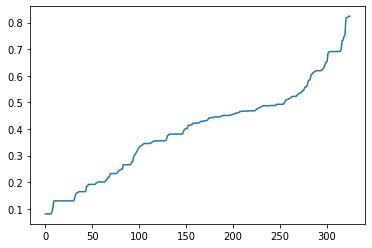

In [ ]:
fig = plt.figure()
plt.plot(accuracy_hist)

In [ ]:
features = cols
k  = len(features)-2
pos = 0 

accuracy_hist1 = []
features_history1 = []
model_history1 = []

for subset in itertools.combinations(cols, k):
    features = np.array(subset)

    print("######################## ",pos)
    pos +=1
    xgb_model = XGBClassifier()

    train_data = test[features]
    Y_train = test["label"]
    %time xgb_model.fit(train_data, Y_train,verbose=False)

    features_importance = xgb_model.feature_importances_

    kfold = KFold(n_splits=10, random_state=7)
    results = cross_val_score(xgb_model,train_data,Y_train, cv=kfold)
    
    acc = results.mean()
    accuracy_hist1.append(acc)
    features_history1.append(features)
    model_history1.append(xgb_model)
    print("cv results = ",results.mean())
    #plot_importance(xgb_model)

    
    y_hat = xgb_model.predict(train_data)

    print(classification_report(Y_train.to_numpy(), y_hat))

positions = np.argsort(accuracy_hist1)
accuracy_hist1 = np.array(accuracy_hist1)[positions]
features_history1 = np.array(features_history1)[positions]
model_history1 = np.array(model_history1)[positions]

########################  0
CPU times: user 234 ms, sys: 1.98 ms, total: 236 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  1
CPU times: user 236 ms, sys: 2.02 ms, total: 238 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  2
CPU times: user 230 ms, sys: 3.99 ms, total: 234 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  3
CPU times: user 227 ms, sys: 981 µs, total: 228 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  4
CPU times: user 224 ms, sys: 4.03 ms, total: 228 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  5
CPU times: user 226 ms, sys: 4.01 ms, total: 230 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  6
CPU times: user 224 ms, sys: 993 µs, total: 225 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  7
CPU times: user 231 ms, sys: 2.02 ms, total: 233 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  8
CPU times: user 227 ms, sys: 2.99 ms, total: 230 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  9
CPU times: user 227 ms, sys: 2 ms, total: 229 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  10
CPU times: user 232 ms, sys: 1.01 ms, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  11
CPU times: user 224 ms, sys: 3.02 ms, total: 227 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  12
CPU times: user 225 ms, sys: 1.99 ms, total: 227 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  13
CPU times: user 227 ms, sys: 2.98 ms, total: 230 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  14
CPU times: user 231 ms, sys: 1.95 ms, total: 233 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  15
CPU times: user 227 ms, sys: 1.9 ms, total: 229 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  16
CPU times: user 228 ms, sys: 2.02 ms, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  17
CPU times: user 235 ms, sys: 2 ms, total: 237 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  18
CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  19
CPU times: user 230 ms, sys: 2.99 ms, total: 233 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  20
CPU times: user 228 ms, sys: 3.97 ms, total: 232 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  21
CPU times: user 228 ms, sys: 3.03 ms, total: 231 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  22
CPU times: user 227 ms, sys: 2.01 ms, total: 229 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  23
CPU times: user 228 ms, sys: 2.99 ms, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  24
CPU times: user 221 ms, sys: 4.98 ms, total: 226 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  25
CPU times: user 229 ms, sys: 2.02 ms, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  26
CPU times: user 227 ms, sys: 5.96 ms, total: 233 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  27
CPU times: user 232 ms, sys: 2.99 ms, total: 235 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  28
CPU times: user 226 ms, sys: 2 ms, total: 228 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  29
CPU times: user 229 ms, sys: 2.96 ms, total: 232 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  30
CPU times: user 230 ms, sys: 2.99 ms, total: 233 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  31
CPU times: user 225 ms, sys: 1.98 ms, total: 227 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  32
CPU times: user 222 ms, sys: 3 ms, total: 225 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  33
CPU times: user 224 ms, sys: 3 ms, total: 227 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  34
CPU times: user 222 ms, sys: 3.96 ms, total: 226 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  35
CPU times: user 227 ms, sys: 4.02 ms, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  36
CPU times: user 229 ms, sys: 2.01 ms, total: 231 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  37
CPU times: user 232 ms, sys: 1 ms, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  38
CPU times: user 226 ms, sys: 3.98 ms, total: 230 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  39
CPU times: user 227 ms, sys: 2.01 ms, total: 229 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  40
CPU times: user 231 ms, sys: 2 ms, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  41
CPU times: user 234 ms, sys: 976 µs, total: 235 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  42
CPU times: user 231 ms, sys: 1 ms, total: 232 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  43
CPU times: user 225 ms, sys: 1.99 ms, total: 227 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  44
CPU times: user 233 ms, sys: 1.98 ms, total: 235 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  45
CPU times: user 239 ms, sys: 0 ns, total: 239 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  46
CPU times: user 227 ms, sys: 1.01 ms, total: 228 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  47
CPU times: user 234 ms, sys: 996 µs, total: 235 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  48
CPU times: user 232 ms, sys: 1.97 ms, total: 234 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  49
CPU times: user 226 ms, sys: 2.96 ms, total: 229 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  50
CPU times: user 237 ms, sys: 2.02 ms, total: 239 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  51
CPU times: user 228 ms, sys: 3.02 ms, total: 231 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  52
CPU times: user 227 ms, sys: 3.01 ms, total: 230 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  53
CPU times: user 231 ms, sys: 1.97 ms, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  54
CPU times: user 228 ms, sys: 6.01 ms, total: 234 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  55
CPU times: user 226 ms, sys: 2.97 ms, total: 229 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  56
CPU times: user 227 ms, sys: 4.99 ms, total: 232 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  57
CPU times: user 233 ms, sys: 2.05 ms, total: 235 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  58
CPU times: user 225 ms, sys: 3.04 ms, total: 228 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  59
CPU times: user 230 ms, sys: 991 µs, total: 231 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  60
CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  61
CPU times: user 226 ms, sys: 5.99 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  62
CPU times: user 230 ms, sys: 982 µs, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  63
CPU times: user 236 ms, sys: 1.01 ms, total: 237 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  64
CPU times: user 225 ms, sys: 6.96 ms, total: 232 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  65
CPU times: user 230 ms, sys: 4.02 ms, total: 234 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  66
CPU times: user 240 ms, sys: 1.98 ms, total: 242 ms
Wall time: 240 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  67
CPU times: user 239 ms, sys: 13 µs, total: 239 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  68
CPU times: user 233 ms, sys: 1.98 ms, total: 235 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  69
CPU times: user 235 ms, sys: 988 µs, total: 236 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  70
CPU times: user 233 ms, sys: 2.01 ms, total: 235 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  71
CPU times: user 231 ms, sys: 1.98 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  72
CPU times: user 237 ms, sys: 1.97 ms, total: 239 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  73
CPU times: user 234 ms, sys: 2.01 ms, total: 236 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  74
CPU times: user 233 ms, sys: 945 µs, total: 234 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.98      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  75
CPU times: user 225 ms, sys: 5.99 ms, total: 231 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.600909090909091
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.98      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  76
CPU times: user 233 ms, sys: 1.01 ms, total: 234 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  77
CPU times: user 226 ms, sys: 4.03 ms, total: 230 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  78
CPU times: user 225 ms, sys: 5 ms, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  79
CPU times: user 228 ms, sys: 4.02 ms, total: 232 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  80
CPU times: user 230 ms, sys: 3.98 ms, total: 234 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  81
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  82
CPU times: user 234 ms, sys: 1 ms, total: 235 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  83
CPU times: user 227 ms, sys: 3 ms, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  84
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  85
CPU times: user 232 ms, sys: 1.96 ms, total: 234 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  86
CPU times: user 227 ms, sys: 1.97 ms, total: 229 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  87
CPU times: user 233 ms, sys: 2.03 ms, total: 235 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  88
CPU times: user 233 ms, sys: 3.02 ms, total: 236 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  89
CPU times: user 231 ms, sys: 1 ms, total: 232 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  90
CPU times: user 229 ms, sys: 4.02 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5145454545454546
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.98      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  91
CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  92
CPU times: user 223 ms, sys: 4 µs, total: 223 ms
Wall time: 221 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  93
CPU times: user 222 ms, sys: 983 µs, total: 223 ms
Wall time: 221 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  94
CPU times: user 227 ms, sys: 959 µs, total: 228 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  95
CPU times: user 221 ms, sys: 2.06 ms, total: 223 ms
Wall time: 221 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  96
CPU times: user 227 ms, sys: 1.02 ms, total: 228 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7372727272727273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  97
CPU times: user 224 ms, sys: 1 ms, total: 225 ms
Wall time: 222 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  98
CPU times: user 224 ms, sys: 2.99 ms, total: 227 ms
Wall time: 224 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  99
CPU times: user 225 ms, sys: 1.01 ms, total: 226 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7627272727272727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  100
CPU times: user 226 ms, sys: 2.01 ms, total: 228 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  101
CPU times: user 220 ms, sys: 3 ms, total: 223 ms
Wall time: 221 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  102
CPU times: user 222 ms, sys: 3.02 ms, total: 225 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  103
CPU times: user 226 ms, sys: 2.04 ms, total: 228 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5963636363636364
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       400
           1       0.92      0.99      0.95       500
           2       1.00      1.00      1.00       200

    accuracy                           0.96      1100
   macro avg       0.97      0.96      0.96      1100
weighted avg       0.96      0.96      0.96      1100

########################  104
CPU times: user 229 ms, sys: 10 µs, total: 229 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  105
CPU times: user 232 ms, sys: 1.01 ms, total: 233 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  106
CPU times: user 229 ms, sys: 1.02 ms, total: 230 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  107
CPU times: user 234 ms, sys: 10 µs, total: 234 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  108
CPU times: user 230 ms, sys: 3.01 ms, total: 233 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  109
CPU times: user 229 ms, sys: 2.02 ms, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  110
CPU times: user 228 ms, sys: 0 ns, total: 228 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6772727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  111
CPU times: user 227 ms, sys: 3.02 ms, total: 230 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  112
CPU times: user 230 ms, sys: 3 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  113
CPU times: user 227 ms, sys: 1.99 ms, total: 229 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6663636363636363
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  114
CPU times: user 228 ms, sys: 2.96 ms, total: 231 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  115
CPU times: user 237 ms, sys: 3.98 ms, total: 241 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  116
CPU times: user 227 ms, sys: 3.02 ms, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  117
CPU times: user 228 ms, sys: 981 µs, total: 229 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5736363636363637
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.98      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  118
CPU times: user 227 ms, sys: 1.01 ms, total: 228 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5763636363636364
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  119
CPU times: user 224 ms, sys: 0 ns, total: 224 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7327272727272727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  120
CPU times: user 221 ms, sys: 1.01 ms, total: 222 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  121
CPU times: user 220 ms, sys: 3.99 ms, total: 224 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  122
CPU times: user 226 ms, sys: 2.98 ms, total: 229 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  123
CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  124
CPU times: user 220 ms, sys: 3 ms, total: 223 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  125
CPU times: user 227 ms, sys: 1.04 ms, total: 228 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  126
CPU times: user 228 ms, sys: 3.03 ms, total: 231 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  127
CPU times: user 223 ms, sys: 2 ms, total: 225 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  128
CPU times: user 228 ms, sys: 2.99 ms, total: 231 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  129
CPU times: user 222 ms, sys: 4 ms, total: 226 ms
Wall time: 224 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  130
CPU times: user 228 ms, sys: 2 ms, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  131
CPU times: user 226 ms, sys: 3.99 ms, total: 230 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  132
CPU times: user 228 ms, sys: 4.01 ms, total: 232 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6009090909090908
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.98      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  133
CPU times: user 227 ms, sys: 4.04 ms, total: 231 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6127272727272727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  134
CPU times: user 221 ms, sys: 3 ms, total: 224 ms
Wall time: 222 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7781818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  135
CPU times: user 223 ms, sys: 4.99 ms, total: 228 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8036363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  136
CPU times: user 229 ms, sys: 2.99 ms, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  137
CPU times: user 232 ms, sys: 2.03 ms, total: 234 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  138
CPU times: user 227 ms, sys: 2.99 ms, total: 230 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  139
CPU times: user 231 ms, sys: 965 µs, total: 232 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  140
CPU times: user 228 ms, sys: 4 ms, total: 232 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  141
CPU times: user 224 ms, sys: 4.01 ms, total: 228 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6781818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  142
CPU times: user 230 ms, sys: 4.97 ms, total: 235 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  143
CPU times: user 223 ms, sys: 4.01 ms, total: 227 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  144
CPU times: user 225 ms, sys: 6.01 ms, total: 231 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  145
CPU times: user 225 ms, sys: 3 ms, total: 228 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  146
CPU times: user 238 ms, sys: 20 µs, total: 238 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  147
CPU times: user 227 ms, sys: 5.02 ms, total: 232 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  148
CPU times: user 227 ms, sys: 3 ms, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5727272727272728
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  149
CPU times: user 229 ms, sys: 3 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  150
CPU times: user 220 ms, sys: 2.98 ms, total: 223 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7963636363636363
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  151
CPU times: user 228 ms, sys: 17 µs, total: 228 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  152
CPU times: user 223 ms, sys: 0 ns, total: 223 ms
Wall time: 221 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6981818181818181
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  153
CPU times: user 229 ms, sys: 2.99 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  154
CPU times: user 241 ms, sys: 978 µs, total: 242 ms
Wall time: 243 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  155
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  156
CPU times: user 231 ms, sys: 1.01 ms, total: 232 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  157
CPU times: user 231 ms, sys: 1.99 ms, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  158
CPU times: user 222 ms, sys: 4.01 ms, total: 226 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6627272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  159
CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  160
CPU times: user 236 ms, sys: 984 µs, total: 237 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  161
CPU times: user 228 ms, sys: 1.01 ms, total: 229 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6636363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  162
CPU times: user 235 ms, sys: 14 µs, total: 235 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  163
CPU times: user 229 ms, sys: 2.01 ms, total: 231 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  164
CPU times: user 234 ms, sys: 2 ms, total: 236 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  165
CPU times: user 230 ms, sys: 3.99 ms, total: 234 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.99      0.98      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  166
CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5690909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  167
CPU times: user 226 ms, sys: 2 ms, total: 228 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  168
CPU times: user 225 ms, sys: 2.01 ms, total: 227 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7245454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  169
CPU times: user 226 ms, sys: 3.02 ms, total: 229 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6809090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  170
CPU times: user 223 ms, sys: 4.01 ms, total: 227 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7527272727272727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  171
CPU times: user 228 ms, sys: 3 ms, total: 231 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  172
CPU times: user 224 ms, sys: 3.03 ms, total: 227 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  173
CPU times: user 229 ms, sys: 18 µs, total: 229 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  174
CPU times: user 226 ms, sys: 1.01 ms, total: 227 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  175
CPU times: user 238 ms, sys: 4.05 ms, total: 242 ms
Wall time: 242 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  176
CPU times: user 226 ms, sys: 4.96 ms, total: 231 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6827272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  177
CPU times: user 223 ms, sys: 1.98 ms, total: 225 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  178
CPU times: user 232 ms, sys: 949 µs, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  179
CPU times: user 231 ms, sys: 2.02 ms, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6809090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  180
CPU times: user 233 ms, sys: 2 ms, total: 235 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  181
CPU times: user 231 ms, sys: 2 ms, total: 233 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  182
CPU times: user 227 ms, sys: 7 µs, total: 227 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  183
CPU times: user 234 ms, sys: 2.02 ms, total: 236 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6045454545454545
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  184
CPU times: user 236 ms, sys: 2.03 ms, total: 238 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6090909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  185
CPU times: user 217 ms, sys: 2.02 ms, total: 219 ms
Wall time: 222 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7790909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  186
CPU times: user 222 ms, sys: 992 µs, total: 223 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6709090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  187
CPU times: user 225 ms, sys: 2.02 ms, total: 227 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6372727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  188
CPU times: user 230 ms, sys: 994 µs, total: 231 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7036363636363636
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  189
CPU times: user 223 ms, sys: 1.99 ms, total: 225 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6881818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  190
CPU times: user 231 ms, sys: 2 ms, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  191
CPU times: user 232 ms, sys: 5.03 ms, total: 237 ms
Wall time: 239 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  192
CPU times: user 228 ms, sys: 3.01 ms, total: 231 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  193
CPU times: user 235 ms, sys: 2 ms, total: 237 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  194
CPU times: user 232 ms, sys: 3 ms, total: 235 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  195
CPU times: user 229 ms, sys: 969 µs, total: 230 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7072727272727273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  196
CPU times: user 236 ms, sys: 2.02 ms, total: 238 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  197
CPU times: user 232 ms, sys: 1.98 ms, total: 234 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  198
CPU times: user 232 ms, sys: 3.01 ms, total: 235 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6890909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  199
CPU times: user 234 ms, sys: 1.99 ms, total: 236 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  200
CPU times: user 234 ms, sys: 1.95 ms, total: 236 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  201
CPU times: user 230 ms, sys: 4.99 ms, total: 235 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  202
CPU times: user 230 ms, sys: 2.99 ms, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5963636363636363
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       400
           1       0.98      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  203
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.62
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  204
CPU times: user 221 ms, sys: 4.01 ms, total: 225 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7790909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  205
CPU times: user 227 ms, sys: 3.02 ms, total: 230 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6927272727272726
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  206
CPU times: user 224 ms, sys: 3 ms, total: 227 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6781818181818181
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  207
CPU times: user 229 ms, sys: 998 µs, total: 230 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7045454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  208
CPU times: user 232 ms, sys: 1.99 ms, total: 234 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6727272727272727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  209
CPU times: user 230 ms, sys: 981 µs, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6409090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  210
CPU times: user 222 ms, sys: 3.02 ms, total: 225 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  211
CPU times: user 229 ms, sys: 3.98 ms, total: 233 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  212
CPU times: user 226 ms, sys: 1.01 ms, total: 227 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  213
CPU times: user 225 ms, sys: 994 µs, total: 226 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  214
CPU times: user 228 ms, sys: 4.03 ms, total: 232 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  215
CPU times: user 225 ms, sys: 3 µs, total: 225 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  216
CPU times: user 223 ms, sys: 2.01 ms, total: 225 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  217
CPU times: user 225 ms, sys: 2 µs, total: 225 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  218
CPU times: user 231 ms, sys: 1e+03 µs, total: 232 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  219
CPU times: user 224 ms, sys: 3 µs, total: 224 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  220
CPU times: user 222 ms, sys: 3 ms, total: 225 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  221
CPU times: user 225 ms, sys: 3 ms, total: 228 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  222
CPU times: user 231 ms, sys: 2 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6045454545454546
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       400
           1       1.00      0.95      0.97       500
           2       1.00      1.00      1.00       200

    accuracy                           0.98      1100
   macro avg       0.98      0.98      0.98      1100
weighted avg       0.98      0.98      0.98      1100

########################  223
CPU times: user 226 ms, sys: 992 µs, total: 227 ms
Wall time: 225 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6172727272727274
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  224
CPU times: user 223 ms, sys: 999 µs, total: 224 ms
Wall time: 220 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7454545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  225
CPU times: user 225 ms, sys: 994 µs, total: 226 ms
Wall time: 224 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6763636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  226
CPU times: user 226 ms, sys: 4 ms, total: 230 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6745454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  227
CPU times: user 222 ms, sys: 1.02 ms, total: 223 ms
Wall time: 221 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6763636363636365
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  228
CPU times: user 228 ms, sys: 2.03 ms, total: 230 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7363636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  229
CPU times: user 225 ms, sys: 3 µs, total: 226 ms
Wall time: 224 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6881818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  230
CPU times: user 226 ms, sys: 3 ms, total: 229 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  231
CPU times: user 240 ms, sys: 3.01 ms, total: 243 ms
Wall time: 238 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  232
CPU times: user 230 ms, sys: 0 ns, total: 230 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  233
CPU times: user 234 ms, sys: 5 µs, total: 234 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  234
CPU times: user 231 ms, sys: 3 ms, total: 234 ms
Wall time: 238 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  235
CPU times: user 232 ms, sys: 1 ms, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  236
CPU times: user 228 ms, sys: 4.98 ms, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  237
CPU times: user 236 ms, sys: 999 µs, total: 237 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  238
CPU times: user 236 ms, sys: 5 ms, total: 241 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  239
CPU times: user 230 ms, sys: 2 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6290909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  240
CPU times: user 239 ms, sys: 3.99 ms, total: 243 ms
Wall time: 239 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  241
CPU times: user 231 ms, sys: 1.99 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  242
CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  243
CPU times: user 240 ms, sys: 1.99 ms, total: 242 ms
Wall time: 239 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5845454545454545
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  244
CPU times: user 237 ms, sys: 0 ns, total: 237 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.59
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  245
CPU times: user 224 ms, sys: 3.03 ms, total: 227 ms
Wall time: 224 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.73
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  246
CPU times: user 232 ms, sys: 990 µs, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.650909090909091
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  247
CPU times: user 227 ms, sys: 2 ms, total: 229 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6663636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  248
CPU times: user 223 ms, sys: 3.99 ms, total: 227 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6481818181818181
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  249
CPU times: user 230 ms, sys: 4 ms, total: 234 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7372727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  250
CPU times: user 238 ms, sys: 2 ms, total: 240 ms
Wall time: 240 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  251
CPU times: user 232 ms, sys: 3 µs, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  252
CPU times: user 230 ms, sys: 1.01 ms, total: 231 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636362
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  253
CPU times: user 235 ms, sys: 3.05 ms, total: 238 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  254
CPU times: user 231 ms, sys: 994 µs, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  255
CPU times: user 241 ms, sys: 0 ns, total: 241 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  256
CPU times: user 236 ms, sys: 3.97 ms, total: 240 ms
Wall time: 238 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  257
CPU times: user 232 ms, sys: 3 ms, total: 235 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  258
CPU times: user 230 ms, sys: 4.01 ms, total: 234 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6436363636363638
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  259
CPU times: user 233 ms, sys: 3 ms, total: 236 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  260
CPU times: user 231 ms, sys: 2.97 ms, total: 234 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  261
CPU times: user 231 ms, sys: 5 ms, total: 236 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  262
CPU times: user 231 ms, sys: 1 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  263
CPU times: user 244 ms, sys: 3.01 ms, total: 247 ms
Wall time: 244 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  264
CPU times: user 234 ms, sys: 4.01 ms, total: 238 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  265
CPU times: user 233 ms, sys: 994 µs, total: 234 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.599090909090909
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  266
CPU times: user 234 ms, sys: 5 ms, total: 239 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  267
CPU times: user 227 ms, sys: 967 µs, total: 228 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7372727272727273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  268
CPU times: user 225 ms, sys: 4.02 ms, total: 229 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  269
CPU times: user 230 ms, sys: 4 ms, total: 234 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181819
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  270
CPU times: user 230 ms, sys: 2.97 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6781818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  271
CPU times: user 230 ms, sys: 1.01 ms, total: 231 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  272
CPU times: user 230 ms, sys: 1.99 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  273
CPU times: user 238 ms, sys: 988 µs, total: 239 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6763636363636363
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  274
CPU times: user 225 ms, sys: 2.01 ms, total: 227 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6790909090909092
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  275
CPU times: user 231 ms, sys: 2 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6463636363636363
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  276
CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  277
CPU times: user 234 ms, sys: 1.01 ms, total: 235 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  278
CPU times: user 229 ms, sys: 3 ms, total: 232 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  279
CPU times: user 230 ms, sys: 1.01 ms, total: 231 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  280
CPU times: user 232 ms, sys: 992 µs, total: 233 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  281
CPU times: user 225 ms, sys: 2.99 ms, total: 228 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6463636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  282
CPU times: user 231 ms, sys: 3.01 ms, total: 234 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  283
CPU times: user 232 ms, sys: 996 µs, total: 233 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  284
CPU times: user 226 ms, sys: 978 µs, total: 227 ms
Wall time: 228 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6645454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  285
CPU times: user 227 ms, sys: 1.01 ms, total: 228 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  286
CPU times: user 238 ms, sys: 1.01 ms, total: 239 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  287
CPU times: user 231 ms, sys: 1.99 ms, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  288
CPU times: user 237 ms, sys: 28 µs, total: 237 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  289
CPU times: user 237 ms, sys: 3.99 ms, total: 241 ms
Wall time: 239 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  290
CPU times: user 219 ms, sys: 3.01 ms, total: 222 ms
Wall time: 222 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7445454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  291
CPU times: user 229 ms, sys: 2.02 ms, total: 231 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6509090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  292
CPU times: user 226 ms, sys: 997 µs, total: 227 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6809090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  293
CPU times: user 228 ms, sys: 2.95 ms, total: 231 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6763636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  294
CPU times: user 230 ms, sys: 4.01 ms, total: 234 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6727272727272727
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  295
CPU times: user 227 ms, sys: 6.01 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  296
CPU times: user 232 ms, sys: 3.02 ms, total: 235 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6699999999999999
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  297
CPU times: user 229 ms, sys: 1.02 ms, total: 230 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  298
CPU times: user 233 ms, sys: 2 ms, total: 235 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6245454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  299
CPU times: user 233 ms, sys: 1 ms, total: 234 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  300
CPU times: user 231 ms, sys: 989 µs, total: 232 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  301
CPU times: user 232 ms, sys: 4.03 ms, total: 236 ms
Wall time: 237 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  302
CPU times: user 226 ms, sys: 3.99 ms, total: 230 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  303
CPU times: user 242 ms, sys: 972 µs, total: 243 ms
Wall time: 246 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  304
CPU times: user 228 ms, sys: 996 µs, total: 229 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  305
CPU times: user 230 ms, sys: 1.96 ms, total: 232 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  306
CPU times: user 242 ms, sys: 2.01 ms, total: 244 ms
Wall time: 241 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  307
CPU times: user 231 ms, sys: 0 ns, total: 231 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  308
CPU times: user 234 ms, sys: 4 µs, total: 234 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6681818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  309
CPU times: user 235 ms, sys: 4 ms, total: 239 ms
Wall time: 238 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  310
CPU times: user 227 ms, sys: 5.02 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  311
CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6545454545454545
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  312
CPU times: user 233 ms, sys: 1.99 ms, total: 235 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      1.00      1.00       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  313
CPU times: user 229 ms, sys: 3.99 ms, total: 233 ms
Wall time: 231 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  314
CPU times: user 224 ms, sys: 994 µs, total: 225 ms
Wall time: 223 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  315
CPU times: user 232 ms, sys: 986 µs, total: 233 ms
Wall time: 229 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6836363636363637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  316
CPU times: user 230 ms, sys: 2.01 ms, total: 232 ms
Wall time: 230 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  317
CPU times: user 226 ms, sys: 1.02 ms, total: 227 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  318
CPU times: user 229 ms, sys: 3.02 ms, total: 232 ms
Wall time: 232 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636364
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  319
CPU times: user 237 ms, sys: 0 ns, total: 237 ms
Wall time: 236 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.68
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  320
CPU times: user 232 ms, sys: 984 µs, total: 233 ms
Wall time: 233 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545454
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  321
CPU times: user 223 ms, sys: 4.98 ms, total: 228 ms
Wall time: 226 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454547
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  322
CPU times: user 235 ms, sys: 2.03 ms, total: 237 ms
Wall time: 239 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6281818181818182
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  323
CPU times: user 232 ms, sys: 2.01 ms, total: 234 ms
Wall time: 234 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100

########################  324
CPU times: user 232 ms, sys: 1.99 ms, total: 234 ms
Wall time: 235 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6472727272727272
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       200

    accuracy                           1.00      1100
   macro avg       1.00      1.00      1.00      1100
weighted avg       1.00      1.00      1.00      1100



In [ ]:
accuracy_hist1[-10:]

array([0.74818182, 0.74818182, 0.74818182, 0.75272727, 0.76272727,
       0.77818182, 0.77909091, 0.77909091, 0.79636364, 0.80363636])

In [ ]:
features_history1[-10:]

array([['Rate', 'len', 'subtype', 'ID', 'SC', 'ChannelFrequency',
        'dBm_AntSignal', 'reason', 'same_time', 'same_AP_addr',
        'same_client_addr', 'Client_BCAST', 'in_scope_AP',
        'TXFlags_NOACK', 'TXFlags_NOSEQ', 'TXFlags_TX_FAIL',
        'FCfield_RETRY', 'FCS', 'ChannelFlags_2GHZ',
        'entropy_of_notdecoded', 'TSFT', 'CHANNEL', 'RADIOTAPNS', 'EXT'],
       ['Rate', 'len', 'subtype', 'ID', 'SC', 'ChannelFrequency',
        'dBm_AntSignal', 'reason', 'same_time', 'same_AP_addr',
        'same_client_addr', 'Client_BCAST', 'in_scope_AP',
        'TXFlags_NOACK', 'TXFlags_NOSEQ', 'TXFlags_TX_FAIL',
        'FCfield_RETRY', 'FCS', 'ChannelFlags_2GHZ',
        'entropy_of_notdecoded', 'TSFT', 'CHANNEL', 'RXFLAGS', 'EXT'],
       ['Rate', 'len', 'subtype', 'ID', 'SC', 'ChannelFrequency',
        'dBm_AntSignal', 'reason', 'same_time', 'same_AP_addr',
        'same_client_addr', 'Client_BCAST', 'in_scope_AP',
        'TXFlags_NOACK', 'TXFlags_NOSEQ', 'TXFlags_TX_FAIL',

In [ ]:
fig = plt.figure()
plt.plot(accuracy_hist1)

In [ ]:
features = cols
k = 3
pos = 0 

accuracy_hist2 = []
features_history2 = []
model_history2 = []

for subset in itertools.combinations(cols, k):
    features = np.array(subset)

    print("######################## ",pos)
    pos +=1
    xgb_model = XGBClassifier()

    train_data = test[features]
    Y_train = test["label"]
    %time xgb_model.fit(train_data, Y_train,verbose=False)

    features_importance = xgb_model.feature_importances_

    kfold = KFold(n_splits=10, random_state=7)
    results = cross_val_score(xgb_model,train_data,Y_train, cv=kfold)
    
    acc = results.mean()
    accuracy_hist2.append(acc)
    features_history2.append(features)
    model_history2.append(xgb_model)
    print("cv results = ",results.mean())
    #plot_importance(xgb_model)

    
    y_hat = xgb_model.predict(train_data)

    print(classification_report(Y_train.to_numpy(), y_hat))


positions = np.argsort(accuracy_hist2)
accuracy_hist2 = np.array(accuracy_hist2)[positions]
features_history2 = np.array(features_history2)[positions]
model_history2 = np.array(model_history2)[positions]

########################  0
CPU times: user 75.3 ms, sys: 2 µs, total: 75.3 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  1
CPU times: user 74.5 ms, sys: 0 ns, total: 74.5 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  2
CPU times: user 81.6 ms, sys: 995 µs, total: 82.6 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  3
CPU times: user 73.1 ms, sys: 1 ms, total: 74.2 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  4
CPU times: user 81 ms, sys: 1.99 ms, total: 83 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  5
CPU times: user 77.7 ms, sys: 2 ms, total: 79.7 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  6
CPU times: user 79.3 ms, sys: 0 ns, total: 79.3 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  7
CPU times: user 81 ms, sys: 5.02 ms, total: 86.1 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  8
CPU times: user 80.9 ms, sys: 2 ms, total: 82.9 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  9
CPU times: user 82.5 ms, sys: 1.01 ms, total: 83.5 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  10
CPU times: user 70.1 ms, sys: 4.99 ms, total: 75.1 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  11
CPU times: user 72.5 ms, sys: 4.01 ms, total: 76.5 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  12
CPU times: user 68.4 ms, sys: 1 ms, total: 69.4 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  13
CPU times: user 68 ms, sys: 3 ms, total: 71 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  14
CPU times: user 73.6 ms, sys: 1.01 ms, total: 74.6 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  15
CPU times: user 80.2 ms, sys: 1 ms, total: 81.2 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  16
CPU times: user 68.9 ms, sys: 2 ms, total: 70.9 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  17
CPU times: user 69.6 ms, sys: 2.01 ms, total: 71.6 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  18
CPU times: user 75.9 ms, sys: 10 µs, total: 75.9 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  19
CPU times: user 68.8 ms, sys: 3.01 ms, total: 71.8 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  20
CPU times: user 69.7 ms, sys: 2 ms, total: 71.7 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  21
CPU times: user 70.1 ms, sys: 1.9 ms, total: 72 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  22
CPU times: user 69.9 ms, sys: 1.01 ms, total: 70.9 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  23
CPU times: user 70.3 ms, sys: 3.01 ms, total: 73.3 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  24
CPU times: user 72.2 ms, sys: 0 ns, total: 72.2 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.79      0.50      0.61       500
           2       0.70      0.25      0.37       200

    accuracy                           0.63      1100
   macro avg       0.68      0.58      0.56      1100
weighted avg       0.69      0.63      0.60      1100

########################  25
CPU times: user 83.7 ms, sys: 2 ms, total: 85.7 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.72      0.97      0.83       400
           1       0.86      0.64      0.73       500
           2       0.76      0.74      0.75       200

    accuracy                           0.78      1100
   macro avg       0.78      0.78      0.77      1100
weighted avg       0.79      0.78      0.77      1100

########################  26
CPU times: user 74.3 ms, sys: 1.01 ms, total: 75.3 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5454545454545454
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.86      0.61      0.71       500
           2       1.00      0.50      0.67       200

    accuracy                           0.73      1100
   macro avg       0.83      0.70      0.71      1100
weighted avg       0.80      0.73      0.72      1100

########################  27
CPU times: user 70.6 ms, sys: 3.9 ms, total: 74.5 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.85      0.61      0.71       500
           2       1.00      0.48      0.65       200

    accuracy                           0.73      1100
   macro avg       0.82      0.70      0.71      1100
weighted avg       0.79      0.73      0.72      1100

########################  28
CPU times: user 73.4 ms, sys: 1.01 ms, total: 74.4 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8236363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  29
CPU times: user 80.3 ms, sys: 1.02 ms, total: 81.3 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44363636363636366
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       400
           1       0.66      0.78      0.72       500
           2       0.69      0.45      0.55       200

    accuracy                           0.66      1100
   macro avg       0.67      0.62      0.64      1100
weighted avg       0.67      0.66      0.66      1100

########################  30
CPU times: user 80.6 ms, sys: 2 ms, total: 82.6 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3181818181818182
              precision    recall  f1-score   support

           0       0.68      0.46      0.55       400
           1       0.60      0.90      0.72       500
           2       0.47      0.18      0.27       200

    accuracy                           0.61      1100
   macro avg       0.58      0.51      0.51      1100
weighted avg       0.61      0.61      0.57      1100

########################  31
CPU times: user 78.8 ms, sys: 998 µs, total: 79.8 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.32545454545454544
              precision    recall  f1-score   support

           0       0.87      0.36      0.51       400
           1       0.61      0.93      0.73       500
           2       0.65      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.71      0.62      0.62      1100
weighted avg       0.71      0.66      0.63      1100

########################  32
CPU times: user 77.4 ms, sys: 2.01 ms, total: 79.4 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24727272727272726
              precision    recall  f1-score   support

           0       0.57      0.69      0.63       400
           1       0.62      0.71      0.66       500
           2       0.95      0.20      0.32       200

    accuracy                           0.61      1100
   macro avg       0.71      0.53      0.54      1100
weighted avg       0.66      0.61      0.59      1100

########################  33
CPU times: user 68.8 ms, sys: 1.99 ms, total: 70.8 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6436363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  34
CPU times: user 70.5 ms, sys: 993 µs, total: 71.5 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454546
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       400
           1       0.58      0.85      0.69       500
           2       1.00      0.25      0.40       200

    accuracy                           0.60      1100
   macro avg       0.73      0.53      0.54      1100
weighted avg       0.66      0.60      0.58      1100

########################  35
CPU times: user 73.6 ms, sys: 994 µs, total: 74.6 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44000000000000006
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.52      0.71      0.60       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.39      0.46      0.42      1100
weighted avg       0.47      0.57      0.51      1100

########################  36
CPU times: user 73.1 ms, sys: 1 ms, total: 74.1 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44000000000000006
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.52      0.71      0.60       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.39      0.46      0.42      1100
weighted avg       0.47      0.57      0.51      1100

########################  37
CPU times: user 81.8 ms, sys: 2.01 ms, total: 83.8 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.1518181818181818
              precision    recall  f1-score   support

           0       0.49      0.95      0.65       400
           1       0.61      0.40      0.49       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.37      0.45      0.38      1100
weighted avg       0.46      0.53      0.46      1100

########################  38
CPU times: user 70.1 ms, sys: 2 ms, total: 72.1 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4445454545454545
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.64      0.49      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.58      1100
   macro avg       0.40      0.50      0.42      1100
weighted avg       0.49      0.58      0.51      1100

########################  39
CPU times: user 72.4 ms, sys: 1.93 ms, total: 74.3 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  40
CPU times: user 71.1 ms, sys: 2 ms, total: 73.1 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  41
CPU times: user 75.4 ms, sys: 1.99 ms, total: 77.3 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5772727272727273
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.79      0.59      0.68       500
           2       0.86      0.35      0.50       200

    accuracy                           0.69      1100
   macro avg       0.75      0.64      0.64      1100
weighted avg       0.74      0.69      0.67      1100

########################  42
CPU times: user 76.5 ms, sys: 2 ms, total: 78.5 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  43
CPU times: user 68.7 ms, sys: 4.01 ms, total: 72.7 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  44
CPU times: user 72.6 ms, sys: 1.01 ms, total: 73.6 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  45
CPU times: user 73.2 ms, sys: 2 ms, total: 75.2 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  46
CPU times: user 77.9 ms, sys: 2.01 ms, total: 80 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  47
CPU times: user 82.6 ms, sys: 1.98 ms, total: 84.6 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45000000000000007
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.68      0.77       500
           2       0.81      0.73      0.77       200

    accuracy                           0.80      1100
   macro avg       0.81      0.80      0.80      1100
weighted avg       0.82      0.80      0.80      1100

########################  48
CPU times: user 71.4 ms, sys: 1.01 ms, total: 72.4 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2936363636363636
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.80      0.46      0.59       500
           2       0.88      0.75      0.81       200

    accuracy                           0.70      1100
   macro avg       0.76      0.73      0.72      1100
weighted avg       0.75      0.70      0.69      1100

########################  49
CPU times: user 68.6 ms, sys: 3.01 ms, total: 71.6 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33909090909090905
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.82      0.46      0.59       500
           2       0.88      0.74      0.81       200

    accuracy                           0.71      1100
   macro avg       0.77      0.74      0.72      1100
weighted avg       0.76      0.71      0.69      1100

########################  50
CPU times: user 72.3 ms, sys: 2.01 ms, total: 74.4 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6990909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  51
CPU times: user 78 ms, sys: 987 µs, total: 79 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5045454545454545
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.67      0.85      0.75       500
           2       0.70      0.60      0.65       200

    accuracy                           0.73      1100
   macro avg       0.75      0.70      0.72      1100
weighted avg       0.76      0.73      0.73      1100

########################  52
CPU times: user 84.2 ms, sys: 1 ms, total: 85.2 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       400
           1       0.69      0.86      0.77       500
           2       0.61      0.58      0.60       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  53
CPU times: user 75 ms, sys: 4.02 ms, total: 79 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5309090909090909
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       400
           1       0.75      0.89      0.81       500
           2       0.80      0.78      0.79       200

    accuracy                           0.80      1100
   macro avg       0.82      0.79      0.80      1100
weighted avg       0.82      0.80      0.80      1100

########################  54
CPU times: user 75.1 ms, sys: 3 ms, total: 78.1 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.27636363636363637
              precision    recall  f1-score   support

           0       0.60      0.79      0.68       400
           1       0.71      0.68      0.69       500
           2       0.88      0.43      0.58       200

    accuracy                           0.67      1100
   macro avg       0.73      0.63      0.65      1100
weighted avg       0.70      0.67      0.67      1100

########################  55
CPU times: user 71.6 ms, sys: 1.01 ms, total: 72.6 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.65      0.95      0.77       500
           2       0.70      0.25      0.37       200

    accuracy                           0.74      1100
   macro avg       0.78      0.64      0.66      1100
weighted avg       0.78      0.74      0.72      1100

########################  56
CPU times: user 67.1 ms, sys: 2 ms, total: 69.1 ms
Wall time: 68.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42363636363636364
              precision    recall  f1-score   support

           0       0.82      0.48      0.61       400
           1       0.60      0.92      0.72       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.81      0.63      0.67      1100
weighted avg       0.75      0.68      0.67      1100

########################  57
CPU times: user 67.9 ms, sys: 3 ms, total: 70.9 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23818181818181813
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       400
           1       0.53      0.58      0.55       500
           2       0.70      0.25      0.37       200

    accuracy                           0.57      1100
   macro avg       0.61      0.52      0.53      1100
weighted avg       0.59      0.57      0.56      1100

########################  58
CPU times: user 73.7 ms, sys: 9 µs, total: 73.8 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23818181818181813
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       400
           1       0.53      0.58      0.55       500
           2       0.70      0.25      0.37       200

    accuracy                           0.57      1100
   macro avg       0.61      0.52      0.53      1100
weighted avg       0.59      0.57      0.56      1100

########################  59
CPU times: user 70.8 ms, sys: 997 µs, total: 71.8 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35090909090909095
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       400
           1       0.82      0.48      0.60       500
           2       0.70      0.25      0.37       200

    accuracy                           0.62      1100
   macro avg       0.69      0.57      0.56      1100
weighted avg       0.69      0.62      0.59      1100

########################  60
CPU times: user 72.7 ms, sys: 0 ns, total: 72.7 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2936363636363636
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       400
           1       0.78      0.36      0.49       500
           2       0.67      0.65      0.66       200

    accuracy                           0.64      1100
   macro avg       0.68      0.66      0.62      1100
weighted avg       0.69      0.64      0.61      1100

########################  61
CPU times: user 68.8 ms, sys: 997 µs, total: 69.8 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2927272727272727
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  62
CPU times: user 72.5 ms, sys: 1.01 ms, total: 73.5 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2927272727272727
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  63
CPU times: user 77.1 ms, sys: 2.02 ms, total: 79.1 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  64
CPU times: user 69.8 ms, sys: 1.98 ms, total: 71.8 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2927272727272727
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  65
CPU times: user 69.6 ms, sys: 8 µs, total: 69.6 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2927272727272727
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  66
CPU times: user 76.9 ms, sys: 3.01 ms, total: 79.9 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2927272727272727
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  67
CPU times: user 70.6 ms, sys: 997 µs, total: 71.6 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2927272727272727
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  68
CPU times: user 74.9 ms, sys: 2.99 ms, total: 77.9 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2927272727272727
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  69
CPU times: user 79.4 ms, sys: 2.01 ms, total: 81.4 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5045454545454546
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.84      0.75      0.79       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  70
CPU times: user 81.7 ms, sys: 8 µs, total: 81.7 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5172727272727273
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.84      0.75      0.79       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  71
CPU times: user 78.5 ms, sys: 2.01 ms, total: 80.5 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       400
           1       0.99      0.80      0.88       500
           2       1.00      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  72
CPU times: user 86 ms, sys: 12 µs, total: 86 ms
Wall time: 85.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       400
           1       0.96      0.75      0.84       500
           2       0.80      0.98      0.89       200

    accuracy                           0.87      1100
   macro avg       0.86      0.90      0.87      1100
weighted avg       0.88      0.87      0.87      1100

########################  73
CPU times: user 90.1 ms, sys: 3 ms, total: 93.1 ms
Wall time: 92.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30999999999999994
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       400
           1       0.80      0.89      0.84       500
           2       0.85      0.72      0.78       200

    accuracy                           0.85      1100
   macro avg       0.86      0.82      0.84      1100
weighted avg       0.85      0.85      0.85      1100

########################  74
CPU times: user 84.9 ms, sys: 998 µs, total: 85.9 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272726
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       400
           1       0.90      0.89      0.90       500
           2       0.96      0.95      0.96       200

    accuracy                           0.90      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  75
CPU times: user 90.2 ms, sys: 2 µs, total: 90.2 ms
Wall time: 90 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30272727272727273
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       400
           1       0.95      0.72      0.82       500
           2       0.90      0.92      0.91       200

    accuracy                           0.85      1100
   macro avg       0.87      0.88      0.86      1100
weighted avg       0.87      0.85      0.85      1100

########################  76
CPU times: user 81.3 ms, sys: 2.99 ms, total: 84.3 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47727272727272724
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       400
           1       0.77      0.95      0.85       500
           2       0.82      0.73      0.78       200

    accuracy                           0.84      1100
   macro avg       0.86      0.82      0.83      1100
weighted avg       0.86      0.84      0.84      1100

########################  77
CPU times: user 83.1 ms, sys: 1 ms, total: 84.1 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       400
           1       0.94      0.71      0.81       500
           2       0.94      0.99      0.96       200

    accuracy                           0.84      1100
   macro avg       0.87      0.88      0.86      1100
weighted avg       0.86      0.84      0.84      1100

########################  78
CPU times: user 83.6 ms, sys: 0 ns, total: 83.6 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       400
           1       0.84      0.69      0.75       500
           2       0.84      0.74      0.79       200

    accuracy                           0.79      1100
   macro avg       0.81      0.79      0.79      1100
weighted avg       0.80      0.79      0.79      1100

########################  79
CPU times: user 78.1 ms, sys: 1 ms, total: 79.1 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       400
           1       0.84      0.69      0.75       500
           2       0.84      0.74      0.79       200

    accuracy                           0.79      1100
   macro avg       0.81      0.79      0.79      1100
weighted avg       0.80      0.79      0.79      1100

########################  80
CPU times: user 80.2 ms, sys: 2 µs, total: 80.2 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       400
           1       0.84      0.64      0.72       500
           2       0.83      0.69      0.75       200

    accuracy                           0.77      1100
   macro avg       0.79      0.76      0.76      1100
weighted avg       0.79      0.77      0.76      1100

########################  81
CPU times: user 76.3 ms, sys: 3.01 ms, total: 79.3 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46454545454545454
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       400
           1       0.85      0.62      0.72       500
           2       0.82      0.71      0.76       200

    accuracy                           0.77      1100
   macro avg       0.79      0.77      0.77      1100
weighted avg       0.79      0.77      0.76      1100

########################  82
CPU times: user 83.4 ms, sys: 2.99 ms, total: 86.4 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272737
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.83      0.74      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.80      1100
weighted avg       0.82      0.81      0.80      1100

########################  83
CPU times: user 82.2 ms, sys: 1.02 ms, total: 83.2 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272737
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.83      0.74      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.80      1100
weighted avg       0.82      0.81      0.80      1100

########################  84
CPU times: user 80.9 ms, sys: 2.01 ms, total: 82.9 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.84      0.73      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  85
CPU times: user 77.9 ms, sys: 2.99 ms, total: 80.8 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272737
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.83      0.74      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.80      1100
weighted avg       0.82      0.81      0.80      1100

########################  86
CPU times: user 77.5 ms, sys: 1.99 ms, total: 79.5 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272737
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.83      0.74      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.80      1100
weighted avg       0.82      0.81      0.80      1100

########################  87
CPU times: user 78.6 ms, sys: 2 ms, total: 80.6 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272737
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.83      0.74      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.80      1100
weighted avg       0.82      0.81      0.80      1100

########################  88
CPU times: user 79.7 ms, sys: 1.02 ms, total: 80.7 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272737
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.83      0.74      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.80      1100
weighted avg       0.82      0.81      0.80      1100

########################  89
CPU times: user 76.1 ms, sys: 2.99 ms, total: 79.1 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272737
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.87      0.69      0.77       500
           2       0.83      0.74      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.80      1100
weighted avg       0.82      0.81      0.80      1100

########################  90
CPU times: user 76.5 ms, sys: 2.01 ms, total: 78.5 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47818181818181815
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.66      1100
weighted avg       0.76      0.66      0.65      1100

########################  91
CPU times: user 74 ms, sys: 0 ns, total: 74 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6918181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  92
CPU times: user 79.5 ms, sys: 994 µs, total: 80.5 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4563636363636364
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.75      0.80      0.78       500
           2       0.79      0.86      0.82       200

    accuracy                           0.76      1100
   macro avg       0.76      0.77      0.76      1100
weighted avg       0.75      0.76      0.75      1100

########################  93
CPU times: user 78.6 ms, sys: 994 µs, total: 79.6 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37090909090909085
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.71      0.91      0.80       500
           2       0.99      0.52      0.68       200

    accuracy                           0.75      1100
   macro avg       0.82      0.70      0.73      1100
weighted avg       0.77      0.75      0.74      1100

########################  94
CPU times: user 79.6 ms, sys: 1.01 ms, total: 80.6 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40909090909090906
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.98      0.84       500
           2       0.99      0.73      0.84       200

    accuracy                           0.79      1100
   macro avg       0.84      0.76      0.78      1100
weighted avg       0.81      0.79      0.78      1100

########################  95
CPU times: user 78.2 ms, sys: 2.99 ms, total: 81.2 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21818181818181817
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       400
           1       0.72      0.73      0.72       500
           2       0.99      0.68      0.80       200

    accuracy                           0.71      1100
   macro avg       0.78      0.71      0.73      1100
weighted avg       0.73      0.71      0.72      1100

########################  96
CPU times: user 72.4 ms, sys: 4 µs, total: 72.4 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6054545454545455
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  97
CPU times: user 66.4 ms, sys: 3.01 ms, total: 69.4 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.71      1.00      0.83       500
           2       1.00      0.75      0.86       200

    accuracy                           0.77      1100
   macro avg       0.83      0.74      0.76      1100
weighted avg       0.79      0.77      0.75      1100

########################  98
CPU times: user 70.8 ms, sys: 2 ms, total: 72.8 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  99
CPU times: user 74.7 ms, sys: 3 ms, total: 77.7 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  100
CPU times: user 83.3 ms, sys: 17 µs, total: 83.3 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.73      0.62      0.67       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.80      0.69      0.71      1100
weighted avg       0.76      0.72      0.71      1100

########################  101
CPU times: user 70.6 ms, sys: 2 ms, total: 72.6 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  102
CPU times: user 69.1 ms, sys: 1.02 ms, total: 70.2 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  103
CPU times: user 70.4 ms, sys: 992 µs, total: 71.4 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  104
CPU times: user 77.2 ms, sys: 17 µs, total: 77.3 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38909090909090904
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  105
CPU times: user 66 ms, sys: 4.01 ms, total: 70 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  106
CPU times: user 74.9 ms, sys: 999 µs, total: 75.9 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  107
CPU times: user 71.2 ms, sys: 1.02 ms, total: 72.2 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  108
CPU times: user 69.9 ms, sys: 1.99 ms, total: 71.9 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  109
CPU times: user 68.8 ms, sys: 1.98 ms, total: 70.7 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  110
CPU times: user 76.1 ms, sys: 2 ms, total: 78.2 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7272727272727272
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  111
CPU times: user 80.2 ms, sys: 2 µs, total: 80.2 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48909090909090913
              precision    recall  f1-score   support

           0       0.75      0.67      0.70       400
           1       0.76      0.80      0.78       500
           2       0.78      0.85      0.82       200

    accuracy                           0.76      1100
   macro avg       0.76      0.77      0.77      1100
weighted avg       0.76      0.76      0.76      1100

########################  112
CPU times: user 79.9 ms, sys: 3.01 ms, total: 82.9 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39999999999999997
              precision    recall  f1-score   support

           0       0.75      0.68      0.71       400
           1       0.72      0.92      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.75      1100
   macro avg       0.82      0.70      0.73      1100
weighted avg       0.78      0.75      0.75      1100

########################  113
CPU times: user 82.9 ms, sys: 1.9 ms, total: 84.8 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       400
           1       0.74      0.99      0.85       500
           2       0.98      0.73      0.84       200

    accuracy                           0.79      1100
   macro avg       0.85      0.77      0.79      1100
weighted avg       0.81      0.79      0.78      1100

########################  114
CPU times: user 83.8 ms, sys: 984 µs, total: 84.8 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24454545454545454
              precision    recall  f1-score   support

           0       0.62      0.73      0.67       400
           1       0.74      0.69      0.71       500
           2       0.90      0.72      0.80       200

    accuracy                           0.71      1100
   macro avg       0.75      0.71      0.73      1100
weighted avg       0.72      0.71      0.71      1100

########################  115
CPU times: user 73.2 ms, sys: 1 ms, total: 74.2 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6418181818181818
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.48      0.65       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.79      0.78      1100

########################  116
CPU times: user 72.7 ms, sys: 997 µs, total: 73.7 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       0.80      0.50      0.62       400
           1       0.71      1.00      0.83       500
           2       1.00      0.73      0.84       200

    accuracy                           0.77      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.77      0.75      1100

########################  117
CPU times: user 75.2 ms, sys: 1 ms, total: 76.2 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  118
CPU times: user 72.3 ms, sys: 4.01 ms, total: 76.3 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  119
CPU times: user 74.1 ms, sys: 5 ms, total: 79.1 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5809090909090908
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.73      0.62      0.67       500
           2       1.00      0.48      0.65       200

    accuracy                           0.73      1100
   macro avg       0.80      0.69      0.71      1100
weighted avg       0.76      0.73      0.71      1100

########################  120
CPU times: user 70.9 ms, sys: 3 ms, total: 73.9 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  121
CPU times: user 77.7 ms, sys: 2.01 ms, total: 79.7 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  122
CPU times: user 73.3 ms, sys: 3 µs, total: 73.3 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  123
CPU times: user 78.8 ms, sys: 1.01 ms, total: 79.8 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.81      0.46      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.65      1100

########################  124
CPU times: user 72.7 ms, sys: 0 ns, total: 72.7 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  125
CPU times: user 74 ms, sys: 3.02 ms, total: 77.1 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  126
CPU times: user 71.4 ms, sys: 2.01 ms, total: 73.5 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  127
CPU times: user 72.7 ms, sys: 2.99 ms, total: 75.7 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  128
CPU times: user 71.2 ms, sys: 1 ms, total: 72.2 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  129
CPU times: user 77.3 ms, sys: 1 ms, total: 78.3 ms
Wall time: 78 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7327272727272727
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  130
CPU times: user 80.5 ms, sys: 1.01 ms, total: 81.5 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5854545454545453
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.95      0.84      0.89       500
           2       1.00      0.95      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.90      0.91      1100

########################  131
CPU times: user 85.2 ms, sys: 15 µs, total: 85.2 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5863636363636363
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.97      0.99       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  132
CPU times: user 79.8 ms, sys: 1.01 ms, total: 80.8 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6627272727272727
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  133
CPU times: user 72.5 ms, sys: 1.99 ms, total: 74.5 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818183
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  134
CPU times: user 84.7 ms, sys: 1.98 ms, total: 86.6 ms
Wall time: 87.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5654545454545454
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.95      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  135
CPU times: user 73.8 ms, sys: 998 µs, total: 74.8 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8236363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  136
CPU times: user 68.3 ms, sys: 5 ms, total: 73.3 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8236363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  137
CPU times: user 70.4 ms, sys: 3.01 ms, total: 73.4 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7263636363636363
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  138
CPU times: user 73.3 ms, sys: 2.01 ms, total: 75.3 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7190909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  139
CPU times: user 76.5 ms, sys: 994 µs, total: 77.5 ms
Wall time: 77.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  140
CPU times: user 72 ms, sys: 2 ms, total: 74 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  141
CPU times: user 74.5 ms, sys: 3.01 ms, total: 77.5 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  142
CPU times: user 69.7 ms, sys: 4.01 ms, total: 73.7 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  143
CPU times: user 74.5 ms, sys: 1.01 ms, total: 75.6 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  144
CPU times: user 74.8 ms, sys: 9 µs, total: 74.8 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  145
CPU times: user 77 ms, sys: 1.9 ms, total: 78.9 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  146
CPU times: user 74.7 ms, sys: 1.97 ms, total: 76.6 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  147
CPU times: user 81.4 ms, sys: 2.01 ms, total: 83.4 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.76      0.68      0.72       400
           1       0.77      0.81      0.79       500
           2       0.68      0.71      0.70       200

    accuracy                           0.75      1100
   macro avg       0.74      0.74      0.74      1100
weighted avg       0.75      0.75      0.75      1100

########################  148
CPU times: user 83.1 ms, sys: 1 ms, total: 84.1 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4281818181818182
              precision    recall  f1-score   support

           0       0.82      0.65      0.73       400
           1       0.76      0.86      0.81       500
           2       0.73      0.79      0.76       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.78      0.77      0.77      1100

########################  149
CPU times: user 86.7 ms, sys: 9 µs, total: 86.7 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3454545454545454
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       400
           1       0.77      0.76      0.77       500
           2       0.68      0.86      0.76       200

    accuracy                           0.76      1100
   macro avg       0.76      0.78      0.76      1100
weighted avg       0.77      0.76      0.76      1100

########################  150
CPU times: user 79.1 ms, sys: 2 ms, total: 81.1 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5572727272727273
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       400
           1       0.75      0.82      0.78       500
           2       0.55      0.69      0.62       200

    accuracy                           0.77      1100
   macro avg       0.76      0.75      0.75      1100
weighted avg       0.80      0.77      0.77      1100

########################  151
CPU times: user 82.9 ms, sys: 3 ms, total: 85.9 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48818181818181816
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       400
           1       0.64      0.95      0.77       500
           2       0.88      0.36      0.51       200

    accuracy                           0.71      1100
   macro avg       0.78      0.63      0.65      1100
weighted avg       0.75      0.71      0.69      1100

########################  152
CPU times: user 81.2 ms, sys: 1e+03 ns, total: 81.2 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4981818181818182
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       400
           1       0.68      0.75      0.71       500
           2       0.65      0.82      0.72       200

    accuracy                           0.70      1100
   macro avg       0.70      0.72      0.70      1100
weighted avg       0.71      0.70      0.70      1100

########################  153
CPU times: user 78.5 ms, sys: 2.01 ms, total: 80.5 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4981818181818182
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       400
           1       0.68      0.75      0.71       500
           2       0.65      0.82      0.72       200

    accuracy                           0.70      1100
   macro avg       0.70      0.72      0.70      1100
weighted avg       0.71      0.70      0.70      1100

########################  154
CPU times: user 77.7 ms, sys: 982 µs, total: 78.7 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4281818181818181
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       400
           1       0.65      0.77      0.70       500
           2       0.76      0.50      0.60       200

    accuracy                           0.67      1100
   macro avg       0.70      0.64      0.66      1100
weighted avg       0.68      0.67      0.67      1100

########################  155
CPU times: user 87.1 ms, sys: 0 ns, total: 87.1 ms
Wall time: 86.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46363636363636374
              precision    recall  f1-score   support

           0       0.69      0.64      0.66       400
           1       0.71      0.79      0.75       500
           2       0.73      0.65      0.68       200

    accuracy                           0.71      1100
   macro avg       0.71      0.69      0.70      1100
weighted avg       0.71      0.71      0.70      1100

########################  156
CPU times: user 77.6 ms, sys: 0 ns, total: 77.6 ms
Wall time: 77.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818183
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.71      0.75      0.73       500
           2       0.68      0.75      0.71       200

    accuracy                           0.71      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.71      0.71      0.71      1100

########################  157
CPU times: user 76.8 ms, sys: 999 µs, total: 77.8 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818183
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.71      0.75      0.73       500
           2       0.68      0.75      0.71       200

    accuracy                           0.71      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.71      0.71      0.71      1100

########################  158
CPU times: user 78.3 ms, sys: 2.01 ms, total: 80.3 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4536363636363636
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       400
           1       0.74      0.80      0.77       500
           2       0.73      0.91      0.81       200

    accuracy                           0.76      1100
   macro avg       0.76      0.78      0.76      1100
weighted avg       0.76      0.76      0.75      1100

########################  159
CPU times: user 79.3 ms, sys: 2.01 ms, total: 81.3 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818183
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.71      0.75      0.73       500
           2       0.68      0.75      0.71       200

    accuracy                           0.71      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.71      0.71      0.71      1100

########################  160
CPU times: user 77.6 ms, sys: 1.01 ms, total: 78.6 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818183
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.71      0.75      0.73       500
           2       0.68      0.75      0.71       200

    accuracy                           0.71      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.71      0.71      0.71      1100

########################  161
CPU times: user 77.4 ms, sys: 3 ms, total: 80.4 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818183
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.71      0.75      0.73       500
           2       0.68      0.75      0.71       200

    accuracy                           0.71      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.71      0.71      0.71      1100

########################  162
CPU times: user 75.9 ms, sys: 2 ms, total: 77.9 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818183
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.71      0.75      0.73       500
           2       0.68      0.75      0.71       200

    accuracy                           0.71      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.71      0.71      0.71      1100

########################  163
CPU times: user 76.2 ms, sys: 2 ms, total: 78.2 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818183
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       400
           1       0.71      0.75      0.73       500
           2       0.68      0.75      0.71       200

    accuracy                           0.71      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.71      0.71      0.71      1100

########################  164
CPU times: user 81.8 ms, sys: 997 µs, total: 82.8 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.31
              precision    recall  f1-score   support

           0       0.88      0.48      0.63       400
           1       0.65      0.93      0.76       500
           2       0.68      0.57      0.62       200

    accuracy                           0.70      1100
   macro avg       0.74      0.66      0.67      1100
weighted avg       0.74      0.70      0.69      1100

########################  165
CPU times: user 83.7 ms, sys: 3.01 ms, total: 86.7 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       400
           1       0.72      0.83      0.77       500
           2       0.87      0.57      0.69       200

    accuracy                           0.74      1100
   macro avg       0.77      0.70      0.72      1100
weighted avg       0.75      0.74      0.73      1100

########################  166
CPU times: user 75.5 ms, sys: 3.01 ms, total: 78.5 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.66      0.91      0.77       500
           2       0.57      0.40      0.47       200

    accuracy                           0.73      1100
   macro avg       0.74      0.66      0.68      1100
weighted avg       0.76      0.73      0.72      1100

########################  167
CPU times: user 73.7 ms, sys: 3 ms, total: 76.7 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5854545454545454
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       400
           1       0.81      0.85      0.83       500
           2       0.79      0.68      0.73       200

    accuracy                           0.83      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.83      0.82      1100

########################  168
CPU times: user 80.5 ms, sys: 5 µs, total: 80.5 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35727272727272724
              precision    recall  f1-score   support

           0       0.87      0.54      0.66       400
           1       0.61      0.89      0.72       500
           2       0.54      0.34      0.42       200

    accuracy                           0.66      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.69      0.66      0.65      1100

########################  169
CPU times: user 78.6 ms, sys: 3.01 ms, total: 81.6 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35727272727272724
              precision    recall  f1-score   support

           0       0.87      0.54      0.66       400
           1       0.61      0.89      0.72       500
           2       0.54      0.34      0.42       200

    accuracy                           0.66      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.69      0.66      0.65      1100

########################  170
CPU times: user 79.7 ms, sys: 1.01 ms, total: 80.7 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2790909090909091
              precision    recall  f1-score   support

           0       0.70      0.51      0.59       400
           1       0.62      0.83      0.71       500
           2       0.58      0.41      0.49       200

    accuracy                           0.64      1100
   macro avg       0.64      0.58      0.59      1100
weighted avg       0.64      0.64      0.62      1100

########################  171
CPU times: user 83.1 ms, sys: 989 µs, total: 84.1 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.31727272727272726
              precision    recall  f1-score   support

           0       0.72      0.59      0.65       400
           1       0.64      0.85      0.73       500
           2       0.73      0.36      0.49       200

    accuracy                           0.67      1100
   macro avg       0.69      0.60      0.62      1100
weighted avg       0.68      0.67      0.66      1100

########################  172
CPU times: user 86.1 ms, sys: 2 ms, total: 88.1 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.69      0.82      0.75       500
           2       0.64      0.47      0.54       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.66      1100
weighted avg       0.70      0.70      0.69      1100

########################  173
CPU times: user 77.5 ms, sys: 3.01 ms, total: 80.5 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.69      0.82      0.75       500
           2       0.64      0.47      0.54       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.66      1100
weighted avg       0.70      0.70      0.69      1100

########################  174
CPU times: user 80.9 ms, sys: 2 ms, total: 82.9 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.77      0.65      0.70       400
           1       0.68      0.89      0.77       500
           2       0.76      0.45      0.56       200

    accuracy                           0.72      1100
   macro avg       0.74      0.66      0.68      1100
weighted avg       0.73      0.72      0.71      1100

########################  175
CPU times: user 76.6 ms, sys: 4 ms, total: 80.6 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.69      0.82      0.75       500
           2       0.64      0.47      0.54       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.66      1100
weighted avg       0.70      0.70      0.69      1100

########################  176
CPU times: user 85.3 ms, sys: 0 ns, total: 85.3 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.69      0.82      0.75       500
           2       0.64      0.47      0.54       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.66      1100
weighted avg       0.70      0.70      0.69      1100

########################  177
CPU times: user 78.2 ms, sys: 3 ms, total: 81.3 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.69      0.82      0.75       500
           2       0.64      0.47      0.54       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.66      1100
weighted avg       0.70      0.70      0.69      1100

########################  178
CPU times: user 84.4 ms, sys: 2.01 ms, total: 86.4 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.69      0.82      0.75       500
           2       0.64      0.47      0.54       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.66      1100
weighted avg       0.70      0.70      0.69      1100

########################  179
CPU times: user 78.1 ms, sys: 3 ms, total: 81.2 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35818181818181816
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       400
           1       0.69      0.82      0.75       500
           2       0.64      0.47      0.54       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.66      1100
weighted avg       0.70      0.70      0.69      1100

########################  180
CPU times: user 85.4 ms, sys: 2.01 ms, total: 87.4 ms
Wall time: 88.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33636363636363636
              precision    recall  f1-score   support

           0       0.75      0.63      0.68       400
           1       0.67      0.87      0.76       500
           2       0.89      0.54      0.67       200

    accuracy                           0.72      1100
   macro avg       0.77      0.68      0.71      1100
weighted avg       0.74      0.72      0.72      1100

########################  181
CPU times: user 78.8 ms, sys: 997 µs, total: 79.8 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6163636363636362
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.69      0.93      0.79       500
           2       0.78      0.61      0.68       200

    accuracy                           0.77      1100
   macro avg       0.82      0.73      0.76      1100
weighted avg       0.81      0.77      0.77      1100

########################  182
CPU times: user 74 ms, sys: 2 ms, total: 76 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5772727272727273
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       400
           1       0.81      0.87      0.84       500
           2       0.84      0.67      0.74       200

    accuracy                           0.83      1100
   macro avg       0.84      0.80      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  183
CPU times: user 79.4 ms, sys: 992 µs, total: 80.4 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45909090909090916
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       400
           1       0.74      0.69      0.71       500
           2       0.68      0.62      0.65       200

    accuracy                           0.72      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  184
CPU times: user 83 ms, sys: 986 µs, total: 83.9 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45909090909090916
              precision    recall  f1-score   support

           0       0.71      0.81      0.76       400
           1       0.74      0.69      0.71       500
           2       0.68      0.62      0.65       200

    accuracy                           0.72      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  185
CPU times: user 82.9 ms, sys: 11 µs, total: 82.9 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3690909090909091
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       400
           1       0.75      0.69      0.72       500
           2       0.71      0.78      0.74       200

    accuracy                           0.71      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.71      0.71      1100

########################  186
CPU times: user 74.7 ms, sys: 4 ms, total: 78.7 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3518181818181818
              precision    recall  f1-score   support

           0       0.74      0.54      0.62       400
           1       0.68      0.89      0.77       500
           2       0.83      0.62      0.71       200

    accuracy                           0.71      1100
   macro avg       0.75      0.68      0.70      1100
weighted avg       0.73      0.71      0.70      1100

########################  187
CPU times: user 78.6 ms, sys: 2.01 ms, total: 80.6 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.72      0.89      0.80       500
           2       0.73      0.73      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  188
CPU times: user 79.8 ms, sys: 997 µs, total: 80.8 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.72      0.89      0.80       500
           2       0.73      0.73      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  189
CPU times: user 82.5 ms, sys: 0 ns, total: 82.5 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47727272727272735
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.84      0.74      0.79       500
           2       0.90      0.61      0.73       200

    accuracy                           0.77      1100
   macro avg       0.81      0.75      0.77      1100
weighted avg       0.80      0.77      0.77      1100

########################  190
CPU times: user 79.1 ms, sys: 907 µs, total: 80 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.72      0.89      0.80       500
           2       0.73      0.73      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  191
CPU times: user 80.4 ms, sys: 5 µs, total: 80.4 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.72      0.89      0.80       500
           2       0.73      0.73      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  192
CPU times: user 81.8 ms, sys: 1.01 ms, total: 82.8 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.72      0.89      0.80       500
           2       0.73      0.73      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  193
CPU times: user 74.9 ms, sys: 4 ms, total: 78.9 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.72      0.89      0.80       500
           2       0.73      0.73      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  194
CPU times: user 77.7 ms, sys: 3 ms, total: 80.7 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.72      0.89      0.80       500
           2       0.73      0.73      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  195
CPU times: user 79 ms, sys: 1.01 ms, total: 80 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5436363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.63      0.95      0.76       500
           2       0.67      0.27      0.38       200

    accuracy                           0.72      1100
   macro avg       0.76      0.63      0.64      1100
weighted avg       0.77      0.72      0.70      1100

########################  196
CPU times: user 80 ms, sys: 2 ms, total: 82 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.32909090909090905
              precision    recall  f1-score   support

           0       0.77      0.51      0.61       400
           1       0.60      0.95      0.74       500
           2       1.00      0.25      0.40       200

    accuracy                           0.66      1100
   macro avg       0.79      0.57      0.58      1100
weighted avg       0.74      0.66      0.63      1100

########################  197
CPU times: user 80.1 ms, sys: 2 ms, total: 82.1 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       400
           1       0.63      0.66      0.65       500
           2       0.59      0.71      0.64       200

    accuracy                           0.64      1100
   macro avg       0.63      0.65      0.64      1100
weighted avg       0.64      0.64      0.64      1100

########################  198
CPU times: user 79.8 ms, sys: 997 µs, total: 80.8 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24
              precision    recall  f1-score   support

           0       0.68      0.57      0.62       400
           1       0.63      0.66      0.65       500
           2       0.59      0.71      0.64       200

    accuracy                           0.64      1100
   macro avg       0.63      0.65      0.64      1100
weighted avg       0.64      0.64      0.64      1100

########################  199
CPU times: user 78.5 ms, sys: 995 µs, total: 79.5 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24818181818181814
              precision    recall  f1-score   support

           0       0.62      0.70      0.66       400
           1       0.63      0.70      0.67       500
           2       0.77      0.34      0.47       200

    accuracy                           0.64      1100
   macro avg       0.67      0.58      0.60      1100
weighted avg       0.65      0.64      0.63      1100

########################  200
CPU times: user 77.4 ms, sys: 977 µs, total: 78.4 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2509090909090909
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       400
           1       0.59      0.78      0.67       500
           2       0.82      0.41      0.54       200

    accuracy                           0.63      1100
   macro avg       0.68      0.58      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  201
CPU times: user 85.6 ms, sys: 8 µs, total: 85.6 ms
Wall time: 85.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2290909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       400
           1       0.64      0.69      0.67       500
           2       0.95      0.36      0.53       200

    accuracy                           0.65      1100
   macro avg       0.74      0.60      0.62      1100
weighted avg       0.69      0.65      0.64      1100

########################  202
CPU times: user 76.5 ms, sys: 4.01 ms, total: 80.5 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2290909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       400
           1       0.64      0.69      0.67       500
           2       0.95      0.36      0.53       200

    accuracy                           0.65      1100
   macro avg       0.74      0.60      0.62      1100
weighted avg       0.69      0.65      0.64      1100

########################  203
CPU times: user 81 ms, sys: 1 ms, total: 82 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22363636363636363
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       400
           1       0.70      0.70      0.70       500
           2       0.82      0.65      0.72       200

    accuracy                           0.69      1100
   macro avg       0.72      0.68      0.70      1100
weighted avg       0.70      0.69      0.69      1100

########################  204
CPU times: user 81.4 ms, sys: 1 ms, total: 82.4 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2290909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       400
           1       0.64      0.69      0.67       500
           2       0.95      0.36      0.53       200

    accuracy                           0.65      1100
   macro avg       0.74      0.60      0.62      1100
weighted avg       0.69      0.65      0.64      1100

########################  205
CPU times: user 80.3 ms, sys: 2.01 ms, total: 82.3 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2290909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       400
           1       0.64      0.69      0.67       500
           2       0.95      0.36      0.53       200

    accuracy                           0.65      1100
   macro avg       0.74      0.60      0.62      1100
weighted avg       0.69      0.65      0.64      1100

########################  206
CPU times: user 79 ms, sys: 999 µs, total: 80 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2290909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       400
           1       0.64      0.69      0.67       500
           2       0.95      0.36      0.53       200

    accuracy                           0.65      1100
   macro avg       0.74      0.60      0.62      1100
weighted avg       0.69      0.65      0.64      1100

########################  207
CPU times: user 79.5 ms, sys: 1.01 ms, total: 80.6 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2290909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       400
           1       0.64      0.69      0.67       500
           2       0.95      0.36      0.53       200

    accuracy                           0.65      1100
   macro avg       0.74      0.60      0.62      1100
weighted avg       0.69      0.65      0.64      1100

########################  208
CPU times: user 78.9 ms, sys: 1.01 ms, total: 79.9 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2290909090909091
              precision    recall  f1-score   support

           0       0.62      0.74      0.67       400
           1       0.64      0.69      0.67       500
           2       0.95      0.36      0.53       200

    accuracy                           0.65      1100
   macro avg       0.74      0.60      0.62      1100
weighted avg       0.69      0.65      0.64      1100

########################  209
CPU times: user 70.1 ms, sys: 1 ms, total: 71.1 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6709090909090909
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.80      0.84      0.82       500
           2       1.00      0.25      0.40       200

    accuracy                           0.78      1100
   macro avg       0.85      0.69      0.69      1100
weighted avg       0.82      0.78      0.75      1100

########################  210
CPU times: user 70.9 ms, sys: 1.03 ms, total: 72 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4890909090909091
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  211
CPU times: user 68.5 ms, sys: 4.01 ms, total: 72.5 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4890909090909091
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  212
CPU times: user 69.2 ms, sys: 1.99 ms, total: 71.2 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6436363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  213
CPU times: user 69.5 ms, sys: 3 ms, total: 72.5 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  214
CPU times: user 67.8 ms, sys: 998 µs, total: 68.8 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5709090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  215
CPU times: user 69.6 ms, sys: 7 µs, total: 69.6 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5709090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  216
CPU times: user 76.6 ms, sys: 2.01 ms, total: 78.6 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.64      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.74      1100
   macro avg       0.85      0.65      0.68      1100
weighted avg       0.82      0.74      0.73      1100

########################  217
CPU times: user 69.4 ms, sys: 2.99 ms, total: 72.4 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5709090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  218
CPU times: user 67.9 ms, sys: 0 ns, total: 67.9 ms
Wall time: 68.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5709090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  219
CPU times: user 67.6 ms, sys: 2.01 ms, total: 69.6 ms
Wall time: 69.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5709090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  220
CPU times: user 69.4 ms, sys: 4 µs, total: 69.4 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5709090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  221
CPU times: user 71.4 ms, sys: 1.02 ms, total: 72.5 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5709090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  222
CPU times: user 75.5 ms, sys: 2.99 ms, total: 78.4 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5809090909090909
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.57      1.00      0.72       500
           2       1.00      0.25      0.40       200

    accuracy                           0.65      1100
   macro avg       0.86      0.56      0.57      1100
weighted avg       0.80      0.65      0.61      1100

########################  223
CPU times: user 77.2 ms, sys: 2.02 ms, total: 79.2 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5809090909090909
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.57      1.00      0.72       500
           2       1.00      0.25      0.40       200

    accuracy                           0.65      1100
   macro avg       0.86      0.56      0.57      1100
weighted avg       0.80      0.65      0.61      1100

########################  224
CPU times: user 69.3 ms, sys: 1 ms, total: 70.3 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5181818181818182
              precision    recall  f1-score   support

           0       0.70      0.46      0.55       400
           1       0.58      0.85      0.69       500
           2       0.91      0.50      0.65       200

    accuracy                           0.64      1100
   macro avg       0.73      0.60      0.63      1100
weighted avg       0.68      0.64      0.63      1100

########################  225
CPU times: user 76.1 ms, sys: 2 ms, total: 78.1 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4527272727272728
              precision    recall  f1-score   support

           0       0.68      0.48      0.56       400
           1       0.64      0.80      0.71       500
           2       0.66      0.65      0.65       200

    accuracy                           0.66      1100
   macro avg       0.66      0.64      0.64      1100
weighted avg       0.66      0.66      0.65      1100

########################  226
CPU times: user 69.7 ms, sys: 1.01 ms, total: 70.7 ms
Wall time: 69.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.68      0.85      0.75       500
           2       0.64      0.75      0.69       200

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.68      1100
weighted avg       0.71      0.70      0.69      1100

########################  227
CPU times: user 68.7 ms, sys: 996 µs, total: 69.7 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.68      0.85      0.75       500
           2       0.64      0.75      0.69       200

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.68      1100
weighted avg       0.71      0.70      0.69      1100

########################  228
CPU times: user 80.6 ms, sys: 1.01 ms, total: 81.6 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.54
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       400
           1       0.74      0.83      0.79       500
           2       0.86      0.82      0.84       200

    accuracy                           0.77      1100
   macro avg       0.79      0.77      0.78      1100
weighted avg       0.77      0.77      0.77      1100

########################  229
CPU times: user 68.1 ms, sys: 987 µs, total: 69.1 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.68      0.85      0.75       500
           2       0.64      0.75      0.69       200

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.68      1100
weighted avg       0.71      0.70      0.69      1100

########################  230
CPU times: user 69.5 ms, sys: 6 µs, total: 69.5 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.68      0.85      0.75       500
           2       0.64      0.75      0.69       200

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.68      1100
weighted avg       0.71      0.70      0.69      1100

########################  231
CPU times: user 69.9 ms, sys: 998 µs, total: 70.9 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.68      0.85      0.75       500
           2       0.64      0.75      0.69       200

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.68      1100
weighted avg       0.71      0.70      0.69      1100

########################  232
CPU times: user 73.5 ms, sys: 2 ms, total: 75.5 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.68      0.85      0.75       500
           2       0.64      0.75      0.69       200

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.68      1100
weighted avg       0.71      0.70      0.69      1100

########################  233
CPU times: user 67.8 ms, sys: 997 µs, total: 68.8 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.68      0.85      0.75       500
           2       0.64      0.75      0.69       200

    accuracy                           0.70      1100
   macro avg       0.70      0.69      0.68      1100
weighted avg       0.71      0.70      0.69      1100

########################  234
CPU times: user 67.2 ms, sys: 2.01 ms, total: 69.2 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40181818181818185
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  235
CPU times: user 67.4 ms, sys: 6.01 ms, total: 73.4 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3672727272727273
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  236
CPU times: user 73.6 ms, sys: 8 µs, total: 73.6 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2681818181818182
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  237
CPU times: user 69.9 ms, sys: 2 ms, total: 71.9 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  238
CPU times: user 66.6 ms, sys: 4 ms, total: 70.5 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  239
CPU times: user 71.1 ms, sys: 1 ms, total: 72.1 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  240
CPU times: user 69.8 ms, sys: 4.01 ms, total: 73.8 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  241
CPU times: user 76.2 ms, sys: 1 ms, total: 77.2 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  242
CPU times: user 70.9 ms, sys: 0 ns, total: 70.9 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  243
CPU times: user 67.3 ms, sys: 4.01 ms, total: 71.3 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  244
CPU times: user 71.8 ms, sys: 3 ms, total: 74.8 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  245
CPU times: user 72.1 ms, sys: 1e+03 ns, total: 72.1 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3672727272727273
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  246
CPU times: user 78.8 ms, sys: 3 ms, total: 81.8 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2681818181818182
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  247
CPU times: user 74.1 ms, sys: 2.02 ms, total: 76.1 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  248
CPU times: user 69.9 ms, sys: 999 µs, total: 70.9 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  249
CPU times: user 72.9 ms, sys: 0 ns, total: 72.9 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  250
CPU times: user 69.3 ms, sys: 3.99 ms, total: 73.3 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  251
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  252
CPU times: user 71.1 ms, sys: 1 ms, total: 72.1 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  253
CPU times: user 70 ms, sys: 2 ms, total: 72 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  254
CPU times: user 66.8 ms, sys: 4.01 ms, total: 70.8 ms
Wall time: 70.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  255
CPU times: user 70.7 ms, sys: 0 ns, total: 70.7 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4445454545454545
              precision    recall  f1-score   support

           0       0.59      0.96      0.73       400
           1       0.56      0.51      0.53       500
           2       0.00      0.00      0.00       200

    accuracy                           0.58      1100
   macro avg       0.38      0.49      0.42      1100
weighted avg       0.47      0.58      0.51      1100

########################  256
CPU times: user 71.9 ms, sys: 2 ms, total: 73.9 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  257
CPU times: user 70.6 ms, sys: 7 µs, total: 70.6 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  258
CPU times: user 76.5 ms, sys: 0 ns, total: 76.5 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5763636363636364
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       400
           1       0.67      0.61      0.64       500
           2       0.91      0.32      0.47       200

    accuracy                           0.68      1100
   macro avg       0.75      0.63      0.63      1100
weighted avg       0.71      0.68      0.66      1100

########################  259
CPU times: user 67.2 ms, sys: 2.99 ms, total: 70.2 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  260
CPU times: user 69.8 ms, sys: 2.01 ms, total: 71.9 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  261
CPU times: user 68.6 ms, sys: 994 µs, total: 69.6 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  262
CPU times: user 73.8 ms, sys: 2.01 ms, total: 75.8 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  263
CPU times: user 67.3 ms, sys: 2.99 ms, total: 70.3 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  264
CPU times: user 66.5 ms, sys: 1.98 ms, total: 68.5 ms
Wall time: 68.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39636363636363636
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  265
CPU times: user 70.3 ms, sys: 3.04 ms, total: 73.4 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39636363636363636
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  266
CPU times: user 74.1 ms, sys: 0 ns, total: 74.1 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.73      0.59      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  267
CPU times: user 68.5 ms, sys: 2.01 ms, total: 70.5 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39636363636363636
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  268
CPU times: user 66.2 ms, sys: 4.99 ms, total: 71.2 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39636363636363636
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  269
CPU times: user 69.4 ms, sys: 1.01 ms, total: 70.4 ms
Wall time: 69.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39636363636363636
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  270
CPU times: user 66.2 ms, sys: 3 ms, total: 69.2 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39636363636363636
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  271
CPU times: user 70.6 ms, sys: 946 µs, total: 71.5 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39636363636363636
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  272
CPU times: user 68.8 ms, sys: 3.8 ms, total: 72.6 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  273
CPU times: user 73.1 ms, sys: 2.99 ms, total: 76.1 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  274
CPU times: user 72.7 ms, sys: 1.01 ms, total: 73.7 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  275
CPU times: user 64.6 ms, sys: 2 ms, total: 66.6 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  276
CPU times: user 66.3 ms, sys: 991 µs, total: 67.3 ms
Wall time: 67.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  277
CPU times: user 61.5 ms, sys: 5.01 ms, total: 66.5 ms
Wall time: 65.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  278
CPU times: user 67.9 ms, sys: 2.02 ms, total: 69.9 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  279
CPU times: user 72.3 ms, sys: 3.01 ms, total: 75.3 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  280
CPU times: user 64.7 ms, sys: 1.95 ms, total: 66.6 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  281
CPU times: user 67.1 ms, sys: 2 ms, total: 69.1 ms
Wall time: 68.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  282
CPU times: user 66.4 ms, sys: 1.01 ms, total: 67.4 ms
Wall time: 66.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  283
CPU times: user 64.7 ms, sys: 0 ns, total: 64.7 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  284
CPU times: user 65.5 ms, sys: 2.01 ms, total: 67.5 ms
Wall time: 67.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  285
CPU times: user 77.4 ms, sys: 4 µs, total: 77.4 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  286
CPU times: user 69.2 ms, sys: 4.01 ms, total: 73.2 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  287
CPU times: user 74.7 ms, sys: 1.02 ms, total: 75.7 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  288
CPU times: user 73.6 ms, sys: 994 µs, total: 74.6 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  289
CPU times: user 75.5 ms, sys: 3.01 ms, total: 78.5 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  290
CPU times: user 64.5 ms, sys: 1.01 ms, total: 65.5 ms
Wall time: 65.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  291
CPU times: user 66.8 ms, sys: 10 µs, total: 66.8 ms
Wall time: 66.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  292
CPU times: user 65.1 ms, sys: 2 ms, total: 67.1 ms
Wall time: 68.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  293
CPU times: user 67.8 ms, sys: 4.02 ms, total: 71.8 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  294
CPU times: user 64.8 ms, sys: 0 ns, total: 64.8 ms
Wall time: 64.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  295
CPU times: user 64.7 ms, sys: 0 ns, total: 64.7 ms
Wall time: 64.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  296
CPU times: user 64.8 ms, sys: 3.01 ms, total: 67.8 ms
Wall time: 67.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  297
CPU times: user 70.1 ms, sys: 1 ms, total: 71.1 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  298
CPU times: user 63.3 ms, sys: 3.01 ms, total: 66.4 ms
Wall time: 65.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  299
CPU times: user 65.5 ms, sys: 1.01 ms, total: 66.5 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  300
CPU times: user 75.9 ms, sys: 0 ns, total: 75.9 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48818181818181816
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       0.83      0.50      0.62       500
           2       0.65      0.75      0.69       200

    accuracy                           0.72      1100
   macro avg       0.72      0.74      0.71      1100
weighted avg       0.75      0.72      0.70      1100

########################  301
CPU times: user 81.3 ms, sys: 1 ms, total: 82.3 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.87      0.73      0.79       500
           2       0.85      0.75      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.82      0.82      1100
weighted avg       0.83      0.82      0.82      1100

########################  302
CPU times: user 75.6 ms, sys: 996 µs, total: 76.6 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5454545454545454
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.86      0.61      0.71       500
           2       1.00      0.50      0.67       200

    accuracy                           0.73      1100
   macro avg       0.83      0.70      0.71      1100
weighted avg       0.80      0.73      0.72      1100

########################  303
CPU times: user 78.6 ms, sys: 10 µs, total: 78.7 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.86      0.61      0.71       500
           2       1.00      0.49      0.66       200

    accuracy                           0.73      1100
   macro avg       0.82      0.70      0.71      1100
weighted avg       0.80      0.73      0.72      1100

########################  304
CPU times: user 82.5 ms, sys: 6 µs, total: 82.5 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  305
CPU times: user 79 ms, sys: 1 ms, total: 80 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.78      0.71      0.75       400
           1       0.80      0.69      0.74       500
           2       0.66      1.00      0.80       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.77      0.76      0.75      1100

########################  306
CPU times: user 83.6 ms, sys: 8 µs, total: 83.6 ms
Wall time: 83.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3627272727272727
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       400
           1       0.69      0.85      0.76       500
           2       0.64      0.52      0.57       200

    accuracy                           0.72      1100
   macro avg       0.71      0.67      0.68      1100
weighted avg       0.72      0.72      0.71      1100

########################  307
CPU times: user 82.2 ms, sys: 2 µs, total: 82.2 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4827272727272728
              precision    recall  f1-score   support

           0       0.71      0.88      0.78       400
           1       0.90      0.69      0.78       500
           2       0.73      0.81      0.77       200

    accuracy                           0.78      1100
   macro avg       0.78      0.79      0.78      1100
weighted avg       0.80      0.78      0.78      1100

########################  308
CPU times: user 83.6 ms, sys: 1.01 ms, total: 84.6 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2736363636363636
              precision    recall  f1-score   support

           0       0.64      0.95      0.76       400
           1       0.85      0.54      0.66       500
           2       0.66      0.60      0.63       200

    accuracy                           0.70      1100
   macro avg       0.71      0.70      0.68      1100
weighted avg       0.74      0.70      0.69      1100

########################  309
CPU times: user 75.7 ms, sys: 1.01 ms, total: 76.7 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45818181818181813
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  310
CPU times: user 75.9 ms, sys: 0 ns, total: 75.9 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5145454545454544
              precision    recall  f1-score   support

           0       0.84      0.66      0.74       400
           1       0.79      0.75      0.77       500
           2       0.65      1.00      0.78       200

    accuracy                           0.76      1100
   macro avg       0.76      0.80      0.76      1100
weighted avg       0.78      0.76      0.76      1100

########################  311
CPU times: user 69.9 ms, sys: 4 ms, total: 73.9 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  312
CPU times: user 69.6 ms, sys: 4 ms, total: 73.6 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  313
CPU times: user 73.1 ms, sys: 3 ms, total: 76.1 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181817
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       400
           1       0.64      0.71      0.67       500
           2       0.53      0.04      0.08       200

    accuracy                           0.68      1100
   macro avg       0.63      0.57      0.53      1100
weighted avg       0.65      0.68      0.62      1100

########################  314
CPU times: user 76.6 ms, sys: 9 µs, total: 76.6 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49818181818181817
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.68      0.61      0.64       500
           2       0.90      0.04      0.09       200

    accuracy                           0.65      1100
   macro avg       0.73      0.55      0.50      1100
weighted avg       0.70      0.65      0.58      1100

########################  315
CPU times: user 73 ms, sys: 2 ms, total: 75 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  316
CPU times: user 73.1 ms, sys: 1 ms, total: 74.1 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  317
CPU times: user 86.3 ms, sys: 2.99 ms, total: 89.3 ms
Wall time: 87.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5772727272727273
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.79      0.59      0.68       500
           2       0.86      0.35      0.50       200

    accuracy                           0.69      1100
   macro avg       0.75      0.64      0.64      1100
weighted avg       0.74      0.69      0.67      1100

########################  318
CPU times: user 73.9 ms, sys: 0 ns, total: 73.9 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  319
CPU times: user 73.8 ms, sys: 1 ms, total: 74.8 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  320
CPU times: user 71 ms, sys: 2 ms, total: 73 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  321
CPU times: user 73.4 ms, sys: 3.01 ms, total: 76.4 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  322
CPU times: user 79.5 ms, sys: 2.01 ms, total: 81.5 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.68      0.61      0.64       500
           2       0.53      0.04      0.08       200

    accuracy                           0.64      1100
   macro avg       0.61      0.54      0.49      1100
weighted avg       0.63      0.64      0.58      1100

########################  323
CPU times: user 78.2 ms, sys: 3.98 ms, total: 82.2 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4372727272727273
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       400
           1       0.85      0.74      0.79       500
           2       0.87      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.83      0.82      0.82      1100

########################  324
CPU times: user 70.5 ms, sys: 4 ms, total: 74.5 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24272727272727274
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.80      0.46      0.59       500
           2       0.88      0.75      0.81       200

    accuracy                           0.70      1100
   macro avg       0.76      0.73      0.72      1100
weighted avg       0.75      0.70      0.69      1100

########################  325
CPU times: user 71.5 ms, sys: 3.01 ms, total: 74.5 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2881818181818182
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.82      0.46      0.59       500
           2       0.88      0.74      0.81       200

    accuracy                           0.71      1100
   macro avg       0.77      0.74      0.72      1100
weighted avg       0.76      0.71      0.69      1100

########################  326
CPU times: user 74.4 ms, sys: 1.01 ms, total: 75.4 ms
Wall time: 75.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  327
CPU times: user 79.1 ms, sys: 3 ms, total: 82.1 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.509090909090909
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.77      0.84      0.80       500
           2       0.76      1.00      0.87       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.82      0.80      0.80      1100

########################  328
CPU times: user 78.5 ms, sys: 1.01 ms, total: 79.5 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4427272727272727
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.74      0.88      0.81       500
           2       0.70      0.76      0.73       200

    accuracy                           0.80      1100
   macro avg       0.81      0.79      0.79      1100
weighted avg       0.83      0.80      0.80      1100

########################  329
CPU times: user 81.8 ms, sys: 2 ms, total: 83.8 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6000000000000001
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.95      0.87       500
           2       0.85      0.97      0.91       200

    accuracy                           0.87      1100
   macro avg       0.89      0.88      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  330
CPU times: user 81.6 ms, sys: 0 ns, total: 81.6 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2681818181818182
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       400
           1       0.70      0.72      0.71       500
           2       0.88      0.76      0.81       200

    accuracy                           0.74      1100
   macro avg       0.77      0.74      0.75      1100
weighted avg       0.74      0.74      0.74      1100

########################  331
CPU times: user 69.2 ms, sys: 4.02 ms, total: 73.3 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6000000000000001
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.74      0.84      0.79       500
           2       0.65      0.75      0.69       200

    accuracy                           0.79      1100
   macro avg       0.79      0.77      0.77      1100
weighted avg       0.81      0.79      0.79      1100

########################  332
CPU times: user 71.3 ms, sys: 3 µs, total: 71.3 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6172727272727273
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       400
           1       0.81      0.86      0.83       500
           2       0.91      1.00      0.95       200

    accuracy                           0.83      1100
   macro avg       0.85      0.86      0.85      1100
weighted avg       0.83      0.83      0.83      1100

########################  333
CPU times: user 71.3 ms, sys: 1.99 ms, total: 73.3 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  334
CPU times: user 70.9 ms, sys: 2 ms, total: 72.9 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  335
CPU times: user 75.8 ms, sys: 997 µs, total: 76.7 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37636363636363634
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  336
CPU times: user 72.1 ms, sys: 1.02 ms, total: 73.1 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  337
CPU times: user 69.9 ms, sys: 1.01 ms, total: 70.9 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  338
CPU times: user 70.8 ms, sys: 1.89 ms, total: 72.7 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  339
CPU times: user 74.4 ms, sys: 2.01 ms, total: 76.4 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  340
CPU times: user 75.5 ms, sys: 992 µs, total: 76.5 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  341
CPU times: user 69.5 ms, sys: 3 ms, total: 72.5 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  342
CPU times: user 68.5 ms, sys: 1.99 ms, total: 70.5 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  343
CPU times: user 71.1 ms, sys: 0 ns, total: 71.1 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  344
CPU times: user 70.1 ms, sys: 2.99 ms, total: 73.1 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.78      0.36      0.49       500
           2       0.65      0.75      0.69       200

    accuracy                           0.65      1100
   macro avg       0.68      0.70      0.65      1100
weighted avg       0.70      0.65      0.62      1100

########################  345
CPU times: user 80.5 ms, sys: 2.01 ms, total: 82.5 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45727272727272733
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.79       500
           2       0.86      0.75      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.82      0.82      0.81      1100

########################  346
CPU times: user 84.2 ms, sys: 16 µs, total: 84.2 ms
Wall time: 84.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4909090909090909
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.79       500
           2       0.86      0.75      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.82      0.82      0.81      1100

########################  347
CPU times: user 84.8 ms, sys: 0 ns, total: 84.8 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6336363636363636
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       400
           1       0.99      0.80      0.88       500
           2       1.00      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  348
CPU times: user 83.7 ms, sys: 1.99 ms, total: 85.7 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4845454545454545
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       400
           1       0.97      0.79      0.87       500
           2       0.85      1.00      0.92       200

    accuracy                           0.89      1100
   macro avg       0.89      0.92      0.89      1100
weighted avg       0.90      0.89      0.89      1100

########################  349
CPU times: user 84.8 ms, sys: 2 ms, total: 86.8 ms
Wall time: 86.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3927272727272727
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       400
           1       0.81      0.91      0.86       500
           2       0.87      0.75      0.80       200

    accuracy                           0.86      1100
   macro avg       0.87      0.84      0.85      1100
weighted avg       0.87      0.86      0.86      1100

########################  350
CPU times: user 87.3 ms, sys: 3 µs, total: 87.3 ms
Wall time: 87 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5345454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.91      0.90       500
           2       0.98      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  351
CPU times: user 87.5 ms, sys: 4 ms, total: 91.5 ms
Wall time: 91.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33636363636363636
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       400
           1       0.92      0.85      0.88       500
           2       0.93      0.93      0.93       200

    accuracy                           0.90      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.90      0.90      0.90      1100

########################  352
CPU times: user 78.9 ms, sys: 999 µs, total: 79.9 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       0.96      0.82      0.89       400
           1       0.79      0.93      0.86       500
           2       0.86      0.74      0.80       200

    accuracy                           0.86      1100
   macro avg       0.87      0.83      0.85      1100
weighted avg       0.87      0.86      0.86      1100

########################  353
CPU times: user 80.9 ms, sys: 0 ns, total: 80.9 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       400
           1       0.90      0.86      0.88       500
           2       0.98      1.00      0.99       200

    accuracy                           0.89      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.89      0.89      1100

########################  354
CPU times: user 78.5 ms, sys: 2.98 ms, total: 81.5 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181825
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.74      0.79       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  355
CPU times: user 77.2 ms, sys: 3 ms, total: 80.2 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181825
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.74      0.79       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  356
CPU times: user 80.5 ms, sys: 1.99 ms, total: 82.5 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4781818181818182
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       400
           1       0.85      0.75      0.79       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.82      0.82      1100
weighted avg       0.83      0.82      0.82      1100

########################  357
CPU times: user 81.7 ms, sys: 1.01 ms, total: 82.7 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47727272727272735
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.86      0.74      0.79       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  358
CPU times: user 79.5 ms, sys: 1.01 ms, total: 80.5 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  359
CPU times: user 78.8 ms, sys: 0 ns, total: 78.8 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  360
CPU times: user 80.5 ms, sys: 0 ns, total: 80.5 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.84      0.73      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  361
CPU times: user 77.4 ms, sys: 976 µs, total: 78.3 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  362
CPU times: user 77.5 ms, sys: 991 µs, total: 78.4 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  363
CPU times: user 75.5 ms, sys: 2.99 ms, total: 78.5 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  364
CPU times: user 78.5 ms, sys: 0 ns, total: 78.5 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  365
CPU times: user 79.9 ms, sys: 998 µs, total: 80.9 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.85      0.73      0.78       500
           2       0.85      0.75      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  366
CPU times: user 73.7 ms, sys: 2.01 ms, total: 75.7 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39090909090909093
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.66      1100
weighted avg       0.76      0.66      0.65      1100

########################  367
CPU times: user 74.1 ms, sys: 4 ms, total: 78.1 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  368
CPU times: user 81.7 ms, sys: 997 µs, total: 82.7 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.77      0.82      0.79       500
           2       0.79      1.00      0.88       200

    accuracy                           0.78      1100
   macro avg       0.79      0.82      0.79      1100
weighted avg       0.78      0.78      0.78      1100

########################  369
CPU times: user 81.4 ms, sys: 993 µs, total: 82.4 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3527272727272727
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       400
           1       0.71      0.91      0.80       500
           2       0.97      0.53      0.68       200

    accuracy                           0.75      1100
   macro avg       0.81      0.70      0.73      1100
weighted avg       0.77      0.75      0.74      1100

########################  370
CPU times: user 86.1 ms, sys: 4.01 ms, total: 90.1 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       400
           1       0.89      0.76      0.82       500
           2       0.99      0.74      0.85       200

    accuracy                           0.81      1100
   macro avg       0.85      0.80      0.81      1100
weighted avg       0.83      0.81      0.81      1100

########################  371
CPU times: user 85.2 ms, sys: 4.01 ms, total: 89.2 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21999999999999997
              precision    recall  f1-score   support

           0       0.64      0.69      0.67       400
           1       0.73      0.72      0.73       500
           2       0.87      0.77      0.82       200

    accuracy                           0.72      1100
   macro avg       0.75      0.73      0.74      1100
weighted avg       0.72      0.72      0.72      1100

########################  372
CPU times: user 75.3 ms, sys: 2 µs, total: 75.3 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5281818181818181
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  373
CPU times: user 78.9 ms, sys: 3.02 ms, total: 81.9 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5809090909090908
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.79      0.84      0.81       500
           2       0.88      1.00      0.94       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.80      0.80      0.80      1100

########################  374
CPU times: user 73.4 ms, sys: 2.01 ms, total: 75.4 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  375
CPU times: user 77.6 ms, sys: 0 ns, total: 77.6 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  376
CPU times: user 81 ms, sys: 3.02 ms, total: 84 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.73      0.62      0.67       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.80      0.69      0.71      1100
weighted avg       0.76      0.72      0.71      1100

########################  377
CPU times: user 73.2 ms, sys: 2 ms, total: 75.2 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  378
CPU times: user 71.2 ms, sys: 1.91 ms, total: 73.1 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  379
CPU times: user 78.1 ms, sys: 1 ms, total: 79.2 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  380
CPU times: user 76.3 ms, sys: 2.01 ms, total: 78.3 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38909090909090904
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  381
CPU times: user 75 ms, sys: 14 µs, total: 75 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  382
CPU times: user 74 ms, sys: 1 ms, total: 75 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  383
CPU times: user 74 ms, sys: 999 µs, total: 75 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  384
CPU times: user 72.9 ms, sys: 2.02 ms, total: 74.9 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  385
CPU times: user 75.3 ms, sys: 1 ms, total: 76.3 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38999999999999996
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  386
CPU times: user 75.1 ms, sys: 3 ms, total: 78.1 ms
Wall time: 77.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7272727272727272
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  387
CPU times: user 83.5 ms, sys: 948 µs, total: 84.4 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4845454545454545
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       400
           1       0.78      0.82      0.80       500
           2       0.79      0.99      0.88       200

    accuracy                           0.79      1100
   macro avg       0.79      0.82      0.80      1100
weighted avg       0.79      0.79      0.78      1100

########################  388
CPU times: user 82.6 ms, sys: 3.01 ms, total: 85.7 ms
Wall time: 86.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3836363636363636
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.72      0.92      0.80       500
           2       0.91      0.54      0.68       200

    accuracy                           0.75      1100
   macro avg       0.80      0.71      0.73      1100
weighted avg       0.77      0.75      0.75      1100

########################  389
CPU times: user 80.5 ms, sys: 3.94 ms, total: 84.4 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       400
           1       0.90      0.76      0.83       500
           2       0.99      0.72      0.83       200

    accuracy                           0.81      1100
   macro avg       0.86      0.80      0.82      1100
weighted avg       0.84      0.81      0.81      1100

########################  390
CPU times: user 81.9 ms, sys: 3 ms, total: 84.9 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24818181818181814
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.72      0.74      0.73       500
           2       0.79      0.82      0.80       200

    accuracy                           0.72      1100
   macro avg       0.73      0.73      0.73      1100
weighted avg       0.71      0.72      0.72      1100

########################  391
CPU times: user 76.6 ms, sys: 2 ms, total: 78.6 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5645454545454545
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.48      0.65       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.79      0.78      1100

########################  392
CPU times: user 81.3 ms, sys: 2.01 ms, total: 83.3 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.58
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       400
           1       0.80      0.84      0.82       500
           2       0.88      0.98      0.93       200

    accuracy                           0.81      1100
   macro avg       0.82      0.83      0.82      1100
weighted avg       0.80      0.81      0.80      1100

########################  393
CPU times: user 79.1 ms, sys: 0 ns, total: 79.1 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  394
CPU times: user 74.3 ms, sys: 1.99 ms, total: 76.3 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  395
CPU times: user 75.3 ms, sys: 2.99 ms, total: 78.3 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5809090909090908
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.74      0.62      0.68       500
           2       1.00      0.49      0.66       200

    accuracy                           0.73      1100
   macro avg       0.80      0.70      0.71      1100
weighted avg       0.76      0.73      0.72      1100

########################  396
CPU times: user 78.5 ms, sys: 1.99 ms, total: 80.5 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  397
CPU times: user 75.6 ms, sys: 0 ns, total: 75.6 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  398
CPU times: user 79.2 ms, sys: 2.02 ms, total: 81.2 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  399
CPU times: user 76.4 ms, sys: 4.98 ms, total: 81.4 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.81      0.46      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.65      1100

########################  400
CPU times: user 77.7 ms, sys: 9 µs, total: 77.7 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  401
CPU times: user 76.3 ms, sys: 0 ns, total: 76.3 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  402
CPU times: user 74.8 ms, sys: 3 ms, total: 77.8 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  403
CPU times: user 76.3 ms, sys: 1 ms, total: 77.3 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  404
CPU times: user 74.8 ms, sys: 996 µs, total: 75.8 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.82      0.46      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.76      0.66      0.65      1100

########################  405
CPU times: user 82.5 ms, sys: 3.98 ms, total: 86.5 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6199999999999999
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.95      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  406
CPU times: user 85.4 ms, sys: 2.02 ms, total: 87.4 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5509090909090909
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  407
CPU times: user 86.4 ms, sys: 3.01 ms, total: 89.4 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5799999999999998
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       400
           1       0.98      0.84      0.90       500
           2       1.00      0.97      0.99       200

    accuracy                           0.92      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.93      0.92      0.92      1100

########################  408
CPU times: user 82.5 ms, sys: 2.98 ms, total: 85.5 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48909090909090913
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  409
CPU times: user 75.9 ms, sys: 3.97 ms, total: 79.9 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  410
CPU times: user 76.8 ms, sys: 2 ms, total: 78.8 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.598181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.97      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  411
CPU times: user 72.6 ms, sys: 1.01 ms, total: 73.6 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  412
CPU times: user 76.3 ms, sys: 2.01 ms, total: 78.3 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  413
CPU times: user 76.4 ms, sys: 1.99 ms, total: 78.3 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.95      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  414
CPU times: user 81.7 ms, sys: 1.01 ms, total: 82.7 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  415
CPU times: user 74.6 ms, sys: 3 ms, total: 77.6 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  416
CPU times: user 75.7 ms, sys: 2.01 ms, total: 77.7 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  417
CPU times: user 76.9 ms, sys: 0 ns, total: 76.9 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  418
CPU times: user 77.1 ms, sys: 1 ms, total: 78.1 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  419
CPU times: user 76.1 ms, sys: 1 ms, total: 77.1 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  420
CPU times: user 79.7 ms, sys: 2.01 ms, total: 81.8 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  421
CPU times: user 77.4 ms, sys: 1.01 ms, total: 78.4 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  422
CPU times: user 74.3 ms, sys: 3.02 ms, total: 77.3 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  423
CPU times: user 86.6 ms, sys: 0 ns, total: 86.6 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.91      0.81      0.85       400
           1       0.84      0.82      0.83       500
           2       0.73      0.93      0.82       200

    accuracy                           0.84      1100
   macro avg       0.82      0.85      0.83      1100
weighted avg       0.84      0.84      0.84      1100

########################  424
CPU times: user 82.8 ms, sys: 3.97 ms, total: 86.7 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47636363636363643
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       400
           1       0.83      0.90      0.86       500
           2       0.81      0.97      0.88       200

    accuracy                           0.86      1100
   macro avg       0.86      0.88      0.86      1100
weighted avg       0.87      0.86      0.86      1100

########################  425
CPU times: user 89 ms, sys: 1.99 ms, total: 91 ms
Wall time: 88.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38181818181818183
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       400
           1       0.90      0.82      0.86       500
           2       0.86      0.92      0.89       200

    accuracy                           0.87      1100
   macro avg       0.87      0.88      0.87      1100
weighted avg       0.87      0.87      0.87      1100

########################  426
CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       0.99      0.76      0.86       400
           1       0.84      0.84      0.84       500
           2       0.69      1.00      0.82       200

    accuracy                           0.84      1100
   macro avg       0.84      0.87      0.84      1100
weighted avg       0.87      0.84      0.84      1100

########################  427
CPU times: user 81.2 ms, sys: 973 µs, total: 82.2 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6654545454545454
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       400
           1       0.84      0.96      0.89       500
           2       0.84      1.00      0.91       200

    accuracy                           0.87      1100
   macro avg       0.89      0.89      0.88      1100
weighted avg       0.89      0.87      0.87      1100

########################  428
CPU times: user 77.6 ms, sys: 3 ms, total: 80.6 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090908
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.79      0.75      1100
weighted avg       0.76      0.74      0.74      1100

########################  429
CPU times: user 76.8 ms, sys: 997 µs, total: 77.8 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090908
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.79      0.75      1100
weighted avg       0.76      0.74      0.74      1100

########################  430
CPU times: user 79.9 ms, sys: 2.02 ms, total: 81.9 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5363636363636364
              precision    recall  f1-score   support

           0       0.85      0.75      0.79       400
           1       0.81      0.74      0.77       500
           2       0.69      1.00      0.82       200

    accuracy                           0.79      1100
   macro avg       0.78      0.83      0.80      1100
weighted avg       0.80      0.79      0.79      1100

########################  431
CPU times: user 85.6 ms, sys: 994 µs, total: 86.6 ms
Wall time: 86.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4627272727272727
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.77      0.77       500
           2       0.69      1.00      0.81       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.77      0.76      0.75      1100

########################  432
CPU times: user 78.2 ms, sys: 4.99 ms, total: 83.2 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  433
CPU times: user 82.5 ms, sys: 993 µs, total: 83.5 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  434
CPU times: user 82.7 ms, sys: 9 µs, total: 82.7 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4536363636363636
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       400
           1       0.74      0.80      0.77       500
           2       0.73      0.91      0.81       200

    accuracy                           0.76      1100
   macro avg       0.76      0.78      0.76      1100
weighted avg       0.76      0.76      0.75      1100

########################  435
CPU times: user 79.8 ms, sys: 2.01 ms, total: 81.8 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  436
CPU times: user 80.8 ms, sys: 1.01 ms, total: 81.8 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  437
CPU times: user 79.4 ms, sys: 1.01 ms, total: 80.4 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  438
CPU times: user 78.6 ms, sys: 994 µs, total: 79.6 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  439
CPU times: user 76.9 ms, sys: 998 µs, total: 77.9 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.75      0.73      0.74       500
           2       0.65      1.00      0.79       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  440
CPU times: user 90.7 ms, sys: 2 ms, total: 92.7 ms
Wall time: 92.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4027272727272727
              precision    recall  f1-score   support

           0       0.84      0.62      0.71       400
           1       0.76      0.89      0.82       500
           2       0.72      0.80      0.76       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.78      0.77      0.77      1100

########################  441
CPU times: user 95.3 ms, sys: 3.01 ms, total: 98.3 ms
Wall time: 97.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4372727272727273
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       400
           1       0.82      0.94      0.87       500
           2       0.86      0.81      0.84       200

    accuracy                           0.83      1100
   macro avg       0.84      0.82      0.83      1100
weighted avg       0.83      0.83      0.83      1100

########################  442
CPU times: user 86.4 ms, sys: 2.01 ms, total: 88.4 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5036363636363637
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       400
           1       0.72      0.86      0.78       500
           2       0.65      0.71      0.68       200

    accuracy                           0.77      1100
   macro avg       0.78      0.75      0.76      1100
weighted avg       0.80      0.77      0.77      1100

########################  443
CPU times: user 82 ms, sys: 4 ms, total: 86 ms
Wall time: 85.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6636363636363636
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       400
           1       0.95      0.93      0.94       500
           2       0.86      0.92      0.89       200

    accuracy                           0.94      1100
   macro avg       0.92      0.93      0.93      1100
weighted avg       0.94      0.94      0.94      1100

########################  444
CPU times: user 82.6 ms, sys: 8 µs, total: 82.6 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       400
           1       0.69      0.83      0.75       500
           2       0.64      0.48      0.55       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.67      1100
weighted avg       0.70      0.70      0.70      1100

########################  445
CPU times: user 79.2 ms, sys: 1 ms, total: 80.2 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       400
           1       0.69      0.83      0.75       500
           2       0.64      0.48      0.55       200

    accuracy                           0.70      1100
   macro avg       0.69      0.65      0.67      1100
weighted avg       0.70      0.70      0.70      1100

########################  446
CPU times: user 83.8 ms, sys: 0 ns, total: 83.8 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38636363636363635
              precision    recall  f1-score   support

           0       0.94      0.66      0.77       400
           1       0.69      0.84      0.76       500
           2       0.67      0.69      0.67       200

    accuracy                           0.75      1100
   macro avg       0.76      0.73      0.73      1100
weighted avg       0.77      0.75      0.75      1100

########################  447
CPU times: user 80.3 ms, sys: 989 µs, total: 81.3 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.36818181818181817
              precision    recall  f1-score   support

           0       0.79      0.62      0.70       400
           1       0.70      0.85      0.77       500
           2       0.66      0.56      0.61       200

    accuracy                           0.72      1100
   macro avg       0.71      0.68      0.69      1100
weighted avg       0.72      0.72      0.71      1100

########################  448
CPU times: user 82.1 ms, sys: 0 ns, total: 82.1 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  449
CPU times: user 80.9 ms, sys: 0 ns, total: 80.9 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  450
CPU times: user 81.9 ms, sys: 2 ms, total: 83.9 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.77      0.65      0.70       400
           1       0.68      0.89      0.77       500
           2       0.76      0.45      0.56       200

    accuracy                           0.72      1100
   macro avg       0.74      0.66      0.68      1100
weighted avg       0.73      0.72      0.71      1100

########################  451
CPU times: user 79.9 ms, sys: 998 µs, total: 80.9 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  452
CPU times: user 88.1 ms, sys: 996 µs, total: 89.1 ms
Wall time: 88.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  453
CPU times: user 81.5 ms, sys: 1.01 ms, total: 82.5 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  454
CPU times: user 84.6 ms, sys: 23 µs, total: 84.6 ms
Wall time: 83.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  455
CPU times: user 84.1 ms, sys: 1e+03 µs, total: 85.1 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       400
           1       0.68      0.84      0.75       500
           2       0.61      0.52      0.56       200

    accuracy                           0.70      1100
   macro avg       0.69      0.66      0.67      1100
weighted avg       0.71      0.70      0.69      1100

########################  456
CPU times: user 89.4 ms, sys: 990 µs, total: 90.4 ms
Wall time: 89.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       400
           1       0.84      0.89      0.87       500
           2       0.84      0.81      0.83       200

    accuracy                           0.83      1100
   macro avg       0.83      0.82      0.83      1100
weighted avg       0.83      0.83      0.83      1100

########################  457
CPU times: user 79.1 ms, sys: 2 ms, total: 81.1 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.97      0.86       200

    accuracy                           0.82      1100
   macro avg       0.84      0.84      0.83      1100
weighted avg       0.85      0.82      0.82      1100

########################  458
CPU times: user 82.7 ms, sys: 0 ns, total: 82.7 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6727272727272727
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       400
           1       0.99      0.95      0.97       500
           2       0.86      0.97      0.91       200

    accuracy                           0.96      1100
   macro avg       0.94      0.96      0.95      1100
weighted avg       0.96      0.96      0.96      1100

########################  459
CPU times: user 77.9 ms, sys: 2 ms, total: 79.9 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.67      0.77       500
           2       0.72      0.75      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  460
CPU times: user 79.9 ms, sys: 0 ns, total: 79.9 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.67      0.77       500
           2       0.72      0.75      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  461
CPU times: user 81.2 ms, sys: 0 ns, total: 81.2 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       400
           1       0.92      0.68      0.78       500
           2       0.78      0.96      0.86       200

    accuracy                           0.82      1100
   macro avg       0.82      0.86      0.83      1100
weighted avg       0.84      0.82      0.82      1100

########################  462
CPU times: user 83.2 ms, sys: 986 µs, total: 84.1 ms
Wall time: 84.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       400
           1       0.89      0.71      0.79       500
           2       0.76      0.80      0.78       200

    accuracy                           0.78      1100
   macro avg       0.78      0.79      0.78      1100
weighted avg       0.80      0.78      0.78      1100

########################  463
CPU times: user 82.8 ms, sys: 3.01 ms, total: 85.8 ms
Wall time: 86.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  464
CPU times: user 78.4 ms, sys: 2.99 ms, total: 81.4 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  465
CPU times: user 81.7 ms, sys: 996 µs, total: 82.7 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47727272727272735
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.84      0.74      0.79       500
           2       0.90      0.61      0.73       200

    accuracy                           0.77      1100
   macro avg       0.81      0.75      0.77      1100
weighted avg       0.80      0.77      0.77      1100

########################  466
CPU times: user 78.4 ms, sys: 2.98 ms, total: 81.3 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  467
CPU times: user 80.7 ms, sys: 995 µs, total: 81.7 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  468
CPU times: user 80 ms, sys: 2.02 ms, total: 82 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  469
CPU times: user 79.8 ms, sys: 1.98 ms, total: 81.8 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  470
CPU times: user 79.1 ms, sys: 2 ms, total: 81.1 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.69      0.90      0.78       400
           1       0.90      0.68      0.77       500
           2       0.74      0.74      0.74       200

    accuracy                           0.77      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  471
CPU times: user 82.6 ms, sys: 1.99 ms, total: 84.6 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.90      0.74      0.82       400
           1       0.70      0.90      0.79       500
           2       0.83      0.53      0.64       200

    accuracy                           0.77      1100
   macro avg       0.81      0.72      0.75      1100
weighted avg       0.80      0.77      0.77      1100

########################  472
CPU times: user 87.9 ms, sys: 2 ms, total: 89.9 ms
Wall time: 89.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       400
           1       0.73      0.90      0.81       500
           2       0.87      0.76      0.81       200

    accuracy                           0.80      1100
   macro avg       0.83      0.78      0.80      1100
weighted avg       0.81      0.80      0.80      1100

########################  473
CPU times: user 88.7 ms, sys: 0 ns, total: 88.7 ms
Wall time: 88.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22545454545454544
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.66      0.63      0.65       500
           2       0.60      0.68      0.64       200

    accuracy                           0.65      1100
   macro avg       0.64      0.66      0.65      1100
weighted avg       0.65      0.65      0.65      1100

########################  474
CPU times: user 82.1 ms, sys: 0 ns, total: 82.1 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22545454545454544
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.66      0.63      0.65       500
           2       0.60      0.68      0.64       200

    accuracy                           0.65      1100
   macro avg       0.64      0.66      0.65      1100
weighted avg       0.65      0.65      0.65      1100

########################  475
CPU times: user 83.1 ms, sys: 2 ms, total: 85.1 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26636363636363636
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       400
           1       0.70      0.72      0.71       500
           2       0.79      0.55      0.64       200

    accuracy                           0.73      1100
   macro avg       0.75      0.70      0.71      1100
weighted avg       0.73      0.73      0.73      1100

########################  476
CPU times: user 82.2 ms, sys: 2 µs, total: 82.2 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.65      0.68      0.67       500
           2       0.69      0.55      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.66      0.66      0.66      1100

########################  477
CPU times: user 81.7 ms, sys: 1.01 ms, total: 82.8 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  478
CPU times: user 78.1 ms, sys: 3 ms, total: 81.1 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  479
CPU times: user 83.7 ms, sys: 0 ns, total: 83.7 ms
Wall time: 83.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22363636363636363
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       400
           1       0.70      0.70      0.70       500
           2       0.82      0.65      0.72       200

    accuracy                           0.69      1100
   macro avg       0.72      0.68      0.70      1100
weighted avg       0.70      0.69      0.69      1100

########################  480
CPU times: user 81.4 ms, sys: 991 µs, total: 82.4 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  481
CPU times: user 79.5 ms, sys: 1.99 ms, total: 81.5 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  482
CPU times: user 81.7 ms, sys: 2 ms, total: 83.6 ms
Wall time: 83.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  483
CPU times: user 79.8 ms, sys: 3.02 ms, total: 82.8 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  484
CPU times: user 81.1 ms, sys: 2.01 ms, total: 83.1 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22999999999999998
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       400
           1       0.64      0.75      0.69       500
           2       0.69      0.56      0.61       200

    accuracy                           0.66      1100
   macro avg       0.67      0.64      0.65      1100
weighted avg       0.67      0.66      0.66      1100

########################  485
CPU times: user 82.6 ms, sys: 8 µs, total: 82.6 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7790909090909091
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       1.00      0.84      0.91       500
           2       0.68      1.00      0.81       200

    accuracy                           0.91      1100
   macro avg       0.89      0.93      0.90      1100
weighted avg       0.94      0.91      0.92      1100

########################  486
CPU times: user 69.3 ms, sys: 3.99 ms, total: 73.2 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  487
CPU times: user 71 ms, sys: 0 ns, total: 71 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  488
CPU times: user 69.4 ms, sys: 2.01 ms, total: 71.4 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  489
CPU times: user 70.6 ms, sys: 2 ms, total: 72.6 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4445454545454545
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  490
CPU times: user 70.4 ms, sys: 992 µs, total: 71.4 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  491
CPU times: user 72.2 ms, sys: 2.02 ms, total: 74.2 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  492
CPU times: user 77.8 ms, sys: 1.03 ms, total: 78.9 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.64      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.74      1100
   macro avg       0.85      0.65      0.68      1100
weighted avg       0.82      0.74      0.73      1100

########################  493
CPU times: user 70 ms, sys: 2 ms, total: 72 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  494
CPU times: user 70.4 ms, sys: 3.03 ms, total: 73.5 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  495
CPU times: user 73.6 ms, sys: 8 µs, total: 73.6 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  496
CPU times: user 86.4 ms, sys: 6 µs, total: 86.4 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  497
CPU times: user 73.3 ms, sys: 1.01 ms, total: 74.3 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49363636363636354
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  498
CPU times: user 71.1 ms, sys: 1e+03 ns, total: 71.1 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  499
CPU times: user 70.5 ms, sys: 3.01 ms, total: 73.5 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  500
CPU times: user 74.1 ms, sys: 4 ms, total: 78.1 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6900000000000001
              precision    recall  f1-score   support

           0       1.00      0.70      0.82       400
           1       0.81      0.85      0.83       500
           2       0.68      1.00      0.81       200

    accuracy                           0.82      1100
   macro avg       0.83      0.85      0.82      1100
weighted avg       0.85      0.82      0.82      1100

########################  501
CPU times: user 74.7 ms, sys: 3.01 ms, total: 77.7 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  502
CPU times: user 72.5 ms, sys: 2.01 ms, total: 74.5 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  503
CPU times: user 73.9 ms, sys: 999 µs, total: 74.9 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  504
CPU times: user 75.6 ms, sys: 8 µs, total: 75.6 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.54
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       400
           1       0.74      0.83      0.79       500
           2       0.86      0.82      0.84       200

    accuracy                           0.77      1100
   macro avg       0.79      0.77      0.78      1100
weighted avg       0.77      0.77      0.77      1100

########################  505
CPU times: user 73.2 ms, sys: 1 ms, total: 74.2 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  506
CPU times: user 72.1 ms, sys: 1.97 ms, total: 74 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  507
CPU times: user 73.8 ms, sys: 4 ms, total: 77.8 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  508
CPU times: user 71.4 ms, sys: 1.99 ms, total: 73.4 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  509
CPU times: user 75 ms, sys: 0 ns, total: 75 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       400
           1       0.77      0.69      0.73       500
           2       0.65      1.00      0.78       200

    accuracy                           0.73      1100
   macro avg       0.73      0.78      0.74      1100
weighted avg       0.75      0.73      0.73      1100

########################  510
CPU times: user 66.6 ms, sys: 2 ms, total: 68.6 ms
Wall time: 68.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  511
CPU times: user 70.7 ms, sys: 980 µs, total: 71.7 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  512
CPU times: user 72.6 ms, sys: 3.01 ms, total: 75.6 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  513
CPU times: user 71.2 ms, sys: 4.01 ms, total: 75.2 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  514
CPU times: user 69.4 ms, sys: 1.01 ms, total: 70.4 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  515
CPU times: user 72.5 ms, sys: 992 µs, total: 73.5 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  516
CPU times: user 68.2 ms, sys: 987 µs, total: 69.1 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  517
CPU times: user 66.6 ms, sys: 4.03 ms, total: 70.7 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  518
CPU times: user 64.5 ms, sys: 3.98 ms, total: 68.4 ms
Wall time: 68.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  519
CPU times: user 68.9 ms, sys: 2.02 ms, total: 70.9 ms
Wall time: 70.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  520
CPU times: user 69 ms, sys: 1 ms, total: 70 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  521
CPU times: user 70.2 ms, sys: 1 ms, total: 71.2 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  522
CPU times: user 71.3 ms, sys: 2.99 ms, total: 74.3 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  523
CPU times: user 69.6 ms, sys: 2.01 ms, total: 71.6 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  524
CPU times: user 71.9 ms, sys: 3.01 ms, total: 74.9 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  525
CPU times: user 74.6 ms, sys: 2.01 ms, total: 76.6 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  526
CPU times: user 66.6 ms, sys: 3 ms, total: 69.6 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  527
CPU times: user 68.8 ms, sys: 4.02 ms, total: 72.9 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  528
CPU times: user 69.8 ms, sys: 1.01 ms, total: 70.8 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  529
CPU times: user 69.4 ms, sys: 1.94 ms, total: 71.3 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  530
CPU times: user 67.6 ms, sys: 3.01 ms, total: 70.6 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  531
CPU times: user 77.3 ms, sys: 1 ms, total: 78.3 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46090909090909093
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  532
CPU times: user 73.4 ms, sys: 21 µs, total: 73.5 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  533
CPU times: user 74.7 ms, sys: 981 µs, total: 75.7 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  534
CPU times: user 71.8 ms, sys: 3.02 ms, total: 74.8 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5763636363636364
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       400
           1       0.67      0.61      0.64       500
           2       0.91      0.32      0.47       200

    accuracy                           0.68      1100
   macro avg       0.75      0.63      0.63      1100
weighted avg       0.71      0.68      0.66      1100

########################  535
CPU times: user 70.6 ms, sys: 0 ns, total: 70.6 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  536
CPU times: user 70.7 ms, sys: 1.01 ms, total: 71.7 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  537
CPU times: user 72.2 ms, sys: 1.02 ms, total: 73.2 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  538
CPU times: user 71.4 ms, sys: 0 ns, total: 71.4 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  539
CPU times: user 72.4 ms, sys: 6 µs, total: 72.4 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       400
           1       0.59      0.62      0.61       500
           2       0.00      0.00      0.00       200

    accuracy                           0.63      1100
   macro avg       0.42      0.53      0.46      1100
weighted avg       0.51      0.63      0.56      1100

########################  540
CPU times: user 70.8 ms, sys: 3 ms, total: 73.8 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  541
CPU times: user 72.1 ms, sys: 970 µs, total: 73.1 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  542
CPU times: user 75.5 ms, sys: 1.02 ms, total: 76.5 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.73      0.59      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  543
CPU times: user 73.7 ms, sys: 995 µs, total: 74.6 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  544
CPU times: user 75.5 ms, sys: 1.01 ms, total: 76.5 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  545
CPU times: user 68.1 ms, sys: 4.99 ms, total: 73.1 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  546
CPU times: user 72 ms, sys: 1 ms, total: 73 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  547
CPU times: user 79.2 ms, sys: 1 ms, total: 80.2 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  548
CPU times: user 70.7 ms, sys: 1.01 ms, total: 71.7 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  549
CPU times: user 73.6 ms, sys: 5 ms, total: 78.6 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  550
CPU times: user 69.1 ms, sys: 1 ms, total: 70.1 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  551
CPU times: user 67 ms, sys: 3 ms, total: 70 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  552
CPU times: user 73.2 ms, sys: 1 ms, total: 74.2 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  553
CPU times: user 67 ms, sys: 1e+03 µs, total: 68 ms
Wall time: 68 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  554
CPU times: user 69.6 ms, sys: 0 ns, total: 69.6 ms
Wall time: 68.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  555
CPU times: user 73 ms, sys: 2 ms, total: 75 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  556
CPU times: user 73.4 ms, sys: 6 µs, total: 73.4 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  557
CPU times: user 66.5 ms, sys: 3.01 ms, total: 69.5 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  558
CPU times: user 68.4 ms, sys: 990 µs, total: 69.3 ms
Wall time: 68.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  559
CPU times: user 64.8 ms, sys: 5 ms, total: 69.8 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  560
CPU times: user 66.4 ms, sys: 990 µs, total: 67.4 ms
Wall time: 67.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  561
CPU times: user 77.7 ms, sys: 1.01 ms, total: 78.7 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  562
CPU times: user 75.7 ms, sys: 1.01 ms, total: 76.8 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  563
CPU times: user 73.4 ms, sys: 2.01 ms, total: 75.4 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  564
CPU times: user 72.2 ms, sys: 2 ms, total: 74.3 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  565
CPU times: user 74.6 ms, sys: 993 µs, total: 75.6 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  566
CPU times: user 68.2 ms, sys: 2 µs, total: 68.2 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  567
CPU times: user 67.1 ms, sys: 1 ms, total: 68.1 ms
Wall time: 67.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  568
CPU times: user 70.7 ms, sys: 1.97 ms, total: 72.7 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  569
CPU times: user 68 ms, sys: 2 ms, total: 70 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  570
CPU times: user 67.8 ms, sys: 996 µs, total: 68.8 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  571
CPU times: user 67.3 ms, sys: 2.01 ms, total: 69.3 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  572
CPU times: user 69.6 ms, sys: 0 ns, total: 69.6 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  573
CPU times: user 69.2 ms, sys: 1 ms, total: 70.2 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  574
CPU times: user 68.5 ms, sys: 1.98 ms, total: 70.5 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  575
CPU times: user 72.6 ms, sys: 994 µs, total: 73.6 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3554545454545454
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.59      0.46      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.38      0.48      0.41      1100
weighted avg       0.47      0.57      0.49      1100

########################  576
CPU times: user 76.5 ms, sys: 2.02 ms, total: 78.6 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44363636363636366
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       400
           1       0.79      0.75      0.77       500
           2       0.92      0.44      0.59       200

    accuracy                           0.79      1100
   macro avg       0.82      0.73      0.74      1100
weighted avg       0.80      0.79      0.77      1100

########################  577
CPU times: user 69.5 ms, sys: 1.99 ms, total: 71.5 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       400
           1       1.00      0.45      0.62       500
           2       0.67      1.00      0.80       200

    accuracy                           0.75      1100
   macro avg       0.79      0.82      0.75      1100
weighted avg       0.83      0.75      0.73      1100

########################  578
CPU times: user 70 ms, sys: 1 ms, total: 71 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       400
           1       1.00      0.45      0.62       500
           2       0.67      1.00      0.80       200

    accuracy                           0.75      1100
   macro avg       0.79      0.82      0.75      1100
weighted avg       0.83      0.75      0.73      1100

########################  579
CPU times: user 73.5 ms, sys: 2.01 ms, total: 75.5 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6981818181818181
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  580
CPU times: user 73.1 ms, sys: 2.99 ms, total: 76.1 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.69      0.84      0.76       500
           2       0.68      0.67      0.68       200

    accuracy                           0.75      1100
   macro avg       0.76      0.72      0.73      1100
weighted avg       0.77      0.75      0.75      1100

########################  581
CPU times: user 80.3 ms, sys: 2.02 ms, total: 82.4 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4036363636363636
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       400
           1       0.65      0.87      0.75       500
           2       0.60      0.42      0.50       200

    accuracy                           0.72      1100
   macro avg       0.73      0.66      0.68      1100
weighted avg       0.75      0.72      0.72      1100

########################  582
CPU times: user 79.5 ms, sys: 7 µs, total: 79.5 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5281818181818181
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       400
           1       0.76      0.89      0.82       500
           2       0.82      0.83      0.82       200

    accuracy                           0.81      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  583
CPU times: user 76.8 ms, sys: 996 µs, total: 77.8 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       400
           1       0.74      0.71      0.72       500
           2       0.76      0.52      0.61       200

    accuracy                           0.70      1100
   macro avg       0.72      0.67      0.68      1100
weighted avg       0.71      0.70      0.70      1100

########################  584
CPU times: user 68.8 ms, sys: 3.01 ms, total: 71.8 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.66      0.79      0.72       500
           2       0.50      0.50      0.50       200

    accuracy                           0.72      1100
   macro avg       0.72      0.67      0.69      1100
weighted avg       0.75      0.72      0.72      1100

########################  585
CPU times: user 70.9 ms, sys: 13 µs, total: 70.9 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.94      0.54      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.69      1100
   macro avg       0.83      0.67      0.69      1100
weighted avg       0.81      0.69      0.69      1100

########################  586
CPU times: user 72.9 ms, sys: 999 µs, total: 73.9 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37181818181818177
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.91      0.34      0.50       500
           2       0.50      0.50      0.50       200

    accuracy                           0.60      1100
   macro avg       0.65      0.61      0.57      1100
weighted avg       0.71      0.60      0.57      1100

########################  587
CPU times: user 70.9 ms, sys: 998 µs, total: 71.9 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37181818181818177
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.91      0.34      0.50       500
           2       0.50      0.50      0.50       200

    accuracy                           0.60      1100
   macro avg       0.65      0.61      0.57      1100
weighted avg       0.71      0.60      0.57      1100

########################  588
CPU times: user 68.4 ms, sys: 3.01 ms, total: 71.4 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.57      0.97      0.72       400
           1       0.80      0.56      0.66       500
           2       0.70      0.25      0.37       200

    accuracy                           0.65      1100
   macro avg       0.69      0.59      0.58      1100
weighted avg       0.70      0.65      0.63      1100

########################  589
CPU times: user 71.4 ms, sys: 1 ms, total: 72.4 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4127272727272727
              precision    recall  f1-score   support

           0       0.66      1.00      0.79       400
           1       0.95      0.34      0.50       500
           2       0.57      0.90      0.70       200

    accuracy                           0.68      1100
   macro avg       0.73      0.75      0.67      1100
weighted avg       0.77      0.68      0.64      1100

########################  590
CPU times: user 66.4 ms, sys: 2.99 ms, total: 69.4 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       1.00      0.34      0.51       500
           2       0.56      1.00      0.71       200

    accuracy                           0.69      1100
   macro avg       0.75      0.77      0.68      1100
weighted avg       0.81      0.69      0.66      1100

########################  591
CPU times: user 70.1 ms, sys: 2 ms, total: 72.1 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       1.00      0.34      0.51       500
           2       0.56      1.00      0.71       200

    accuracy                           0.69      1100
   macro avg       0.75      0.77      0.68      1100
weighted avg       0.81      0.69      0.66      1100

########################  592
CPU times: user 71.8 ms, sys: 1.01 ms, total: 72.8 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4954545454545455
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       0.79      0.59      0.68       500
           2       0.79      0.60      0.68       200

    accuracy                           0.74      1100
   macro avg       0.76      0.73      0.72      1100
weighted avg       0.75      0.74      0.73      1100

########################  593
CPU times: user 69.3 ms, sys: 1.99 ms, total: 71.3 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       1.00      0.34      0.51       500
           2       0.56      1.00      0.71       200

    accuracy                           0.69      1100
   macro avg       0.75      0.77      0.68      1100
weighted avg       0.81      0.69      0.66      1100

########################  594
CPU times: user 69.3 ms, sys: 1.99 ms, total: 71.3 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       1.00      0.34      0.51       500
           2       0.56      1.00      0.71       200

    accuracy                           0.69      1100
   macro avg       0.75      0.77      0.68      1100
weighted avg       0.81      0.69      0.66      1100

########################  595
CPU times: user 70.9 ms, sys: 982 µs, total: 71.8 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       1.00      0.34      0.51       500
           2       0.56      1.00      0.71       200

    accuracy                           0.69      1100
   macro avg       0.75      0.77      0.68      1100
weighted avg       0.81      0.69      0.66      1100

########################  596
CPU times: user 69.3 ms, sys: 1.01 ms, total: 70.4 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       1.00      0.34      0.51       500
           2       0.56      1.00      0.71       200

    accuracy                           0.69      1100
   macro avg       0.75      0.77      0.68      1100
weighted avg       0.81      0.69      0.66      1100

########################  597
CPU times: user 70.4 ms, sys: 0 ns, total: 70.4 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.69      0.98      0.81       400
           1       1.00      0.34      0.51       500
           2       0.56      1.00      0.71       200

    accuracy                           0.69      1100
   macro avg       0.75      0.77      0.68      1100
weighted avg       0.81      0.69      0.66      1100

########################  598
CPU times: user 82 ms, sys: 2 ms, total: 84 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       1.00      0.50      0.67       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  599
CPU times: user 86 ms, sys: 985 µs, total: 87 ms
Wall time: 86.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.510909090909091
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       1.00      0.50      0.67       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  600
CPU times: user 81.6 ms, sys: 1.85 ms, total: 83.4 ms
Wall time: 83.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6481818181818182
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  601
CPU times: user 83.7 ms, sys: 2.01 ms, total: 85.7 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272726
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.96      0.78      0.86       500
           2       0.80      0.99      0.89       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  602
CPU times: user 80.6 ms, sys: 4 ms, total: 84.6 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       400
           1       0.75      0.95      0.84       500
           2       0.98      0.49      0.65       200

    accuracy                           0.83      1100
   macro avg       0.89      0.76      0.79      1100
weighted avg       0.86      0.83      0.82      1100

########################  603
CPU times: user 82 ms, sys: 2 ms, total: 84 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636364
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       400
           1       0.90      0.89      0.89       500
           2       0.96      0.93      0.94       200

    accuracy                           0.90      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  604
CPU times: user 92.1 ms, sys: 2 ms, total: 94.1 ms
Wall time: 94.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.99      0.70      0.82       500
           2       0.82      0.99      0.90       200

    accuracy                           0.85      1100
   macro avg       0.86      0.89      0.86      1100
weighted avg       0.88      0.85      0.85      1100

########################  605
CPU times: user 78.4 ms, sys: 1.01 ms, total: 79.4 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       400
           1       0.72      0.99      0.83       500
           2       0.91      0.48      0.63       200

    accuracy                           0.81      1100
   macro avg       0.88      0.74      0.78      1100
weighted avg       0.86      0.81      0.81      1100

########################  606
CPU times: user 80.5 ms, sys: 0 ns, total: 80.5 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       400
           1       0.98      0.69      0.81       500
           2       0.94      0.99      0.96       200

    accuracy                           0.85      1100
   macro avg       0.88      0.89      0.87      1100
weighted avg       0.88      0.85      0.85      1100

########################  607
CPU times: user 83 ms, sys: 1.02 ms, total: 84 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48181818181818176
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       400
           1       0.77      0.72      0.75       500
           2       0.99      0.45      0.61       200

    accuracy                           0.77      1100
   macro avg       0.83      0.72      0.73      1100
weighted avg       0.80      0.77      0.76      1100

########################  608
CPU times: user 82.6 ms, sys: 3.01 ms, total: 85.6 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48181818181818176
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       400
           1       0.77      0.72      0.75       500
           2       0.99      0.45      0.61       200

    accuracy                           0.77      1100
   macro avg       0.83      0.72      0.73      1100
weighted avg       0.80      0.77      0.76      1100

########################  609
CPU times: user 79.4 ms, sys: 990 µs, total: 80.4 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454546
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       400
           1       0.85      0.65      0.74       500
           2       0.85      0.69      0.76       200

    accuracy                           0.78      1100
   macro avg       0.80      0.78      0.77      1100
weighted avg       0.80      0.78      0.77      1100

########################  610
CPU times: user 76.6 ms, sys: 8 µs, total: 76.6 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46545454545454545
              precision    recall  f1-score   support

           0       0.73      0.98      0.83       400
           1       0.76      0.71      0.73       500
           2       0.98      0.47      0.63       200

    accuracy                           0.76      1100
   macro avg       0.82      0.72      0.73      1100
weighted avg       0.79      0.76      0.75      1100

########################  611
CPU times: user 83.1 ms, sys: 1.02 ms, total: 84.1 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       0.98      0.50      0.66       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  612
CPU times: user 76.7 ms, sys: 3 ms, total: 79.7 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       0.98      0.50      0.66       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  613
CPU times: user 77.6 ms, sys: 2.01 ms, total: 79.6 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.509090909090909
              precision    recall  f1-score   support

           0       0.79      0.95      0.87       400
           1       0.85      0.75      0.80       500
           2       0.85      0.73      0.78       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.83      0.82      0.82      1100

########################  614
CPU times: user 77.5 ms, sys: 1.01 ms, total: 78.5 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       0.98      0.50      0.66       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  615
CPU times: user 86.1 ms, sys: 1 ms, total: 87.1 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       0.98      0.50      0.66       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  616
CPU times: user 79.8 ms, sys: 1.01 ms, total: 80.8 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       0.98      0.50      0.66       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  617
CPU times: user 83.9 ms, sys: 1.01 ms, total: 84.9 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       0.98      0.50      0.66       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  618
CPU times: user 79.8 ms, sys: 2 ms, total: 81.8 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.78      0.77      0.78       500
           2       0.98      0.50      0.66       200

    accuracy                           0.80      1100
   macro avg       0.85      0.75      0.77      1100
weighted avg       0.82      0.80      0.79      1100

########################  619
CPU times: user 67.1 ms, sys: 3 ms, total: 70.1 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  620
CPU times: user 74 ms, sys: 2.02 ms, total: 76.1 ms
Wall time: 75.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  621
CPU times: user 79.8 ms, sys: 3.02 ms, total: 82.8 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48454545454545456
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       400
           1       0.82      0.75      0.79       500
           2       0.72      0.72      0.72       200

    accuracy                           0.74      1100
   macro avg       0.74      0.74      0.74      1100
weighted avg       0.75      0.74      0.75      1100

########################  622
CPU times: user 77.2 ms, sys: 4.01 ms, total: 81.2 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.32909090909090905
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       400
           1       0.75      0.78      0.77       500
           2       1.00      0.50      0.67       200

    accuracy                           0.69      1100
   macro avg       0.77      0.65      0.68      1100
weighted avg       0.73      0.69      0.70      1100

########################  623
CPU times: user 79.3 ms, sys: 2.01 ms, total: 81.3 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       400
           1       0.75      0.99      0.85       500
           2       1.00      0.50      0.67       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.72      1100
weighted avg       0.77      0.75      0.74      1100

########################  624
CPU times: user 86.3 ms, sys: 0 ns, total: 86.3 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24636363636363634
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.83      0.64      0.72       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.76      0.68      0.69      1100

########################  625
CPU times: user 71.3 ms, sys: 2.02 ms, total: 73.3 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.69      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  626
CPU times: user 69.7 ms, sys: 1.01 ms, total: 70.7 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3790909090909091
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.73      1100
   macro avg       0.79      0.67      0.69      1100
weighted avg       0.75      0.73      0.71      1100

########################  627
CPU times: user 75.1 ms, sys: 0 ns, total: 75.1 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41000000000000003
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.61      0.71      0.66       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.76      0.63      0.66      1100
weighted avg       0.70      0.66      0.66      1100

########################  628
CPU times: user 73.6 ms, sys: 1.01 ms, total: 74.6 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41000000000000003
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.61      0.71      0.66       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.76      0.63      0.66      1100
weighted avg       0.70      0.66      0.66      1100

########################  629
CPU times: user 72.7 ms, sys: 2 ms, total: 74.7 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5136363636363637
              precision    recall  f1-score   support

           0       0.59      0.97      0.73       400
           1       0.82      0.55      0.66       500
           2       1.00      0.50      0.67       200

    accuracy                           0.70      1100
   macro avg       0.80      0.68      0.69      1100
weighted avg       0.77      0.70      0.69      1100

########################  630
CPU times: user 66.1 ms, sys: 2 ms, total: 68.1 ms
Wall time: 67.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  631
CPU times: user 67 ms, sys: 0 ns, total: 67 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  632
CPU times: user 66.5 ms, sys: 993 µs, total: 67.5 ms
Wall time: 67.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  633
CPU times: user 74.2 ms, sys: 988 µs, total: 75.2 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  634
CPU times: user 71.2 ms, sys: 2.01 ms, total: 73.2 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  635
CPU times: user 68.7 ms, sys: 1.01 ms, total: 69.8 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  636
CPU times: user 65.1 ms, sys: 1 ms, total: 66.1 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  637
CPU times: user 67 ms, sys: 1 ms, total: 68 ms
Wall time: 67.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  638
CPU times: user 71.9 ms, sys: 1.98 ms, total: 73.9 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.66      1100
weighted avg       0.82      0.66      0.65      1100

########################  639
CPU times: user 72.4 ms, sys: 993 µs, total: 73.4 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  640
CPU times: user 81.1 ms, sys: 16 µs, total: 81.2 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4981818181818182
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       400
           1       0.82      0.75      0.79       500
           2       0.72      0.71      0.72       200

    accuracy                           0.74      1100
   macro avg       0.74      0.74      0.74      1100
weighted avg       0.75      0.74      0.74      1100

########################  641
CPU times: user 80.8 ms, sys: 997 µs, total: 81.8 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3645454545454545
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       400
           1       0.75      0.78      0.77       500
           2       1.00      0.49      0.66       200

    accuracy                           0.69      1100
   macro avg       0.77      0.65      0.68      1100
weighted avg       0.73      0.69      0.69      1100

########################  642
CPU times: user 83.3 ms, sys: 1.89 ms, total: 85.2 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       400
           1       0.75      0.98      0.85       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.72      1100
weighted avg       0.77      0.75      0.74      1100

########################  643
CPU times: user 80.4 ms, sys: 1.01 ms, total: 81.4 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30727272727272725
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.82      0.64      0.72       500
           2       1.00      0.48      0.65       200

    accuracy                           0.68      1100
   macro avg       0.79      0.65      0.68      1100
weighted avg       0.75      0.68      0.68      1100

########################  644
CPU times: user 73.4 ms, sys: 2.01 ms, total: 75.4 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.48      0.65       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  645
CPU times: user 77.8 ms, sys: 981 µs, total: 78.8 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3454545454545454
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.69      1100
weighted avg       0.75      0.72      0.70      1100

########################  646
CPU times: user 74.9 ms, sys: 967 µs, total: 75.8 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4463636363636364
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.61      0.71      0.66       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.76      0.63      0.66      1100
weighted avg       0.70      0.66      0.66      1100

########################  647
CPU times: user 73.2 ms, sys: 3.01 ms, total: 76.2 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4463636363636364
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.61      0.71      0.66       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.76      0.63      0.66      1100
weighted avg       0.70      0.66      0.66      1100

########################  648
CPU times: user 74 ms, sys: 3.02 ms, total: 77.1 ms
Wall time: 76.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.55
              precision    recall  f1-score   support

           0       0.59      0.97      0.73       400
           1       0.81      0.55      0.66       500
           2       1.00      0.48      0.65       200

    accuracy                           0.69      1100
   macro avg       0.80      0.67      0.68      1100
weighted avg       0.77      0.69      0.68      1100

########################  649
CPU times: user 72.5 ms, sys: 7 µs, total: 72.5 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5563636363636364
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  650
CPU times: user 70.3 ms, sys: 1.01 ms, total: 71.3 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  651
CPU times: user 67.8 ms, sys: 1.01 ms, total: 68.9 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  652
CPU times: user 75.6 ms, sys: 2.01 ms, total: 77.6 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3790909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.99      0.45      0.62       500
           2       1.00      0.48      0.65       200

    accuracy                           0.66      1100
   macro avg       0.83      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  653
CPU times: user 66.6 ms, sys: 2 ms, total: 68.6 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  654
CPU times: user 65.7 ms, sys: 3 ms, total: 68.7 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  655
CPU times: user 74 ms, sys: 1 ms, total: 75 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  656
CPU times: user 70 ms, sys: 0 ns, total: 70 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  657
CPU times: user 69.4 ms, sys: 975 µs, total: 70.4 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5590909090909091
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       1.00      0.45      0.62       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.84      0.65      0.65      1100
weighted avg       0.82      0.66      0.65      1100

########################  658
CPU times: user 77.3 ms, sys: 1 ms, total: 78.3 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7327272727272727
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  659
CPU times: user 79.3 ms, sys: 3.02 ms, total: 82.3 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5736363636363636
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  660
CPU times: user 76.2 ms, sys: 2 ms, total: 78.2 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5827272727272728
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  661
CPU times: user 87.6 ms, sys: 1.01 ms, total: 88.6 ms
Wall time: 89.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.651818181818182
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  662
CPU times: user 73.3 ms, sys: 2.01 ms, total: 75.3 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818183
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  663
CPU times: user 71.2 ms, sys: 2.99 ms, total: 74.2 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5654545454545454
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  664
CPU times: user 73.6 ms, sys: 2 ms, total: 75.6 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8190909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  665
CPU times: user 75.4 ms, sys: 1.02 ms, total: 76.4 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8190909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  666
CPU times: user 73.8 ms, sys: 1.01 ms, total: 74.8 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8145454545454547
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  667
CPU times: user 79.8 ms, sys: 1.01 ms, total: 80.8 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.750909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  668
CPU times: user 73.5 ms, sys: 7 µs, total: 73.5 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  669
CPU times: user 71.3 ms, sys: 1 ms, total: 72.3 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  670
CPU times: user 75.7 ms, sys: 0 ns, total: 75.7 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  671
CPU times: user 69.9 ms, sys: 999 µs, total: 70.9 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  672
CPU times: user 72.1 ms, sys: 1 ms, total: 73.1 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  673
CPU times: user 77.3 ms, sys: 2.02 ms, total: 79.3 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  674
CPU times: user 72.2 ms, sys: 3.01 ms, total: 75.2 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  675
CPU times: user 74.3 ms, sys: 1 ms, total: 75.3 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.699090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  676
CPU times: user 83.6 ms, sys: 1.01 ms, total: 84.6 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38181818181818183
              precision    recall  f1-score   support

           0       0.75      0.70      0.72       400
           1       0.79      0.80      0.79       500
           2       0.68      0.75      0.71       200

    accuracy                           0.75      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.75      0.75      0.75      1100

########################  677
CPU times: user 83.2 ms, sys: 2.01 ms, total: 85.2 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3881818181818182
              precision    recall  f1-score   support

           0       0.88      0.60      0.71       400
           1       0.73      0.87      0.80       500
           2       0.74      0.84      0.79       200

    accuracy                           0.77      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.78      0.77      0.76      1100

########################  678
CPU times: user 83.9 ms, sys: 12 µs, total: 83.9 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       400
           1       0.74      0.79      0.76       500
           2       0.70      0.84      0.76       200

    accuracy                           0.75      1100
   macro avg       0.75      0.76      0.75      1100
weighted avg       0.76      0.75      0.75      1100

########################  679
CPU times: user 79.2 ms, sys: 1 ms, total: 80.2 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       400
           1       0.77      0.82      0.80       500
           2       0.56      0.74      0.64       200

    accuracy                           0.78      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.81      0.78      0.78      1100

########################  680
CPU times: user 80.2 ms, sys: 2 ms, total: 82.2 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4499999999999999
              precision    recall  f1-score   support

           0       0.73      0.57      0.64       400
           1       0.66      0.93      0.77       500
           2       0.69      0.27      0.38       200

    accuracy                           0.68      1100
   macro avg       0.69      0.59      0.60      1100
weighted avg       0.69      0.68      0.65      1100

########################  681
CPU times: user 85.8 ms, sys: 2 ms, total: 87.8 ms
Wall time: 87.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454545
              precision    recall  f1-score   support

           0       0.80      0.59      0.68       400
           1       0.67      0.78      0.72       500
           2       0.65      0.74      0.69       200

    accuracy                           0.70      1100
   macro avg       0.71      0.70      0.70      1100
weighted avg       0.71      0.70      0.70      1100

########################  682
CPU times: user 82.3 ms, sys: 3.01 ms, total: 85.3 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454545
              precision    recall  f1-score   support

           0       0.80      0.59      0.68       400
           1       0.67      0.78      0.72       500
           2       0.65      0.74      0.69       200

    accuracy                           0.70      1100
   macro avg       0.71      0.70      0.70      1100
weighted avg       0.71      0.70      0.70      1100

########################  683
CPU times: user 81.4 ms, sys: 3.03 ms, total: 84.4 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45272727272727276
              precision    recall  f1-score   support

           0       0.67      0.56      0.61       400
           1       0.66      0.79      0.72       500
           2       0.59      0.49      0.54       200

    accuracy                           0.65      1100
   macro avg       0.64      0.61      0.62      1100
weighted avg       0.65      0.65      0.64      1100

########################  684
CPU times: user 77.6 ms, sys: 1.01 ms, total: 78.6 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.450909090909091
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.76      0.75      0.76       500
           2       0.62      0.66      0.64       200

    accuracy                           0.70      1100
   macro avg       0.68      0.69      0.68      1100
weighted avg       0.70      0.70      0.70      1100

########################  685
CPU times: user 76.9 ms, sys: 2.02 ms, total: 78.9 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.81      0.66      0.73       500
           2       0.59      0.72      0.65       200

    accuracy                           0.70      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.72      0.70      0.71      1100

########################  686
CPU times: user 78.8 ms, sys: 997 µs, total: 79.8 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.81      0.66      0.73       500
           2       0.59      0.72      0.65       200

    accuracy                           0.70      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.72      0.70      0.71      1100

########################  687
CPU times: user 79 ms, sys: 3 ms, total: 82 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.470909090909091
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       400
           1       0.74      0.81      0.78       500
           2       0.73      0.66      0.69       200

    accuracy                           0.74      1100
   macro avg       0.74      0.72      0.73      1100
weighted avg       0.74      0.74      0.74      1100

########################  688
CPU times: user 76.3 ms, sys: 4.01 ms, total: 80.3 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.81      0.66      0.73       500
           2       0.59      0.72      0.65       200

    accuracy                           0.70      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.72      0.70      0.71      1100

########################  689
CPU times: user 90.7 ms, sys: 2.01 ms, total: 92.7 ms
Wall time: 92.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.81      0.66      0.73       500
           2       0.59      0.72      0.65       200

    accuracy                           0.70      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.72      0.70      0.71      1100

########################  690
CPU times: user 77.3 ms, sys: 2.01 ms, total: 79.3 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.81      0.66      0.73       500
           2       0.59      0.72      0.65       200

    accuracy                           0.70      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.72      0.70      0.71      1100

########################  691
CPU times: user 76.5 ms, sys: 2.01 ms, total: 78.5 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.81      0.66      0.73       500
           2       0.59      0.72      0.65       200

    accuracy                           0.70      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.72      0.70      0.71      1100

########################  692
CPU times: user 77.5 ms, sys: 2.01 ms, total: 79.5 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4636363636363637
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       400
           1       0.81      0.66      0.73       500
           2       0.59      0.72      0.65       200

    accuracy                           0.70      1100
   macro avg       0.69      0.71      0.69      1100
weighted avg       0.72      0.70      0.71      1100

########################  693
CPU times: user 80 ms, sys: 983 µs, total: 80.9 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3181818181818182
              precision    recall  f1-score   support

           0       0.94      0.41      0.58       400
           1       0.63      0.92      0.74       500
           2       0.56      0.53      0.54       200

    accuracy                           0.66      1100
   macro avg       0.71      0.62      0.62      1100
weighted avg       0.73      0.66      0.65      1100

########################  694
CPU times: user 82.2 ms, sys: 2.99 ms, total: 85.2 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2381818181818182
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       400
           1       0.68      0.81      0.74       500
           2       0.62      0.51      0.56       200

    accuracy                           0.69      1100
   macro avg       0.68      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  695
CPU times: user 77.4 ms, sys: 1.01 ms, total: 78.4 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.65      0.92      0.76       500
           2       0.56      0.34      0.42       200

    accuracy                           0.72      1100
   macro avg       0.73      0.64      0.66      1100
weighted avg       0.75      0.72      0.71      1100

########################  696
CPU times: user 75.2 ms, sys: 3 ms, total: 78.2 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       400
           1       0.73      0.90      0.81       500
           2       0.78      0.57      0.66       200

    accuracy                           0.79      1100
   macro avg       0.80      0.74      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  697
CPU times: user 74.9 ms, sys: 3 ms, total: 77.9 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4163636363636363
              precision    recall  f1-score   support

           0       0.96      0.50      0.65       400
           1       0.60      0.89      0.72       500
           2       0.53      0.41      0.46       200

    accuracy                           0.66      1100
   macro avg       0.70      0.60      0.61      1100
weighted avg       0.72      0.66      0.65      1100

########################  698
CPU times: user 78.4 ms, sys: 990 µs, total: 79.4 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4163636363636363
              precision    recall  f1-score   support

           0       0.96      0.50      0.65       400
           1       0.60      0.89      0.72       500
           2       0.53      0.41      0.46       200

    accuracy                           0.66      1100
   macro avg       0.70      0.60      0.61      1100
weighted avg       0.72      0.66      0.65      1100

########################  699
CPU times: user 87 ms, sys: 2 ms, total: 89 ms
Wall time: 89.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.36090909090909096
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       400
           1       0.62      0.82      0.70       500
           2       0.61      0.38      0.46       200

    accuracy                           0.61      1100
   macro avg       0.61      0.56      0.57      1100
weighted avg       0.61      0.61      0.60      1100

########################  700
CPU times: user 79.3 ms, sys: 2.01 ms, total: 81.3 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3654545454545454
              precision    recall  f1-score   support

           0       0.79      0.45      0.57       400
           1       0.60      0.83      0.70       500
           2       0.55      0.53      0.54       200

    accuracy                           0.63      1100
   macro avg       0.65      0.60      0.60      1100
weighted avg       0.66      0.63      0.62      1100

########################  701
CPU times: user 82.3 ms, sys: 1.02 ms, total: 83.3 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3236363636363636
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.71      0.70      0.70       500
           2       0.53      0.62      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100

########################  702
CPU times: user 79.1 ms, sys: 1 µs, total: 79.1 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3236363636363636
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.71      0.70      0.70       500
           2       0.53      0.62      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100

########################  703
CPU times: user 83.7 ms, sys: 1.01 ms, total: 84.7 ms
Wall time: 84.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.36818181818181817
              precision    recall  f1-score   support

           0       0.79      0.48      0.60       400
           1       0.66      0.90      0.76       500
           2       0.65      0.56      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.65      1100
weighted avg       0.71      0.69      0.67      1100

########################  704
CPU times: user 78.4 ms, sys: 2.01 ms, total: 80.4 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3236363636363636
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.71      0.70      0.70       500
           2       0.53      0.62      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100

########################  705
CPU times: user 79 ms, sys: 2.02 ms, total: 81 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3236363636363636
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.71      0.70      0.70       500
           2       0.53      0.62      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100

########################  706
CPU times: user 74.8 ms, sys: 5 ms, total: 79.8 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3236363636363636
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.71      0.70      0.70       500
           2       0.53      0.62      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100

########################  707
CPU times: user 78.9 ms, sys: 2.02 ms, total: 80.9 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3236363636363636
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.71      0.70      0.70       500
           2       0.53      0.62      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100

########################  708
CPU times: user 79.9 ms, sys: 0 ns, total: 79.9 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3236363636363636
              precision    recall  f1-score   support

           0       0.63      0.59      0.61       400
           1       0.71      0.70      0.70       500
           2       0.53      0.62      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.64      0.63      1100
weighted avg       0.65      0.64      0.64      1100

########################  709
CPU times: user 84.3 ms, sys: 0 ns, total: 84.3 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.31
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       400
           1       0.65      0.88      0.75       500
           2       0.71      0.40      0.51       200

    accuracy                           0.68      1100
   macro avg       0.70      0.62      0.64      1100
weighted avg       0.70      0.68      0.67      1100

########################  710
CPU times: user 77.4 ms, sys: 1.01 ms, total: 78.4 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6254545454545453
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.67      0.92      0.77       500
           2       0.75      0.53      0.62       200

    accuracy                           0.76      1100
   macro avg       0.80      0.70      0.73      1100
weighted avg       0.80      0.76      0.75      1100

########################  711
CPU times: user 77 ms, sys: 2 ms, total: 79 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       400
           1       0.78      0.87      0.82       500
           2       0.81      0.61      0.70       200

    accuracy                           0.82      1100
   macro avg       0.82      0.78      0.79      1100
weighted avg       0.82      0.82      0.81      1100

########################  712
CPU times: user 78.3 ms, sys: 4.01 ms, total: 82.4 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4254545454545455
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.71      0.68      0.69       500
           2       0.61      0.59      0.60       200

    accuracy                           0.70      1100
   macro avg       0.68      0.68      0.68      1100
weighted avg       0.70      0.70      0.70      1100

########################  713
CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4254545454545455
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.71      0.68      0.69       500
           2       0.61      0.59      0.60       200

    accuracy                           0.70      1100
   macro avg       0.68      0.68      0.68      1100
weighted avg       0.70      0.70      0.70      1100

########################  714
CPU times: user 76.7 ms, sys: 996 µs, total: 77.7 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34181818181818185
              precision    recall  f1-score   support

           0       0.88      0.36      0.52       400
           1       0.61      0.93      0.74       500
           2       0.67      0.58      0.63       200

    accuracy                           0.66      1100
   macro avg       0.72      0.63      0.63      1100
weighted avg       0.72      0.66      0.64      1100

########################  715
CPU times: user 76 ms, sys: 3.99 ms, total: 80 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4690909090909091
              precision    recall  f1-score   support

           0       0.66      0.54      0.60       400
           1       0.67      0.89      0.77       500
           2       0.79      0.42      0.55       200

    accuracy                           0.68      1100
   macro avg       0.71      0.62      0.64      1100
weighted avg       0.69      0.68      0.67      1100

########################  716
CPU times: user 86 ms, sys: 903 µs, total: 86.9 ms
Wall time: 86.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.73      0.90      0.80       500
           2       0.68      0.49      0.57       200

    accuracy                           0.71      1100
   macro avg       0.70      0.66      0.67      1100
weighted avg       0.71      0.71      0.70      1100

########################  717
CPU times: user 81.8 ms, sys: 2.01 ms, total: 83.9 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.73      0.90      0.80       500
           2       0.68      0.49      0.57       200

    accuracy                           0.71      1100
   macro avg       0.70      0.66      0.67      1100
weighted avg       0.71      0.71      0.70      1100

########################  718
CPU times: user 84.7 ms, sys: 1.01 ms, total: 85.7 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.72      0.97      0.82       500
           2       0.88      0.41      0.55       200

    accuracy                           0.72      1100
   macro avg       0.76      0.65      0.67      1100
weighted avg       0.74      0.72      0.71      1100

########################  719
CPU times: user 81.4 ms, sys: 990 µs, total: 82.4 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.73      0.90      0.80       500
           2       0.68      0.49      0.57       200

    accuracy                           0.71      1100
   macro avg       0.70      0.66      0.67      1100
weighted avg       0.71      0.71      0.70      1100

########################  720
CPU times: user 80.6 ms, sys: 2.01 ms, total: 82.6 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.73      0.90      0.80       500
           2       0.68      0.49      0.57       200

    accuracy                           0.71      1100
   macro avg       0.70      0.66      0.67      1100
weighted avg       0.71      0.71      0.70      1100

########################  721
CPU times: user 78.8 ms, sys: 2.01 ms, total: 80.8 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.73      0.90      0.80       500
           2       0.68      0.49      0.57       200

    accuracy                           0.71      1100
   macro avg       0.70      0.66      0.67      1100
weighted avg       0.71      0.71      0.70      1100

########################  722
CPU times: user 77.9 ms, sys: 2 ms, total: 79.9 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.73      0.90      0.80       500
           2       0.68      0.49      0.57       200

    accuracy                           0.71      1100
   macro avg       0.70      0.66      0.67      1100
weighted avg       0.71      0.71      0.70      1100

########################  723
CPU times: user 79.1 ms, sys: 1.99 ms, total: 81.1 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.73      0.90      0.80       500
           2       0.68      0.49      0.57       200

    accuracy                           0.71      1100
   macro avg       0.70      0.66      0.67      1100
weighted avg       0.71      0.71      0.70      1100

########################  724
CPU times: user 79 ms, sys: 1.03 ms, total: 80.1 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4954545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.86      0.74       500
           2       0.41      0.35      0.38       200

    accuracy                           0.70      1100
   macro avg       0.68      0.62      0.64      1100
weighted avg       0.73      0.70      0.69      1100

########################  725
CPU times: user 77.9 ms, sys: 2 ms, total: 79.9 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2554545454545455
              precision    recall  f1-score   support

           0       0.76      0.37      0.50       400
           1       0.59      0.95      0.73       500
           2       0.51      0.27      0.35       200

    accuracy                           0.62      1100
   macro avg       0.62      0.53      0.53      1100
weighted avg       0.64      0.62      0.58      1100

########################  726
CPU times: user 82.1 ms, sys: 1.99 ms, total: 84.1 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21090909090909088
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       400
           1       0.64      0.62      0.63       500
           2       0.55      0.59      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  727
CPU times: user 79.7 ms, sys: 1.98 ms, total: 81.7 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21090909090909088
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       400
           1       0.64      0.62      0.63       500
           2       0.55      0.59      0.57       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  728
CPU times: user 79 ms, sys: 2.02 ms, total: 81 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.55      0.58      0.56       400
           1       0.58      0.70      0.64       500
           2       0.66      0.24      0.36       200

    accuracy                           0.58      1100
   macro avg       0.60      0.51      0.52      1100
weighted avg       0.59      0.58      0.56      1100

########################  729
CPU times: user 78.3 ms, sys: 4.02 ms, total: 82.3 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2309090909090909
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.64       500
           2       0.70      0.26      0.37       200

    accuracy                           0.59      1100
   macro avg       0.62      0.53      0.54      1100
weighted avg       0.61      0.59      0.58      1100

########################  730
CPU times: user 79.4 ms, sys: 4.01 ms, total: 83.4 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25363636363636366
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.73      0.62      0.67       500
           2       0.86      0.24      0.38       200

    accuracy                           0.63      1100
   macro avg       0.71      0.57      0.57      1100
weighted avg       0.68      0.63      0.61      1100

########################  731
CPU times: user 78.8 ms, sys: 5.02 ms, total: 83.8 ms
Wall time: 83.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25363636363636366
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.73      0.62      0.67       500
           2       0.86      0.24      0.38       200

    accuracy                           0.63      1100
   macro avg       0.71      0.57      0.57      1100
weighted avg       0.68      0.63      0.61      1100

########################  732
CPU times: user 84.1 ms, sys: 1 µs, total: 84.1 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2736363636363636
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       400
           1       0.73      0.73      0.73       500
           2       0.71      0.55      0.62       200

    accuracy                           0.68      1100
   macro avg       0.68      0.66      0.67      1100
weighted avg       0.69      0.68      0.68      1100

########################  733
CPU times: user 83 ms, sys: 1e+03 µs, total: 84 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25363636363636366
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.73      0.62      0.67       500
           2       0.86      0.24      0.38       200

    accuracy                           0.63      1100
   macro avg       0.71      0.57      0.57      1100
weighted avg       0.68      0.63      0.61      1100

########################  734
CPU times: user 84.1 ms, sys: 1.02 ms, total: 85.1 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25363636363636366
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.73      0.62      0.67       500
           2       0.86      0.24      0.38       200

    accuracy                           0.63      1100
   macro avg       0.71      0.57      0.57      1100
weighted avg       0.68      0.63      0.61      1100

########################  735
CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25363636363636366
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.73      0.62      0.67       500
           2       0.86      0.24      0.38       200

    accuracy                           0.63      1100
   macro avg       0.71      0.57      0.57      1100
weighted avg       0.68      0.63      0.61      1100

########################  736
CPU times: user 83.4 ms, sys: 2.01 ms, total: 85.4 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25363636363636366
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.73      0.62      0.67       500
           2       0.86      0.24      0.38       200

    accuracy                           0.63      1100
   macro avg       0.71      0.57      0.57      1100
weighted avg       0.68      0.63      0.61      1100

########################  737
CPU times: user 79.9 ms, sys: 1.01 ms, total: 80.9 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.25363636363636366
              precision    recall  f1-score   support

           0       0.54      0.84      0.66       400
           1       0.73      0.62      0.67       500
           2       0.86      0.24      0.38       200

    accuracy                           0.63      1100
   macro avg       0.71      0.57      0.57      1100
weighted avg       0.68      0.63      0.61      1100

########################  738
CPU times: user 69.8 ms, sys: 2.01 ms, total: 71.8 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6254545454545454
              precision    recall  f1-score   support

           0       0.68      0.98      0.81       400
           1       0.80      0.84      0.82       500
           2       0.00      0.00      0.00       200

    accuracy                           0.74      1100
   macro avg       0.49      0.61      0.54      1100
weighted avg       0.61      0.74      0.66      1100

########################  739
CPU times: user 74.5 ms, sys: 2.01 ms, total: 76.5 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5254545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  740
CPU times: user 74.1 ms, sys: 2 µs, total: 74.1 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5254545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  741
CPU times: user 77.7 ms, sys: 1.01 ms, total: 78.7 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6454545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  742
CPU times: user 70.7 ms, sys: 1.01 ms, total: 71.8 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6063636363636363
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.70      1100
   macro avg       0.53      0.56      0.52      1100
weighted avg       0.63      0.70      0.63      1100

########################  743
CPU times: user 69.5 ms, sys: 2.01 ms, total: 71.5 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  744
CPU times: user 70.1 ms, sys: 2.02 ms, total: 72.1 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  745
CPU times: user 74 ms, sys: 2.02 ms, total: 76 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.639090909090909
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       400
           1       0.66      0.98      0.79       500
           2       0.86      0.35      0.50       200

    accuracy                           0.75      1100
   macro avg       0.83      0.67      0.69      1100
weighted avg       0.81      0.75      0.74      1100

########################  746
CPU times: user 71.8 ms, sys: 1.01 ms, total: 72.8 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  747
CPU times: user 74.8 ms, sys: 997 µs, total: 75.8 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  748
CPU times: user 71.5 ms, sys: 992 µs, total: 72.4 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  749
CPU times: user 68.3 ms, sys: 3.01 ms, total: 71.3 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  750
CPU times: user 70.5 ms, sys: 976 µs, total: 71.4 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.61      0.99      0.75       500
           2       0.53      0.04      0.08       200

    accuracy                           0.70      1100
   macro avg       0.71      0.57      0.54      1100
weighted avg       0.73      0.70      0.65      1100

########################  751
CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4781818181818182
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.58      0.85      0.69       500
           2       0.49      0.50      0.50       200

    accuracy                           0.63      1100
   macro avg       0.69      0.59      0.59      1100
weighted avg       0.72      0.63      0.62      1100

########################  752
CPU times: user 76.8 ms, sys: 1 ms, total: 77.8 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4781818181818182
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.58      0.85      0.69       500
           2       0.49      0.50      0.50       200

    accuracy                           0.63      1100
   macro avg       0.69      0.59      0.59      1100
weighted avg       0.72      0.63      0.62      1100

########################  753
CPU times: user 71.8 ms, sys: 0 ns, total: 71.8 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5545454545454546
              precision    recall  f1-score   support

           0       0.59      0.46      0.51       400
           1       0.58      0.85      0.69       500
           2       0.83      0.25      0.38       200

    accuracy                           0.60      1100
   macro avg       0.67      0.52      0.53      1100
weighted avg       0.63      0.60      0.57      1100

########################  754
CPU times: user 71.2 ms, sys: 1 ms, total: 72.2 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.32909090909090905
              precision    recall  f1-score   support

           0       0.59      0.50      0.54       400
           1       0.64      0.80      0.71       500
           2       0.58      0.40      0.47       200

    accuracy                           0.62      1100
   macro avg       0.60      0.56      0.57      1100
weighted avg       0.61      0.62      0.61      1100

########################  755
CPU times: user 67.9 ms, sys: 2 ms, total: 69.9 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  756
CPU times: user 69.7 ms, sys: 1.98 ms, total: 71.6 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  757
CPU times: user 78.3 ms, sys: 2.01 ms, total: 80.3 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6027272727272728
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       400
           1       0.77      0.89      0.83       500
           2       0.79      0.60      0.68       200

    accuracy                           0.76      1100
   macro avg       0.76      0.72      0.74      1100
weighted avg       0.76      0.76      0.75      1100

########################  758
CPU times: user 74.2 ms, sys: 1 ms, total: 75.2 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  759
CPU times: user 70.4 ms, sys: 1.01 ms, total: 71.4 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  760
CPU times: user 70.1 ms, sys: 2.02 ms, total: 72.1 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  761
CPU times: user 74.3 ms, sys: 3.01 ms, total: 77.3 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  762
CPU times: user 70.2 ms, sys: 1 ms, total: 71.2 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3109090909090909
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  763
CPU times: user 65.7 ms, sys: 2.01 ms, total: 67.7 ms
Wall time: 67.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46545454545454545
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.52      0.71      0.60       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.39      0.46      0.42      1100
weighted avg       0.47      0.57      0.51      1100

########################  764
CPU times: user 73 ms, sys: 2 ms, total: 75 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42363636363636364
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  765
CPU times: user 73.9 ms, sys: 1.01 ms, total: 74.9 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.52      0.71      0.60       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.39      0.47      0.42      1100
weighted avg       0.47      0.57      0.52      1100

########################  766
CPU times: user 74.4 ms, sys: 1.01 ms, total: 75.4 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  767
CPU times: user 72.3 ms, sys: 1.99 ms, total: 74.3 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  768
CPU times: user 77.5 ms, sys: 1.98 ms, total: 79.5 ms
Wall time: 77.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5772727272727273
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.79      0.59      0.68       500
           2       0.86      0.35      0.50       200

    accuracy                           0.69      1100
   macro avg       0.75      0.64      0.64      1100
weighted avg       0.74      0.69      0.67      1100

########################  769
CPU times: user 74.5 ms, sys: 2.02 ms, total: 76.5 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  770
CPU times: user 69.7 ms, sys: 3 ms, total: 72.7 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  771
CPU times: user 72 ms, sys: 2 ms, total: 74 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  772
CPU times: user 72.8 ms, sys: 2.98 ms, total: 75.8 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  773
CPU times: user 77.5 ms, sys: 993 µs, total: 78.5 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  774
CPU times: user 75 ms, sys: 3.97 ms, total: 79 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42363636363636364
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  775
CPU times: user 74 ms, sys: 981 µs, total: 75 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       400
           1       0.52      0.71      0.60       500
           2       0.00      0.00      0.00       200

    accuracy                           0.57      1100
   macro avg       0.39      0.47      0.42      1100
weighted avg       0.47      0.57      0.52      1100

########################  776
CPU times: user 71.8 ms, sys: 997 µs, total: 72.8 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  777
CPU times: user 71.1 ms, sys: 3 ms, total: 74.1 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  778
CPU times: user 75.2 ms, sys: 3 µs, total: 75.3 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5772727272727273
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.79      0.59      0.68       500
           2       0.86      0.35      0.50       200

    accuracy                           0.69      1100
   macro avg       0.75      0.64      0.64      1100
weighted avg       0.74      0.69      0.67      1100

########################  779
CPU times: user 70.7 ms, sys: 3.01 ms, total: 73.7 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  780
CPU times: user 72.5 ms, sys: 1.02 ms, total: 73.5 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  781
CPU times: user 73.8 ms, sys: 12 µs, total: 73.8 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  782
CPU times: user 71.9 ms, sys: 1.01 ms, total: 72.9 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  783
CPU times: user 68.1 ms, sys: 3 ms, total: 71.1 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.53      0.71      0.61       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.57      0.47      0.45      1100
weighted avg       0.57      0.57      0.53      1100

########################  784
CPU times: user 74.1 ms, sys: 0 ns, total: 74.1 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2127272727272727
              precision    recall  f1-score   support

           0       0.53      0.97      0.69       400
           1       0.59      0.43      0.50       500
           2       0.00      0.00      0.00       200

    accuracy                           0.55      1100
   macro avg       0.37      0.47      0.40      1100
weighted avg       0.46      0.55      0.48      1100

########################  785
CPU times: user 72.3 ms, sys: 5 µs, total: 72.3 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       400
           1       0.65      0.55      0.60       500
           2       0.53      0.04      0.08       200

    accuracy                           0.61      1100
   macro avg       0.59      0.52      0.47      1100
weighted avg       0.60      0.61      0.55      1100

########################  786
CPU times: user 71.1 ms, sys: 2 ms, total: 73.1 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       400
           1       0.65      0.55      0.60       500
           2       0.53      0.04      0.08       200

    accuracy                           0.61      1100
   macro avg       0.59      0.52      0.47      1100
weighted avg       0.60      0.61      0.55      1100

########################  787
CPU times: user 78.3 ms, sys: 4 µs, total: 78.3 ms
Wall time: 77.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3654545454545454
              precision    recall  f1-score   support

           0       0.58      0.96      0.73       400
           1       0.75      0.54      0.63       500
           2       0.86      0.35      0.50       200

    accuracy                           0.66      1100
   macro avg       0.73      0.62      0.62      1100
weighted avg       0.71      0.66      0.64      1100

########################  788
CPU times: user 71 ms, sys: 2 ms, total: 73 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       400
           1       0.65      0.55      0.60       500
           2       0.53      0.04      0.08       200

    accuracy                           0.61      1100
   macro avg       0.59      0.52      0.47      1100
weighted avg       0.60      0.61      0.55      1100

########################  789
CPU times: user 71.1 ms, sys: 3.02 ms, total: 74.1 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       400
           1       0.65      0.55      0.60       500
           2       0.53      0.04      0.08       200

    accuracy                           0.61      1100
   macro avg       0.59      0.52      0.47      1100
weighted avg       0.60      0.61      0.55      1100

########################  790
CPU times: user 71.7 ms, sys: 995 µs, total: 72.7 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       400
           1       0.65      0.55      0.60       500
           2       0.53      0.04      0.08       200

    accuracy                           0.61      1100
   macro avg       0.59      0.52      0.47      1100
weighted avg       0.60      0.61      0.55      1100

########################  791
CPU times: user 72.5 ms, sys: 0 ns, total: 72.5 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       400
           1       0.65      0.55      0.60       500
           2       0.53      0.04      0.08       200

    accuracy                           0.61      1100
   macro avg       0.59      0.52      0.47      1100
weighted avg       0.60      0.61      0.55      1100

########################  792
CPU times: user 72.1 ms, sys: 5.02 ms, total: 77.1 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       400
           1       0.65      0.55      0.60       500
           2       0.53      0.04      0.08       200

    accuracy                           0.61      1100
   macro avg       0.59      0.52      0.47      1100
weighted avg       0.60      0.61      0.55      1100

########################  793
CPU times: user 65.6 ms, sys: 3.01 ms, total: 68.6 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47545454545454546
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.71      0.45      0.55       500
           2       0.90      0.04      0.09       200

    accuracy                           0.58      1100
   macro avg       0.71      0.50      0.44      1100
weighted avg       0.67      0.58      0.51      1100

########################  794
CPU times: user 71.6 ms, sys: 3.01 ms, total: 74.6 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47545454545454546
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.71      0.45      0.55       500
           2       0.90      0.04      0.09       200

    accuracy                           0.58      1100
   macro avg       0.71      0.50      0.44      1100
weighted avg       0.67      0.58      0.51      1100

########################  795
CPU times: user 75 ms, sys: 3.04 ms, total: 78.1 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       400
           1       0.88      0.44      0.58       500
           2       0.91      0.35      0.51       200

    accuracy                           0.63      1100
   macro avg       0.77      0.60      0.59      1100
weighted avg       0.75      0.63      0.61      1100

########################  796
CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 67.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47545454545454546
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.71      0.45      0.55       500
           2       0.90      0.04      0.09       200

    accuracy                           0.58      1100
   macro avg       0.71      0.50      0.44      1100
weighted avg       0.67      0.58      0.51      1100

########################  797
CPU times: user 69.1 ms, sys: 1.02 ms, total: 70.1 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47545454545454546
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.71      0.45      0.55       500
           2       0.90      0.04      0.09       200

    accuracy                           0.58      1100
   macro avg       0.71      0.50      0.44      1100
weighted avg       0.67      0.58      0.51      1100

########################  798
CPU times: user 64.3 ms, sys: 4.01 ms, total: 68.3 ms
Wall time: 68.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47545454545454546
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.71      0.45      0.55       500
           2       0.90      0.04      0.09       200

    accuracy                           0.58      1100
   macro avg       0.71      0.50      0.44      1100
weighted avg       0.67      0.58      0.51      1100

########################  799
CPU times: user 72.6 ms, sys: 1.99 ms, total: 74.6 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47545454545454546
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.71      0.45      0.55       500
           2       0.90      0.04      0.09       200

    accuracy                           0.58      1100
   macro avg       0.71      0.50      0.44      1100
weighted avg       0.67      0.58      0.51      1100

########################  800
CPU times: user 67.9 ms, sys: 0 ns, total: 67.9 ms
Wall time: 67.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47545454545454546
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       400
           1       0.71      0.45      0.55       500
           2       0.90      0.04      0.09       200

    accuracy                           0.58      1100
   macro avg       0.71      0.50      0.44      1100
weighted avg       0.67      0.58      0.51      1100

########################  801
CPU times: user 65 ms, sys: 6.97 ms, total: 72 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  802
CPU times: user 75.1 ms, sys: 1.99 ms, total: 77.1 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  803
CPU times: user 66.6 ms, sys: 8 µs, total: 66.6 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  804
CPU times: user 64.3 ms, sys: 1.99 ms, total: 66.3 ms
Wall time: 65.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  805
CPU times: user 69.7 ms, sys: 995 µs, total: 70.7 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  806
CPU times: user 63.3 ms, sys: 3.01 ms, total: 66.3 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  807
CPU times: user 63.6 ms, sys: 2.01 ms, total: 65.6 ms
Wall time: 65.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  808
CPU times: user 71.1 ms, sys: 2 ms, total: 73.1 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  809
CPU times: user 65.1 ms, sys: 3 ms, total: 68.1 ms
Wall time: 67.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  810
CPU times: user 71 ms, sys: 1 ms, total: 72 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  811
CPU times: user 64.5 ms, sys: 2.01 ms, total: 66.5 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  812
CPU times: user 64.6 ms, sys: 2.01 ms, total: 66.7 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  813
CPU times: user 66.3 ms, sys: 3.01 ms, total: 69.3 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  814
CPU times: user 74.6 ms, sys: 0 ns, total: 74.6 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  815
CPU times: user 69.3 ms, sys: 4.01 ms, total: 73.3 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  816
CPU times: user 74.1 ms, sys: 3.99 ms, total: 78.1 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  817
CPU times: user 77.6 ms, sys: 3.98 ms, total: 81.5 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  818
CPU times: user 73 ms, sys: 2.99 ms, total: 75.9 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3745454545454545
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.88      0.44      0.58       500
           2       0.86      0.35      0.50       200

    accuracy                           0.62      1100
   macro avg       0.75      0.59      0.59      1100
weighted avg       0.74      0.62      0.60      1100

########################  819
CPU times: user 65.7 ms, sys: 1.01 ms, total: 66.8 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  820
CPU times: user 66 ms, sys: 1.02 ms, total: 67 ms
Wall time: 66.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  821
CPU times: user 71.1 ms, sys: 1.99 ms, total: 73.1 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  822
CPU times: user 65.7 ms, sys: 979 µs, total: 66.7 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  823
CPU times: user 71.8 ms, sys: 998 µs, total: 72.8 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  824
CPU times: user 64.7 ms, sys: 0 ns, total: 64.7 ms
Wall time: 64.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  825
CPU times: user 64.6 ms, sys: 993 µs, total: 65.6 ms
Wall time: 65.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  826
CPU times: user 62.6 ms, sys: 3 ms, total: 65.6 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  827
CPU times: user 66.8 ms, sys: 0 ns, total: 66.8 ms
Wall time: 66.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  828
CPU times: user 67.1 ms, sys: 0 ns, total: 67.1 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4881818181818181
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       400
           1       0.71      0.45      0.55       500
           2       0.53      0.04      0.08       200

    accuracy                           0.57      1100
   macro avg       0.58      0.49      0.44      1100
weighted avg       0.61      0.57      0.51      1100

########################  829
CPU times: user 75.2 ms, sys: 2.01 ms, total: 77.2 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       1.00      0.54      0.70       500
           2       0.67      1.00      0.80       200

    accuracy                           0.79      1100
   macro avg       0.81      0.85      0.79      1100
weighted avg       0.85      0.79      0.78      1100

########################  830
CPU times: user 75.9 ms, sys: 2 ms, total: 77.9 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49000000000000005
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       1.00      0.54      0.70       500
           2       0.67      1.00      0.80       200

    accuracy                           0.79      1100
   macro avg       0.81      0.85      0.79      1100
weighted avg       0.85      0.79      0.78      1100

########################  831
CPU times: user 81.3 ms, sys: 2.01 ms, total: 83.3 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6572727272727272
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       400
           1       0.99      0.80      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  832
CPU times: user 82.5 ms, sys: 1.99 ms, total: 84.5 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48818181818181816
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       400
           1       0.94      0.76      0.84       500
           2       0.82      0.98      0.89       200

    accuracy                           0.86      1100
   macro avg       0.86      0.89      0.87      1100
weighted avg       0.87      0.86      0.86      1100

########################  833
CPU times: user 83.6 ms, sys: 3.01 ms, total: 86.6 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3472727272727273
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       400
           1       0.77      0.95      0.85       500
           2       0.81      0.57      0.67       200

    accuracy                           0.84      1100
   macro avg       0.86      0.79      0.81      1100
weighted avg       0.86      0.84      0.84      1100

########################  834
CPU times: user 86.5 ms, sys: 2.01 ms, total: 88.5 ms
Wall time: 88 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4845454545454545
              precision    recall  f1-score   support

           0       0.99      0.85      0.91       400
           1       0.87      0.98      0.92       500
           2       0.95      0.94      0.95       200

    accuracy                           0.92      1100
   macro avg       0.94      0.92      0.93      1100
weighted avg       0.93      0.92      0.92      1100

########################  835
CPU times: user 89.9 ms, sys: 12 µs, total: 89.9 ms
Wall time: 89.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545454
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.72      0.83       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  836
CPU times: user 73.9 ms, sys: 4.02 ms, total: 77.9 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363636
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       400
           1       0.76      0.99      0.86       500
           2       0.91      0.48      0.63       200

    accuracy                           0.85      1100
   macro avg       0.89      0.77      0.80      1100
weighted avg       0.87      0.85      0.84      1100

########################  837
CPU times: user 80.1 ms, sys: 1.99 ms, total: 82.1 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.78      0.95      0.86       400
           1       0.96      0.77      0.86       500
           2       0.95      0.99      0.97       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.89      1100
weighted avg       0.89      0.88      0.88      1100

########################  838
CPU times: user 77 ms, sys: 4.02 ms, total: 81.1 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.95      0.57      0.71       500
           2       0.65      0.94      0.77       200

    accuracy                           0.78      1100
   macro avg       0.79      0.83      0.78      1100
weighted avg       0.83      0.78      0.77      1100

########################  839
CPU times: user 84.4 ms, sys: 5.01 ms, total: 89.4 ms
Wall time: 91.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.95      0.57      0.71       500
           2       0.65      0.94      0.77       200

    accuracy                           0.78      1100
   macro avg       0.79      0.83      0.78      1100
weighted avg       0.83      0.78      0.77      1100

########################  840
CPU times: user 80.3 ms, sys: 4 µs, total: 80.3 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4527272727272728
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       400
           1       0.86      0.70      0.77       500
           2       0.82      0.69      0.74       200

    accuracy                           0.80      1100
   macro avg       0.81      0.79      0.79      1100
weighted avg       0.81      0.80      0.80      1100

########################  841
CPU times: user 76.6 ms, sys: 3.01 ms, total: 79.7 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4290909090909091
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.77      0.73      0.75       500
           2       0.99      0.45      0.62       200

    accuracy                           0.78      1100
   macro avg       0.84      0.73      0.74      1100
weighted avg       0.80      0.78      0.77      1100

########################  842
CPU times: user 74.9 ms, sys: 3.95 ms, total: 78.8 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.79      0.73      0.76       500
           2       0.99      0.50      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  843
CPU times: user 78.7 ms, sys: 11 µs, total: 78.8 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.79      0.73      0.76       500
           2       0.99      0.50      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  844
CPU times: user 78.8 ms, sys: 898 µs, total: 79.7 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4409090909090909
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       400
           1       0.85      0.73      0.79       500
           2       0.87      0.75      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.82      0.82      1100
weighted avg       0.83      0.82      0.82      1100

########################  845
CPU times: user 77.7 ms, sys: 995 µs, total: 78.7 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.79      0.73      0.76       500
           2       0.99      0.50      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  846
CPU times: user 79.1 ms, sys: 926 µs, total: 80 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.79      0.73      0.76       500
           2       0.99      0.50      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  847
CPU times: user 78.9 ms, sys: 0 ns, total: 78.9 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.79      0.73      0.76       500
           2       0.99      0.50      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  848
CPU times: user 80.3 ms, sys: 2.02 ms, total: 82.3 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.79      0.73      0.76       500
           2       0.99      0.50      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  849
CPU times: user 81.7 ms, sys: 997 µs, total: 82.7 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.79      0.73      0.76       500
           2       0.99      0.50      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  850
CPU times: user 71.7 ms, sys: 995 µs, total: 72.7 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.27454545454545454
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       1.00      0.31      0.47       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  851
CPU times: user 73.1 ms, sys: 3 ms, total: 76.1 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  852
CPU times: user 80.3 ms, sys: 1.98 ms, total: 82.3 ms
Wall time: 85.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5390909090909092
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       400
           1       0.77      0.88      0.82       500
           2       0.86      1.00      0.93       200

    accuracy                           0.83      1100
   macro avg       0.85      0.85      0.84      1100
weighted avg       0.84      0.83      0.82      1100

########################  853
CPU times: user 77.7 ms, sys: 3 ms, total: 80.7 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       1.00      0.72      0.84       400
           1       0.75      0.89      0.81       500
           2       0.74      0.81      0.77       200

    accuracy                           0.81      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.84      0.81      0.82      1100

########################  854
CPU times: user 79.3 ms, sys: 1 ms, total: 80.3 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5936363636363636
              precision    recall  f1-score   support

           0       0.99      0.72      0.84       400
           1       0.81      0.99      0.89       500
           2       0.98      0.97      0.98       200

    accuracy                           0.89      1100
   macro avg       0.93      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  855
CPU times: user 86.9 ms, sys: 999 µs, total: 87.9 ms
Wall time: 88 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22636363636363638
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       400
           1       0.81      0.65      0.72       500
           2       0.86      0.99      0.92       200

    accuracy                           0.77      1100
   macro avg       0.79      0.82      0.80      1100
weighted avg       0.78      0.77      0.77      1100

########################  856
CPU times: user 69.8 ms, sys: 0 ns, total: 69.8 ms
Wall time: 69.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5790909090909091
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.79      0.79      0.79       500
           2       0.67      1.00      0.80       200

    accuracy                           0.81      1100
   macro avg       0.81      0.84      0.81      1100
weighted avg       0.84      0.81      0.81      1100

########################  857
CPU times: user 72.1 ms, sys: 1 ms, total: 73.1 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5163636363636364
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      1.00      0.83       500
           2       1.00      1.00      1.00       200

    accuracy                           0.81      1100
   macro avg       0.90      0.83      0.83      1100
weighted avg       0.87      0.81      0.79      1100

########################  858
CPU times: user 73.4 ms, sys: 939 µs, total: 74.3 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21545454545454548
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  859
CPU times: user 69.2 ms, sys: 3.99 ms, total: 73.1 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21545454545454548
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  860
CPU times: user 72.5 ms, sys: 3.92 ms, total: 76.4 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4209090909090909
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.58      0.68       500
           2       0.88      0.75      0.81       200

    accuracy                           0.75      1100
   macro avg       0.79      0.77      0.76      1100
weighted avg       0.78      0.75      0.75      1100

########################  861
CPU times: user 70.6 ms, sys: 4.98 ms, total: 75.6 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.27454545454545454
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.30      0.47       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.63      1100

########################  862
CPU times: user 73.2 ms, sys: 2.97 ms, total: 76.1 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  863
CPU times: user 65.4 ms, sys: 4.01 ms, total: 69.4 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  864
CPU times: user 71.5 ms, sys: 2.01 ms, total: 73.5 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2509090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.80      0.46      0.59       500
           2       0.88      0.75      0.81       200

    accuracy                           0.70      1100
   macro avg       0.76      0.73      0.72      1100
weighted avg       0.75      0.70      0.69      1100

########################  865
CPU times: user 67.9 ms, sys: 1.98 ms, total: 69.9 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  866
CPU times: user 72.5 ms, sys: 2.01 ms, total: 74.6 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  867
CPU times: user 67.6 ms, sys: 5.02 ms, total: 72.6 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  868
CPU times: user 68.8 ms, sys: 3 ms, total: 71.8 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  869
CPU times: user 67.8 ms, sys: 979 µs, total: 68.7 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2663636363636363
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       0.95      0.31      0.46       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.74      0.76      0.67      1100
weighted avg       0.78      0.68      0.63      1100

########################  870
CPU times: user 70.4 ms, sys: 4.01 ms, total: 74.5 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7309090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  871
CPU times: user 83.2 ms, sys: 1 ms, total: 84.2 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5718181818181818
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       400
           1       0.77      0.88      0.82       500
           2       0.86      1.00      0.93       200

    accuracy                           0.83      1100
   macro avg       0.85      0.85      0.84      1100
weighted avg       0.84      0.83      0.83      1100

########################  872
CPU times: user 79.3 ms, sys: 1 ms, total: 80.3 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       1.00      0.73      0.85       400
           1       0.74      0.93      0.82       500
           2       0.80      0.69      0.74       200

    accuracy                           0.82      1100
   macro avg       0.85      0.79      0.80      1100
weighted avg       0.84      0.82      0.82      1100

########################  873
CPU times: user 77.5 ms, sys: 2 ms, total: 79.5 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6363636363636365
              precision    recall  f1-score   support

           0       1.00      0.73      0.85       400
           1       0.82      0.99      0.90       500
           2       0.98      0.97      0.98       200

    accuracy                           0.89      1100
   macro avg       0.93      0.90      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  874
CPU times: user 82.2 ms, sys: 1 ms, total: 83.2 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.27818181818181814
              precision    recall  f1-score   support

           0       0.69      0.81      0.75       400
           1       0.80      0.65      0.72       500
           2       0.86      0.98      0.92       200

    accuracy                           0.77      1100
   macro avg       0.78      0.81      0.79      1100
weighted avg       0.77      0.77      0.76      1100

########################  875
CPU times: user 69.2 ms, sys: 2.01 ms, total: 71.2 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6245454545454546
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       400
           1       0.80      0.79      0.80       500
           2       0.67      1.00      0.80       200

    accuracy                           0.81      1100
   macro avg       0.82      0.85      0.82      1100
weighted avg       0.84      0.81      0.82      1100

########################  876
CPU times: user 75.8 ms, sys: 11 µs, total: 75.8 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       1.00      0.50      0.67       400
           1       0.71      1.00      0.83       500
           2       1.00      1.00      1.00       200

    accuracy                           0.82      1100
   macro avg       0.90      0.83      0.83      1100
weighted avg       0.87      0.82      0.80      1100

########################  877
CPU times: user 73.1 ms, sys: 1 ms, total: 74.1 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2609090909090909
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       1.00      0.30      0.47       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.63      1100

########################  878
CPU times: user 74.8 ms, sys: 2.01 ms, total: 76.8 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2609090909090909
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       1.00      0.30      0.47       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.63      1100

########################  879
CPU times: user 73.4 ms, sys: 1.01 ms, total: 74.4 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.68      0.99      0.80       400
           1       0.84      0.58      0.69       500
           2       0.87      0.75      0.81       200

    accuracy                           0.76      1100
   macro avg       0.80      0.77      0.77      1100
weighted avg       0.79      0.76      0.75      1100

########################  880
CPU times: user 71.9 ms, sys: 998 µs, total: 72.9 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       1.00      0.30      0.47       500
           2       0.67      1.00      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.63      1100

########################  881
CPU times: user 74.5 ms, sys: 2.99 ms, total: 77.4 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  882
CPU times: user 68.5 ms, sys: 1.99 ms, total: 70.5 ms
Wall time: 70.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  883
CPU times: user 74.4 ms, sys: 3.01 ms, total: 77.4 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2881818181818182
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.82      0.46      0.59       500
           2       0.88      0.74      0.81       200

    accuracy                           0.71      1100
   macro avg       0.77      0.74      0.72      1100
weighted avg       0.76      0.71      0.69      1100

########################  884
CPU times: user 69.4 ms, sys: 5.01 ms, total: 74.4 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  885
CPU times: user 69.8 ms, sys: 2.02 ms, total: 71.9 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  886
CPU times: user 72.5 ms, sys: 7 µs, total: 72.5 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  887
CPU times: user 70.2 ms, sys: 3.01 ms, total: 73.2 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  888
CPU times: user 71.2 ms, sys: 1 ms, total: 72.2 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3118181818181818
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       400
           1       0.99      0.31      0.47       500
           2       0.67      0.99      0.80       200

    accuracy                           0.68      1100
   macro avg       0.76      0.77      0.68      1100
weighted avg       0.80      0.68      0.64      1100

########################  889
CPU times: user 76 ms, sys: 1 ms, total: 77 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6745454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  890
CPU times: user 76.8 ms, sys: 2 ms, total: 78.8 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272727
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       400
           1       0.98      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.92      1100
   macro avg       0.94      0.93      0.93      1100
weighted avg       0.93      0.92      0.92      1100

########################  891
CPU times: user 81.2 ms, sys: 2.02 ms, total: 83.2 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454545
              precision    recall  f1-score   support

           0       0.83      0.99      0.91       400
           1       0.98      0.84      0.91       500
           2       1.00      0.98      0.99       200

    accuracy                           0.92      1100
   macro avg       0.94      0.94      0.93      1100
weighted avg       0.93      0.92      0.92      1100

########################  892
CPU times: user 84.1 ms, sys: 3 ms, total: 87.1 ms
Wall time: 86.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5527272727272726
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.93      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  893
CPU times: user 72.2 ms, sys: 3.01 ms, total: 75.2 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454545
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  894
CPU times: user 77.2 ms, sys: 1.02 ms, total: 78.2 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5945454545454545
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       1.00      0.79      0.88       500
           2       1.00      1.00      1.00       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  895
CPU times: user 74.8 ms, sys: 13 µs, total: 74.9 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6981818181818181
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  896
CPU times: user 73.5 ms, sys: 991 µs, total: 74.4 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6981818181818181
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  897
CPU times: user 77.7 ms, sys: 978 µs, total: 78.7 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6990909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  898
CPU times: user 77.9 ms, sys: 1.99 ms, total: 79.9 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6972727272727273
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  899
CPU times: user 69 ms, sys: 5.01 ms, total: 74 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  900
CPU times: user 78.5 ms, sys: 3.01 ms, total: 81.5 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  901
CPU times: user 75.2 ms, sys: 1 ms, total: 76.2 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  902
CPU times: user 73.7 ms, sys: 996 µs, total: 74.7 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  903
CPU times: user 73.2 ms, sys: 1 ms, total: 74.2 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  904
CPU times: user 73.3 ms, sys: 1 ms, total: 74.3 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  905
CPU times: user 71.8 ms, sys: 2.01 ms, total: 73.8 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  906
CPU times: user 73.3 ms, sys: 3.01 ms, total: 76.3 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6945454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  907
CPU times: user 80.9 ms, sys: 2 ms, total: 82.9 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       400
           1       0.84      0.86      0.85       500
           2       0.69      0.94      0.80       200

    accuracy                           0.84      1100
   macro avg       0.84      0.86      0.84      1100
weighted avg       0.87      0.84      0.85      1100

########################  908
CPU times: user 86.2 ms, sys: 3.99 ms, total: 90.2 ms
Wall time: 88.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5672727272727273
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       400
           1       0.84      0.91      0.87       500
           2       0.75      0.92      0.83       200

    accuracy                           0.86      1100
   macro avg       0.86      0.87      0.86      1100
weighted avg       0.88      0.86      0.86      1100

########################  909
CPU times: user 86.5 ms, sys: 1.03 ms, total: 87.6 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37727272727272726
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       400
           1       0.81      0.84      0.83       500
           2       0.73      0.87      0.79       200

    accuracy                           0.83      1100
   macro avg       0.82      0.83      0.82      1100
weighted avg       0.84      0.83      0.83      1100

########################  910
CPU times: user 76.3 ms, sys: 4 µs, total: 76.3 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5754545454545454
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       400
           1       0.76      0.89      0.82       500
           2       0.70      0.60      0.65       200

    accuracy                           0.82      1100
   macro avg       0.81      0.78      0.79      1100
weighted avg       0.83      0.82      0.82      1100

########################  911
CPU times: user 73.1 ms, sys: 2.99 ms, total: 76.1 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5999999999999999
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       400
           1       0.71      0.84      0.77       500
           2       0.86      0.60      0.71       200

    accuracy                           0.77      1100
   macro avg       0.80      0.74      0.76      1100
weighted avg       0.78      0.77      0.77      1100

########################  912
CPU times: user 77.4 ms, sys: 5 µs, total: 77.4 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5118181818181818
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.79      0.77       500
           2       0.66      0.95      0.78       200

    accuracy                           0.77      1100
   macro avg       0.78      0.80      0.77      1100
weighted avg       0.79      0.77      0.77      1100

########################  913
CPU times: user 76.6 ms, sys: 3 ms, total: 79.6 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5118181818181818
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.79      0.77       500
           2       0.66      0.95      0.78       200

    accuracy                           0.77      1100
   macro avg       0.78      0.80      0.77      1100
weighted avg       0.79      0.77      0.77      1100

########################  914
CPU times: user 73 ms, sys: 1e+03 µs, total: 74 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5263636363636365
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       400
           1       0.68      0.81      0.74       500
           2       0.68      0.60      0.64       200

    accuracy                           0.74      1100
   macro avg       0.74      0.71      0.72      1100
weighted avg       0.75      0.74      0.74      1100

########################  915
CPU times: user 74.7 ms, sys: 1.01 ms, total: 75.7 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.53
              precision    recall  f1-score   support

           0       0.91      0.65      0.76       400
           1       0.73      0.86      0.79       500
           2       0.77      0.90      0.83       200

    accuracy                           0.79      1100
   macro avg       0.81      0.80      0.79      1100
weighted avg       0.81      0.79      0.78      1100

########################  916
CPU times: user 74.7 ms, sys: 3.01 ms, total: 77.7 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5418181818181819
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.83      0.80       500
           2       0.75      1.00      0.86       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  917
CPU times: user 76 ms, sys: 1 ms, total: 77 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5418181818181819
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.83      0.80       500
           2       0.75      1.00      0.86       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  918
CPU times: user 78.2 ms, sys: 1.02 ms, total: 79.2 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.530909090909091
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       400
           1       0.77      0.83      0.80       500
           2       0.77      1.00      0.87       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  919
CPU times: user 80.7 ms, sys: 2.01 ms, total: 82.7 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5418181818181819
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.83      0.80       500
           2       0.75      1.00      0.86       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  920
CPU times: user 74.2 ms, sys: 1 ms, total: 75.2 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5418181818181819
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.83      0.80       500
           2       0.75      1.00      0.86       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  921
CPU times: user 72.4 ms, sys: 3.97 ms, total: 76.4 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5418181818181819
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.83      0.80       500
           2       0.75      1.00      0.86       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  922
CPU times: user 75.8 ms, sys: 997 µs, total: 76.8 ms
Wall time: 76.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5418181818181819
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.83      0.80       500
           2       0.75      1.00      0.86       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  923
CPU times: user 75.2 ms, sys: 4.01 ms, total: 79.2 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5418181818181819
              precision    recall  f1-score   support

           0       0.90      0.66      0.76       400
           1       0.76      0.83      0.80       500
           2       0.75      1.00      0.86       200

    accuracy                           0.80      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  924
CPU times: user 81.2 ms, sys: 3.01 ms, total: 84.2 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46545454545454545
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       400
           1       0.76      0.90      0.82       500
           2       0.83      0.80      0.81       200

    accuracy                           0.81      1100
   macro avg       0.83      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  925
CPU times: user 90 ms, sys: 2 ms, total: 92 ms
Wall time: 90 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43181818181818177
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       400
           1       0.81      0.85      0.83       500
           2       0.91      0.81      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.82      0.83      1100
weighted avg       0.83      0.83      0.83      1100

########################  926
CPU times: user 79.3 ms, sys: 4 µs, total: 79.3 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44363636363636366
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.67      0.92      0.77       500
           2       0.64      0.39      0.49       200

    accuracy                           0.75      1100
   macro avg       0.77      0.68      0.70      1100
weighted avg       0.78      0.75      0.75      1100

########################  927
CPU times: user 77.7 ms, sys: 2.01 ms, total: 79.7 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7236363636363636
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       400
           1       0.92      0.96      0.94       500
           2       0.83      0.82      0.82       200

    accuracy                           0.92      1100
   macro avg       0.91      0.90      0.91      1100
weighted avg       0.92      0.92      0.92      1100

########################  928
CPU times: user 78.3 ms, sys: 1 ms, total: 79.3 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4445454545454545
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       400
           1       0.67      0.92      0.78       500
           2       0.62      0.42      0.50       200

    accuracy                           0.74      1100
   macro avg       0.76      0.67      0.69      1100
weighted avg       0.78      0.74      0.74      1100

########################  929
CPU times: user 78.7 ms, sys: 995 µs, total: 79.7 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4445454545454545
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       400
           1       0.67      0.92      0.78       500
           2       0.62      0.42      0.50       200

    accuracy                           0.74      1100
   macro avg       0.76      0.67      0.69      1100
weighted avg       0.78      0.74      0.74      1100

########################  930
CPU times: user 74.8 ms, sys: 3.02 ms, total: 77.8 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       400
           1       0.69      0.85      0.76       500
           2       0.60      0.59      0.60       200

    accuracy                           0.74      1100
   macro avg       0.74      0.71      0.72      1100
weighted avg       0.76      0.74      0.74      1100

########################  931
CPU times: user 76.7 ms, sys: 2.98 ms, total: 79.7 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4281818181818181
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       400
           1       0.70      0.89      0.78       500
           2       0.67      0.58      0.62       200

    accuracy                           0.77      1100
   macro avg       0.78      0.73      0.74      1100
weighted avg       0.80      0.77      0.77      1100

########################  932
CPU times: user 80.2 ms, sys: 1.02 ms, total: 81.2 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.70      0.93      0.80       500
           2       0.71      0.53      0.61       200

    accuracy                           0.78      1100
   macro avg       0.80      0.72      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  933
CPU times: user 81.7 ms, sys: 0 ns, total: 81.7 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.70      0.93      0.80       500
           2       0.71      0.53      0.61       200

    accuracy                           0.78      1100
   macro avg       0.80      0.72      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  934
CPU times: user 76.3 ms, sys: 2.99 ms, total: 79.3 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4445454545454545
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.74      0.91      0.82       500
           2       0.75      0.73      0.74       200

    accuracy                           0.81      1100
   macro avg       0.83      0.79      0.80      1100
weighted avg       0.84      0.81      0.81      1100

########################  935
CPU times: user 79.7 ms, sys: 2.01 ms, total: 81.7 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.70      0.93      0.80       500
           2       0.71      0.53      0.61       200

    accuracy                           0.78      1100
   macro avg       0.80      0.72      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  936
CPU times: user 80.5 ms, sys: 1.99 ms, total: 82.5 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.70      0.93      0.80       500
           2       0.71      0.53      0.61       200

    accuracy                           0.78      1100
   macro avg       0.80      0.72      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  937
CPU times: user 87.4 ms, sys: 2.99 ms, total: 90.4 ms
Wall time: 88.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.70      0.93      0.80       500
           2       0.71      0.53      0.61       200

    accuracy                           0.78      1100
   macro avg       0.80      0.72      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  938
CPU times: user 79.4 ms, sys: 3.01 ms, total: 82.4 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.70      0.93      0.80       500
           2       0.71      0.53      0.61       200

    accuracy                           0.78      1100
   macro avg       0.80      0.72      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  939
CPU times: user 79.1 ms, sys: 3.02 ms, total: 82.1 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43
              precision    recall  f1-score   support

           0       0.99      0.72      0.83       400
           1       0.70      0.93      0.80       500
           2       0.71      0.53      0.61       200

    accuracy                           0.78      1100
   macro avg       0.80      0.72      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  940
CPU times: user 82.7 ms, sys: 3 ms, total: 85.7 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4890909090909091
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       400
           1       0.81      0.86      0.83       500
           2       0.93      0.81      0.87       200

    accuracy                           0.83      1100
   macro avg       0.85      0.83      0.84      1100
weighted avg       0.83      0.83      0.83      1100

########################  941
CPU times: user 77.5 ms, sys: 0 ns, total: 77.5 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6036363636363636
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.76      0.94      0.84       500
           2       0.84      0.79      0.81       200

    accuracy                           0.84      1100
   macro avg       0.86      0.82      0.83      1100
weighted avg       0.86      0.84      0.84      1100

########################  942
CPU times: user 82.5 ms, sys: 0 ns, total: 82.5 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7036363636363637
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       0.92      0.96      0.94       500
           2       0.86      0.81      0.83       200

    accuracy                           0.93      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.93      0.93      0.93      1100

########################  943
CPU times: user 79.3 ms, sys: 988 µs, total: 80.3 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       400
           1       0.76      0.95      0.84       500
           2       0.83      0.83      0.83       200

    accuracy                           0.83      1100
   macro avg       0.86      0.82      0.83      1100
weighted avg       0.86      0.83      0.83      1100

########################  944
CPU times: user 82 ms, sys: 1 ms, total: 83 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.99      0.68      0.80       400
           1       0.76      0.95      0.84       500
           2       0.83      0.83      0.83       200

    accuracy                           0.83      1100
   macro avg       0.86      0.82      0.83      1100
weighted avg       0.86      0.83      0.83      1100

########################  945
CPU times: user 76.4 ms, sys: 2.99 ms, total: 79.4 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5345454545454544
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       400
           1       0.75      0.90      0.82       500
           2       0.82      0.79      0.80       200

    accuracy                           0.81      1100
   macro avg       0.83      0.80      0.80      1100
weighted avg       0.82      0.81      0.81      1100

########################  946
CPU times: user 84 ms, sys: 1.02 ms, total: 85 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       400
           1       0.78      0.96      0.86       500
           2       0.89      0.87      0.88       200

    accuracy                           0.85      1100
   macro avg       0.89      0.85      0.86      1100
weighted avg       0.87      0.85      0.85      1100

########################  947
CPU times: user 78.4 ms, sys: 4.01 ms, total: 82.4 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181819
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.94      0.87       500
           2       0.84      0.98      0.91       200

    accuracy                           0.87      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  948
CPU times: user 77.3 ms, sys: 2.99 ms, total: 80.3 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181819
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.94      0.87       500
           2       0.84      0.98      0.91       200

    accuracy                           0.87      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  949
CPU times: user 79.1 ms, sys: 1 ms, total: 80.1 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5900000000000001
              precision    recall  f1-score   support

           0       1.00      0.72      0.83       400
           1       0.81      0.95      0.87       500
           2       0.86      0.97      0.91       200

    accuracy                           0.87      1100
   macro avg       0.89      0.88      0.87      1100
weighted avg       0.89      0.87      0.87      1100

########################  950
CPU times: user 78 ms, sys: 1 ms, total: 79 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181819
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.94      0.87       500
           2       0.84      0.98      0.91       200

    accuracy                           0.87      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  951
CPU times: user 80.8 ms, sys: 2.01 ms, total: 82.8 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181819
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.94      0.87       500
           2       0.84      0.98      0.91       200

    accuracy                           0.87      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  952
CPU times: user 79.3 ms, sys: 987 µs, total: 80.3 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181819
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.94      0.87       500
           2       0.84      0.98      0.91       200

    accuracy                           0.87      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  953
CPU times: user 80 ms, sys: 1 ms, total: 81 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181819
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.94      0.87       500
           2       0.84      0.98      0.91       200

    accuracy                           0.87      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  954
CPU times: user 79 ms, sys: 2.02 ms, total: 81 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181819
              precision    recall  f1-score   support

           0       1.00      0.71      0.83       400
           1       0.81      0.94      0.87       500
           2       0.84      0.98      0.91       200

    accuracy                           0.87      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  955
CPU times: user 79.9 ms, sys: 1.03 ms, total: 80.9 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.479090909090909
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.69      0.93      0.79       500
           2       0.75      0.50      0.60       200

    accuracy                           0.78      1100
   macro avg       0.81      0.72      0.74      1100
weighted avg       0.81      0.78      0.77      1100

########################  956
CPU times: user 84.3 ms, sys: 1.02 ms, total: 85.3 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37363636363636366
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       400
           1       0.64      0.86      0.74       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.81      0.67      0.71      1100
weighted avg       0.76      0.72      0.72      1100

########################  957
CPU times: user 77 ms, sys: 3.02 ms, total: 80 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2790909090909091
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       400
           1       0.69      0.70      0.70       500
           2       0.68      0.81      0.74       200

    accuracy                           0.69      1100
   macro avg       0.69      0.71      0.70      1100
weighted avg       0.70      0.69      0.69      1100

########################  958
CPU times: user 79.8 ms, sys: 2.02 ms, total: 81.8 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2790909090909091
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       400
           1       0.69      0.70      0.70       500
           2       0.68      0.81      0.74       200

    accuracy                           0.69      1100
   macro avg       0.69      0.71      0.70      1100
weighted avg       0.70      0.69      0.69      1100

########################  959
CPU times: user 82.1 ms, sys: 1.02 ms, total: 83.1 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.30636363636363634
              precision    recall  f1-score   support

           0       0.64      0.79      0.70       400
           1       0.72      0.74      0.73       500
           2       0.89      0.41      0.57       200

    accuracy                           0.70      1100
   macro avg       0.75      0.65      0.67      1100
weighted avg       0.72      0.70      0.69      1100

########################  960
CPU times: user 78.9 ms, sys: 3.02 ms, total: 82 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.27636363636363637
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       400
           1       0.72      0.62      0.67       500
           2       0.79      0.77      0.78       200

    accuracy                           0.71      1100
   macro avg       0.72      0.72      0.72      1100
weighted avg       0.71      0.71      0.71      1100

########################  961
CPU times: user 79.3 ms, sys: 990 µs, total: 80.3 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545455
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       400
           1       0.73      0.63      0.68       500
           2       0.79      0.84      0.82       200

    accuracy                           0.72      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.73      0.72      0.72      1100

########################  962
CPU times: user 78.2 ms, sys: 2 ms, total: 80.2 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545455
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       400
           1       0.73      0.63      0.68       500
           2       0.79      0.84      0.82       200

    accuracy                           0.72      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.73      0.72      0.72      1100

########################  963
CPU times: user 77.9 ms, sys: 3 ms, total: 80.9 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2736363636363636
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       400
           1       0.74      0.71      0.73       500
           2       0.90      0.85      0.87       200

    accuracy                           0.76      1100
   macro avg       0.78      0.78      0.78      1100
weighted avg       0.76      0.76      0.76      1100

########################  964
CPU times: user 78.4 ms, sys: 2.01 ms, total: 80.4 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545455
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       400
           1       0.73      0.63      0.68       500
           2       0.79      0.84      0.82       200

    accuracy                           0.72      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.73      0.72      0.72      1100

########################  965
CPU times: user 79.2 ms, sys: 1.89 ms, total: 81.1 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545455
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       400
           1       0.73      0.63      0.68       500
           2       0.79      0.84      0.82       200

    accuracy                           0.72      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.73      0.72      0.72      1100

########################  966
CPU times: user 86.6 ms, sys: 3.01 ms, total: 89.7 ms
Wall time: 90.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545455
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       400
           1       0.73      0.63      0.68       500
           2       0.79      0.84      0.82       200

    accuracy                           0.72      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.73      0.72      0.72      1100

########################  967
CPU times: user 84.4 ms, sys: 2.98 ms, total: 87.4 ms
Wall time: 89.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545455
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       400
           1       0.73      0.63      0.68       500
           2       0.79      0.84      0.82       200

    accuracy                           0.72      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.73      0.72      0.72      1100

########################  968
CPU times: user 77.7 ms, sys: 3.01 ms, total: 80.7 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3054545454545455
              precision    recall  f1-score   support

           0       0.69      0.79      0.73       400
           1       0.73      0.63      0.68       500
           2       0.79      0.84      0.82       200

    accuracy                           0.72      1100
   macro avg       0.74      0.75      0.74      1100
weighted avg       0.73      0.72      0.72      1100

########################  969
CPU times: user 70 ms, sys: 1.02 ms, total: 71 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7645454545454545
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       400
           1       0.81      0.91      0.86       500
           2       1.00      0.50      0.67       200

    accuracy                           0.86      1100
   macro avg       0.90      0.80      0.82      1100
weighted avg       0.88      0.86      0.85      1100

########################  970
CPU times: user 78.2 ms, sys: 1 ms, total: 79.2 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5181818181818182
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.66      0.79      0.72       500
           2       0.50      0.50      0.50       200

    accuracy                           0.72      1100
   macro avg       0.72      0.67      0.69      1100
weighted avg       0.75      0.72      0.72      1100

########################  971
CPU times: user 71.9 ms, sys: 999 µs, total: 72.9 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5181818181818182
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.66      0.79      0.72       500
           2       0.50      0.50      0.50       200

    accuracy                           0.72      1100
   macro avg       0.72      0.67      0.69      1100
weighted avg       0.75      0.72      0.72      1100

########################  972
CPU times: user 68.8 ms, sys: 3 ms, total: 71.8 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.65      0.95      0.77       500
           2       0.70      0.25      0.37       200

    accuracy                           0.74      1100
   macro avg       0.78      0.64      0.66      1100
weighted avg       0.78      0.74      0.72      1100

########################  973
CPU times: user 78.6 ms, sys: 0 ns, total: 78.6 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5936363636363635
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.75      0.72      0.73       500
           2       0.56      0.90      0.69       200

    accuracy                           0.76      1100
   macro avg       0.76      0.78      0.75      1100
weighted avg       0.80      0.76      0.76      1100

########################  974
CPU times: user 69.6 ms, sys: 4.03 ms, total: 73.6 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.77      0.69      0.73       500
           2       0.56      1.00      0.71       200

    accuracy                           0.76      1100
   macro avg       0.77      0.81      0.76      1100
weighted avg       0.81      0.76      0.77      1100

########################  975
CPU times: user 68.5 ms, sys: 1.01 ms, total: 69.5 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.77      0.69      0.73       500
           2       0.56      1.00      0.71       200

    accuracy                           0.76      1100
   macro avg       0.77      0.81      0.76      1100
weighted avg       0.81      0.76      0.77      1100

########################  976
CPU times: user 75.5 ms, sys: 3.99 ms, total: 79.5 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6081818181818182
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.71      0.94      0.81       500
           2       0.81      0.57      0.67       200

    accuracy                           0.80      1100
   macro avg       0.83      0.75      0.77      1100
weighted avg       0.83      0.80      0.79      1100

########################  977
CPU times: user 68.7 ms, sys: 2.01 ms, total: 70.7 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.77      0.69      0.73       500
           2       0.56      1.00      0.71       200

    accuracy                           0.76      1100
   macro avg       0.77      0.81      0.76      1100
weighted avg       0.81      0.76      0.77      1100

########################  978
CPU times: user 74.4 ms, sys: 4.01 ms, total: 78.4 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.77      0.69      0.73       500
           2       0.56      1.00      0.71       200

    accuracy                           0.76      1100
   macro avg       0.77      0.81      0.76      1100
weighted avg       0.81      0.76      0.77      1100

########################  979
CPU times: user 70.8 ms, sys: 1.01 ms, total: 71.8 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.77      0.69      0.73       500
           2       0.56      1.00      0.71       200

    accuracy                           0.76      1100
   macro avg       0.77      0.81      0.76      1100
weighted avg       0.81      0.76      0.77      1100

########################  980
CPU times: user 72.8 ms, sys: 0 ns, total: 72.8 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.77      0.69      0.73       500
           2       0.56      1.00      0.71       200

    accuracy                           0.76      1100
   macro avg       0.77      0.81      0.76      1100
weighted avg       0.81      0.76      0.77      1100

########################  981
CPU times: user 68.8 ms, sys: 3 ms, total: 71.8 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5781818181818181
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       400
           1       0.77      0.69      0.73       500
           2       0.56      1.00      0.71       200

    accuracy                           0.76      1100
   macro avg       0.77      0.81      0.76      1100
weighted avg       0.81      0.76      0.77      1100

########################  982
CPU times: user 67.6 ms, sys: 4.01 ms, total: 71.6 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5172727272727273
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       400
           1       0.80      0.86      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.75      1100
   macro avg       0.81      0.70      0.72      1100
weighted avg       0.78      0.75      0.74      1100

########################  983
CPU times: user 75.7 ms, sys: 2.01 ms, total: 77.7 ms
Wall time: 77.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5172727272727273
              precision    recall  f1-score   support

           0       0.63      0.73      0.68       400
           1       0.80      0.86      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.75      1100
   macro avg       0.81      0.70      0.72      1100
weighted avg       0.78      0.75      0.74      1100

########################  984
CPU times: user 71.8 ms, sys: 997 µs, total: 72.8 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4336363636363637
              precision    recall  f1-score   support

           0       0.54      1.00      0.70       400
           1       1.00      0.52      0.68       500
           2       1.00      0.50      0.67       200

    accuracy                           0.69      1100
   macro avg       0.85      0.67      0.68      1100
weighted avg       0.83      0.69      0.69      1100

########################  985
CPU times: user 71.4 ms, sys: 2.01 ms, total: 73.4 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48818181818181816
              precision    recall  f1-score   support

           0       0.97      0.48      0.64       400
           1       0.69      0.99      0.81       500
           2       0.96      0.90      0.93       200

    accuracy                           0.79      1100
   macro avg       0.87      0.79      0.79      1100
weighted avg       0.84      0.79      0.77      1100

########################  986
CPU times: user 73.1 ms, sys: 1.99 ms, total: 75.1 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      0.98      0.82       500
           2       0.91      1.00      0.95       200

    accuracy                           0.80      1100
   macro avg       0.87      0.82      0.81      1100
weighted avg       0.85      0.80      0.78      1100

########################  987
CPU times: user 76.1 ms, sys: 1.02 ms, total: 77.1 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      0.98      0.82       500
           2       0.91      1.00      0.95       200

    accuracy                           0.80      1100
   macro avg       0.87      0.82      0.81      1100
weighted avg       0.85      0.80      0.78      1100

########################  988
CPU times: user 74.5 ms, sys: 1.99 ms, total: 76.5 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6499999999999999
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       400
           1       0.81      0.86      0.83       500
           2       0.92      1.00      0.96       200

    accuracy                           0.84      1100
   macro avg       0.85      0.86      0.86      1100
weighted avg       0.84      0.84      0.83      1100

########################  989
CPU times: user 73.1 ms, sys: 1 ms, total: 74.2 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      0.98      0.82       500
           2       0.91      1.00      0.95       200

    accuracy                           0.80      1100
   macro avg       0.87      0.82      0.81      1100
weighted avg       0.85      0.80      0.78      1100

########################  990
CPU times: user 77.3 ms, sys: 2.99 ms, total: 80.3 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      0.98      0.82       500
           2       0.91      1.00      0.95       200

    accuracy                           0.80      1100
   macro avg       0.87      0.82      0.81      1100
weighted avg       0.85      0.80      0.78      1100

########################  991
CPU times: user 72.6 ms, sys: 0 ns, total: 72.6 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      0.98      0.82       500
           2       0.91      1.00      0.95       200

    accuracy                           0.80      1100
   macro avg       0.87      0.82      0.81      1100
weighted avg       0.85      0.80      0.78      1100

########################  992
CPU times: user 74.3 ms, sys: 1 ms, total: 75.3 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      0.98      0.82       500
           2       0.91      1.00      0.95       200

    accuracy                           0.80      1100
   macro avg       0.87      0.82      0.81      1100
weighted avg       0.85      0.80      0.78      1100

########################  993
CPU times: user 71.8 ms, sys: 13 µs, total: 71.9 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       400
           1       0.71      0.98      0.82       500
           2       0.91      1.00      0.95       200

    accuracy                           0.80      1100
   macro avg       0.87      0.82      0.81      1100
weighted avg       0.85      0.80      0.78      1100

########################  994
CPU times: user 69 ms, sys: 2.02 ms, total: 71 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21090909090909088
              precision    recall  f1-score   support

           0       0.61      0.72      0.66       400
           1       0.50      0.43      0.46       500
           2       0.50      0.50      0.50       200

    accuracy                           0.55      1100
   macro avg       0.54      0.55      0.54      1100
weighted avg       0.54      0.55      0.54      1100

########################  995
CPU times: user 73.7 ms, sys: 1.01 ms, total: 74.7 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.28727272727272724
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       400
           1       0.82      0.48      0.60       500
           2       0.70      0.25      0.37       200

    accuracy                           0.62      1100
   macro avg       0.69      0.57      0.56      1100
weighted avg       0.69      0.62      0.59      1100

########################  996
CPU times: user 74.1 ms, sys: 1.02 ms, total: 75.1 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21545454545454543
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       400
           1       1.00      0.20      0.33       500
           2       0.56      0.90      0.69       200

    accuracy                           0.61      1100
   macro avg       0.71      0.69      0.58      1100
weighted avg       0.77      0.61      0.54      1100

########################  997
CPU times: user 71.9 ms, sys: 998 µs, total: 72.9 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  998
CPU times: user 78.7 ms, sys: 2 ms, total: 80.7 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  999
CPU times: user 79.6 ms, sys: 2 ms, total: 81.6 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1000
CPU times: user 71.8 ms, sys: 1.01 ms, total: 72.8 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1001
CPU times: user 72.6 ms, sys: 9 µs, total: 72.6 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1002
CPU times: user 74.8 ms, sys: 0 ns, total: 74.8 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1003
CPU times: user 71.1 ms, sys: 2 ms, total: 73.1 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1004
CPU times: user 69.2 ms, sys: 2.99 ms, total: 72.2 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1005
CPU times: user 76.5 ms, sys: 0 ns, total: 76.5 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.28727272727272724
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       400
           1       0.82      0.48      0.60       500
           2       0.70      0.25      0.37       200

    accuracy                           0.62      1100
   macro avg       0.69      0.57      0.56      1100
weighted avg       0.69      0.62      0.59      1100

########################  1006
CPU times: user 71.9 ms, sys: 0 ns, total: 71.9 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21545454545454543
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       400
           1       1.00      0.20      0.33       500
           2       0.56      0.90      0.69       200

    accuracy                           0.61      1100
   macro avg       0.71      0.69      0.58      1100
weighted avg       0.77      0.61      0.54      1100

########################  1007
CPU times: user 71.5 ms, sys: 3 ms, total: 74.5 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1008
CPU times: user 68.9 ms, sys: 3 ms, total: 71.9 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1009
CPU times: user 73.5 ms, sys: 7 µs, total: 73.5 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1010
CPU times: user 84.5 ms, sys: 2.01 ms, total: 86.5 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1011
CPU times: user 71.5 ms, sys: 1.01 ms, total: 72.5 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1012
CPU times: user 73.3 ms, sys: 4 µs, total: 73.3 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1013
CPU times: user 71.6 ms, sys: 3.01 ms, total: 74.7 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1014
CPU times: user 68.8 ms, sys: 2 ms, total: 70.8 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21454545454545454
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1015
CPU times: user 74 ms, sys: 3.99 ms, total: 78 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.63      0.97      0.77       400
           1       0.82      0.48      0.60       500
           2       0.67      0.65      0.66       200

    accuracy                           0.69      1100
   macro avg       0.71      0.70      0.67      1100
weighted avg       0.72      0.69      0.67      1100

########################  1016
CPU times: user 71.3 ms, sys: 4 µs, total: 71.3 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  1017
CPU times: user 68.9 ms, sys: 4 ms, total: 72.9 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  1018
CPU times: user 75.6 ms, sys: 8 µs, total: 75.6 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3836363636363636
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.75      0.57      0.65       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.70      0.70      1100
weighted avg       0.73      0.72      0.70      1100

########################  1019
CPU times: user 72.8 ms, sys: 3 ms, total: 75.8 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  1020
CPU times: user 72.4 ms, sys: 5 µs, total: 72.4 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  1021
CPU times: user 76.7 ms, sys: 0 ns, total: 76.7 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  1022
CPU times: user 69.4 ms, sys: 4.01 ms, total: 73.4 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  1023
CPU times: user 73.1 ms, sys: 3 ms, total: 76.1 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.67      0.97      0.80       400
           1       0.82      0.48      0.60       500
           2       0.65      0.75      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.73      0.70      1100
weighted avg       0.73      0.71      0.69      1100

########################  1024
CPU times: user 68.3 ms, sys: 1.99 ms, total: 70.3 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1025
CPU times: user 69.6 ms, sys: 3.03 ms, total: 72.7 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1026
CPU times: user 77 ms, sys: 1.99 ms, total: 79 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24181818181818185
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1027
CPU times: user 70.3 ms, sys: 1 ms, total: 71.3 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1028
CPU times: user 70.5 ms, sys: 1.01 ms, total: 71.5 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1029
CPU times: user 67.2 ms, sys: 4.01 ms, total: 71.2 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1030
CPU times: user 70 ms, sys: 3.02 ms, total: 73 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1031
CPU times: user 69.5 ms, sys: 2.01 ms, total: 71.5 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1032
CPU times: user 68.7 ms, sys: 1.01 ms, total: 69.7 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1033
CPU times: user 75.7 ms, sys: 11 µs, total: 75.8 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1034
CPU times: user 67.3 ms, sys: 2.01 ms, total: 69.3 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1035
CPU times: user 69.9 ms, sys: 0 ns, total: 69.9 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1036
CPU times: user 71.9 ms, sys: 998 µs, total: 72.9 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1037
CPU times: user 72.9 ms, sys: 999 µs, total: 73.9 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1038
CPU times: user 68.1 ms, sys: 2.02 ms, total: 70.1 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1039
CPU times: user 72.3 ms, sys: 2.01 ms, total: 74.3 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1040
CPU times: user 67.5 ms, sys: 1.99 ms, total: 69.5 ms
Wall time: 69.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1041
CPU times: user 75.3 ms, sys: 1.01 ms, total: 76.3 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1042
CPU times: user 70.3 ms, sys: 3.01 ms, total: 73.3 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1043
CPU times: user 64.8 ms, sys: 5.02 ms, total: 69.8 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1044
CPU times: user 68.9 ms, sys: 0 ns, total: 68.9 ms
Wall time: 68.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1045
CPU times: user 71.5 ms, sys: 2.01 ms, total: 73.5 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1046
CPU times: user 80.5 ms, sys: 1.01 ms, total: 81.5 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1047
CPU times: user 71.2 ms, sys: 1 ms, total: 72.2 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1048
CPU times: user 70.4 ms, sys: 3 ms, total: 73.4 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1049
CPU times: user 75.4 ms, sys: 0 ns, total: 75.4 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24909090909090909
              precision    recall  f1-score   support

           0       0.61      0.98      0.76       400
           1       0.71      0.45      0.55       500
           2       0.81      0.57      0.67       200

    accuracy                           0.67      1100
   macro avg       0.71      0.67      0.66      1100
weighted avg       0.69      0.67      0.65      1100

########################  1050
CPU times: user 69.9 ms, sys: 998 µs, total: 70.9 ms
Wall time: 70.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1051
CPU times: user 68.5 ms, sys: 1.01 ms, total: 69.6 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1052
CPU times: user 68 ms, sys: 1.98 ms, total: 69.9 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1053
CPU times: user 69.8 ms, sys: 999 µs, total: 70.8 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1054
CPU times: user 70.7 ms, sys: 2.01 ms, total: 72.7 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1055
CPU times: user 71.8 ms, sys: 1.01 ms, total: 72.8 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1056
CPU times: user 68.8 ms, sys: 1.01 ms, total: 69.9 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1057
CPU times: user 67 ms, sys: 1 ms, total: 68 ms
Wall time: 67.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1058
CPU times: user 70.3 ms, sys: 984 µs, total: 71.3 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1059
CPU times: user 70.3 ms, sys: 1 ms, total: 71.3 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26545454545454544
              precision    recall  f1-score   support

           0       0.61      0.98      0.75       400
           1       1.00      0.20      0.33       500
           2       0.56      1.00      0.71       200

    accuracy                           0.63      1100
   macro avg       0.72      0.73      0.60      1100
weighted avg       0.78      0.63      0.56      1100

########################  1060
CPU times: user 80.6 ms, sys: 992 µs, total: 81.5 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47181818181818186
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1061
CPU times: user 84.9 ms, sys: 1.98 ms, total: 86.9 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1062
CPU times: user 84 ms, sys: 2.02 ms, total: 86 ms
Wall time: 85.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48636363636363633
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.96      0.79      0.87       500
           2       0.83      1.00      0.91       200

    accuracy                           0.89      1100
   macro avg       0.88      0.91      0.89      1100
weighted avg       0.90      0.89      0.88      1100

########################  1063
CPU times: user 91.4 ms, sys: 2.01 ms, total: 93.4 ms
Wall time: 93 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4254545454545454
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.85      0.79      0.82       500
           2       0.69      0.95      0.80       200

    accuracy                           0.84      1100
   macro avg       0.83      0.86      0.84      1100
weighted avg       0.86      0.84      0.84      1100

########################  1064
CPU times: user 84.5 ms, sys: 992 µs, total: 85.5 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48818181818181816
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.98      0.97      0.98       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1065
CPU times: user 90.8 ms, sys: 3.98 ms, total: 94.8 ms
Wall time: 93.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3190909090909091
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       400
           1       0.96      0.74      0.84       500
           2       0.85      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.88      1100
weighted avg       0.88      0.87      0.86      1100

########################  1066
CPU times: user 78.7 ms, sys: 0 ns, total: 78.7 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4690909090909091
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       400
           1       0.75      0.98      0.85       500
           2       1.00      0.50      0.67       200

    accuracy                           0.84      1100
   macro avg       0.90      0.77      0.80      1100
weighted avg       0.87      0.84      0.83      1100

########################  1067
CPU times: user 80.7 ms, sys: 1.01 ms, total: 81.7 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48818181818181816
              precision    recall  f1-score   support

           0       0.78      0.94      0.86       400
           1       0.95      0.79      0.86       500
           2       0.99      1.00      1.00       200

    accuracy                           0.88      1100
   macro avg       0.91      0.91      0.90      1100
weighted avg       0.90      0.88      0.88      1100

########################  1068
CPU times: user 79.6 ms, sys: 2.01 ms, total: 81.6 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       400
           1       0.96      0.57      0.72       500
           2       0.66      1.00      0.80       200

    accuracy                           0.79      1100
   macro avg       0.80      0.85      0.79      1100
weighted avg       0.84      0.79      0.78      1100

########################  1069
CPU times: user 83.8 ms, sys: 951 µs, total: 84.7 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       400
           1       0.96      0.57      0.72       500
           2       0.66      1.00      0.80       200

    accuracy                           0.79      1100
   macro avg       0.80      0.85      0.79      1100
weighted avg       0.84      0.79      0.78      1100

########################  1070
CPU times: user 83.9 ms, sys: 2.02 ms, total: 85.9 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.87      0.75      0.81       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.83      0.82      0.81      1100

########################  1071
CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1072
CPU times: user 73.5 ms, sys: 4.01 ms, total: 77.5 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1073
CPU times: user 82.9 ms, sys: 2 ms, total: 84.9 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1074
CPU times: user 77.9 ms, sys: 2.02 ms, total: 79.9 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.85      0.74      0.79       500
           2       0.86      0.75      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1075
CPU times: user 76.1 ms, sys: 1 ms, total: 77.1 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1076
CPU times: user 75 ms, sys: 4 ms, total: 79 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1077
CPU times: user 76.8 ms, sys: 995 µs, total: 77.8 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1078
CPU times: user 79.7 ms, sys: 1.01 ms, total: 80.8 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1079
CPU times: user 80.8 ms, sys: 4.02 ms, total: 84.8 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4763636363636364
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       400
           1       0.77      0.75      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1080
CPU times: user 80.8 ms, sys: 1.94 ms, total: 82.7 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6809090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1081
CPU times: user 91.5 ms, sys: 1.97 ms, total: 93.5 ms
Wall time: 90.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636364
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       400
           1       0.97      0.79      0.87       500
           2       0.83      1.00      0.91       200

    accuracy                           0.89      1100
   macro avg       0.88      0.91      0.89      1100
weighted avg       0.90      0.89      0.88      1100

########################  1082
CPU times: user 93.3 ms, sys: 1.01 ms, total: 94.3 ms
Wall time: 94.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4536363636363635
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.85      0.79      0.82       500
           2       0.69      0.95      0.80       200

    accuracy                           0.84      1100
   macro avg       0.83      0.86      0.84      1100
weighted avg       0.86      0.84      0.84      1100

########################  1083
CPU times: user 92.5 ms, sys: 1.99 ms, total: 94.5 ms
Wall time: 94.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5318181818181817
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       400
           1       0.90      0.90      0.90       500
           2       0.98      0.98      0.98       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1084
CPU times: user 95.8 ms, sys: 1.98 ms, total: 97.8 ms
Wall time: 97.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       400
           1       0.96      0.74      0.84       500
           2       0.84      1.00      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.88      0.87      0.86      1100

########################  1085
CPU times: user 91.6 ms, sys: 1.01 ms, total: 92.6 ms
Wall time: 92.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       400
           1       0.75      0.98      0.85       500
           2       1.00      0.50      0.67       200

    accuracy                           0.84      1100
   macro avg       0.90      0.77      0.80      1100
weighted avg       0.87      0.84      0.83      1100

########################  1086
CPU times: user 80 ms, sys: 3 ms, total: 83 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5754545454545454
              precision    recall  f1-score   support

           0       0.78      0.94      0.86       400
           1       0.95      0.79      0.86       500
           2       0.99      1.00      1.00       200

    accuracy                           0.88      1100
   macro avg       0.91      0.91      0.90      1100
weighted avg       0.90      0.88      0.88      1100

########################  1087
CPU times: user 79.3 ms, sys: 2 ms, total: 81.3 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727272
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.95      0.58      0.72       500
           2       0.66      1.00      0.80       200

    accuracy                           0.79      1100
   macro avg       0.80      0.84      0.79      1100
weighted avg       0.83      0.79      0.78      1100

########################  1088
CPU times: user 80 ms, sys: 3 ms, total: 83 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727272
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.95      0.58      0.72       500
           2       0.66      1.00      0.80       200

    accuracy                           0.79      1100
   macro avg       0.80      0.84      0.79      1100
weighted avg       0.83      0.79      0.78      1100

########################  1089
CPU times: user 79.8 ms, sys: 3 ms, total: 82.8 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5172727272727273
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.87      0.75      0.81       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.83      0.82      0.81      1100

########################  1090
CPU times: user 82.5 ms, sys: 2.01 ms, total: 84.5 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1091
CPU times: user 79.2 ms, sys: 1 ms, total: 80.2 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1092
CPU times: user 82 ms, sys: 15 µs, total: 82 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1093
CPU times: user 85 ms, sys: 1.02 ms, total: 86 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49727272727272726
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.85      0.74      0.79       500
           2       0.86      0.75      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1094
CPU times: user 78.5 ms, sys: 2.01 ms, total: 80.5 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1095
CPU times: user 81.7 ms, sys: 2.01 ms, total: 83.8 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1096
CPU times: user 79.5 ms, sys: 993 µs, total: 80.5 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1097
CPU times: user 85 ms, sys: 3.02 ms, total: 88.1 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1098
CPU times: user 77.1 ms, sys: 4.01 ms, total: 81.1 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48545454545454547
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.78      0.74      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1099
CPU times: user 81.7 ms, sys: 4 ms, total: 85.7 ms
Wall time: 85.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.650909090909091
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       400
           1       0.95      0.89      0.92       500
           2       1.00      0.96      0.98       200

    accuracy                           0.93      1100
   macro avg       0.94      0.93      0.94      1100
weighted avg       0.93      0.93      0.93      1100

########################  1100
CPU times: user 85.4 ms, sys: 2.01 ms, total: 87.4 ms
Wall time: 87.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48454545454545456
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       400
           1       0.90      0.96      0.93       500
           2       1.00      0.98      0.99       200

    accuracy                           0.93      1100
   macro avg       0.95      0.94      0.94      1100
weighted avg       0.93      0.93      0.93      1100

########################  1101
CPU times: user 87.3 ms, sys: 4 µs, total: 87.3 ms
Wall time: 87.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       400
           1       0.94      0.90      0.92       500
           2       1.00      1.00      1.00       200

    accuracy                           0.93      1100
   macro avg       0.94      0.94      0.94      1100
weighted avg       0.93      0.93      0.93      1100

########################  1102
CPU times: user 89.4 ms, sys: 3.01 ms, total: 92.4 ms
Wall time: 92 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.52
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       400
           1       1.00      0.80      0.89       500
           2       1.00      0.99      1.00       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.92      1100
weighted avg       0.93      0.91      0.91      1100

########################  1103
CPU times: user 82.5 ms, sys: 1.01 ms, total: 83.6 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5690909090909091
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       400
           1       0.90      0.94      0.92       500
           2       0.98      0.98      0.98       200

    accuracy                           0.93      1100
   macro avg       0.94      0.93      0.93      1100
weighted avg       0.93      0.93      0.93      1100

########################  1104
CPU times: user 80.3 ms, sys: 3.01 ms, total: 83.3 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6063636363636363
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       400
           1       1.00      0.80      0.89       500
           2       0.99      1.00      1.00       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.92      1100
weighted avg       0.93      0.91      0.91      1100

########################  1105
CPU times: user 84.6 ms, sys: 9 µs, total: 84.6 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6399999999999999
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       400
           1       0.99      0.80      0.88       500
           2       0.98      0.98      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1106
CPU times: user 80 ms, sys: 1.98 ms, total: 82 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6399999999999999
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       400
           1       0.99      0.80      0.88       500
           2       0.98      0.98      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1107
CPU times: user 78.7 ms, sys: 2 ms, total: 80.7 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.639090909090909
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       400
           1       0.99      0.80      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1108
CPU times: user 80.8 ms, sys: 996 µs, total: 81.8 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6518181818181817
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1109
CPU times: user 83.1 ms, sys: 18 µs, total: 83.1 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1110
CPU times: user 80.4 ms, sys: 4 µs, total: 80.4 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1111
CPU times: user 88.9 ms, sys: 0 ns, total: 88.9 ms
Wall time: 87.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6336363636363636
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       400
           1       0.99      0.80      0.88       500
           2       0.97      0.97      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1112
CPU times: user 90.5 ms, sys: 1.99 ms, total: 92.5 ms
Wall time: 91.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1113
CPU times: user 82.9 ms, sys: 2.98 ms, total: 85.9 ms
Wall time: 85.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1114
CPU times: user 79.3 ms, sys: 3.02 ms, total: 82.3 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1115
CPU times: user 83.1 ms, sys: 2 ms, total: 85.1 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1116
CPU times: user 86 ms, sys: 1e+03 ns, total: 86 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6445454545454544
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.80      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1117
CPU times: user 105 ms, sys: 2 ms, total: 107 ms
Wall time: 105 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39454545454545453
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       400
           1       0.89      0.89      0.89       500
           2       0.84      0.95      0.89       200

    accuracy                           0.90      1100
   macro avg       0.89      0.91      0.90      1100
weighted avg       0.90      0.90      0.90      1100

########################  1118
CPU times: user 92.6 ms, sys: 9 µs, total: 92.7 ms
Wall time: 92.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909084
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       400
           1       0.89      0.94      0.91       500
           2       0.95      0.95      0.95       200

    accuracy                           0.92      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.92      0.92      1100

########################  1119
CPU times: user 94.7 ms, sys: 4.01 ms, total: 98.7 ms
Wall time: 96.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.32727272727272727
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       400
           1       0.98      0.84      0.91       500
           2       0.87      0.99      0.93       200

    accuracy                           0.92      1100
   macro avg       0.91      0.94      0.92      1100
weighted avg       0.93      0.92      0.92      1100

########################  1120
CPU times: user 84 ms, sys: 2 ms, total: 86 ms
Wall time: 85.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5363636363636364
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       400
           1       0.90      0.90      0.90       500
           2       0.81      0.99      0.89       200

    accuracy                           0.90      1100
   macro avg       0.89      0.92      0.90      1100
weighted avg       0.91      0.90      0.90      1100

########################  1121
CPU times: user 84.4 ms, sys: 2.01 ms, total: 86.4 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       400
           1       0.94      0.90      0.92       500
           2       0.95      0.99      0.97       200

    accuracy                           0.93      1100
   macro avg       0.93      0.94      0.94      1100
weighted avg       0.93      0.93      0.93      1100

########################  1122
CPU times: user 85.9 ms, sys: 3.91 ms, total: 89.8 ms
Wall time: 89.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       400
           1       0.95      0.79      0.86       500
           2       0.83      1.00      0.91       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1123
CPU times: user 87.1 ms, sys: 1.97 ms, total: 89.1 ms
Wall time: 88.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       400
           1       0.95      0.79      0.86       500
           2       0.83      1.00      0.91       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1124
CPU times: user 84.9 ms, sys: 2.02 ms, total: 86.9 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727272
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       400
           1       0.95      0.77      0.85       500
           2       0.80      0.98      0.89       200

    accuracy                           0.87      1100
   macro avg       0.86      0.90      0.87      1100
weighted avg       0.88      0.87      0.87      1100

########################  1125
CPU times: user 83.9 ms, sys: 3 ms, total: 86.9 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48818181818181816
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       400
           1       0.96      0.76      0.85       500
           2       0.82      0.97      0.89       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.88      0.87      0.87      1100

########################  1126
CPU times: user 89.6 ms, sys: 1.94 ms, total: 91.5 ms
Wall time: 88.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.95      0.78      0.86       500
           2       0.82      1.00      0.90       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1127
CPU times: user 85.7 ms, sys: 1.01 ms, total: 86.7 ms
Wall time: 86.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.95      0.78      0.86       500
           2       0.82      1.00      0.90       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1128
CPU times: user 86.4 ms, sys: 6 µs, total: 86.4 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272727
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       400
           1       0.96      0.80      0.87       500
           2       0.83      0.98      0.90       200

    accuracy                           0.89      1100
   macro avg       0.88      0.91      0.89      1100
weighted avg       0.90      0.89      0.89      1100

########################  1129
CPU times: user 84.7 ms, sys: 995 µs, total: 85.7 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.95      0.78      0.86       500
           2       0.82      1.00      0.90       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1130
CPU times: user 87.6 ms, sys: 958 µs, total: 88.5 ms
Wall time: 88.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.95      0.78      0.86       500
           2       0.82      1.00      0.90       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1131
CPU times: user 79.7 ms, sys: 6.02 ms, total: 85.7 ms
Wall time: 85.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.95      0.78      0.86       500
           2       0.82      1.00      0.90       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1132
CPU times: user 82.5 ms, sys: 2.99 ms, total: 85.5 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.95      0.78      0.86       500
           2       0.82      1.00      0.90       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1133
CPU times: user 86.6 ms, sys: 1.98 ms, total: 88.6 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.51
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       400
           1       0.95      0.78      0.86       500
           2       0.82      1.00      0.90       200

    accuracy                           0.88      1100
   macro avg       0.87      0.91      0.88      1100
weighted avg       0.89      0.88      0.88      1100

########################  1134
CPU times: user 92.9 ms, sys: 13 µs, total: 92.9 ms
Wall time: 92.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42727272727272736
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       400
           1       0.89      0.93      0.91       500
           2       0.97      0.94      0.95       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1135
CPU times: user 93.6 ms, sys: 1.01 ms, total: 94.6 ms
Wall time: 94.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       400
           1       0.96      0.96      0.96       500
           2       0.97      0.97      0.97       200

    accuracy                           0.96      1100
   macro avg       0.96      0.96      0.96      1100
weighted avg       0.96      0.96      0.96      1100

########################  1136
CPU times: user 87.5 ms, sys: 3.01 ms, total: 90.5 ms
Wall time: 89.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       400
           1       0.76      0.96      0.85       500
           2       0.88      0.53      0.66       200

    accuracy                           0.84      1100
   macro avg       0.87      0.78      0.81      1100
weighted avg       0.86      0.84      0.84      1100

########################  1137
CPU times: user 86.8 ms, sys: 2.02 ms, total: 88.8 ms
Wall time: 88.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5009090909090909
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       400
           1       0.98      0.97      0.97       500
           2       0.97      0.96      0.96       200

    accuracy                           0.98      1100
   macro avg       0.97      0.97      0.97      1100
weighted avg       0.98      0.98      0.98      1100

########################  1138
CPU times: user 83.7 ms, sys: 1.99 ms, total: 85.7 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34818181818181815
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       400
           1       0.75      0.94      0.84       500
           2       0.97      0.52      0.67       200

    accuracy                           0.83      1100
   macro avg       0.88      0.77      0.80      1100
weighted avg       0.85      0.83      0.82      1100

########################  1139
CPU times: user 89.8 ms, sys: 0 ns, total: 89.8 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34818181818181815
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       400
           1       0.75      0.94      0.84       500
           2       0.97      0.52      0.67       200

    accuracy                           0.83      1100
   macro avg       0.88      0.77      0.80      1100
weighted avg       0.85      0.83      0.82      1100

########################  1140
CPU times: user 84.6 ms, sys: 1.01 ms, total: 85.6 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3145454545454545
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       400
           1       0.80      0.90      0.85       500
           2       0.86      0.71      0.78       200

    accuracy                           0.85      1100
   macro avg       0.86      0.82      0.84      1100
weighted avg       0.85      0.85      0.85      1100

########################  1141
CPU times: user 86.6 ms, sys: 2.01 ms, total: 88.6 ms
Wall time: 88.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3181818181818182
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       400
           1       0.74      0.94      0.83       500
           2       0.97      0.48      0.65       200

    accuracy                           0.82      1100
   macro avg       0.88      0.76      0.79      1100
weighted avg       0.85      0.82      0.82      1100

########################  1142
CPU times: user 90.2 ms, sys: 1 ms, total: 91.2 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40636363636363637
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.75      0.96      0.84       500
           2       0.97      0.53      0.68       200

    accuracy                           0.84      1100
   macro avg       0.89      0.78      0.81      1100
weighted avg       0.86      0.84      0.83      1100

########################  1143
CPU times: user 84.8 ms, sys: 3 ms, total: 87.8 ms
Wall time: 86.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40636363636363637
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.75      0.96      0.84       500
           2       0.97      0.53      0.68       200

    accuracy                           0.84      1100
   macro avg       0.89      0.78      0.81      1100
weighted avg       0.86      0.84      0.83      1100

########################  1144
CPU times: user 87.2 ms, sys: 985 µs, total: 88.1 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42363636363636364
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       400
           1       0.80      0.92      0.86       500
           2       0.86      0.73      0.79       200

    accuracy                           0.86      1100
   macro avg       0.87      0.83      0.85      1100
weighted avg       0.87      0.86      0.86      1100

########################  1145
CPU times: user 85.9 ms, sys: 999 µs, total: 86.9 ms
Wall time: 86.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40636363636363637
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.75      0.96      0.84       500
           2       0.97      0.53      0.68       200

    accuracy                           0.84      1100
   macro avg       0.89      0.78      0.81      1100
weighted avg       0.86      0.84      0.83      1100

########################  1146
CPU times: user 84.8 ms, sys: 2.02 ms, total: 86.8 ms
Wall time: 86.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40636363636363637
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.75      0.96      0.84       500
           2       0.97      0.53      0.68       200

    accuracy                           0.84      1100
   macro avg       0.89      0.78      0.81      1100
weighted avg       0.86      0.84      0.83      1100

########################  1147
CPU times: user 86.4 ms, sys: 5 µs, total: 86.4 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40636363636363637
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.75      0.96      0.84       500
           2       0.97      0.53      0.68       200

    accuracy                           0.84      1100
   macro avg       0.89      0.78      0.81      1100
weighted avg       0.86      0.84      0.83      1100

########################  1148
CPU times: user 84.8 ms, sys: 2.97 ms, total: 87.8 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40636363636363637
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.75      0.96      0.84       500
           2       0.97      0.53      0.68       200

    accuracy                           0.84      1100
   macro avg       0.89      0.78      0.81      1100
weighted avg       0.86      0.84      0.83      1100

########################  1149
CPU times: user 89.4 ms, sys: 991 µs, total: 90.4 ms
Wall time: 90.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40636363636363637
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       400
           1       0.75      0.96      0.84       500
           2       0.97      0.53      0.68       200

    accuracy                           0.84      1100
   macro avg       0.89      0.78      0.81      1100
weighted avg       0.86      0.84      0.83      1100

########################  1150
CPU times: user 92.8 ms, sys: 3 ms, total: 95.8 ms
Wall time: 95.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48636363636363633
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       400
           1       0.98      0.96      0.97       500
           2       0.97      0.96      0.97       200

    accuracy                           0.97      1100
   macro avg       0.97      0.97      0.97      1100
weighted avg       0.97      0.97      0.97      1100

########################  1151
CPU times: user 87.8 ms, sys: 13 µs, total: 87.8 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5745454545454546
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       400
           1       0.90      0.91      0.91       500
           2       0.95      0.95      0.95       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1152
CPU times: user 89 ms, sys: 999 µs, total: 90 ms
Wall time: 88.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.98      0.99      0.98       500
           2       0.97      0.97      0.97       200

    accuracy                           0.98      1100
   macro avg       0.98      0.98      0.98      1100
weighted avg       0.98      0.98      0.98      1100

########################  1153
CPU times: user 86.2 ms, sys: 2.01 ms, total: 88.2 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46454545454545454
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       400
           1       0.91      0.88      0.89       500
           2       0.96      0.96      0.96       200

    accuracy                           0.90      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  1154
CPU times: user 84.1 ms, sys: 984 µs, total: 85 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46454545454545454
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       400
           1       0.91      0.88      0.89       500
           2       0.96      0.96      0.96       200

    accuracy                           0.90      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  1155
CPU times: user 87.6 ms, sys: 2.01 ms, total: 89.6 ms
Wall time: 87.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5036363636363637
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       400
           1       0.90      0.88      0.89       500
           2       0.95      0.94      0.95       200

    accuracy                           0.90      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  1156
CPU times: user 90.2 ms, sys: 2.99 ms, total: 93.2 ms
Wall time: 92.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5027272727272727
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       400
           1       0.88      0.90      0.89       500
           2       0.97      0.92      0.94       200

    accuracy                           0.90      1100
   macro avg       0.91      0.90      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  1157
CPU times: user 95.2 ms, sys: 3 µs, total: 95.2 ms
Wall time: 95.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.97      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1158
CPU times: user 91.5 ms, sys: 2.01 ms, total: 93.5 ms
Wall time: 93.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.97      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1159
CPU times: user 92.4 ms, sys: 3.02 ms, total: 95.4 ms
Wall time: 94.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5263636363636364
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.91      0.90       500
           2       0.98      0.96      0.97       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1160
CPU times: user 91.1 ms, sys: 3 ms, total: 94.1 ms
Wall time: 93.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.97      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1161
CPU times: user 82.4 ms, sys: 4.01 ms, total: 86.4 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.97      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1162
CPU times: user 86.2 ms, sys: 1.99 ms, total: 88.2 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.97      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1163
CPU times: user 87 ms, sys: 2 ms, total: 89 ms
Wall time: 88.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.97      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1164
CPU times: user 86.7 ms, sys: 2.01 ms, total: 88.7 ms
Wall time: 88.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454545
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       400
           1       0.90      0.90      0.90       500
           2       0.97      0.97      0.97       200

    accuracy                           0.91      1100
   macro avg       0.92      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1165
CPU times: user 90.9 ms, sys: 2.02 ms, total: 92.9 ms
Wall time: 92.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5090909090909091
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       400
           1       0.91      0.94      0.93       500
           2       0.90      0.88      0.89       200

    accuracy                           0.93      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.93      0.93      0.93      1100

########################  1166
CPU times: user 93.7 ms, sys: 11 µs, total: 93.7 ms
Wall time: 94.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39181818181818184
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       400
           1       0.88      0.90      0.89       500
           2       0.97      0.99      0.98       200

    accuracy                           0.90      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  1167
CPU times: user 89.6 ms, sys: 3 ms, total: 92.6 ms
Wall time: 92.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3009090909090909
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       400
           1       0.96      0.73      0.83       500
           2       0.84      0.99      0.91       200

    accuracy                           0.86      1100
   macro avg       0.86      0.89      0.87      1100
weighted avg       0.88      0.86      0.86      1100

########################  1168
CPU times: user 90.8 ms, sys: 2 ms, total: 92.8 ms
Wall time: 92.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3009090909090909
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       400
           1       0.96      0.73      0.83       500
           2       0.84      0.99      0.91       200

    accuracy                           0.86      1100
   macro avg       0.86      0.89      0.87      1100
weighted avg       0.88      0.86      0.86      1100

########################  1169
CPU times: user 94.1 ms, sys: 2.01 ms, total: 96.2 ms
Wall time: 95.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.28727272727272724
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       400
           1       0.94      0.75      0.83       500
           2       0.90      0.91      0.90       200

    accuracy                           0.86      1100
   macro avg       0.87      0.88      0.87      1100
weighted avg       0.88      0.86      0.86      1100

########################  1170
CPU times: user 95.3 ms, sys: 2.99 ms, total: 98.3 ms
Wall time: 96.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.26272727272727275
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       400
           1       0.99      0.69      0.81       500
           2       0.83      0.98      0.90       200

    accuracy                           0.85      1100
   macro avg       0.86      0.88      0.86      1100
weighted avg       0.88      0.85      0.85      1100

########################  1171
CPU times: user 96.6 ms, sys: 2 ms, total: 98.6 ms
Wall time: 98.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3254545454545455
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.73      0.84       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  1172
CPU times: user 98.6 ms, sys: 1.01 ms, total: 99.6 ms
Wall time: 97.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3254545454545455
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.73      0.84       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  1173
CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 100 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3336363636363636
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       400
           1       0.91      0.87      0.89       500
           2       0.92      0.92      0.92       200

    accuracy                           0.90      1100
   macro avg       0.90      0.90      0.90      1100
weighted avg       0.90      0.90      0.90      1100

########################  1174
CPU times: user 92.8 ms, sys: 4.02 ms, total: 96.8 ms
Wall time: 96 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3254545454545455
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.73      0.84       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  1175
CPU times: user 89.1 ms, sys: 1.99 ms, total: 91.1 ms
Wall time: 94.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3254545454545455
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.73      0.84       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  1176
CPU times: user 89.7 ms, sys: 2 ms, total: 91.7 ms
Wall time: 91 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3254545454545455
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.73      0.84       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  1177
CPU times: user 90 ms, sys: 15 µs, total: 90 ms
Wall time: 89.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3254545454545455
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.73      0.84       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  1178
CPU times: user 88.2 ms, sys: 1 ms, total: 89.2 ms
Wall time: 88.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3254545454545455
              precision    recall  f1-score   support

           0       0.79      0.98      0.88       400
           1       0.98      0.73      0.84       500
           2       0.84      0.99      0.91       200

    accuracy                           0.87      1100
   macro avg       0.87      0.90      0.87      1100
weighted avg       0.89      0.87      0.86      1100

########################  1179
CPU times: user 79.9 ms, sys: 15 µs, total: 80 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7227272727272728
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       400
           1       1.00      0.91      0.95       500
           2       0.96      0.99      0.97       200

    accuracy                           0.96      1100
   macro avg       0.96      0.97      0.96      1100
weighted avg       0.96      0.96      0.96      1100

########################  1180
CPU times: user 87 ms, sys: 1 ms, total: 88 ms
Wall time: 87.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.65       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1181
CPU times: user 84.3 ms, sys: 22 µs, total: 84.4 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44545454545454544
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.65       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1182
CPU times: user 85.3 ms, sys: 1 ms, total: 86.4 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48636363636363644
              precision    recall  f1-score   support

           0       1.00      0.77      0.87       400
           1       0.77      0.95      0.85       500
           2       0.84      0.73      0.78       200

    accuracy                           0.84      1100
   macro avg       0.87      0.82      0.83      1100
weighted avg       0.86      0.84      0.84      1100

########################  1183
CPU times: user 80.8 ms, sys: 4 ms, total: 84.8 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4536363636363635
              precision    recall  f1-score   support

           0       0.99      0.77      0.87       400
           1       0.71      1.00      0.83       500
           2       0.99      0.46      0.62       200

    accuracy                           0.82      1100
   macro avg       0.90      0.74      0.77      1100
weighted avg       0.87      0.82      0.81      1100

########################  1184
CPU times: user 85.4 ms, sys: 0 ns, total: 85.4 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.66       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1185
CPU times: user 76.3 ms, sys: 1.89 ms, total: 78.2 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.66       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1186
CPU times: user 75.2 ms, sys: 4.99 ms, total: 80.2 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47363636363636374
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       400
           1       0.79      0.95      0.86       500
           2       0.86      0.74      0.80       200

    accuracy                           0.86      1100
   macro avg       0.88      0.83      0.85      1100
weighted avg       0.88      0.86      0.86      1100

########################  1187
CPU times: user 78.3 ms, sys: 1.01 ms, total: 79.3 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.66       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1188
CPU times: user 80.4 ms, sys: 6 µs, total: 80.4 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.66       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1189
CPU times: user 80.3 ms, sys: 6.01 ms, total: 86.3 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.66       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1190
CPU times: user 85.9 ms, sys: 2.02 ms, total: 87.9 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.66       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1191
CPU times: user 81.4 ms, sys: 1.99 ms, total: 83.4 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4600000000000001
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       400
           1       0.73      1.00      0.84       500
           2       0.98      0.49      0.66       200

    accuracy                           0.83      1100
   macro avg       0.90      0.76      0.79      1100
weighted avg       0.87      0.83      0.82      1100

########################  1192
CPU times: user 84.2 ms, sys: 4 µs, total: 84.3 ms
Wall time: 83.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       400
           1       0.93      0.81      0.87       500
           2       0.97      0.99      0.98       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1193
CPU times: user 83 ms, sys: 1.02 ms, total: 84 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5818181818181818
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       400
           1       0.93      0.81      0.87       500
           2       0.97      0.99      0.98       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1194
CPU times: user 77.6 ms, sys: 1.98 ms, total: 79.5 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4554545454545454
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       400
           1       0.94      0.72      0.82       500
           2       0.94      0.99      0.96       200

    accuracy                           0.85      1100
   macro avg       0.87      0.88      0.87      1100
weighted avg       0.87      0.85      0.85      1100

########################  1195
CPU times: user 79.9 ms, sys: 0 ns, total: 79.9 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4490909090909091
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       400
           1       0.93      0.72      0.81       500
           2       0.99      0.97      0.98       200

    accuracy                           0.85      1100
   macro avg       0.88      0.88      0.87      1100
weighted avg       0.87      0.85      0.85      1100

########################  1196
CPU times: user 81 ms, sys: 2.98 ms, total: 84 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       400
           1       0.94      0.79      0.86       500
           2       0.98      1.00      0.99       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1197
CPU times: user 77.8 ms, sys: 3.01 ms, total: 80.8 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       400
           1       0.94      0.79      0.86       500
           2       0.98      1.00      0.99       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1198
CPU times: user 84.9 ms, sys: 998 µs, total: 85.9 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6272727272727272
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       400
           1       0.90      0.86      0.88       500
           2       0.98      1.00      0.99       200

    accuracy                           0.89      1100
   macro avg       0.91      0.91      0.91      1100
weighted avg       0.90      0.89      0.89      1100

########################  1199
CPU times: user 77.1 ms, sys: 3 ms, total: 80.1 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       400
           1       0.94      0.79      0.86       500
           2       0.98      1.00      0.99       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1200
CPU times: user 79.3 ms, sys: 4.01 ms, total: 83.3 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       400
           1       0.94      0.79      0.86       500
           2       0.98      1.00      0.99       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1201
CPU times: user 80.7 ms, sys: 1.98 ms, total: 82.6 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       400
           1       0.94      0.79      0.86       500
           2       0.98      1.00      0.99       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1202
CPU times: user 84.4 ms, sys: 989 µs, total: 85.4 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       400
           1       0.94      0.79      0.86       500
           2       0.98      1.00      0.99       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1203
CPU times: user 80.7 ms, sys: 2 ms, total: 82.7 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       400
           1       0.94      0.79      0.86       500
           2       0.98      1.00      0.99       200

    accuracy                           0.88      1100
   macro avg       0.90      0.91      0.90      1100
weighted avg       0.89      0.88      0.88      1100

########################  1204
CPU times: user 75.3 ms, sys: 3.01 ms, total: 78.3 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4427272727272727
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       400
           1       0.94      0.53      0.68       500
           2       0.65      0.99      0.79       200

    accuracy                           0.77      1100
   macro avg       0.78      0.82      0.76      1100
weighted avg       0.81      0.77      0.75      1100

########################  1205
CPU times: user 81.8 ms, sys: 13 µs, total: 81.9 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       400
           1       0.83      0.71      0.77       500
           2       0.85      0.74      0.79       200

    accuracy                           0.80      1100
   macro avg       0.81      0.80      0.80      1100
weighted avg       0.81      0.80      0.80      1100

########################  1206
CPU times: user 79.1 ms, sys: 3.01 ms, total: 82.1 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       400
           1       0.75      0.73      0.74       500
           2       0.99      0.48      0.65       200

    accuracy                           0.77      1100
   macro avg       0.83      0.72      0.74      1100
weighted avg       0.79      0.77      0.76      1100

########################  1207
CPU times: user 81.2 ms, sys: 1 ms, total: 82.2 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1208
CPU times: user 77.6 ms, sys: 2 ms, total: 79.6 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1209
CPU times: user 86.7 ms, sys: 5.02 ms, total: 91.7 ms
Wall time: 92.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47000000000000003
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.84      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1210
CPU times: user 78.6 ms, sys: 3.01 ms, total: 81.6 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1211
CPU times: user 77.4 ms, sys: 2.01 ms, total: 79.4 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1212
CPU times: user 86.7 ms, sys: 11 µs, total: 86.7 ms
Wall time: 87.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1213
CPU times: user 86.5 ms, sys: 0 ns, total: 86.5 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1214
CPU times: user 80.8 ms, sys: 1.01 ms, total: 81.9 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1215
CPU times: user 74.6 ms, sys: 7.98 ms, total: 82.5 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       400
           1       0.83      0.71      0.77       500
           2       0.85      0.74      0.79       200

    accuracy                           0.80      1100
   macro avg       0.81      0.80      0.80      1100
weighted avg       0.81      0.80      0.80      1100

########################  1216
CPU times: user 81.9 ms, sys: 2.02 ms, total: 83.9 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       400
           1       0.75      0.73      0.74       500
           2       0.99      0.48      0.65       200

    accuracy                           0.77      1100
   macro avg       0.83      0.72      0.74      1100
weighted avg       0.79      0.77      0.76      1100

########################  1217
CPU times: user 82.7 ms, sys: 994 µs, total: 83.7 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1218
CPU times: user 80.6 ms, sys: 0 ns, total: 80.6 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1219
CPU times: user 85 ms, sys: 0 ns, total: 85 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47000000000000003
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.84      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1220
CPU times: user 82.1 ms, sys: 2 ms, total: 84.1 ms
Wall time: 83.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1221
CPU times: user 80.4 ms, sys: 5 µs, total: 80.4 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1222
CPU times: user 79.2 ms, sys: 3.99 ms, total: 83.2 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1223
CPU times: user 80 ms, sys: 4.02 ms, total: 84 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1224
CPU times: user 79.1 ms, sys: 2 ms, total: 81.1 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       400
           1       0.76      0.77      0.77       500
           2       0.98      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.81      0.79      0.78      1100

########################  1225
CPU times: user 84.4 ms, sys: 1.02 ms, total: 85.5 ms
Wall time: 85.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4654545454545455
              precision    recall  f1-score   support

           0       0.71      0.97      0.82       400
           1       0.84      0.65      0.73       500
           2       0.86      0.71      0.78       200

    accuracy                           0.78      1100
   macro avg       0.80      0.78      0.78      1100
weighted avg       0.79      0.78      0.77      1100

########################  1226
CPU times: user 77.3 ms, sys: 2.01 ms, total: 79.3 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.83      0.82      0.81      1100

########################  1227
CPU times: user 80.1 ms, sys: 1 ms, total: 81.1 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.83      0.82      0.81      1100

########################  1228
CPU times: user 83.2 ms, sys: 2 µs, total: 83.2 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4818181818181818
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       400
           1       0.84      0.76      0.80       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.83      0.82      0.82      1100

########################  1229
CPU times: user 77.8 ms, sys: 2 ms, total: 79.8 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.83      0.82      0.81      1100

########################  1230
CPU times: user 79 ms, sys: 4.02 ms, total: 83 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.83      0.82      0.81      1100

########################  1231
CPU times: user 80.2 ms, sys: 1e+03 ns, total: 80.2 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.83      0.82      0.81      1100

########################  1232
CPU times: user 79.9 ms, sys: 3 ms, total: 82.9 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.83      0.82      0.81      1100

########################  1233
CPU times: user 79.7 ms, sys: 11 µs, total: 79.7 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.77      0.97      0.86       400
           1       0.86      0.72      0.78       500
           2       0.86      0.74      0.80       200

    accuracy                           0.82      1100
   macro avg       0.83      0.81      0.81      1100
weighted avg       0.83      0.82      0.81      1100

########################  1234
CPU times: user 79 ms, sys: 1 ms, total: 80 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.76       500
           2       0.99      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.75      1100
weighted avg       0.81      0.78      0.77      1100

########################  1235
CPU times: user 79.6 ms, sys: 995 µs, total: 80.6 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.76       500
           2       0.99      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.75      1100
weighted avg       0.81      0.78      0.77      1100

########################  1236
CPU times: user 79.8 ms, sys: 996 µs, total: 80.8 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.84      0.74      0.79       500
           2       0.86      0.74      0.79       200

    accuracy                           0.82      1100
   macro avg       0.82      0.81      0.81      1100
weighted avg       0.82      0.82      0.81      1100

########################  1237
CPU times: user 80 ms, sys: 17 µs, total: 80 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.76       500
           2       0.99      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.75      1100
weighted avg       0.81      0.78      0.77      1100

########################  1238
CPU times: user 78.3 ms, sys: 0 ns, total: 78.3 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.76       500
           2       0.99      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.75      1100
weighted avg       0.81      0.78      0.77      1100

########################  1239
CPU times: user 83.5 ms, sys: 2.01 ms, total: 85.5 ms
Wall time: 91.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.76       500
           2       0.99      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.75      1100
weighted avg       0.81      0.78      0.77      1100

########################  1240
CPU times: user 79.9 ms, sys: 1.98 ms, total: 81.8 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.76       500
           2       0.99      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.75      1100
weighted avg       0.81      0.78      0.77      1100

########################  1241
CPU times: user 78.5 ms, sys: 0 ns, total: 78.5 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636364
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.76       500
           2       0.99      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.75      1100
weighted avg       0.81      0.78      0.77      1100

########################  1242
CPU times: user 76.7 ms, sys: 0 ns, total: 76.7 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1243
CPU times: user 79.4 ms, sys: 1.01 ms, total: 80.4 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1244
CPU times: user 81.5 ms, sys: 0 ns, total: 81.5 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1245
CPU times: user 78.7 ms, sys: 0 ns, total: 78.7 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1246
CPU times: user 76.3 ms, sys: 4.01 ms, total: 80.3 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1247
CPU times: user 75.4 ms, sys: 2.01 ms, total: 77.4 ms
Wall time: 77.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1248
CPU times: user 74 ms, sys: 3 ms, total: 77 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1249
CPU times: user 82.1 ms, sys: 1 ms, total: 83.1 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1250
CPU times: user 75.1 ms, sys: 3 ms, total: 78.1 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1251
CPU times: user 76.4 ms, sys: 3.03 ms, total: 79.5 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1252
CPU times: user 78.7 ms, sys: 3 ms, total: 81.7 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1253
CPU times: user 77 ms, sys: 1 ms, total: 78 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1254
CPU times: user 83.5 ms, sys: 8 µs, total: 83.5 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1255
CPU times: user 82.3 ms, sys: 3 µs, total: 82.3 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1256
CPU times: user 80.1 ms, sys: 2 ms, total: 82.1 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1257
CPU times: user 81.7 ms, sys: 3.01 ms, total: 84.8 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1258
CPU times: user 79.7 ms, sys: 2 ms, total: 81.7 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1259
CPU times: user 83.8 ms, sys: 4 ms, total: 87.8 ms
Wall time: 87.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.78      0.95      0.85       400
           1       0.83      0.74      0.78       500
           2       0.85      0.72      0.78       200

    accuracy                           0.81      1100
   macro avg       0.82      0.80      0.81      1100
weighted avg       0.82      0.81      0.81      1100

########################  1260
CPU times: user 76.8 ms, sys: 2 ms, total: 78.8 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1261
CPU times: user 79.6 ms, sys: 995 µs, total: 80.6 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1262
CPU times: user 76.3 ms, sys: 3.02 ms, total: 79.3 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1263
CPU times: user 80 ms, sys: 1e+03 µs, total: 81 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1264
CPU times: user 77.5 ms, sys: 2.01 ms, total: 79.5 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1265
CPU times: user 81.7 ms, sys: 977 µs, total: 82.7 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1266
CPU times: user 78.9 ms, sys: 4 ms, total: 82.9 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1267
CPU times: user 81.4 ms, sys: 2.02 ms, total: 83.4 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1268
CPU times: user 83.3 ms, sys: 2.99 ms, total: 86.3 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1269
CPU times: user 79.8 ms, sys: 2 ms, total: 81.8 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.75      0.98      0.85       400
           1       0.77      0.74      0.75       500
           2       0.98      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.84      0.74      0.76      1100
weighted avg       0.80      0.78      0.77      1100

########################  1270
CPU times: user 71.3 ms, sys: 987 µs, total: 72.3 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6963636363636363
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1271
CPU times: user 80.2 ms, sys: 1 µs, total: 80.2 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43000000000000005
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.61      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1272
CPU times: user 78.8 ms, sys: 2.02 ms, total: 80.8 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35090909090909095
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.75      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.69      1100
   macro avg       0.77      0.65      0.68      1100
weighted avg       0.72      0.69      0.69      1100

########################  1273
CPU times: user 84.4 ms, sys: 7.01 ms, total: 91.4 ms
Wall time: 90.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4981818181818182
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.99      0.85       500
           2       1.00      0.50      0.67       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.74      1100

########################  1274
CPU times: user 77.7 ms, sys: 2.98 ms, total: 80.7 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19363636363636363
              precision    recall  f1-score   support

           0       0.71      0.44      0.54       400
           1       0.60      0.90      0.72       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.77      0.61      0.64      1100
weighted avg       0.71      0.66      0.64      1100

########################  1275
CPU times: user 71.2 ms, sys: 1.02 ms, total: 72.3 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6518181818181817
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.69      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1276
CPU times: user 74.8 ms, sys: 13 µs, total: 74.8 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.73      1100
   macro avg       0.79      0.67      0.69      1100
weighted avg       0.75      0.73      0.71      1100

########################  1277
CPU times: user 70.7 ms, sys: 2.01 ms, total: 72.7 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.63      1100
   macro avg       0.73      0.60      0.64      1100
weighted avg       0.66      0.63      0.63      1100

########################  1278
CPU times: user 80.1 ms, sys: 983 µs, total: 81 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.63      1100
   macro avg       0.73      0.60      0.64      1100
weighted avg       0.66      0.63      0.63      1100

########################  1279
CPU times: user 75 ms, sys: 999 µs, total: 76 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5199999999999999
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.80      0.47      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.78      0.65      0.65      1100
weighted avg       0.74      0.66      0.65      1100

########################  1280
CPU times: user 76.5 ms, sys: 8 µs, total: 76.5 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1281
CPU times: user 67 ms, sys: 16 µs, total: 67 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1282
CPU times: user 70.5 ms, sys: 2 ms, total: 72.5 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1283
CPU times: user 72.6 ms, sys: 8 µs, total: 72.6 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1284
CPU times: user 65.5 ms, sys: 1.99 ms, total: 67.5 ms
Wall time: 67.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1285
CPU times: user 65.4 ms, sys: 991 µs, total: 66.4 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1286
CPU times: user 66.6 ms, sys: 1.01 ms, total: 67.6 ms
Wall time: 67.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1287
CPU times: user 69.9 ms, sys: 2 ms, total: 71.9 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1288
CPU times: user 66.5 ms, sys: 2.01 ms, total: 68.5 ms
Wall time: 68.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16272727272727272
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       1.00      0.31      0.47       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.81      0.59      0.57      1100

########################  1289
CPU times: user 79.7 ms, sys: 1.01 ms, total: 80.7 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6718181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1290
CPU times: user 86.4 ms, sys: 1.02 ms, total: 87.5 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1291
CPU times: user 81 ms, sys: 1e+03 µs, total: 82 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5654545454545454
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.97      0.84      0.90       500
           2       1.00      0.98      0.99       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.92      0.91      0.91      1100

########################  1292
CPU times: user 82.5 ms, sys: 3.03 ms, total: 85.5 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5372727272727272
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       1.00      0.79      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1293
CPU times: user 71.9 ms, sys: 2 ms, total: 73.9 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1294
CPU times: user 75.7 ms, sys: 2.01 ms, total: 77.7 ms
Wall time: 77.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       1.00      0.79      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1295
CPU times: user 76.2 ms, sys: 3 µs, total: 76.2 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1296
CPU times: user 73.9 ms, sys: 2.02 ms, total: 75.9 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1297
CPU times: user 77.9 ms, sys: 998 µs, total: 78.8 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6809090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1298
CPU times: user 74.9 ms, sys: 4 ms, total: 78.9 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1299
CPU times: user 76.3 ms, sys: 4.03 ms, total: 80.3 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1300
CPU times: user 73 ms, sys: 2.02 ms, total: 75.1 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1301
CPU times: user 74.2 ms, sys: 4.01 ms, total: 78.2 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1302
CPU times: user 72.5 ms, sys: 2.01 ms, total: 74.5 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1303
CPU times: user 72.7 ms, sys: 995 µs, total: 73.7 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1304
CPU times: user 74.9 ms, sys: 0 ns, total: 74.9 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1305
CPU times: user 73.3 ms, sys: 1.02 ms, total: 74.3 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1306
CPU times: user 73.5 ms, sys: 2.99 ms, total: 76.5 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1307
CPU times: user 83.9 ms, sys: 2 ms, total: 85.9 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3690909090909091
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       400
           1       0.84      0.89      0.86       500
           2       0.87      0.94      0.91       200

    accuracy                           0.86      1100
   macro avg       0.86      0.87      0.87      1100
weighted avg       0.86      0.86      0.86      1100

########################  1308
CPU times: user 92.6 ms, sys: 1.01 ms, total: 93.6 ms
Wall time: 93.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42727272727272736
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       400
           1       0.84      0.93      0.88       500
           2       0.98      0.94      0.96       200

    accuracy                           0.87      1100
   macro avg       0.90      0.88      0.89      1100
weighted avg       0.88      0.87      0.87      1100

########################  1309
CPU times: user 86.1 ms, sys: 3.02 ms, total: 89.1 ms
Wall time: 88.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37363636363636366
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       400
           1       0.91      0.78      0.84       500
           2       0.78      0.93      0.85       200

    accuracy                           0.85      1100
   macro avg       0.84      0.87      0.85      1100
weighted avg       0.85      0.85      0.85      1100

########################  1310
CPU times: user 78.5 ms, sys: 3.01 ms, total: 81.5 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5518181818181819
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.86      0.84       500
           2       0.65      0.89      0.75       200

    accuracy                           0.83      1100
   macro avg       0.82      0.84      0.82      1100
weighted avg       0.85      0.83      0.83      1100

########################  1311
CPU times: user 81.2 ms, sys: 3.01 ms, total: 84.2 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5563636363636364
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.83      0.95      0.89       500
           2       0.89      0.72      0.80       200

    accuracy                           0.83      1100
   macro avg       0.84      0.80      0.81      1100
weighted avg       0.83      0.83      0.82      1100

########################  1312
CPU times: user 79 ms, sys: 4 ms, total: 83 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42636363636363644
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.77      0.82      0.79       500
           2       0.78      1.00      0.88       200

    accuracy                           0.78      1100
   macro avg       0.78      0.81      0.79      1100
weighted avg       0.78      0.78      0.77      1100

########################  1313
CPU times: user 80.8 ms, sys: 2.98 ms, total: 83.8 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42636363636363644
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.77      0.82      0.79       500
           2       0.78      1.00      0.88       200

    accuracy                           0.78      1100
   macro avg       0.78      0.81      0.79      1100
weighted avg       0.78      0.78      0.77      1100

########################  1314
CPU times: user 80.9 ms, sys: 997 µs, total: 81.9 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909092
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       400
           1       0.76      0.79      0.77       500
           2       0.90      0.75      0.82       200

    accuracy                           0.76      1100
   macro avg       0.79      0.76      0.77      1100
weighted avg       0.76      0.76      0.76      1100

########################  1315
CPU times: user 90.9 ms, sys: 2.01 ms, total: 92.9 ms
Wall time: 91.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.66      0.65      0.66       400
           1       0.70      0.84      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1316
CPU times: user 77.5 ms, sys: 1.91 ms, total: 79.4 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1317
CPU times: user 79.2 ms, sys: 1 ms, total: 80.2 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1318
CPU times: user 79.9 ms, sys: 2.02 ms, total: 81.9 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       400
           1       0.74      0.83      0.78       500
           2       0.81      0.75      0.78       200

    accuracy                           0.74      1100
   macro avg       0.75      0.74      0.74      1100
weighted avg       0.74      0.74      0.74      1100

########################  1319
CPU times: user 79.1 ms, sys: 0 ns, total: 79.1 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1320
CPU times: user 80.7 ms, sys: 994 µs, total: 81.7 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1321
CPU times: user 79.1 ms, sys: 4.04 ms, total: 83.1 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1322
CPU times: user 75.6 ms, sys: 5 ms, total: 80.6 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1323
CPU times: user 80.9 ms, sys: 4.02 ms, total: 84.9 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43090909090909096
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.70      0.85      0.76       500
           2       1.00      0.50      0.67       200

    accuracy                           0.71      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.74      0.71      0.71      1100

########################  1324
CPU times: user 86.6 ms, sys: 993 µs, total: 87.6 ms
Wall time: 87.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38636363636363635
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       400
           1       0.77      0.98      0.86       500
           2       1.00      0.50      0.67       200

    accuracy                           0.77      1100
   macro avg       0.83      0.71      0.73      1100
weighted avg       0.79      0.77      0.76      1100

########################  1325
CPU times: user 91.2 ms, sys: 1 ms, total: 92.2 ms
Wall time: 91.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818181
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       400
           1       0.85      0.95      0.90       500
           2       0.74      0.77      0.75       200

    accuracy                           0.81      1100
   macro avg       0.79      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1326
CPU times: user 84.9 ms, sys: 1e+03 µs, total: 85.9 ms
Wall time: 84.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4890909090909091
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       400
           1       0.74      0.82      0.78       500
           2       0.69      0.94      0.80       200

    accuracy                           0.79      1100
   macro avg       0.80      0.81      0.79      1100
weighted avg       0.82      0.79      0.79      1100

########################  1327
CPU times: user 90.8 ms, sys: 997 µs, total: 91.8 ms
Wall time: 90 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.58
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       400
           1       0.87      0.94      0.90       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.90      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  1328
CPU times: user 84.4 ms, sys: 1.02 ms, total: 85.4 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.85      0.54      0.66       400
           1       0.64      0.94      0.76       500
           2       0.96      0.53      0.68       200

    accuracy                           0.72      1100
   macro avg       0.82      0.67      0.70      1100
weighted avg       0.77      0.72      0.71      1100

########################  1329
CPU times: user 79.8 ms, sys: 2.01 ms, total: 81.8 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.85      0.54      0.66       400
           1       0.64      0.94      0.76       500
           2       0.96      0.53      0.68       200

    accuracy                           0.72      1100
   macro avg       0.82      0.67      0.70      1100
weighted avg       0.77      0.72      0.71      1100

########################  1330
CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33999999999999997
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.72      0.78      0.75       500
           2       0.90      0.72      0.80       200

    accuracy                           0.72      1100
   macro avg       0.75      0.72      0.73      1100
weighted avg       0.73      0.72      0.72      1100

########################  1331
CPU times: user 80 ms, sys: 999 µs, total: 81 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1332
CPU times: user 82 ms, sys: 3 ms, total: 85 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1333
CPU times: user 77.8 ms, sys: 2 ms, total: 79.7 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1334
CPU times: user 79.3 ms, sys: 2 ms, total: 81.3 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3372727272727273
              precision    recall  f1-score   support

           0       0.68      0.56      0.61       400
           1       0.67      0.90      0.77       500
           2       1.00      0.50      0.67       200

    accuracy                           0.70      1100
   macro avg       0.78      0.65      0.68      1100
weighted avg       0.73      0.70      0.69      1100

########################  1335
CPU times: user 85.7 ms, sys: 11 µs, total: 85.7 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1336
CPU times: user 86.8 ms, sys: 1.01 ms, total: 87.9 ms
Wall time: 87.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1337
CPU times: user 80.6 ms, sys: 3.01 ms, total: 83.6 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1338
CPU times: user 82.3 ms, sys: 2.02 ms, total: 84.3 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1339
CPU times: user 83.6 ms, sys: 5 ms, total: 88.6 ms
Wall time: 87.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3418181818181818
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.73      0.76      0.75       500
           2       1.00      0.50      0.67       200

    accuracy                           0.68      1100
   macro avg       0.76      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1340
CPU times: user 98.7 ms, sys: 4 ms, total: 103 ms
Wall time: 103 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4027272727272727
              precision    recall  f1-score   support

           0       0.73      0.69      0.71       400
           1       0.83      0.94      0.88       500
           2       0.83      0.62      0.71       200

    accuracy                           0.79      1100
   macro avg       0.80      0.75      0.77      1100
weighted avg       0.79      0.79      0.79      1100

########################  1341
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6509090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.78      0.99      0.87       500
           2       1.00      0.95      0.98       200

    accuracy                           0.87      1100
   macro avg       0.92      0.87      0.88      1100
weighted avg       0.89      0.87      0.86      1100

########################  1342
CPU times: user 80.6 ms, sys: 5 ms, total: 85.6 ms
Wall time: 86.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6290909090909091
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       400
           1       0.97      1.00      0.98       500
           2       1.00      0.91      0.95       200

    accuracy                           0.97      1100
   macro avg       0.97      0.95      0.96      1100
weighted avg       0.97      0.97      0.97      1100

########################  1343
CPU times: user 82.5 ms, sys: 1.01 ms, total: 83.5 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.88      0.77      0.82       500
           2       0.79      0.96      0.87       200

    accuracy                           0.80      1100
   macro avg       0.80      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  1344
CPU times: user 80 ms, sys: 1 ms, total: 81 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.88      0.77      0.82       500
           2       0.79      0.96      0.87       200

    accuracy                           0.80      1100
   macro avg       0.80      0.83      0.81      1100
weighted avg       0.81      0.80      0.80      1100

########################  1345
CPU times: user 76.1 ms, sys: 4 ms, total: 80.1 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3990909090909091
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.74      0.98      0.84       500
           2       0.99      0.73      0.84       200

    accuracy                           0.79      1100
   macro avg       0.84      0.76      0.78      1100
weighted avg       0.81      0.79      0.78      1100

########################  1346
CPU times: user 78.5 ms, sys: 3.01 ms, total: 81.6 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48909090909090913
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1347
CPU times: user 80.3 ms, sys: 1 ms, total: 81.3 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1348
CPU times: user 81 ms, sys: 3.02 ms, total: 84 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1349
CPU times: user 78.4 ms, sys: 2.97 ms, total: 81.4 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.40727272727272734
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.77      0.74      0.73      1100

########################  1350
CPU times: user 78.4 ms, sys: 4.99 ms, total: 83.3 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1351
CPU times: user 85.8 ms, sys: 4 ms, total: 89.8 ms
Wall time: 88.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1352
CPU times: user 84.6 ms, sys: 994 µs, total: 85.6 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1353
CPU times: user 75.4 ms, sys: 4.01 ms, total: 79.4 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1354
CPU times: user 86.6 ms, sys: 1.03 ms, total: 87.6 ms
Wall time: 98.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       400
           1       0.73      0.99      0.84       500
           2       1.00      0.50      0.67       200

    accuracy                           0.74      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.76      0.74      0.73      1100

########################  1355
CPU times: user 78.5 ms, sys: 3.98 ms, total: 82.5 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.70      0.95      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.79      1100
   macro avg       0.87      0.73      0.76      1100
weighted avg       0.83      0.79      0.78      1100

########################  1356
CPU times: user 83.3 ms, sys: 988 µs, total: 84.3 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3327272727272727
              precision    recall  f1-score   support

           0       0.69      0.57      0.63       400
           1       0.74      1.00      0.85       500
           2       1.00      0.50      0.67       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.72      1100
weighted avg       0.77      0.75      0.74      1100

########################  1357
CPU times: user 79.8 ms, sys: 3 ms, total: 82.8 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272729
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       400
           1       0.76      0.65      0.70       500
           2       0.64      0.94      0.76       200

    accuracy                           0.70      1100
   macro avg       0.69      0.74      0.70      1100
weighted avg       0.71      0.70      0.69      1100

########################  1358
CPU times: user 82.1 ms, sys: 1.98 ms, total: 84.1 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272729
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       400
           1       0.76      0.65      0.70       500
           2       0.64      0.94      0.76       200

    accuracy                           0.70      1100
   macro avg       0.69      0.74      0.70      1100
weighted avg       0.71      0.70      0.69      1100

########################  1359
CPU times: user 79 ms, sys: 3 ms, total: 82 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19272727272727272
              precision    recall  f1-score   support

           0       0.59      0.81      0.69       400
           1       0.77      0.60      0.68       500
           2       0.86      0.67      0.75       200

    accuracy                           0.69      1100
   macro avg       0.74      0.70      0.70      1100
weighted avg       0.72      0.69      0.69      1100

########################  1360
CPU times: user 79.9 ms, sys: 1.02 ms, total: 80.9 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.71      0.61       400
           1       0.71      0.67      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.63      0.66      1100
weighted avg       0.70      0.65      0.66      1100

########################  1361
CPU times: user 78.2 ms, sys: 2.01 ms, total: 80.2 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  1362
CPU times: user 73.9 ms, sys: 5 ms, total: 78.9 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  1363
CPU times: user 84.4 ms, sys: 6 µs, total: 84.4 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22545454545454544
              precision    recall  f1-score   support

           0       0.74      0.43      0.55       400
           1       0.64      0.88      0.74       500
           2       0.75      0.65      0.70       200

    accuracy                           0.68      1100
   macro avg       0.71      0.65      0.66      1100
weighted avg       0.70      0.68      0.66      1100

########################  1364
CPU times: user 83.5 ms, sys: 1.99 ms, total: 85.5 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  1365
CPU times: user 87.7 ms, sys: 2.01 ms, total: 89.7 ms
Wall time: 93.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  1366
CPU times: user 83.2 ms, sys: 0 ns, total: 83.2 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  1367
CPU times: user 81.7 ms, sys: 1.01 ms, total: 82.7 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  1368
CPU times: user 80 ms, sys: 982 µs, total: 81 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18545454545454548
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.70      0.68      0.69       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.70      0.65      0.66      1100

########################  1369
CPU times: user 74.1 ms, sys: 3 ms, total: 77.1 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6572727272727272
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       0.98      0.99      0.99       500
           2       1.00      0.50      0.67       200

    accuracy                           0.90      1100
   macro avg       0.92      0.82      0.84      1100
weighted avg       0.92      0.90      0.89      1100

########################  1370
CPU times: user 76.1 ms, sys: 2.02 ms, total: 78.1 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5027272727272727
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1371
CPU times: user 72.1 ms, sys: 2.99 ms, total: 75.1 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5027272727272727
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1372
CPU times: user 71.6 ms, sys: 2.01 ms, total: 73.6 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1373
CPU times: user 70.6 ms, sys: 2 ms, total: 72.6 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1374
CPU times: user 72.8 ms, sys: 2 ms, total: 74.8 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1375
CPU times: user 67.2 ms, sys: 2.97 ms, total: 70.1 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1376
CPU times: user 74.5 ms, sys: 3.99 ms, total: 78.5 ms
Wall time: 78 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6527272727272727
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.78      0.78      1100

########################  1377
CPU times: user 70.1 ms, sys: 1 ms, total: 71.1 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1378
CPU times: user 67.6 ms, sys: 2.01 ms, total: 69.6 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1379
CPU times: user 67.7 ms, sys: 3.96 ms, total: 71.7 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1380
CPU times: user 65.2 ms, sys: 4.01 ms, total: 69.2 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1381
CPU times: user 71.4 ms, sys: 2.04 ms, total: 73.4 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.99      0.81       500
           2       1.00      0.50      0.67       200

    accuracy                           0.78      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.78      0.78      1100

########################  1382
CPU times: user 73.9 ms, sys: 2.03 ms, total: 76 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5399999999999999
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.71      1.00      0.83       500
           2       0.88      1.00      0.94       200

    accuracy                           0.79      1100
   macro avg       0.86      0.81      0.78      1100
weighted avg       0.85      0.79      0.76      1100

########################  1383
CPU times: user 71.1 ms, sys: 2 ms, total: 73.1 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5399999999999999
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.71      1.00      0.83       500
           2       0.88      1.00      0.94       200

    accuracy                           0.79      1100
   macro avg       0.86      0.81      0.78      1100
weighted avg       0.85      0.79      0.76      1100

########################  1384
CPU times: user 73.4 ms, sys: 1.01 ms, total: 74.4 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47636363636363643
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.71      1.00      0.83       500
           2       0.94      0.75      0.83       200

    accuracy                           0.76      1100
   macro avg       0.81      0.73      0.75      1100
weighted avg       0.78      0.76      0.74      1100

########################  1385
CPU times: user 71.9 ms, sys: 0 ns, total: 71.9 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1386
CPU times: user 69.4 ms, sys: 3.01 ms, total: 72.4 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1387
CPU times: user 67.6 ms, sys: 2.01 ms, total: 69.7 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1388
CPU times: user 78.7 ms, sys: 2.01 ms, total: 80.8 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5345454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.79      0.84      0.81       500
           2       0.85      0.75      0.80       200

    accuracy                           0.76      1100
   macro avg       0.77      0.75      0.76      1100
weighted avg       0.76      0.76      0.76      1100

########################  1389
CPU times: user 68.7 ms, sys: 3.98 ms, total: 72.7 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1390
CPU times: user 68.4 ms, sys: 1.01 ms, total: 69.4 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1391
CPU times: user 72.3 ms, sys: 22 µs, total: 72.3 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1392
CPU times: user 68.8 ms, sys: 4.02 ms, total: 72.8 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1393
CPU times: user 72 ms, sys: 1e+03 µs, total: 73 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.71      1.00      0.83       500
           2       1.00      0.50      0.67       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.74      0.72      0.70      1100

########################  1394
CPU times: user 69.6 ms, sys: 1.01 ms, total: 70.6 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1395
CPU times: user 75.5 ms, sys: 2.01 ms, total: 77.5 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1396
CPU times: user 73 ms, sys: 3.99 ms, total: 77 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1397
CPU times: user 69.6 ms, sys: 1.01 ms, total: 70.6 ms
Wall time: 70.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1398
CPU times: user 72.5 ms, sys: 3.03 ms, total: 75.5 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1399
CPU times: user 72.2 ms, sys: 1 ms, total: 73.3 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38909090909090904
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  1400
CPU times: user 68.6 ms, sys: 1.01 ms, total: 69.7 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1401
CPU times: user 71.6 ms, sys: 1.01 ms, total: 72.6 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1402
CPU times: user 69.2 ms, sys: 2 ms, total: 71.2 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1403
CPU times: user 71.1 ms, sys: 1 ms, total: 72.1 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1404
CPU times: user 69 ms, sys: 2 ms, total: 71.1 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1405
CPU times: user 73.1 ms, sys: 1 ms, total: 74.1 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1406
CPU times: user 76.5 ms, sys: 8 µs, total: 76.5 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1407
CPU times: user 70.9 ms, sys: 3.93 ms, total: 74.9 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1408
CPU times: user 68.8 ms, sys: 995 µs, total: 69.8 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1409
CPU times: user 78.5 ms, sys: 1.01 ms, total: 79.5 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38909090909090904
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.80      0.46      0.59       500
           2       1.00      0.50      0.67       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.64      1100

########################  1410
CPU times: user 71.9 ms, sys: 997 µs, total: 72.8 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1411
CPU times: user 69 ms, sys: 1.98 ms, total: 71 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1412
CPU times: user 70.6 ms, sys: 994 µs, total: 71.6 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1413
CPU times: user 67.2 ms, sys: 6.03 ms, total: 73.2 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1414
CPU times: user 69.4 ms, sys: 3.01 ms, total: 72.4 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.57      0.62      0.60       500
           2       1.00      0.50      0.67       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.62      1100

########################  1415
CPU times: user 75.5 ms, sys: 8 µs, total: 75.5 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1416
CPU times: user 71.3 ms, sys: 3 µs, total: 71.3 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1417
CPU times: user 70.8 ms, sys: 13 µs, total: 70.9 ms
Wall time: 70.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1418
CPU times: user 73.5 ms, sys: 2.03 ms, total: 75.6 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3136363636363636
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.78      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1419
CPU times: user 70.8 ms, sys: 1.01 ms, total: 71.8 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1420
CPU times: user 70.5 ms, sys: 1.01 ms, total: 71.5 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1421
CPU times: user 67.7 ms, sys: 2 ms, total: 69.7 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1422
CPU times: user 70.3 ms, sys: 988 µs, total: 71.3 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1423
CPU times: user 66.5 ms, sys: 6 ms, total: 72.5 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5218181818181817
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.77      0.47      0.58       500
           2       1.00      0.50      0.67       200

    accuracy                           0.65      1100
   macro avg       0.77      0.64      0.65      1100
weighted avg       0.73      0.65      0.64      1100

########################  1424
CPU times: user 68.6 ms, sys: 10 µs, total: 68.7 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1425
CPU times: user 66.5 ms, sys: 1.01 ms, total: 67.5 ms
Wall time: 67.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1426
CPU times: user 72 ms, sys: 2.02 ms, total: 74 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1427
CPU times: user 63.6 ms, sys: 993 µs, total: 64.6 ms
Wall time: 64.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1428
CPU times: user 66.8 ms, sys: 2 ms, total: 68.8 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1429
CPU times: user 71.2 ms, sys: 1.99 ms, total: 73.2 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1430
CPU times: user 65.5 ms, sys: 1.84 ms, total: 67.4 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1431
CPU times: user 60.7 ms, sys: 4 ms, total: 64.7 ms
Wall time: 64.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1432
CPU times: user 63.4 ms, sys: 1.01 ms, total: 64.4 ms
Wall time: 64 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1433
CPU times: user 73.9 ms, sys: 0 ns, total: 73.9 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1434
CPU times: user 63 ms, sys: 2 ms, total: 65 ms
Wall time: 64.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1435
CPU times: user 65.6 ms, sys: 992 µs, total: 66.6 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1436
CPU times: user 64.1 ms, sys: 1 ms, total: 65.1 ms
Wall time: 65 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1437
CPU times: user 62.4 ms, sys: 1.99 ms, total: 64.4 ms
Wall time: 64.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1438
CPU times: user 61.3 ms, sys: 3.99 ms, total: 65.3 ms
Wall time: 65.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1439
CPU times: user 73.7 ms, sys: 2 ms, total: 75.7 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1440
CPU times: user 63.7 ms, sys: 1.01 ms, total: 64.7 ms
Wall time: 64.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1441
CPU times: user 68.2 ms, sys: 3 µs, total: 68.2 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1442
CPU times: user 63.7 ms, sys: 2 ms, total: 65.7 ms
Wall time: 65.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1443
CPU times: user 62.5 ms, sys: 1.99 ms, total: 64.5 ms
Wall time: 64.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1444
CPU times: user 65.6 ms, sys: 8 µs, total: 65.6 ms
Wall time: 64.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1445
CPU times: user 73.7 ms, sys: 996 µs, total: 74.7 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1446
CPU times: user 84.9 ms, sys: 2.02 ms, total: 86.9 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1447
CPU times: user 72.1 ms, sys: 2.02 ms, total: 74.2 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1448
CPU times: user 72.5 ms, sys: 0 ns, total: 72.5 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1449
CPU times: user 70.3 ms, sys: 2.01 ms, total: 72.3 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15909090909090912
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.96      0.30      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.79      0.59      0.56      1100

########################  1450
CPU times: user 68.3 ms, sys: 2.02 ms, total: 70.3 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1451
CPU times: user 61.6 ms, sys: 1.99 ms, total: 63.6 ms
Wall time: 63.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1452
CPU times: user 68.6 ms, sys: 0 ns, total: 68.6 ms
Wall time: 68.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1453
CPU times: user 62.3 ms, sys: 2.01 ms, total: 64.3 ms
Wall time: 64.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1454
CPU times: user 65.8 ms, sys: 14 µs, total: 65.9 ms
Wall time: 67.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1455
CPU times: user 64.3 ms, sys: 988 µs, total: 65.3 ms
Wall time: 65.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1456
CPU times: user 61.5 ms, sys: 992 µs, total: 62.5 ms
Wall time: 62.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1457
CPU times: user 66 ms, sys: 999 µs, total: 67 ms
Wall time: 67.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1458
CPU times: user 65.1 ms, sys: 1e+03 ns, total: 65.1 ms
Wall time: 64.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1459
CPU times: user 69.2 ms, sys: 2.02 ms, total: 71.2 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.16454545454545452
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.95      0.31      0.46       500
           2       1.00      0.50      0.67       200

    accuracy                           0.59      1100
   macro avg       0.81      0.60      0.59      1100
weighted avg       0.78      0.59      0.56      1100

########################  1460
CPU times: user 79 ms, sys: 2 ms, total: 81 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.739090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1461
CPU times: user 77.6 ms, sys: 3.01 ms, total: 80.6 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5236363636363636
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.91      0.91      0.91      1100

########################  1462
CPU times: user 75.7 ms, sys: 4 ms, total: 79.7 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5645454545454546
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.97      0.84      0.90       500
           2       1.00      0.98      0.99       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.92      0.91      0.91      1100

########################  1463
CPU times: user 86.3 ms, sys: 1 ms, total: 87.3 ms
Wall time: 88.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6627272727272726
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       1.00      0.79      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1464
CPU times: user 71.4 ms, sys: 1.99 ms, total: 73.4 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7318181818181817
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1465
CPU times: user 73.2 ms, sys: 1 ms, total: 74.2 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5572727272727273
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       1.00      0.79      0.88       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1466
CPU times: user 76 ms, sys: 1.04 ms, total: 77.1 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7272727272727272
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.95      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1467
CPU times: user 72.2 ms, sys: 3.01 ms, total: 75.2 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7272727272727272
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.95      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1468
CPU times: user 69.1 ms, sys: 5.9 ms, total: 75 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7181818181818181
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1469
CPU times: user 73 ms, sys: 0 ns, total: 73 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1470
CPU times: user 72.2 ms, sys: 2 ms, total: 74.2 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1471
CPU times: user 75.1 ms, sys: 2.99 ms, total: 78.1 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1472
CPU times: user 77.1 ms, sys: 17 µs, total: 77.1 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1473
CPU times: user 73.8 ms, sys: 2.02 ms, total: 75.8 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1474
CPU times: user 73.4 ms, sys: 2.01 ms, total: 75.4 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1475
CPU times: user 71.3 ms, sys: 4.02 ms, total: 75.3 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1476
CPU times: user 77.6 ms, sys: 10 µs, total: 77.7 ms
Wall time: 77.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1477
CPU times: user 79.9 ms, sys: 977 µs, total: 80.9 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7336363636363635
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1478
CPU times: user 85.2 ms, sys: 1 ms, total: 86.2 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4172727272727273
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       400
           1       0.85      0.89      0.87       500
           2       0.88      0.93      0.90       200

    accuracy                           0.87      1100
   macro avg       0.87      0.87      0.87      1100
weighted avg       0.87      0.87      0.86      1100

########################  1479
CPU times: user 100 ms, sys: 2.99 ms, total: 103 ms
Wall time: 103 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4854545454545455
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.85      0.93      0.88       500
           2       0.97      0.94      0.95       200

    accuracy                           0.88      1100
   macro avg       0.90      0.88      0.89      1100
weighted avg       0.88      0.88      0.88      1100

########################  1480
CPU times: user 88 ms, sys: 0 ns, total: 88 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       400
           1       0.91      0.78      0.84       500
           2       0.78      0.94      0.85       200

    accuracy                           0.85      1100
   macro avg       0.84      0.87      0.85      1100
weighted avg       0.86      0.85      0.85      1100

########################  1481
CPU times: user 84.3 ms, sys: 4 µs, total: 84.3 ms
Wall time: 83.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5754545454545454
              precision    recall  f1-score   support

           0       0.99      0.78      0.87       400
           1       0.84      0.86      0.85       500
           2       0.65      0.89      0.75       200

    accuracy                           0.83      1100
   macro avg       0.82      0.84      0.82      1100
weighted avg       0.86      0.83      0.84      1100

########################  1482
CPU times: user 77.8 ms, sys: 4.02 ms, total: 81.8 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5727272727272728
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       400
           1       0.82      0.99      0.90       500
           2       0.89      0.71      0.79       200

    accuracy                           0.83      1100
   macro avg       0.85      0.80      0.81      1100
weighted avg       0.83      0.83      0.83      1100

########################  1483
CPU times: user 76.5 ms, sys: 5.01 ms, total: 81.6 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       400
           1       0.77      0.83      0.80       500
           2       0.78      0.99      0.87       200

    accuracy                           0.79      1100
   macro avg       0.79      0.82      0.79      1100
weighted avg       0.79      0.79      0.78      1100

########################  1484
CPU times: user 79.8 ms, sys: 1.01 ms, total: 80.8 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       400
           1       0.77      0.83      0.80       500
           2       0.78      0.99      0.87       200

    accuracy                           0.79      1100
   macro avg       0.79      0.82      0.79      1100
weighted avg       0.79      0.79      0.78      1100

########################  1485
CPU times: user 79.9 ms, sys: 3 ms, total: 82.9 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.52
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       400
           1       0.77      0.79      0.78       500
           2       0.90      0.74      0.81       200

    accuracy                           0.77      1100
   macro avg       0.79      0.76      0.77      1100
weighted avg       0.77      0.77      0.77      1100

########################  1486
CPU times: user 82.7 ms, sys: 2 ms, total: 84.7 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.70      0.85      0.77       500
           2       1.00      0.49      0.66       200

    accuracy                           0.72      1100
   macro avg       0.79      0.67      0.70      1100
weighted avg       0.75      0.72      0.71      1100

########################  1487
CPU times: user 78.5 ms, sys: 2.01 ms, total: 80.5 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1488
CPU times: user 79.2 ms, sys: 1.97 ms, total: 81.2 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1489
CPU times: user 86 ms, sys: 0 ns, total: 86 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       400
           1       0.76      0.80      0.78       500
           2       0.81      0.74      0.77       200

    accuracy                           0.74      1100
   macro avg       0.75      0.74      0.75      1100
weighted avg       0.74      0.74      0.74      1100

########################  1490
CPU times: user 78.3 ms, sys: 988 µs, total: 79.3 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1491
CPU times: user 80.3 ms, sys: 4.01 ms, total: 84.3 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1492
CPU times: user 78.8 ms, sys: 2.97 ms, total: 81.8 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1493
CPU times: user 81.9 ms, sys: 2.02 ms, total: 83.9 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1494
CPU times: user 78.6 ms, sys: 1.96 ms, total: 80.5 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4745454545454545
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.73      0.80      0.77       500
           2       0.79      0.60      0.69       200

    accuracy                           0.72      1100
   macro avg       0.73      0.69      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1495
CPU times: user 91.5 ms, sys: 1.99 ms, total: 93.5 ms
Wall time: 91.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4354545454545454
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       400
           1       0.78      0.98      0.87       500
           2       1.00      0.49      0.66       200

    accuracy                           0.78      1100
   macro avg       0.83      0.71      0.74      1100
weighted avg       0.80      0.78      0.77      1100

########################  1496
CPU times: user 87.2 ms, sys: 1 ms, total: 88.2 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4590909090909091
              precision    recall  f1-score   support

           0       0.81      0.62      0.71       400
           1       0.83      0.98      0.90       500
           2       0.73      0.76      0.75       200

    accuracy                           0.81      1100
   macro avg       0.79      0.79      0.78      1100
weighted avg       0.81      0.81      0.80      1100

########################  1497
CPU times: user 77.1 ms, sys: 6.01 ms, total: 83.1 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5409090909090908
              precision    recall  f1-score   support

           0       0.98      0.69      0.81       400
           1       0.75      0.82      0.79       500
           2       0.69      0.94      0.79       200

    accuracy                           0.80      1100
   macro avg       0.81      0.82      0.80      1100
weighted avg       0.82      0.80      0.80      1100

########################  1498
CPU times: user 84.1 ms, sys: 0 ns, total: 84.1 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5727272727272728
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       400
           1       0.88      0.94      0.91       500
           2       0.99      0.94      0.96       200

    accuracy                           0.90      1100
   macro avg       0.92      0.90      0.91      1100
weighted avg       0.90      0.90      0.90      1100

########################  1499
CPU times: user 76.9 ms, sys: 3 ms, total: 79.9 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.92      0.51      0.66       400
           1       0.67      0.86      0.75       500
           2       0.65      0.78      0.71       200

    accuracy                           0.72      1100
   macro avg       0.75      0.72      0.71      1100
weighted avg       0.76      0.72      0.71      1100

########################  1500
CPU times: user 79.4 ms, sys: 1.01 ms, total: 80.4 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4
              precision    recall  f1-score   support

           0       0.92      0.51      0.66       400
           1       0.67      0.86      0.75       500
           2       0.65      0.78      0.71       200

    accuracy                           0.72      1100
   macro avg       0.75      0.72      0.71      1100
weighted avg       0.76      0.72      0.71      1100

########################  1501
CPU times: user 81 ms, sys: 1.02 ms, total: 82 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       400
           1       0.73      0.78      0.76       500
           2       0.89      0.72      0.80       200

    accuracy                           0.73      1100
   macro avg       0.76      0.72      0.74      1100
weighted avg       0.73      0.73      0.73      1100

########################  1502
CPU times: user 77.6 ms, sys: 5.96 ms, total: 83.6 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1503
CPU times: user 81 ms, sys: 1e+03 µs, total: 82 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1504
CPU times: user 79.2 ms, sys: 0 ns, total: 79.2 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1505
CPU times: user 84.1 ms, sys: 1 µs, total: 84.1 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37636363636363634
              precision    recall  f1-score   support

           0       0.77      0.48      0.59       400
           1       0.67      0.90      0.77       500
           2       0.73      0.68      0.70       200

    accuracy                           0.71      1100
   macro avg       0.73      0.69      0.69      1100
weighted avg       0.72      0.71      0.69      1100

########################  1506
CPU times: user 77.6 ms, sys: 2.01 ms, total: 79.6 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1507
CPU times: user 81.6 ms, sys: 2.01 ms, total: 83.7 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1508
CPU times: user 85.5 ms, sys: 1.98 ms, total: 87.5 ms
Wall time: 87.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1509
CPU times: user 86 ms, sys: 2.02 ms, total: 88 ms
Wall time: 86.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1510
CPU times: user 83.1 ms, sys: 3.01 ms, total: 86.1 ms
Wall time: 87 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       400
           1       0.74      0.76      0.75       500
           2       1.00      0.49      0.66       200

    accuracy                           0.68      1100
   macro avg       0.77      0.64      0.67      1100
weighted avg       0.72      0.68      0.68      1100

########################  1511
CPU times: user 83.8 ms, sys: 3 ms, total: 86.8 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.85      0.55      0.67       400
           1       0.84      0.95      0.89       500
           2       0.68      0.94      0.79       200

    accuracy                           0.80      1100
   macro avg       0.79      0.81      0.78      1100
weighted avg       0.82      0.80      0.79      1100

########################  1512
CPU times: user 83.8 ms, sys: 1e+03 µs, total: 84.8 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6936363636363636
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.78      0.99      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.87      1100
   macro avg       0.92      0.88      0.89      1100
weighted avg       0.90      0.87      0.87      1100

########################  1513
CPU times: user 85.4 ms, sys: 23 µs, total: 85.4 ms
Wall time: 85.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6427272727272728
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       400
           1       0.98      1.00      0.99       500
           2       1.00      0.89      0.94       200

    accuracy                           0.97      1100
   macro avg       0.98      0.96      0.97      1100
weighted avg       0.97      0.97      0.97      1100

########################  1514
CPU times: user 78.4 ms, sys: 3.97 ms, total: 82.4 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       400
           1       0.89      0.77      0.83       500
           2       0.79      0.94      0.86       200

    accuracy                           0.81      1100
   macro avg       0.80      0.83      0.81      1100
weighted avg       0.81      0.81      0.81      1100

########################  1515
CPU times: user 83.8 ms, sys: 5 ms, total: 88.8 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       400
           1       0.89      0.77      0.83       500
           2       0.79      0.94      0.86       200

    accuracy                           0.81      1100
   macro avg       0.80      0.83      0.81      1100
weighted avg       0.81      0.81      0.81      1100

########################  1516
CPU times: user 79.3 ms, sys: 3.01 ms, total: 82.3 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45
              precision    recall  f1-score   support

           0       0.82      0.58      0.68       400
           1       0.74      0.99      0.85       500
           2       0.99      0.72      0.84       200

    accuracy                           0.79      1100
   macro avg       0.85      0.77      0.79      1100
weighted avg       0.81      0.79      0.78      1100

########################  1517
CPU times: user 81.5 ms, sys: 0 ns, total: 81.5 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1518
CPU times: user 83.9 ms, sys: 2 ms, total: 85.9 ms
Wall time: 85.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1519
CPU times: user 82.2 ms, sys: 3 µs, total: 82.2 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1520
CPU times: user 81.6 ms, sys: 1.98 ms, total: 83.6 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.43636363636363634
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.99      0.84       500
           2       1.00      0.48      0.65       200

    accuracy                           0.75      1100
   macro avg       0.81      0.68      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1521
CPU times: user 81.9 ms, sys: 14 µs, total: 81.9 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1522
CPU times: user 80.9 ms, sys: 997 µs, total: 81.9 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1523
CPU times: user 93.6 ms, sys: 972 µs, total: 94.5 ms
Wall time: 108 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1524
CPU times: user 79.6 ms, sys: 1.98 ms, total: 81.6 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1525
CPU times: user 78.8 ms, sys: 2.01 ms, total: 80.8 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5327272727272727
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       400
           1       0.74      0.98      0.84       500
           2       0.99      0.50      0.66       200

    accuracy                           0.75      1100
   macro avg       0.81      0.69      0.71      1100
weighted avg       0.77      0.75      0.73      1100

########################  1526
CPU times: user 79 ms, sys: 3.99 ms, total: 83 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49909090909090914
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       400
           1       0.71      0.95      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.87      0.73      0.76      1100
weighted avg       0.83      0.79      0.79      1100

########################  1527
CPU times: user 81.9 ms, sys: 2.02 ms, total: 84 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       400
           1       0.75      1.00      0.86       500
           2       1.00      0.48      0.65       200

    accuracy                           0.76      1100
   macro avg       0.82      0.69      0.72      1100
weighted avg       0.78      0.76      0.74      1100

########################  1528
CPU times: user 81.9 ms, sys: 2 ms, total: 83.9 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24545454545454545
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       400
           1       0.76      0.64      0.70       500
           2       0.64      0.94      0.76       200

    accuracy                           0.70      1100
   macro avg       0.69      0.74      0.71      1100
weighted avg       0.71      0.70      0.70      1100

########################  1529
CPU times: user 86 ms, sys: 1 ms, total: 87 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24545454545454545
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       400
           1       0.76      0.64      0.70       500
           2       0.64      0.94      0.76       200

    accuracy                           0.70      1100
   macro avg       0.69      0.74      0.71      1100
weighted avg       0.71      0.70      0.70      1100

########################  1530
CPU times: user 84.1 ms, sys: 2 ms, total: 86.1 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21818181818181817
              precision    recall  f1-score   support

           0       0.59      0.86      0.70       400
           1       0.80      0.58      0.67       500
           2       0.86      0.66      0.75       200

    accuracy                           0.70      1100
   macro avg       0.75      0.70      0.71      1100
weighted avg       0.73      0.70      0.69      1100

########################  1531
CPU times: user 79.7 ms, sys: 994 µs, total: 80.7 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20727272727272728
              precision    recall  f1-score   support

           0       0.59      0.60      0.59       400
           1       0.65      0.77      0.71       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1532
CPU times: user 80.3 ms, sys: 2.01 ms, total: 82.3 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1533
CPU times: user 80.7 ms, sys: 1.01 ms, total: 81.7 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1534
CPU times: user 83.6 ms, sys: 1.01 ms, total: 84.6 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2763636363636363
              precision    recall  f1-score   support

           0       0.70      0.45      0.55       400
           1       0.64      0.86      0.74       500
           2       0.75      0.64      0.69       200

    accuracy                           0.67      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.68      0.67      0.66      1100

########################  1535
CPU times: user 81.7 ms, sys: 1.01 ms, total: 82.7 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1536
CPU times: user 80.6 ms, sys: 992 µs, total: 81.6 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1537
CPU times: user 81.6 ms, sys: 1.01 ms, total: 82.6 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1538
CPU times: user 84.3 ms, sys: 987 µs, total: 85.3 ms
Wall time: 83.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1539
CPU times: user 79.7 ms, sys: 2 ms, total: 81.7 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20272727272727273
              precision    recall  f1-score   support

           0       0.58      0.62      0.60       400
           1       0.66      0.76      0.70       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.75      0.62      0.65      1100
weighted avg       0.69      0.66      0.66      1100

########################  1540
CPU times: user 73.6 ms, sys: 2.03 ms, total: 75.6 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6609090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.99      0.99       500
           2       1.00      0.48      0.65       200

    accuracy                           0.90      1100
   macro avg       0.93      0.82      0.84      1100
weighted avg       0.92      0.90      0.89      1100

########################  1541
CPU times: user 73.1 ms, sys: 2.02 ms, total: 75.2 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5390909090909091
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.48      0.65       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.79      0.78      1100

########################  1542
CPU times: user 71.7 ms, sys: 3 ms, total: 74.7 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5390909090909091
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.48      0.65       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.79      0.78      1100

########################  1543
CPU times: user 75.7 ms, sys: 2 ms, total: 77.7 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.48      0.65       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1544
CPU times: user 70.7 ms, sys: 1.01 ms, total: 71.7 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6872727272727273
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1545
CPU times: user 73.5 ms, sys: 2.99 ms, total: 76.5 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1546
CPU times: user 75 ms, sys: 1e+03 µs, total: 76 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1547
CPU times: user 74.1 ms, sys: 4 ms, total: 78.1 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.48      0.65       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.75      1100
weighted avg       0.85      0.79      0.78      1100

########################  1548
CPU times: user 70.3 ms, sys: 1 ms, total: 71.3 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1549
CPU times: user 67.5 ms, sys: 3.01 ms, total: 70.6 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1550
CPU times: user 76.2 ms, sys: 21 µs, total: 76.3 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1551
CPU times: user 71.1 ms, sys: 987 µs, total: 72.1 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1552
CPU times: user 72.6 ms, sys: 2.01 ms, total: 74.6 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       400
           1       0.68      0.99      0.81       500
           2       1.00      0.49      0.66       200

    accuracy                           0.79      1100
   macro avg       0.89      0.72      0.76      1100
weighted avg       0.85      0.79      0.78      1100

########################  1553
CPU times: user 77 ms, sys: 999 µs, total: 78 ms
Wall time: 78 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5063636363636363
              precision    recall  f1-score   support

           0       1.00      0.43      0.61       400
           1       0.71      1.00      0.83       500
           2       0.88      0.98      0.93       200

    accuracy                           0.79      1100
   macro avg       0.86      0.81      0.79      1100
weighted avg       0.85      0.79      0.77      1100

########################  1554
CPU times: user 72.9 ms, sys: 1.98 ms, total: 74.9 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5063636363636363
              precision    recall  f1-score   support

           0       1.00      0.43      0.61       400
           1       0.71      1.00      0.83       500
           2       0.88      0.98      0.93       200

    accuracy                           0.79      1100
   macro avg       0.86      0.81      0.79      1100
weighted avg       0.85      0.79      0.77      1100

########################  1555
CPU times: user 76.4 ms, sys: 2.03 ms, total: 78.5 ms
Wall time: 78 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4427272727272727
              precision    recall  f1-score   support

           0       0.79      0.47      0.59       400
           1       0.71      1.00      0.83       500
           2       0.94      0.73      0.82       200

    accuracy                           0.76      1100
   macro avg       0.81      0.73      0.75      1100
weighted avg       0.78      0.76      0.74      1100

########################  1556
CPU times: user 70.1 ms, sys: 2.02 ms, total: 72.1 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.49      0.66       200

    accuracy                           0.73      1100
   macro avg       0.79      0.66      0.69      1100
weighted avg       0.75      0.73      0.71      1100

########################  1557
CPU times: user 75.8 ms, sys: 14 µs, total: 75.8 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  1558
CPU times: user 68.9 ms, sys: 2.99 ms, total: 71.9 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  1559
CPU times: user 73.5 ms, sys: 1.01 ms, total: 74.5 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       400
           1       0.80      0.84      0.82       500
           2       0.85      0.73      0.78       200

    accuracy                           0.76      1100
   macro avg       0.77      0.75      0.76      1100
weighted avg       0.76      0.76      0.76      1100

########################  1560
CPU times: user 64.4 ms, sys: 4.99 ms, total: 69.4 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  1561
CPU times: user 69.1 ms, sys: 1 ms, total: 70.1 ms
Wall time: 70.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  1562
CPU times: user 72.3 ms, sys: 0 ns, total: 72.3 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  1563
CPU times: user 69.5 ms, sys: 5.01 ms, total: 74.5 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  1564
CPU times: user 75.6 ms, sys: 1.94 ms, total: 77.5 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5018181818181818
              precision    recall  f1-score   support

           0       0.67      0.50      0.57       400
           1       0.71      1.00      0.83       500
           2       1.00      0.48      0.65       200

    accuracy                           0.72      1100
   macro avg       0.79      0.66      0.68      1100
weighted avg       0.75      0.72      0.70      1100

########################  1565
CPU times: user 68.8 ms, sys: 4.02 ms, total: 72.8 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1566
CPU times: user 77.4 ms, sys: 2.01 ms, total: 79.4 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.66      0.64      1100

########################  1567
CPU times: user 74.8 ms, sys: 1.01 ms, total: 75.8 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1568
CPU times: user 74.2 ms, sys: 2 µs, total: 74.2 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1569
CPU times: user 72.3 ms, sys: 1 ms, total: 73.3 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1570
CPU times: user 79.1 ms, sys: 1 ms, total: 80.1 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.81      0.46      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.65      1100

########################  1571
CPU times: user 70.7 ms, sys: 1.99 ms, total: 72.6 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1572
CPU times: user 70.3 ms, sys: 2.01 ms, total: 72.3 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1573
CPU times: user 71.7 ms, sys: 994 µs, total: 72.7 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1574
CPU times: user 69.6 ms, sys: 1.99 ms, total: 71.6 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1575
CPU times: user 71.7 ms, sys: 994 µs, total: 72.7 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1576
CPU times: user 72.8 ms, sys: 2 ms, total: 74.8 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.66      0.64      1100

########################  1577
CPU times: user 74.4 ms, sys: 935 µs, total: 75.4 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1578
CPU times: user 75.6 ms, sys: 1.01 ms, total: 76.6 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1579
CPU times: user 71.6 ms, sys: 1.98 ms, total: 73.6 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1580
CPU times: user 74.5 ms, sys: 1.01 ms, total: 75.5 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4263636363636364
              precision    recall  f1-score   support

           0       0.56      1.00      0.71       400
           1       0.81      0.46      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.66      1100
   macro avg       0.79      0.65      0.65      1100
weighted avg       0.75      0.66      0.65      1100

########################  1581
CPU times: user 71.1 ms, sys: 5.01 ms, total: 76.1 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1582
CPU times: user 73.2 ms, sys: 1.02 ms, total: 74.2 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1583
CPU times: user 76.9 ms, sys: 2 ms, total: 78.9 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1584
CPU times: user 74.7 ms, sys: 3 ms, total: 77.7 ms
Wall time: 77.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1585
CPU times: user 78.2 ms, sys: 4.02 ms, total: 82.3 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4518181818181818
              precision    recall  f1-score   support

           0       0.59      0.69      0.64       400
           1       0.58      0.62      0.60       500
           2       1.00      0.49      0.66       200

    accuracy                           0.62      1100
   macro avg       0.72      0.60      0.63      1100
weighted avg       0.66      0.62      0.63      1100

########################  1586
CPU times: user 74.6 ms, sys: 1.01 ms, total: 75.6 ms
Wall time: 75.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.66      0.64      1100

########################  1587
CPU times: user 71.4 ms, sys: 2.01 ms, total: 73.5 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1588
CPU times: user 72.2 ms, sys: 1 ms, total: 73.2 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1589
CPU times: user 82.7 ms, sys: 11 µs, total: 82.8 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.49      0.66       200

    accuracy                           0.66      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.66      0.64      1100

########################  1590
CPU times: user 73.6 ms, sys: 2.01 ms, total: 75.6 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1591
CPU times: user 73.2 ms, sys: 1 ms, total: 74.2 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1592
CPU times: user 76.1 ms, sys: 1.02 ms, total: 77.1 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1593
CPU times: user 70.5 ms, sys: 2.99 ms, total: 73.5 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1594
CPU times: user 72.1 ms, sys: 2.02 ms, total: 74.1 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5581818181818182
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       400
           1       0.79      0.47      0.59       500
           2       1.00      0.48      0.65       200

    accuracy                           0.65      1100
   macro avg       0.78      0.64      0.65      1100
weighted avg       0.74      0.65      0.64      1100

########################  1595
CPU times: user 66.7 ms, sys: 0 ns, total: 66.7 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1596
CPU times: user 69.2 ms, sys: 2.99 ms, total: 72.2 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1597
CPU times: user 73.1 ms, sys: 3 ms, total: 76.1 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19363636363636363
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1598
CPU times: user 73.5 ms, sys: 1.01 ms, total: 74.5 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1599
CPU times: user 65.5 ms, sys: 3.01 ms, total: 68.5 ms
Wall time: 68 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1600
CPU times: user 66.9 ms, sys: 2 ms, total: 68.9 ms
Wall time: 68.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1601
CPU times: user 66 ms, sys: 3 ms, total: 69 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1602
CPU times: user 71.1 ms, sys: 1 ms, total: 72.1 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1603
CPU times: user 64.3 ms, sys: 1.99 ms, total: 66.3 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1604
CPU times: user 72 ms, sys: 3.02 ms, total: 75.1 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  1605
CPU times: user 65.7 ms, sys: 2.99 ms, total: 68.7 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1606
CPU times: user 64.8 ms, sys: 2 ms, total: 66.8 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1607
CPU times: user 65.2 ms, sys: 1 ms, total: 66.2 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1608
CPU times: user 65.7 ms, sys: 0 ns, total: 65.7 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1609
CPU times: user 63.7 ms, sys: 2 ms, total: 65.7 ms
Wall time: 65.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1610
CPU times: user 73.1 ms, sys: 18 µs, total: 73.1 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  1611
CPU times: user 68.8 ms, sys: 996 µs, total: 69.8 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1612
CPU times: user 67.1 ms, sys: 1 µs, total: 67.1 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1613
CPU times: user 65.9 ms, sys: 4.02 ms, total: 69.9 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1614
CPU times: user 73.4 ms, sys: 1.99 ms, total: 75.4 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1615
CPU times: user 69.8 ms, sys: 3.02 ms, total: 72.8 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1616
CPU times: user 74.6 ms, sys: 1.01 ms, total: 75.6 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  1617
CPU times: user 74.6 ms, sys: 992 µs, total: 75.6 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  1618
CPU times: user 72.4 ms, sys: 2.01 ms, total: 74.5 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  1619
CPU times: user 73.8 ms, sys: 2 ms, total: 75.8 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  1620
CPU times: user 73.9 ms, sys: 15 µs, total: 73.9 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19636363636363635
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.97      0.31      0.47       500
           2       1.00      0.48      0.65       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.56      1100

########################  1621
CPU times: user 65.4 ms, sys: 2.01 ms, total: 67.4 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1622
CPU times: user 64.5 ms, sys: 1.99 ms, total: 66.5 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1623
CPU times: user 65.9 ms, sys: 4.02 ms, total: 69.9 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1624
CPU times: user 69.8 ms, sys: 980 µs, total: 70.8 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1625
CPU times: user 65.7 ms, sys: 1.01 ms, total: 66.7 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1626
CPU times: user 71.6 ms, sys: 3.01 ms, total: 74.6 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1627
CPU times: user 60 ms, sys: 6.99 ms, total: 67 ms
Wall time: 66.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1628
CPU times: user 69.2 ms, sys: 986 µs, total: 70.2 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1629
CPU times: user 65.8 ms, sys: 3 ms, total: 68.8 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1630
CPU times: user 70.2 ms, sys: 1 ms, total: 71.2 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20090909090909087
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       400
           1       0.99      0.31      0.47       500
           2       1.00      0.49      0.66       200

    accuracy                           0.59      1100
   macro avg       0.82      0.60      0.59      1100
weighted avg       0.80      0.59      0.57      1100

########################  1631
CPU times: user 83.8 ms, sys: 3.02 ms, total: 86.8 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6172727272727272
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       400
           1       0.90      0.98      0.94       500
           2       1.00      0.98      0.99       200

    accuracy                           0.94      1100
   macro avg       0.96      0.94      0.95      1100
weighted avg       0.94      0.94      0.94      1100

########################  1632
CPU times: user 84.4 ms, sys: 2.01 ms, total: 86.4 ms
Wall time: 85.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6018181818181818
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       400
           1       0.91      0.96      0.94       500
           2       1.00      0.98      0.99       200

    accuracy                           0.94      1100
   macro avg       0.95      0.94      0.95      1100
weighted avg       0.94      0.94      0.94      1100

########################  1633
CPU times: user 88 ms, sys: 1.02 ms, total: 89 ms
Wall time: 88.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6245454545454545
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       400
           1       0.99      0.90      0.94       500
           2       1.00      0.98      0.99       200

    accuracy                           0.95      1100
   macro avg       0.96      0.96      0.96      1100
weighted avg       0.95      0.95      0.95      1100

########################  1634
CPU times: user 76.5 ms, sys: 991 µs, total: 77.5 ms
Wall time: 77.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090909
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       400
           1       0.89      0.98      0.93       500
           2       0.98      0.94      0.96       200

    accuracy                           0.93      1100
   macro avg       0.94      0.92      0.93      1100
weighted avg       0.93      0.93      0.93      1100

########################  1635
CPU times: user 80 ms, sys: 1.98 ms, total: 82 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6018181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1636
CPU times: user 84.6 ms, sys: 2.03 ms, total: 86.6 ms
Wall time: 87.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6918181818181818
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       400
           1       0.98      0.79      0.88       500
           2       0.98      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1637
CPU times: user 76.3 ms, sys: 5.01 ms, total: 81.3 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6918181818181818
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       400
           1       0.98      0.79      0.88       500
           2       0.98      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1638
CPU times: user 75.6 ms, sys: 3.01 ms, total: 78.6 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7272727272727273
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1639
CPU times: user 80.1 ms, sys: 3.02 ms, total: 83.1 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6927272727272727
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1640
CPU times: user 77.9 ms, sys: 998 µs, total: 78.9 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1641
CPU times: user 77.9 ms, sys: 2.02 ms, total: 79.9 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1642
CPU times: user 77.7 ms, sys: 1.01 ms, total: 78.7 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6272727272727272
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1643
CPU times: user 78.7 ms, sys: 3.01 ms, total: 81.7 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1644
CPU times: user 88.8 ms, sys: 3 ms, total: 91.8 ms
Wall time: 92.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1645
CPU times: user 80.2 ms, sys: 0 ns, total: 80.2 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1646
CPU times: user 76.1 ms, sys: 3 ms, total: 79.1 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1647
CPU times: user 78.7 ms, sys: 1.01 ms, total: 79.7 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6845454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1648
CPU times: user 85.9 ms, sys: 997 µs, total: 86.9 ms
Wall time: 86.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6454545454545454
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       400
           1       0.98      0.89      0.93       500
           2       1.00      0.96      0.98       200

    accuracy                           0.94      1100
   macro avg       0.95      0.95      0.95      1100
weighted avg       0.94      0.94      0.94      1100

########################  1649
CPU times: user 90.7 ms, sys: 1.01 ms, total: 91.8 ms
Wall time: 89.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5672727272727272
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       400
           1       0.99      0.84      0.91       500
           2       1.00      0.96      0.98       200

    accuracy                           0.92      1100
   macro avg       0.94      0.93      0.93      1100
weighted avg       0.93      0.92      0.92      1100

########################  1650
CPU times: user 78.9 ms, sys: 2.98 ms, total: 81.9 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6327272727272727
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       400
           1       0.97      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.92      0.91      0.91      1100

########################  1651
CPU times: user 90.1 ms, sys: 1.02 ms, total: 91.2 ms
Wall time: 91.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6581818181818182
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       500
           2       1.00      0.98      0.99       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  1652
CPU times: user 82 ms, sys: 999 µs, total: 83 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6118181818181818
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.94      0.97       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1653
CPU times: user 79 ms, sys: 3.02 ms, total: 82 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6118181818181818
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.94      0.97       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1654
CPU times: user 83.8 ms, sys: 2.03 ms, total: 85.8 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5945454545454545
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.95      0.84      0.89       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1655
CPU times: user 78.9 ms, sys: 1.98 ms, total: 80.8 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5845454545454546
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1656
CPU times: user 79.2 ms, sys: 2 ms, total: 81.2 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727271
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1657
CPU times: user 81.4 ms, sys: 6 µs, total: 81.4 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727271
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1658
CPU times: user 82 ms, sys: 3 ms, total: 85 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5372727272727273
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.95      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1659
CPU times: user 75.6 ms, sys: 4 ms, total: 79.6 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727271
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1660
CPU times: user 77.3 ms, sys: 4.99 ms, total: 82.3 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727271
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1661
CPU times: user 84.5 ms, sys: 0 ns, total: 84.5 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727271
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1662
CPU times: user 79.5 ms, sys: 1.99 ms, total: 81.5 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727271
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1663
CPU times: user 77.3 ms, sys: 3.01 ms, total: 80.3 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727271
              precision    recall  f1-score   support

           0       0.82      0.96      0.88       400
           1       0.95      0.84      0.89       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.92      1100
weighted avg       0.91      0.90      0.90      1100

########################  1664
CPU times: user 88.5 ms, sys: 972 µs, total: 89.4 ms
Wall time: 88.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4954545454545455
              precision    recall  f1-score   support

           0       0.83      1.00      0.90       400
           1       0.99      0.84      0.91       500
           2       1.00      0.96      0.98       200

    accuracy                           0.92      1100
   macro avg       0.94      0.93      0.93      1100
weighted avg       0.93      0.92      0.92      1100

########################  1665
CPU times: user 84.5 ms, sys: 1.01 ms, total: 85.5 ms
Wall time: 85.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6827272727272727
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       400
           1       0.98      0.84      0.90       500
           2       1.00      0.98      0.99       200

    accuracy                           0.92      1100
   macro avg       0.94      0.94      0.93      1100
weighted avg       0.93      0.92      0.92      1100

########################  1666
CPU times: user 86.9 ms, sys: 5 ms, total: 91.9 ms
Wall time: 91.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      1.00      0.99       500
           2       1.00      0.98      0.99       200

    accuracy                           0.99      1100
   macro avg       0.99      0.99      0.99      1100
weighted avg       0.99      0.99      0.99      1100

########################  1667
CPU times: user 84.1 ms, sys: 2 ms, total: 86.1 ms
Wall time: 85.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6163636363636363
              precision    recall  f1-score   support

           0       0.82      0.98      0.90       400
           1       0.98      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.93      0.91      0.92      1100

########################  1668
CPU times: user 83.2 ms, sys: 4.02 ms, total: 87.2 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6163636363636363
              precision    recall  f1-score   support

           0       0.82      0.98      0.90       400
           1       0.98      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.93      0.91      0.92      1100

########################  1669
CPU times: user 85.9 ms, sys: 984 µs, total: 86.9 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5854545454545454
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       400
           1       0.97      0.84      0.90       500
           2       1.00      0.97      0.99       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.92      0.91      0.91      1100

########################  1670
CPU times: user 78.7 ms, sys: 994 µs, total: 79.7 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5854545454545454
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1671
CPU times: user 80.8 ms, sys: 12 µs, total: 80.8 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1672
CPU times: user 79.1 ms, sys: 1 ms, total: 80.1 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1673
CPU times: user 81.3 ms, sys: 1.01 ms, total: 82.3 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5872727272727272
              precision    recall  f1-score   support

           0       0.82      0.98      0.90       400
           1       0.98      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.93      0.93      1100
weighted avg       0.93      0.91      0.92      1100

########################  1674
CPU times: user 78.2 ms, sys: 2 ms, total: 80.2 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1675
CPU times: user 77.8 ms, sys: 3 ms, total: 80.8 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1676
CPU times: user 78.7 ms, sys: 2.01 ms, total: 80.7 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1677
CPU times: user 84.4 ms, sys: 1.01 ms, total: 85.4 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1678
CPU times: user 81.5 ms, sys: 1.01 ms, total: 82.5 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       400
           1       0.96      0.84      0.90       500
           2       1.00      0.96      0.98       200

    accuracy                           0.91      1100
   macro avg       0.93      0.92      0.92      1100
weighted avg       0.92      0.91      0.91      1100

########################  1679
CPU times: user 82.6 ms, sys: 1.01 ms, total: 83.6 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1680
CPU times: user 83.1 ms, sys: 0 ns, total: 83.1 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39454545454545453
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       400
           1       0.84      0.97      0.90       500
           2       0.99      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1681
CPU times: user 88.6 ms, sys: 0 ns, total: 88.6 ms
Wall time: 88.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5109090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1682
CPU times: user 92.1 ms, sys: 3 ms, total: 95.1 ms
Wall time: 95.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5109090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1683
CPU times: user 83.4 ms, sys: 2.01 ms, total: 85.4 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6599999999999999
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1684
CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6500000000000001
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1685
CPU times: user 83.2 ms, sys: 985 µs, total: 84.2 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1686
CPU times: user 83.6 ms, sys: 0 ns, total: 83.6 ms
Wall time: 83.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1687
CPU times: user 83 ms, sys: 2.99 ms, total: 86 ms
Wall time: 85.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5245454545454546
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1688
CPU times: user 81.2 ms, sys: 2 ms, total: 83.2 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1689
CPU times: user 82.5 ms, sys: 2.01 ms, total: 84.5 ms
Wall time: 84.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1690
CPU times: user 84.4 ms, sys: 7 µs, total: 84.4 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1691
CPU times: user 87.6 ms, sys: 2.01 ms, total: 89.6 ms
Wall time: 87.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1692
CPU times: user 86.6 ms, sys: 28 µs, total: 86.7 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6536363636363636
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       0.99      0.97      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1693
CPU times: user 77.8 ms, sys: 978 µs, total: 78.7 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7563636363636363
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       0.99      0.99      0.99       500
           2       0.99      0.94      0.97       200

    accuracy                           0.99      1100
   macro avg       0.99      0.98      0.98      1100
weighted avg       0.99      0.99      0.99      1100

########################  1694
CPU times: user 81 ms, sys: 1.98 ms, total: 82.9 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818183
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.91      0.95       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1695
CPU times: user 72.7 ms, sys: 0 ns, total: 72.7 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818183
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.91      0.95       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1696
CPU times: user 75.5 ms, sys: 991 µs, total: 76.5 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7481818181818183
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1697
CPU times: user 75.9 ms, sys: 0 ns, total: 75.9 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6754545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1698
CPU times: user 74.5 ms, sys: 1.01 ms, total: 75.5 ms
Wall time: 75 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1699
CPU times: user 72.7 ms, sys: 2.01 ms, total: 74.7 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1700
CPU times: user 73.4 ms, sys: 5.03 ms, total: 78.4 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1701
CPU times: user 74.3 ms, sys: 1.01 ms, total: 75.3 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1702
CPU times: user 72 ms, sys: 4.02 ms, total: 76 ms
Wall time: 76.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1703
CPU times: user 74.5 ms, sys: 1.99 ms, total: 76.5 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1704
CPU times: user 72.9 ms, sys: 2 ms, total: 74.9 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1705
CPU times: user 73.4 ms, sys: 991 µs, total: 74.4 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6154545454545455
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1706
CPU times: user 72.9 ms, sys: 5 ms, total: 78 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5727272727272728
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1707
CPU times: user 77.7 ms, sys: 1.01 ms, total: 78.7 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5727272727272728
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1708
CPU times: user 75.9 ms, sys: 0 ns, total: 75.9 ms
Wall time: 75.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5563636363636364
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.95      0.98       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1709
CPU times: user 75.1 ms, sys: 2 ms, total: 77.1 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5654545454545454
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1710
CPU times: user 76.5 ms, sys: 0 ns, total: 76.5 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1711
CPU times: user 82.6 ms, sys: 10 µs, total: 82.6 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1712
CPU times: user 77.5 ms, sys: 2.01 ms, total: 79.5 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.598181818181818
              precision    recall  f1-score   support

           0       0.99      0.74      0.85       400
           1       0.83      1.00      0.91       500
           2       1.00      0.98      0.99       200

    accuracy                           0.90      1100
   macro avg       0.94      0.91      0.92      1100
weighted avg       0.92      0.90      0.90      1100

########################  1713
CPU times: user 74.1 ms, sys: 3 ms, total: 77.1 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1714
CPU times: user 75.4 ms, sys: 1.01 ms, total: 76.4 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1715
CPU times: user 78.6 ms, sys: 1.01 ms, total: 79.6 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1716
CPU times: user 74 ms, sys: 2 ms, total: 76 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1717
CPU times: user 78 ms, sys: 1 ms, total: 79 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.99      0.79      0.88       500
           2       1.00      0.96      0.98       200

    accuracy                           0.90      1100
   macro avg       0.93      0.92      0.91      1100
weighted avg       0.92      0.90      0.90      1100

########################  1718
CPU times: user 77.7 ms, sys: 47 µs, total: 77.8 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8190909090909091
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.91      0.95       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1719
CPU times: user 78.1 ms, sys: 1.99 ms, total: 80.1 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8145454545454547
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1720
CPU times: user 74.3 ms, sys: 1.01 ms, total: 75.3 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7109090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1721
CPU times: user 73.6 ms, sys: 2.01 ms, total: 75.6 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1722
CPU times: user 75 ms, sys: 15 µs, total: 75 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1723
CPU times: user 77 ms, sys: 1 ms, total: 78.1 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1724
CPU times: user 74 ms, sys: 1.02 ms, total: 75 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1725
CPU times: user 73.8 ms, sys: 2 ms, total: 75.8 ms
Wall time: 75.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1726
CPU times: user 74 ms, sys: 5 ms, total: 79 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1727
CPU times: user 71 ms, sys: 2 ms, total: 73 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1728
CPU times: user 71.7 ms, sys: 2 ms, total: 73.7 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1729
CPU times: user 70.5 ms, sys: 3.01 ms, total: 73.5 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.8145454545454547
              precision    recall  f1-score   support

           0       0.78      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1730
CPU times: user 71.7 ms, sys: 4 ms, total: 75.7 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7109090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.97      0.79      0.87       500
           2       0.99      0.93      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.90      0.90      1100
weighted avg       0.91      0.89      0.89      1100

########################  1731
CPU times: user 79.8 ms, sys: 1.01 ms, total: 80.8 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1732
CPU times: user 73.9 ms, sys: 3 ms, total: 76.9 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1733
CPU times: user 79.7 ms, sys: 994 µs, total: 80.7 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.95      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.92      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1734
CPU times: user 73.3 ms, sys: 4 µs, total: 73.3 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1735
CPU times: user 81.8 ms, sys: 3.02 ms, total: 84.9 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1736
CPU times: user 74.4 ms, sys: 6 µs, total: 74.4 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1737
CPU times: user 73.1 ms, sys: 2 ms, total: 75.1 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1738
CPU times: user 71.2 ms, sys: 2 ms, total: 73.2 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1739
CPU times: user 73.2 ms, sys: 1.97 ms, total: 75.1 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7418181818181819
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.87       500
           2       0.99      0.94      0.96       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1740
CPU times: user 69 ms, sys: 4 ms, total: 73 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1741
CPU times: user 79.3 ms, sys: 2.97 ms, total: 82.3 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1742
CPU times: user 74.3 ms, sys: 3.01 ms, total: 77.3 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6809090909090909
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1743
CPU times: user 77.7 ms, sys: 4.98 ms, total: 82.7 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1744
CPU times: user 73.9 ms, sys: 0 ns, total: 73.9 ms
Wall time: 74 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1745
CPU times: user 72.2 ms, sys: 4.01 ms, total: 76.2 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1746
CPU times: user 70.5 ms, sys: 2.99 ms, total: 73.5 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1747
CPU times: user 75.9 ms, sys: 14 µs, total: 75.9 ms
Wall time: 75.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1748
CPU times: user 72.9 ms, sys: 3 ms, total: 75.9 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1749
CPU times: user 73.2 ms, sys: 4 µs, total: 73.2 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1750
CPU times: user 78.1 ms, sys: 2.04 ms, total: 80.2 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6890909090909091
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       0.99      0.94      0.97       200

    accuracy                           0.89      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.89      0.89      1100

########################  1751
CPU times: user 71.3 ms, sys: 2.99 ms, total: 74.3 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1752
CPU times: user 68.6 ms, sys: 3 ms, total: 71.6 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1753
CPU times: user 69.1 ms, sys: 4 ms, total: 73.1 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1754
CPU times: user 74.7 ms, sys: 2 ms, total: 76.7 ms
Wall time: 76 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1755
CPU times: user 77.8 ms, sys: 4 ms, total: 81.8 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.69
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1756
CPU times: user 70.9 ms, sys: 2.91 ms, total: 73.8 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1757
CPU times: user 78 ms, sys: 16 µs, total: 78 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1758
CPU times: user 73.7 ms, sys: 997 µs, total: 74.7 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1759
CPU times: user 71.7 ms, sys: 0 ns, total: 71.7 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1760
CPU times: user 72.5 ms, sys: 1.01 ms, total: 73.5 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1761
CPU times: user 70.6 ms, sys: 3 ms, total: 73.6 ms
Wall time: 73.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1762
CPU times: user 77.2 ms, sys: 3 µs, total: 77.2 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1763
CPU times: user 78.8 ms, sys: 979 µs, total: 79.8 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1764
CPU times: user 70.1 ms, sys: 1.99 ms, total: 72.1 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1765
CPU times: user 71.3 ms, sys: 1.01 ms, total: 72.3 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1766
CPU times: user 73.5 ms, sys: 1.96 ms, total: 75.4 ms
Wall time: 77.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1767
CPU times: user 73 ms, sys: 15 µs, total: 73 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1768
CPU times: user 73.6 ms, sys: 2 ms, total: 75.6 ms
Wall time: 77.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1769
CPU times: user 82.7 ms, sys: 1.99 ms, total: 84.7 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1770
CPU times: user 74.5 ms, sys: 2.01 ms, total: 76.5 ms
Wall time: 75.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1771
CPU times: user 74.8 ms, sys: 2 ms, total: 76.8 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1772
CPU times: user 74.1 ms, sys: 3 ms, total: 77.1 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1773
CPU times: user 78.9 ms, sys: 2.02 ms, total: 80.9 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1774
CPU times: user 75.6 ms, sys: 1.03 ms, total: 76.6 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1775
CPU times: user 70.6 ms, sys: 2.01 ms, total: 72.6 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1776
CPU times: user 76.3 ms, sys: 4 µs, total: 76.3 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1777
CPU times: user 72.5 ms, sys: 1.99 ms, total: 74.5 ms
Wall time: 74.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1778
CPU times: user 72.3 ms, sys: 2.99 ms, total: 75.3 ms
Wall time: 76.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1779
CPU times: user 71.8 ms, sys: 2.02 ms, total: 73.8 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1780
CPU times: user 75.5 ms, sys: 2.03 ms, total: 77.5 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1781
CPU times: user 72.2 ms, sys: 1.99 ms, total: 74.2 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1782
CPU times: user 74.1 ms, sys: 1 ms, total: 75.1 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1783
CPU times: user 75.9 ms, sys: 4 ms, total: 79.9 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6909090909090908
              precision    recall  f1-score   support

           0       0.79      1.00      0.88       400
           1       0.98      0.79      0.88       500
           2       1.00      0.94      0.97       200

    accuracy                           0.90      1100
   macro avg       0.92      0.91      0.91      1100
weighted avg       0.91      0.90      0.90      1100

########################  1784
CPU times: user 85.5 ms, sys: 991 µs, total: 86.5 ms
Wall time: 86.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37363636363636366
              precision    recall  f1-score   support

           0       0.91      0.67      0.77       400
           1       0.79      0.84      0.82       500
           2       0.67      0.92      0.78       200

    accuracy                           0.79      1100
   macro avg       0.79      0.81      0.79      1100
weighted avg       0.81      0.79      0.79      1100

########################  1785
CPU times: user 88.3 ms, sys: 1 ms, total: 89.3 ms
Wall time: 90.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33181818181818185
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       400
           1       0.81      0.83      0.82       500
           2       0.80      0.84      0.82       200

    accuracy                           0.81      1100
   macro avg       0.81      0.81      0.81      1100
weighted avg       0.81      0.81      0.81      1100

########################  1786
CPU times: user 87.4 ms, sys: 989 µs, total: 88.4 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5663636363636363
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       400
           1       0.81      0.86      0.83       500
           2       0.66      0.82      0.73       200

    accuracy                           0.83      1100
   macro avg       0.82      0.82      0.81      1100
weighted avg       0.84      0.83      0.83      1100

########################  1787
CPU times: user 80 ms, sys: 2 ms, total: 82 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5390909090909091
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       400
           1       0.86      0.92      0.89       500
           2       0.82      0.79      0.80       200

    accuracy                           0.87      1100
   macro avg       0.86      0.85      0.86      1100
weighted avg       0.87      0.87      0.87      1100

########################  1788
CPU times: user 84.8 ms, sys: 996 µs, total: 85.8 ms
Wall time: 85.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4290909090909092
              precision    recall  f1-score   support

           0       0.92      0.70      0.80       400
           1       0.82      0.81      0.81       500
           2       0.64      0.97      0.77       200

    accuracy                           0.80      1100
   macro avg       0.79      0.83      0.79      1100
weighted avg       0.82      0.80      0.80      1100

########################  1789
CPU times: user 79.6 ms, sys: 5.01 ms, total: 84.6 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4290909090909092
              precision    recall  f1-score   support

           0       0.92      0.70      0.80       400
           1       0.82      0.81      0.81       500
           2       0.64      0.97      0.77       200

    accuracy                           0.80      1100
   macro avg       0.79      0.83      0.79      1100
weighted avg       0.82      0.80      0.80      1100

########################  1790
CPU times: user 84.5 ms, sys: 2.99 ms, total: 87.5 ms
Wall time: 87.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.37545454545454543
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       400
           1       0.76      0.80      0.78       500
           2       0.66      0.71      0.68       200

    accuracy                           0.74      1100
   macro avg       0.72      0.73      0.72      1100
weighted avg       0.74      0.74      0.74      1100

########################  1791
CPU times: user 83.5 ms, sys: 1.01 ms, total: 84.5 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4045454545454545
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       400
           1       0.80      0.84      0.82       500
           2       0.75      0.84      0.79       200

    accuracy                           0.79      1100
   macro avg       0.78      0.80      0.79      1100
weighted avg       0.79      0.79      0.79      1100

########################  1792
CPU times: user 83.7 ms, sys: 2 ms, total: 85.6 ms
Wall time: 85.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3663636363636364
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.84      0.82      0.83       500
           2       0.72      0.91      0.80       200

    accuracy                           0.83      1100
   macro avg       0.81      0.84      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  1793
CPU times: user 84.9 ms, sys: 0 ns, total: 84.9 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3663636363636364
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.84      0.82      0.83       500
           2       0.72      0.91      0.80       200

    accuracy                           0.83      1100
   macro avg       0.81      0.84      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  1794
CPU times: user 86.8 ms, sys: 977 µs, total: 87.7 ms
Wall time: 89.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3672727272727273
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       400
           1       0.82      0.88      0.85       500
           2       0.82      0.84      0.83       200

    accuracy                           0.84      1100
   macro avg       0.84      0.84      0.84      1100
weighted avg       0.85      0.84      0.84      1100

########################  1795
CPU times: user 85.8 ms, sys: 996 µs, total: 86.8 ms
Wall time: 86.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3663636363636364
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.84      0.82      0.83       500
           2       0.72      0.91      0.80       200

    accuracy                           0.83      1100
   macro avg       0.81      0.84      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  1796
CPU times: user 85.9 ms, sys: 2 ms, total: 87.9 ms
Wall time: 87.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3663636363636364
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.84      0.82      0.83       500
           2       0.72      0.91      0.80       200

    accuracy                           0.83      1100
   macro avg       0.81      0.84      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  1797
CPU times: user 85.8 ms, sys: 2.98 ms, total: 88.8 ms
Wall time: 88.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3663636363636364
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.84      0.82      0.83       500
           2       0.72      0.91      0.80       200

    accuracy                           0.83      1100
   macro avg       0.81      0.84      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  1798
CPU times: user 91.5 ms, sys: 1.01 ms, total: 92.5 ms
Wall time: 94.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3663636363636364
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.84      0.82      0.83       500
           2       0.72      0.91      0.80       200

    accuracy                           0.83      1100
   macro avg       0.81      0.84      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  1799
CPU times: user 81.7 ms, sys: 3 ms, total: 84.7 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3663636363636364
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       400
           1       0.84      0.82      0.83       500
           2       0.72      0.91      0.80       200

    accuracy                           0.83      1100
   macro avg       0.81      0.84      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  1800
CPU times: user 92.7 ms, sys: 994 µs, total: 93.7 ms
Wall time: 92.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3690909090909091
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       400
           1       0.79      0.84      0.82       500
           2       0.83      0.88      0.85       200

    accuracy                           0.81      1100
   macro avg       0.82      0.82      0.82      1100
weighted avg       0.82      0.81      0.81      1100

########################  1801
CPU times: user 80.2 ms, sys: 5.03 ms, total: 85.2 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545455
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       400
           1       0.80      0.90      0.85       500
           2       0.78      0.80      0.79       200

    accuracy                           0.85      1100
   macro avg       0.85      0.84      0.84      1100
weighted avg       0.86      0.85      0.85      1100

########################  1802
CPU times: user 81.4 ms, sys: 6 µs, total: 81.5 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6027272727272728
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       400
           1       0.86      0.90      0.88       500
           2       0.82      0.75      0.78       200

    accuracy                           0.87      1100
   macro avg       0.86      0.84      0.85      1100
weighted avg       0.87      0.87      0.87      1100

########################  1803
CPU times: user 86.2 ms, sys: 1.02 ms, total: 87.2 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4463636363636364
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       400
           1       0.79      0.86      0.82       500
           2       0.73      0.95      0.82       200

    accuracy                           0.81      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.83      0.81      0.81      1100

########################  1804
CPU times: user 86.5 ms, sys: 990 µs, total: 87.4 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4463636363636364
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       400
           1       0.79      0.86      0.82       500
           2       0.73      0.95      0.82       200

    accuracy                           0.81      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.83      0.81      0.81      1100

########################  1805
CPU times: user 80.2 ms, sys: 3.99 ms, total: 84.2 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3890909090909091
              precision    recall  f1-score   support

           0       0.78      0.66      0.72       400
           1       0.75      0.84      0.79       500
           2       0.77      0.78      0.77       200

    accuracy                           0.76      1100
   macro avg       0.77      0.76      0.76      1100
weighted avg       0.76      0.76      0.76      1100

########################  1806
CPU times: user 82.2 ms, sys: 2.99 ms, total: 85.2 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42000000000000004
              precision    recall  f1-score   support

           0       0.81      0.69      0.75       400
           1       0.79      0.88      0.83       500
           2       0.84      0.83      0.84       200

    accuracy                           0.81      1100
   macro avg       0.81      0.80      0.81      1100
weighted avg       0.81      0.81      0.80      1100

########################  1807
CPU times: user 86.4 ms, sys: 0 ns, total: 86.4 ms
Wall time: 86 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       400
           1       0.83      0.87      0.85       500
           2       0.81      0.94      0.87       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1808
CPU times: user 81 ms, sys: 3.88 ms, total: 84.9 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       400
           1       0.83      0.87      0.85       500
           2       0.81      0.94      0.87       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1809
CPU times: user 88.6 ms, sys: 0 ns, total: 88.6 ms
Wall time: 90.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4581818181818182
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       400
           1       0.84      0.88      0.86       500
           2       0.87      0.89      0.88       200

    accuracy                           0.85      1100
   macro avg       0.85      0.85      0.85      1100
weighted avg       0.85      0.85      0.85      1100

########################  1810
CPU times: user 87.4 ms, sys: 1.97 ms, total: 89.3 ms
Wall time: 89.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       400
           1       0.83      0.87      0.85       500
           2       0.81      0.94      0.87       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1811
CPU times: user 85.8 ms, sys: 995 µs, total: 86.8 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       400
           1       0.83      0.87      0.85       500
           2       0.81      0.94      0.87       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1812
CPU times: user 84.9 ms, sys: 0 ns, total: 84.9 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       400
           1       0.83      0.87      0.85       500
           2       0.81      0.94      0.87       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1813
CPU times: user 85.5 ms, sys: 1.01 ms, total: 86.5 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       400
           1       0.83      0.87      0.85       500
           2       0.81      0.94      0.87       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1814
CPU times: user 83.3 ms, sys: 1.01 ms, total: 84.3 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4390909090909091
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       400
           1       0.83      0.87      0.85       500
           2       0.81      0.94      0.87       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1815
CPU times: user 83.8 ms, sys: 3 ms, total: 86.8 ms
Wall time: 87 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545454
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       400
           1       0.81      0.82      0.82       500
           2       0.67      0.87      0.76       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.81      1100
weighted avg       0.84      0.82      0.82      1100

########################  1816
CPU times: user 86.7 ms, sys: 995 µs, total: 87.7 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38636363636363635
              precision    recall  f1-score   support

           0       0.92      0.66      0.76       400
           1       0.73      0.89      0.80       500
           2       0.75      0.76      0.75       200

    accuracy                           0.78      1100
   macro avg       0.80      0.77      0.77      1100
weighted avg       0.80      0.78      0.78      1100

########################  1817
CPU times: user 87.5 ms, sys: 1.01 ms, total: 88.5 ms
Wall time: 88.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41090909090909095
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       400
           1       0.81      0.81      0.81       500
           2       0.78      0.90      0.84       200

    accuracy                           0.81      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.81      0.81      1100

########################  1818
CPU times: user 90.5 ms, sys: 2.96 ms, total: 93.5 ms
Wall time: 93.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41090909090909095
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       400
           1       0.81      0.81      0.81       500
           2       0.78      0.90      0.84       200

    accuracy                           0.81      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.81      0.81      1100

########################  1819
CPU times: user 86.6 ms, sys: 2.99 ms, total: 89.6 ms
Wall time: 87.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34818181818181815
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       400
           1       0.74      0.75      0.75       500
           2       0.68      0.83      0.75       200

    accuracy                           0.75      1100
   macro avg       0.74      0.76      0.75      1100
weighted avg       0.75      0.75      0.75      1100

########################  1820
CPU times: user 89.2 ms, sys: 1 ms, total: 90.2 ms
Wall time: 90.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38636363636363635
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       400
           1       0.78      0.82      0.80       500
           2       0.74      0.89      0.80       200

    accuracy                           0.79      1100
   macro avg       0.79      0.80      0.79      1100
weighted avg       0.80      0.79      0.79      1100

########################  1821
CPU times: user 88.3 ms, sys: 1.01 ms, total: 89.3 ms
Wall time: 89.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       400
           1       0.85      0.77      0.81       500
           2       0.75      0.86      0.80       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1822
CPU times: user 89.7 ms, sys: 1.02 ms, total: 90.7 ms
Wall time: 89.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       400
           1       0.85      0.77      0.81       500
           2       0.75      0.86      0.80       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1823
CPU times: user 88.9 ms, sys: 2 ms, total: 90.9 ms
Wall time: 90.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3881818181818182
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       400
           1       0.87      0.82      0.84       500
           2       0.82      0.89      0.85       200

    accuracy                           0.84      1100
   macro avg       0.84      0.85      0.84      1100
weighted avg       0.84      0.84      0.84      1100

########################  1824
CPU times: user 88.7 ms, sys: 996 µs, total: 89.7 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       400
           1       0.85      0.77      0.81       500
           2       0.75      0.86      0.80       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1825
CPU times: user 86.2 ms, sys: 2 ms, total: 88.2 ms
Wall time: 87.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       400
           1       0.85      0.77      0.81       500
           2       0.75      0.86      0.80       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1826
CPU times: user 89.2 ms, sys: 2.02 ms, total: 91.3 ms
Wall time: 91.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       400
           1       0.85      0.77      0.81       500
           2       0.75      0.86      0.80       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1827
CPU times: user 86.5 ms, sys: 1.99 ms, total: 88.5 ms
Wall time: 88.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       400
           1       0.85      0.77      0.81       500
           2       0.75      0.86      0.80       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1828
CPU times: user 86.1 ms, sys: 1 ms, total: 87.1 ms
Wall time: 86.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       400
           1       0.85      0.77      0.81       500
           2       0.75      0.86      0.80       200

    accuracy                           0.82      1100
   macro avg       0.81      0.83      0.82      1100
weighted avg       0.82      0.82      0.82      1100

########################  1829
CPU times: user 80.3 ms, sys: 2.01 ms, total: 82.3 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6327272727272727
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       400
           1       0.77      0.96      0.85       500
           2       0.68      0.50      0.57       200

    accuracy                           0.82      1100
   macro avg       0.81      0.75      0.77      1100
weighted avg       0.83      0.82      0.81      1100

########################  1830
CPU times: user 81.1 ms, sys: 1 ms, total: 82.1 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7027272727272726
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       400
           1       0.79      0.86      0.82       500
           2       0.71      0.74      0.72       200

    accuracy                           0.82      1100
   macro avg       0.81      0.80      0.81      1100
weighted avg       0.83      0.82      0.82      1100

########################  1831
CPU times: user 84.9 ms, sys: 3.04 ms, total: 88 ms
Wall time: 89.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7027272727272726
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       400
           1       0.79      0.86      0.82       500
           2       0.71      0.74      0.72       200

    accuracy                           0.82      1100
   macro avg       0.81      0.80      0.81      1100
weighted avg       0.83      0.82      0.82      1100

########################  1832
CPU times: user 77.7 ms, sys: 6 ms, total: 83.7 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5936363636363636
              precision    recall  f1-score   support

           0       0.98      0.73      0.84       400
           1       0.73      0.86      0.79       500
           2       0.62      0.65      0.64       200

    accuracy                           0.78      1100
   macro avg       0.78      0.75      0.76      1100
weighted avg       0.80      0.78      0.78      1100

########################  1833
CPU times: user 78 ms, sys: 2 ms, total: 80 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5636363636363636
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.79      0.84      0.82       500
           2       0.60      0.78      0.68       200

    accuracy                           0.80      1100
   macro avg       0.79      0.79      0.79      1100
weighted avg       0.83      0.80      0.81      1100

########################  1834
CPU times: user 82.7 ms, sys: 2.01 ms, total: 84.7 ms
Wall time: 84 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.76      0.80       500
           2       0.54      0.89      0.67       200

    accuracy                           0.79      1100
   macro avg       0.78      0.81      0.78      1100
weighted avg       0.83      0.79      0.80      1100

########################  1835
CPU times: user 82.7 ms, sys: 0 ns, total: 82.7 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.76      0.80       500
           2       0.54      0.89      0.67       200

    accuracy                           0.79      1100
   macro avg       0.78      0.81      0.78      1100
weighted avg       0.83      0.79      0.80      1100

########################  1836
CPU times: user 87 ms, sys: 1 ms, total: 88 ms
Wall time: 86.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5845454545454546
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       400
           1       0.78      0.90      0.84       500
           2       0.74      0.80      0.77       200

    accuracy                           0.83      1100
   macro avg       0.84      0.82      0.82      1100
weighted avg       0.85      0.83      0.83      1100

########################  1837
CPU times: user 79.1 ms, sys: 2 ms, total: 81.1 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.76      0.80       500
           2       0.54      0.89      0.67       200

    accuracy                           0.79      1100
   macro avg       0.78      0.81      0.78      1100
weighted avg       0.83      0.79      0.80      1100

########################  1838
CPU times: user 79.9 ms, sys: 3 ms, total: 82.9 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.76      0.80       500
           2       0.54      0.89      0.67       200

    accuracy                           0.79      1100
   macro avg       0.78      0.81      0.78      1100
weighted avg       0.83      0.79      0.80      1100

########################  1839
CPU times: user 79.9 ms, sys: 998 µs, total: 80.9 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.76      0.80       500
           2       0.54      0.89      0.67       200

    accuracy                           0.79      1100
   macro avg       0.78      0.81      0.78      1100
weighted avg       0.83      0.79      0.80      1100

########################  1840
CPU times: user 77.5 ms, sys: 1.01 ms, total: 78.5 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.76      0.80       500
           2       0.54      0.89      0.67       200

    accuracy                           0.79      1100
   macro avg       0.78      0.81      0.78      1100
weighted avg       0.83      0.79      0.80      1100

########################  1841
CPU times: user 75.6 ms, sys: 4.01 ms, total: 79.6 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5463636363636364
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       400
           1       0.83      0.76      0.80       500
           2       0.54      0.89      0.67       200

    accuracy                           0.79      1100
   macro avg       0.78      0.81      0.78      1100
weighted avg       0.83      0.79      0.80      1100

########################  1842
CPU times: user 89.5 ms, sys: 3.01 ms, total: 92.5 ms
Wall time: 92.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5618181818181818
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       400
           1       0.72      0.87      0.79       500
           2       0.65      0.74      0.69       200

    accuracy                           0.76      1100
   macro avg       0.77      0.75      0.75      1100
weighted avg       0.79      0.76      0.76      1100

########################  1843
CPU times: user 80.6 ms, sys: 1.03 ms, total: 81.6 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5618181818181818
              precision    recall  f1-score   support

           0       0.94      0.64      0.76       400
           1       0.72      0.87      0.79       500
           2       0.65      0.74      0.69       200

    accuracy                           0.76      1100
   macro avg       0.77      0.75      0.75      1100
weighted avg       0.79      0.76      0.76      1100

########################  1844
CPU times: user 81.2 ms, sys: 3.99 ms, total: 85.2 ms
Wall time: 84.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909084
              precision    recall  f1-score   support

           0       0.80      0.59      0.68       400
           1       0.65      0.93      0.77       500
           2       0.82      0.36      0.50       200

    accuracy                           0.71      1100
   macro avg       0.76      0.63      0.65      1100
weighted avg       0.74      0.71      0.69      1100

########################  1845
CPU times: user 77.8 ms, sys: 3 ms, total: 80.8 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4836363636363637
              precision    recall  f1-score   support

           0       0.72      0.69      0.71       400
           1       0.79      0.88      0.83       500
           2       0.78      0.61      0.69       200

    accuracy                           0.76      1100
   macro avg       0.76      0.73      0.74      1100
weighted avg       0.76      0.76      0.76      1100

########################  1846
CPU times: user 79.3 ms, sys: 3 µs, total: 79.3 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.84      0.92      0.88       500
           2       0.79      0.72      0.75       200

    accuracy                           0.81      1100
   macro avg       0.80      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1847
CPU times: user 84 ms, sys: 1.02 ms, total: 85 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.84      0.92      0.88       500
           2       0.79      0.72      0.75       200

    accuracy                           0.81      1100
   macro avg       0.80      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1848
CPU times: user 88.1 ms, sys: 0 ns, total: 88.1 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5845454545454545
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       400
           1       0.84      0.96      0.89       500
           2       0.79      0.86      0.82       200

    accuracy                           0.84      1100
   macro avg       0.84      0.83      0.83      1100
weighted avg       0.85      0.84      0.84      1100

########################  1849
CPU times: user 81.1 ms, sys: 984 µs, total: 82.1 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.84      0.92      0.88       500
           2       0.79      0.72      0.75       200

    accuracy                           0.81      1100
   macro avg       0.80      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1850
CPU times: user 77.8 ms, sys: 2.02 ms, total: 79.8 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.84      0.92      0.88       500
           2       0.79      0.72      0.75       200

    accuracy                           0.81      1100
   macro avg       0.80      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1851
CPU times: user 79.9 ms, sys: 0 ns, total: 79.9 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.84      0.92      0.88       500
           2       0.79      0.72      0.75       200

    accuracy                           0.81      1100
   macro avg       0.80      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1852
CPU times: user 77.6 ms, sys: 1.99 ms, total: 79.6 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.84      0.92      0.88       500
           2       0.79      0.72      0.75       200

    accuracy                           0.81      1100
   macro avg       0.80      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1853
CPU times: user 76.4 ms, sys: 1.99 ms, total: 78.4 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5881818181818181
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       400
           1       0.84      0.92      0.88       500
           2       0.79      0.72      0.75       200

    accuracy                           0.81      1100
   macro avg       0.80      0.79      0.79      1100
weighted avg       0.81      0.81      0.81      1100

########################  1854
CPU times: user 81.1 ms, sys: 1.97 ms, total: 83 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5227272727272727
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       400
           1       0.67      0.76      0.71       500
           2       0.65      0.74      0.69       200

    accuracy                           0.69      1100
   macro avg       0.70      0.69      0.69      1100
weighted avg       0.70      0.69      0.69      1100

########################  1855
CPU times: user 79.5 ms, sys: 6 µs, total: 79.5 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44363636363636366
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       400
           1       0.66      0.77      0.71       500
           2       0.65      0.74      0.69       200

    accuracy                           0.69      1100
   macro avg       0.70      0.69      0.69      1100
weighted avg       0.70      0.69      0.69      1100

########################  1856
CPU times: user 82.2 ms, sys: 1.99 ms, total: 84.2 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.530909090909091
              precision    recall  f1-score   support

           0       0.81      0.60      0.69       400
           1       0.75      0.76      0.76       500
           2       0.68      1.00      0.81       200

    accuracy                           0.75      1100
   macro avg       0.75      0.79      0.75      1100
weighted avg       0.76      0.75      0.74      1100

########################  1857
CPU times: user 82.5 ms, sys: 2.01 ms, total: 84.5 ms
Wall time: 87 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1858
CPU times: user 79.7 ms, sys: 994 µs, total: 80.7 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1859
CPU times: user 86.7 ms, sys: 995 µs, total: 87.7 ms
Wall time: 87.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46545454545454545
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       400
           1       0.74      0.79      0.77       500
           2       0.72      0.91      0.80       200

    accuracy                           0.75      1100
   macro avg       0.75      0.78      0.76      1100
weighted avg       0.76      0.75      0.75      1100

########################  1860
CPU times: user 79.2 ms, sys: 2 µs, total: 79.2 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1861
CPU times: user 80.6 ms, sys: 1.99 ms, total: 82.6 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1862
CPU times: user 84.5 ms, sys: 1.98 ms, total: 86.4 ms
Wall time: 89.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1863
CPU times: user 78.2 ms, sys: 2.93 ms, total: 81.1 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1864
CPU times: user 79.2 ms, sys: 997 µs, total: 80.2 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1865
CPU times: user 80.7 ms, sys: 1.01 ms, total: 81.7 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44363636363636366
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       400
           1       0.66      0.77      0.71       500
           2       0.65      0.74      0.69       200

    accuracy                           0.69      1100
   macro avg       0.70      0.69      0.69      1100
weighted avg       0.70      0.69      0.69      1100

########################  1866
CPU times: user 84.8 ms, sys: 1.01 ms, total: 85.8 ms
Wall time: 85.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.530909090909091
              precision    recall  f1-score   support

           0       0.81      0.60      0.69       400
           1       0.75      0.76      0.76       500
           2       0.68      1.00      0.81       200

    accuracy                           0.75      1100
   macro avg       0.75      0.79      0.75      1100
weighted avg       0.76      0.75      0.74      1100

########################  1867
CPU times: user 83.7 ms, sys: 13 µs, total: 83.7 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1868
CPU times: user 80.4 ms, sys: 3.01 ms, total: 83.5 ms
Wall time: 83.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1869
CPU times: user 81.5 ms, sys: 1.01 ms, total: 82.5 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46545454545454545
              precision    recall  f1-score   support

           0       0.81      0.63      0.71       400
           1       0.74      0.79      0.77       500
           2       0.72      0.91      0.80       200

    accuracy                           0.75      1100
   macro avg       0.75      0.78      0.76      1100
weighted avg       0.76      0.75      0.75      1100

########################  1870
CPU times: user 81.2 ms, sys: 20 µs, total: 81.2 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1871
CPU times: user 77.7 ms, sys: 994 µs, total: 78.6 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1872
CPU times: user 76.5 ms, sys: 5.98 ms, total: 82.5 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1873
CPU times: user 85.6 ms, sys: 992 µs, total: 86.6 ms
Wall time: 87 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1874
CPU times: user 78.9 ms, sys: 1 ms, total: 79.9 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       400
           1       0.76      0.72      0.74       500
           2       0.64      1.00      0.78       200

    accuracy                           0.74      1100
   macro avg       0.74      0.78      0.74      1100
weighted avg       0.75      0.74      0.73      1100

########################  1875
CPU times: user 77.8 ms, sys: 997 µs, total: 78.8 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.47000000000000003
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       400
           1       0.72      0.77      0.75       500
           2       0.73      0.65      0.69       200

    accuracy                           0.71      1100
   macro avg       0.71      0.69      0.70      1100
weighted avg       0.71      0.71      0.70      1100

########################  1876
CPU times: user 79.3 ms, sys: 2.93 ms, total: 82.3 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       400
           1       0.75      0.70      0.72       500
           2       0.68      0.75      0.71       200

    accuracy                           0.72      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100

########################  1877
CPU times: user 80.6 ms, sys: 10 µs, total: 80.6 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       400
           1       0.75      0.70      0.72       500
           2       0.68      0.75      0.71       200

    accuracy                           0.72      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100

########################  1878
CPU times: user 86.2 ms, sys: 2 ms, total: 88.2 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5272727272727273
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       400
           1       0.75      0.83      0.79       500
           2       0.84      0.64      0.72       200

    accuracy                           0.77      1100
   macro avg       0.78      0.74      0.75      1100
weighted avg       0.77      0.77      0.76      1100

########################  1879
CPU times: user 89.6 ms, sys: 994 µs, total: 90.6 ms
Wall time: 88.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       400
           1       0.75      0.70      0.72       500
           2       0.68      0.75      0.71       200

    accuracy                           0.72      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100

########################  1880
CPU times: user 81.7 ms, sys: 995 µs, total: 82.7 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       400
           1       0.75      0.70      0.72       500
           2       0.68      0.75      0.71       200

    accuracy                           0.72      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100

########################  1881
CPU times: user 78.9 ms, sys: 998 µs, total: 79.9 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       400
           1       0.75      0.70      0.72       500
           2       0.68      0.75      0.71       200

    accuracy                           0.72      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100

########################  1882
CPU times: user 79.9 ms, sys: 998 µs, total: 80.9 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       400
           1       0.75      0.70      0.72       500
           2       0.68      0.75      0.71       200

    accuracy                           0.72      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100

########################  1883
CPU times: user 80.6 ms, sys: 1.99 ms, total: 82.6 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48090909090909095
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       400
           1       0.75      0.70      0.72       500
           2       0.68      0.75      0.71       200

    accuracy                           0.72      1100
   macro avg       0.71      0.72      0.72      1100
weighted avg       0.72      0.72      0.72      1100

########################  1884
CPU times: user 80.4 ms, sys: 1.99 ms, total: 82.4 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.69      0.80      0.74       500
           2       0.75      0.50      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  1885
CPU times: user 76.3 ms, sys: 2.99 ms, total: 79.3 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.69      0.80      0.74       500
           2       0.75      0.50      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  1886
CPU times: user 86.3 ms, sys: 3 µs, total: 86.3 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44363636363636366
              precision    recall  f1-score   support

           0       0.74      0.57      0.64       400
           1       0.71      0.85      0.77       500
           2       0.73      0.69      0.71       200

    accuracy                           0.72      1100
   macro avg       0.73      0.71      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  1887
CPU times: user 82.6 ms, sys: 991 µs, total: 83.6 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.69      0.80      0.74       500
           2       0.75      0.50      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  1888
CPU times: user 83.2 ms, sys: 2 ms, total: 85.2 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.69      0.80      0.74       500
           2       0.75      0.50      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  1889
CPU times: user 76.7 ms, sys: 2.02 ms, total: 78.7 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.69      0.80      0.74       500
           2       0.75      0.50      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  1890
CPU times: user 83.1 ms, sys: 1.98 ms, total: 85.1 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.69      0.80      0.74       500
           2       0.75      0.50      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  1891
CPU times: user 77.4 ms, sys: 1.01 ms, total: 78.4 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4663636363636363
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.69      0.80      0.74       500
           2       0.75      0.50      0.60       200

    accuracy                           0.69      1100
   macro avg       0.70      0.65      0.66      1100
weighted avg       0.69      0.69      0.68      1100

########################  1892
CPU times: user 80.1 ms, sys: 1.02 ms, total: 81.2 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1893
CPU times: user 84.2 ms, sys: 2 ms, total: 86.2 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  1894
CPU times: user 71.5 ms, sys: 5 ms, total: 76.5 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1895
CPU times: user 73.1 ms, sys: 4.01 ms, total: 77.1 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1896
CPU times: user 81 ms, sys: 2.02 ms, total: 83 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1897
CPU times: user 78.2 ms, sys: 3.01 ms, total: 81.2 ms
Wall time: 80.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1898
CPU times: user 77 ms, sys: 1e+03 µs, total: 78 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1899
CPU times: user 83.3 ms, sys: 1.99 ms, total: 85.3 ms
Wall time: 84.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  1900
CPU times: user 74 ms, sys: 3 ms, total: 77 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1901
CPU times: user 80.1 ms, sys: 1.99 ms, total: 82.1 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1902
CPU times: user 77.6 ms, sys: 1.99 ms, total: 79.6 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1903
CPU times: user 78.2 ms, sys: 3.02 ms, total: 81.2 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1904
CPU times: user 78.7 ms, sys: 0 ns, total: 78.7 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1905
CPU times: user 80 ms, sys: 982 µs, total: 81 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  1906
CPU times: user 83.1 ms, sys: 3 ms, total: 86.1 ms
Wall time: 85.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  1907
CPU times: user 79.8 ms, sys: 2.02 ms, total: 81.8 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  1908
CPU times: user 80.7 ms, sys: 1.01 ms, total: 81.7 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  1909
CPU times: user 83.4 ms, sys: 1.03 ms, total: 84.5 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4481818181818181
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       400
           1       0.72      0.80      0.76       500
           2       0.72      0.66      0.69       200

    accuracy                           0.71      1100
   macro avg       0.72      0.70      0.70      1100
weighted avg       0.71      0.71      0.71      1100

########################  1910
CPU times: user 78.7 ms, sys: 1.98 ms, total: 80.6 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1911
CPU times: user 80.1 ms, sys: 0 ns, total: 80.1 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1912
CPU times: user 82.1 ms, sys: 2.99 ms, total: 85.1 ms
Wall time: 86.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1913
CPU times: user 73.9 ms, sys: 4.99 ms, total: 78.9 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1914
CPU times: user 77.5 ms, sys: 6 µs, total: 77.5 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1915
CPU times: user 77.8 ms, sys: 3.02 ms, total: 80.8 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1916
CPU times: user 77.7 ms, sys: 3.02 ms, total: 80.7 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1917
CPU times: user 76.2 ms, sys: 1 ms, total: 77.2 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1918
CPU times: user 77.6 ms, sys: 1.99 ms, total: 79.6 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1919
CPU times: user 75.6 ms, sys: 992 µs, total: 76.6 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45090909090909087
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       400
           1       0.68      0.76      0.72       500
           2       0.65      0.50      0.56       200

    accuracy                           0.67      1100
   macro avg       0.66      0.63      0.65      1100
weighted avg       0.67      0.67      0.67      1100

########################  1920
CPU times: user 86.8 ms, sys: 2 ms, total: 88.8 ms
Wall time: 88.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34454545454545454
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       400
           1       0.70      0.83      0.76       500
           2       0.81      0.32      0.46       200

    accuracy                           0.71      1100
   macro avg       0.74      0.63      0.65      1100
weighted avg       0.72      0.71      0.69      1100

########################  1921
CPU times: user 81.2 ms, sys: 4.01 ms, total: 85.2 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49818181818181806
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       400
           1       0.69      0.92      0.79       500
           2       0.74      0.54      0.62       200

    accuracy                           0.77      1100
   macro avg       0.80      0.72      0.74      1100
weighted avg       0.80      0.77      0.77      1100

########################  1922
CPU times: user 83.3 ms, sys: 2.99 ms, total: 86.3 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5763636363636364
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       400
           1       0.81      0.87      0.84       500
           2       0.78      0.62      0.69       200

    accuracy                           0.83      1100
   macro avg       0.82      0.79      0.80      1100
weighted avg       0.83      0.83      0.83      1100

########################  1923
CPU times: user 85.6 ms, sys: 10 µs, total: 85.6 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3709090909090909
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       400
           1       0.73      0.73      0.73       500
           2       0.60      0.58      0.59       200

    accuracy                           0.72      1100
   macro avg       0.70      0.70      0.70      1100
weighted avg       0.72      0.72      0.72      1100

########################  1924
CPU times: user 79.5 ms, sys: 2.99 ms, total: 82.5 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3709090909090909
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       400
           1       0.73      0.73      0.73       500
           2       0.60      0.58      0.59       200

    accuracy                           0.72      1100
   macro avg       0.70      0.70      0.70      1100
weighted avg       0.72      0.72      0.72      1100

########################  1925
CPU times: user 90.2 ms, sys: 1.02 ms, total: 91.2 ms
Wall time: 91.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.31
              precision    recall  f1-score   support

           0       0.88      0.48      0.62       400
           1       0.65      0.93      0.76       500
           2       0.68      0.56      0.62       200

    accuracy                           0.70      1100
   macro avg       0.74      0.66      0.67      1100
weighted avg       0.74      0.70      0.69      1100

########################  1926
CPU times: user 84.7 ms, sys: 3 ms, total: 87.7 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35
              precision    recall  f1-score   support

           0       0.89      0.42      0.57       400
           1       0.69      0.93      0.79       500
           2       0.61      0.71      0.66       200

    accuracy                           0.70      1100
   macro avg       0.73      0.69      0.67      1100
weighted avg       0.75      0.70      0.68      1100

########################  1927
CPU times: user 83.2 ms, sys: 3.01 ms, total: 86.2 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3572727272727273
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.77      0.87      0.81       500
           2       0.66      0.49      0.56       200

    accuracy                           0.72      1100
   macro avg       0.70      0.67      0.68      1100
weighted avg       0.72      0.72      0.72      1100

########################  1928
CPU times: user 82.1 ms, sys: 2.99 ms, total: 85.1 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3572727272727273
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.77      0.87      0.81       500
           2       0.66      0.49      0.56       200

    accuracy                           0.72      1100
   macro avg       0.70      0.67      0.68      1100
weighted avg       0.72      0.72      0.72      1100

########################  1929
CPU times: user 85.4 ms, sys: 3.03 ms, total: 88.4 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38181818181818183
              precision    recall  f1-score   support

           0       0.68      0.80      0.73       400
           1       0.87      0.77      0.82       500
           2       0.68      0.63      0.66       200

    accuracy                           0.76      1100
   macro avg       0.74      0.73      0.74      1100
weighted avg       0.77      0.76      0.76      1100

########################  1930
CPU times: user 82.6 ms, sys: 3.01 ms, total: 85.6 ms
Wall time: 85.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3572727272727273
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.77      0.87      0.81       500
           2       0.66      0.49      0.56       200

    accuracy                           0.72      1100
   macro avg       0.70      0.67      0.68      1100
weighted avg       0.72      0.72      0.72      1100

########################  1931
CPU times: user 82 ms, sys: 3.02 ms, total: 85 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3572727272727273
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.77      0.87      0.81       500
           2       0.66      0.49      0.56       200

    accuracy                           0.72      1100
   macro avg       0.70      0.67      0.68      1100
weighted avg       0.72      0.72      0.72      1100

########################  1932
CPU times: user 82.6 ms, sys: 2.99 ms, total: 85.6 ms
Wall time: 85.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3572727272727273
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.77      0.87      0.81       500
           2       0.66      0.49      0.56       200

    accuracy                           0.72      1100
   macro avg       0.70      0.67      0.68      1100
weighted avg       0.72      0.72      0.72      1100

########################  1933
CPU times: user 84.3 ms, sys: 2.01 ms, total: 86.3 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3572727272727273
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.77      0.87      0.81       500
           2       0.66      0.49      0.56       200

    accuracy                           0.72      1100
   macro avg       0.70      0.67      0.68      1100
weighted avg       0.72      0.72      0.72      1100

########################  1934
CPU times: user 85.2 ms, sys: 2 µs, total: 85.2 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3572727272727273
              precision    recall  f1-score   support

           0       0.69      0.66      0.67       400
           1       0.77      0.87      0.81       500
           2       0.66      0.49      0.56       200

    accuracy                           0.72      1100
   macro avg       0.70      0.67      0.68      1100
weighted avg       0.72      0.72      0.72      1100

########################  1935
CPU times: user 86.7 ms, sys: 995 µs, total: 87.7 ms
Wall time: 87.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545454
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       400
           1       0.68      0.94      0.79       500
           2       0.84      0.49      0.62       200

    accuracy                           0.77      1100
   macro avg       0.83      0.71      0.74      1100
weighted avg       0.81      0.77      0.77      1100

########################  1936
CPU times: user 86 ms, sys: 1.02 ms, total: 87 ms
Wall time: 86.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.38
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       400
           1       0.81      0.84      0.83       500
           2       0.85      0.60      0.71       200

    accuracy                           0.83      1100
   macro avg       0.83      0.79      0.80      1100
weighted avg       0.83      0.83      0.82      1100

########################  1937
CPU times: user 89.4 ms, sys: 5.01 ms, total: 94.4 ms
Wall time: 94.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3245454545454546
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       400
           1       0.69      0.89      0.78       500
           2       0.74      0.56      0.64       200

    accuracy                           0.74      1100
   macro avg       0.76      0.70      0.72      1100
weighted avg       0.76      0.74      0.74      1100

########################  1938
CPU times: user 87 ms, sys: 2.02 ms, total: 89.1 ms
Wall time: 88.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3245454545454546
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       400
           1       0.69      0.89      0.78       500
           2       0.74      0.56      0.64       200

    accuracy                           0.74      1100
   macro avg       0.76      0.70      0.72      1100
weighted avg       0.76      0.74      0.74      1100

########################  1939
CPU times: user 85.8 ms, sys: 1.01 ms, total: 86.8 ms
Wall time: 86.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24636363636363634
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       400
           1       0.72      0.82      0.76       500
           2       0.84      0.55      0.66       200

    accuracy                           0.73      1100
   macro avg       0.76      0.70      0.72      1100
weighted avg       0.74      0.73      0.73      1100

########################  1940
CPU times: user 84.6 ms, sys: 3 ms, total: 87.6 ms
Wall time: 87.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2909090909090909
              precision    recall  f1-score   support

           0       0.79      0.57      0.66       400
           1       0.73      0.94      0.82       500
           2       0.70      0.58      0.64       200

    accuracy                           0.74      1100
   macro avg       0.74      0.70      0.71      1100
weighted avg       0.75      0.74      0.73      1100

########################  1941
CPU times: user 86.6 ms, sys: 2 ms, total: 88.6 ms
Wall time: 88.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       400
           1       0.81      0.97      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  1942
CPU times: user 87.3 ms, sys: 1.97 ms, total: 89.3 ms
Wall time: 88.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       400
           1       0.81      0.97      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  1943
CPU times: user 90 ms, sys: 3 ms, total: 93 ms
Wall time: 92.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33545454545454545
              precision    recall  f1-score   support

           0       0.81      0.59      0.69       400
           1       0.82      0.95      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.77      0.78      0.77      1100
weighted avg       0.79      0.79      0.78      1100

########################  1944
CPU times: user 88.9 ms, sys: 0 ns, total: 88.9 ms
Wall time: 88.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       400
           1       0.81      0.97      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  1945
CPU times: user 87 ms, sys: 1 ms, total: 88 ms
Wall time: 88.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       400
           1       0.81      0.97      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  1946
CPU times: user 84.8 ms, sys: 2 ms, total: 86.8 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       400
           1       0.81      0.97      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  1947
CPU times: user 85.6 ms, sys: 1.98 ms, total: 87.6 ms
Wall time: 87.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       400
           1       0.81      0.97      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  1948
CPU times: user 84.9 ms, sys: 3.9 ms, total: 88.8 ms
Wall time: 88.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42272727272727273
              precision    recall  f1-score   support

           0       0.83      0.58      0.68       400
           1       0.81      0.97      0.88       500
           2       0.69      0.78      0.73       200

    accuracy                           0.79      1100
   macro avg       0.78      0.77      0.76      1100
weighted avg       0.80      0.79      0.78      1100

########################  1949
CPU times: user 76.9 ms, sys: 2 ms, total: 78.9 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6954545454545454
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       400
           1       0.85      0.89      0.87       500
           2       0.78      0.58      0.67       200

    accuracy                           0.87      1100
   macro avg       0.85      0.82      0.83      1100
weighted avg       0.86      0.87      0.86      1100

########################  1950
CPU times: user 80 ms, sys: 2.02 ms, total: 82 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5836363636363636
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       400
           1       0.65      0.92      0.76       500
           2       0.62      0.34      0.44       200

    accuracy                           0.73      1100
   macro avg       0.75      0.65      0.67      1100
weighted avg       0.77      0.73      0.72      1100

########################  1951
CPU times: user 80.5 ms, sys: 972 µs, total: 81.4 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5836363636363636
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       400
           1       0.65      0.92      0.76       500
           2       0.62      0.34      0.44       200

    accuracy                           0.73      1100
   macro avg       0.75      0.65      0.67      1100
weighted avg       0.77      0.73      0.72      1100

########################  1952
CPU times: user 82.3 ms, sys: 969 µs, total: 83.2 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5545454545454545
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.68      0.88      0.77       500
           2       0.58      0.55      0.56       200

    accuracy                           0.74      1100
   macro avg       0.75      0.69      0.71      1100
weighted avg       0.77      0.74      0.74      1100

########################  1953
CPU times: user 77.1 ms, sys: 2 ms, total: 79.1 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5354545454545454
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       400
           1       0.67      0.89      0.77       500
           2       0.65      0.54      0.59       200

    accuracy                           0.75      1100
   macro avg       0.77      0.70      0.72      1100
weighted avg       0.78      0.75      0.74      1100

########################  1954
CPU times: user 81.6 ms, sys: 0 ns, total: 81.6 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636363
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       400
           1       0.69      0.83      0.75       500
           2       0.60      0.63      0.62       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  1955
CPU times: user 79.3 ms, sys: 1.99 ms, total: 81.3 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636363
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       400
           1       0.69      0.83      0.75       500
           2       0.60      0.63      0.62       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  1956
CPU times: user 82.2 ms, sys: 2 µs, total: 82.2 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5154545454545454
              precision    recall  f1-score   support

           0       0.96      0.69      0.81       400
           1       0.70      0.92      0.80       500
           2       0.78      0.63      0.70       200

    accuracy                           0.78      1100
   macro avg       0.82      0.75      0.77      1100
weighted avg       0.81      0.78      0.78      1100

########################  1957
CPU times: user 83.2 ms, sys: 20 µs, total: 83.2 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636363
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       400
           1       0.69      0.83      0.75       500
           2       0.60      0.63      0.62       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  1958
CPU times: user 77.5 ms, sys: 3.01 ms, total: 80.5 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636363
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       400
           1       0.69      0.83      0.75       500
           2       0.60      0.63      0.62       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  1959
CPU times: user 82.2 ms, sys: 3.97 ms, total: 86.2 ms
Wall time: 89.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636363
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       400
           1       0.69      0.83      0.75       500
           2       0.60      0.63      0.62       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  1960
CPU times: user 87.5 ms, sys: 2.03 ms, total: 89.5 ms
Wall time: 89.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636363
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       400
           1       0.69      0.83      0.75       500
           2       0.60      0.63      0.62       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  1961
CPU times: user 80.2 ms, sys: 3.01 ms, total: 83.2 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4963636363636363
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       400
           1       0.69      0.83      0.75       500
           2       0.60      0.63      0.62       200

    accuracy                           0.74      1100
   macro avg       0.75      0.71      0.72      1100
weighted avg       0.77      0.74      0.74      1100

########################  1962
CPU times: user 81.8 ms, sys: 997 µs, total: 82.8 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5927272727272727
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       400
           1       0.79      0.91      0.85       500
           2       0.77      0.62      0.69       200

    accuracy                           0.83      1100
   macro avg       0.83      0.79      0.81      1100
weighted avg       0.84      0.83      0.83      1100

########################  1963
CPU times: user 79.4 ms, sys: 1.01 ms, total: 80.4 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5927272727272727
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       400
           1       0.79      0.91      0.85       500
           2       0.77      0.62      0.69       200

    accuracy                           0.83      1100
   macro avg       0.83      0.79      0.81      1100
weighted avg       0.84      0.83      0.83      1100

########################  1964
CPU times: user 78.4 ms, sys: 4.98 ms, total: 83.3 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       400
           1       0.78      0.85      0.81       500
           2       0.78      0.66      0.71       200

    accuracy                           0.80      1100
   macro avg       0.80      0.78      0.79      1100
weighted avg       0.80      0.80      0.80      1100

########################  1965
CPU times: user 78.3 ms, sys: 3.03 ms, total: 81.3 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5363636363636364
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       400
           1       0.80      0.87      0.83       500
           2       0.84      0.73      0.78       200

    accuracy                           0.82      1100
   macro avg       0.83      0.80      0.82      1100
weighted avg       0.83      0.82      0.82      1100

########################  1966
CPU times: user 79.9 ms, sys: 3 ms, total: 82.9 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       400
           1       0.82      0.95      0.88       500
           2       0.85      0.90      0.87       200

    accuracy                           0.87      1100
   macro avg       0.88      0.86      0.86      1100
weighted avg       0.88      0.87      0.86      1100

########################  1967
CPU times: user 86 ms, sys: 0 ns, total: 86 ms
Wall time: 87.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       400
           1       0.82      0.95      0.88       500
           2       0.85      0.90      0.87       200

    accuracy                           0.87      1100
   macro avg       0.88      0.86      0.86      1100
weighted avg       0.88      0.87      0.86      1100

########################  1968
CPU times: user 84.5 ms, sys: 2.99 ms, total: 87.5 ms
Wall time: 87.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5918181818181818
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       400
           1       0.90      0.92      0.91       500
           2       0.87      0.93      0.90       200

    accuracy                           0.90      1100
   macro avg       0.90      0.90      0.90      1100
weighted avg       0.90      0.90      0.90      1100

########################  1969
CPU times: user 84 ms, sys: 999 µs, total: 85 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       400
           1       0.82      0.95      0.88       500
           2       0.85      0.90      0.87       200

    accuracy                           0.87      1100
   macro avg       0.88      0.86      0.86      1100
weighted avg       0.88      0.87      0.86      1100

########################  1970
CPU times: user 81.2 ms, sys: 1 ms, total: 82.2 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       400
           1       0.82      0.95      0.88       500
           2       0.85      0.90      0.87       200

    accuracy                           0.87      1100
   macro avg       0.88      0.86      0.86      1100
weighted avg       0.88      0.87      0.86      1100

########################  1971
CPU times: user 83.5 ms, sys: 991 µs, total: 84.5 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       400
           1       0.82      0.95      0.88       500
           2       0.85      0.90      0.87       200

    accuracy                           0.87      1100
   macro avg       0.88      0.86      0.86      1100
weighted avg       0.88      0.87      0.86      1100

########################  1972
CPU times: user 81.4 ms, sys: 2.01 ms, total: 83.4 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       400
           1       0.82      0.95      0.88       500
           2       0.85      0.90      0.87       200

    accuracy                           0.87      1100
   macro avg       0.88      0.86      0.86      1100
weighted avg       0.88      0.87      0.86      1100

########################  1973
CPU times: user 82.6 ms, sys: 1.99 ms, total: 84.6 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6309090909090909
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       400
           1       0.82      0.95      0.88       500
           2       0.85      0.90      0.87       200

    accuracy                           0.87      1100
   macro avg       0.88      0.86      0.86      1100
weighted avg       0.88      0.87      0.86      1100

########################  1974
CPU times: user 73.2 ms, sys: 4.01 ms, total: 77.2 ms
Wall time: 77.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4136363636363636
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       400
           1       0.59      0.90      0.71       500
           2       0.54      0.34      0.42       200

    accuracy                           0.65      1100
   macro avg       0.68      0.58      0.59      1100
weighted avg       0.70      0.65      0.63      1100

########################  1975
CPU times: user 78 ms, sys: 2 ms, total: 80 ms
Wall time: 79.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3936363636363637
              precision    recall  f1-score   support

           0       0.91      0.50      0.64       400
           1       0.63      0.84      0.72       500
           2       0.61      0.65      0.63       200

    accuracy                           0.68      1100
   macro avg       0.72      0.66      0.66      1100
weighted avg       0.73      0.68      0.68      1100

########################  1976
CPU times: user 85.4 ms, sys: 5 µs, total: 85.4 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39454545454545453
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       400
           1       0.61      0.87      0.72       500
           2       0.59      0.53      0.56       200

    accuracy                           0.67      1100
   macro avg       0.71      0.63      0.64      1100
weighted avg       0.72      0.67      0.66      1100

########################  1977
CPU times: user 79.6 ms, sys: 2.01 ms, total: 81.6 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1978
CPU times: user 83.8 ms, sys: 1.01 ms, total: 84.8 ms
Wall time: 84.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1979
CPU times: user 84.5 ms, sys: 1.99 ms, total: 86.5 ms
Wall time: 86.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3690909090909091
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       400
           1       0.68      0.88      0.77       500
           2       0.82      0.41      0.54       200

    accuracy                           0.72      1100
   macro avg       0.75      0.65      0.67      1100
weighted avg       0.73      0.72      0.70      1100

########################  1980
CPU times: user 80.3 ms, sys: 41 µs, total: 80.4 ms
Wall time: 81.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1981
CPU times: user 77.8 ms, sys: 2.02 ms, total: 79.9 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1982
CPU times: user 79.3 ms, sys: 989 µs, total: 80.3 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1983
CPU times: user 78.9 ms, sys: 3.04 ms, total: 82 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1984
CPU times: user 78.8 ms, sys: 12 µs, total: 78.8 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1985
CPU times: user 76 ms, sys: 2 ms, total: 78 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3936363636363637
              precision    recall  f1-score   support

           0       0.91      0.50      0.64       400
           1       0.63      0.84      0.72       500
           2       0.61      0.65      0.63       200

    accuracy                           0.68      1100
   macro avg       0.72      0.66      0.66      1100
weighted avg       0.73      0.68      0.68      1100

########################  1986
CPU times: user 79 ms, sys: 0 ns, total: 79 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.39454545454545453
              precision    recall  f1-score   support

           0       0.92      0.49      0.64       400
           1       0.61      0.87      0.72       500
           2       0.59      0.53      0.56       200

    accuracy                           0.67      1100
   macro avg       0.71      0.63      0.64      1100
weighted avg       0.72      0.67      0.66      1100

########################  1987
CPU times: user 83.3 ms, sys: 1.01 ms, total: 84.3 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1988
CPU times: user 82 ms, sys: 3 ms, total: 85 ms
Wall time: 84.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1989
CPU times: user 85.7 ms, sys: 994 µs, total: 86.7 ms
Wall time: 87.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3690909090909091
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       400
           1       0.68      0.88      0.77       500
           2       0.82      0.41      0.54       200

    accuracy                           0.72      1100
   macro avg       0.75      0.65      0.67      1100
weighted avg       0.73      0.72      0.70      1100

########################  1990
CPU times: user 83.5 ms, sys: 8 µs, total: 83.5 ms
Wall time: 83.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1991
CPU times: user 81 ms, sys: 0 ns, total: 81 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1992
CPU times: user 83.1 ms, sys: 4.02 ms, total: 87.1 ms
Wall time: 86.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1993
CPU times: user 74.5 ms, sys: 4 ms, total: 78.5 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1994
CPU times: user 79.7 ms, sys: 1.01 ms, total: 80.7 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3509090909090909
              precision    recall  f1-score   support

           0       0.91      0.51      0.65       400
           1       0.63      0.80      0.70       500
           2       0.53      0.65      0.58       200

    accuracy                           0.67      1100
   macro avg       0.69      0.65      0.65      1100
weighted avg       0.71      0.67      0.66      1100

########################  1995
CPU times: user 84.5 ms, sys: 2.99 ms, total: 87.5 ms
Wall time: 88.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3181818181818182
              precision    recall  f1-score   support

           0       0.69      0.52      0.59       400
           1       0.62      0.78      0.69       500
           2       0.71      0.58      0.64       200

    accuracy                           0.65      1100
   macro avg       0.67      0.63      0.64      1100
weighted avg       0.66      0.65      0.65      1100

########################  1996
CPU times: user 78.9 ms, sys: 5 ms, total: 83.9 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3636363636363636
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.69      0.70      0.70       500
           2       0.67      0.64      0.65       200

    accuracy                           0.67      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.67      0.67      0.67      1100

########################  1997
CPU times: user 84.9 ms, sys: 1.96 ms, total: 86.9 ms
Wall time: 88.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3636363636363636
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.69      0.70      0.70       500
           2       0.67      0.64      0.65       200

    accuracy                           0.67      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.67      0.67      0.67      1100

########################  1998
CPU times: user 85.6 ms, sys: 10 µs, total: 85.6 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35545454545454547
              precision    recall  f1-score   support

           0       0.87      0.55      0.68       400
           1       0.64      0.88      0.74       500
           2       0.78      0.62      0.69       200

    accuracy                           0.72      1100
   macro avg       0.77      0.69      0.70      1100
weighted avg       0.75      0.72      0.71      1100

########################  1999
CPU times: user 79.2 ms, sys: 1 ms, total: 80.2 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3636363636363636
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.69      0.70      0.70       500
           2       0.67      0.64      0.65       200

    accuracy                           0.67      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.67      0.67      0.67      1100

########################  2000
CPU times: user 76.4 ms, sys: 5.01 ms, total: 81.4 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3636363636363636
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.69      0.70      0.70       500
           2       0.67      0.64      0.65       200

    accuracy                           0.67      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.67      0.67      0.67      1100

########################  2001
CPU times: user 80.7 ms, sys: 1.01 ms, total: 81.7 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3636363636363636
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.69      0.70      0.70       500
           2       0.67      0.64      0.65       200

    accuracy                           0.67      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.67      0.67      0.67      1100

########################  2002
CPU times: user 81.9 ms, sys: 1.03 ms, total: 82.9 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3636363636363636
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.69      0.70      0.70       500
           2       0.67      0.64      0.65       200

    accuracy                           0.67      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.67      0.67      0.67      1100

########################  2003
CPU times: user 88.8 ms, sys: 0 ns, total: 88.8 ms
Wall time: 88.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3636363636363636
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       400
           1       0.69      0.70      0.70       500
           2       0.67      0.64      0.65       200

    accuracy                           0.67      1100
   macro avg       0.67      0.66      0.66      1100
weighted avg       0.67      0.67      0.67      1100

########################  2004
CPU times: user 79.8 ms, sys: 1.01 ms, total: 80.8 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.72      0.71      0.71       500
           2       0.71      0.45      0.55       200

    accuracy                           0.64      1100
   macro avg       0.66      0.61      0.62      1100
weighted avg       0.66      0.64      0.64      1100

########################  2005
CPU times: user 82.6 ms, sys: 1.03 ms, total: 83.7 ms
Wall time: 83.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.72      0.71      0.71       500
           2       0.71      0.45      0.55       200

    accuracy                           0.64      1100
   macro avg       0.66      0.61      0.62      1100
weighted avg       0.66      0.64      0.64      1100

########################  2006
CPU times: user 83.7 ms, sys: 2.01 ms, total: 85.7 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.35181818181818175
              precision    recall  f1-score   support

           0       0.76      0.47      0.58       400
           1       0.66      0.84      0.74       500
           2       0.63      0.68      0.65       200

    accuracy                           0.68      1100
   macro avg       0.68      0.66      0.66      1100
weighted avg       0.69      0.68      0.67      1100

########################  2007
CPU times: user 80.7 ms, sys: 1.01 ms, total: 81.7 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.72      0.71      0.71       500
           2       0.71      0.45      0.55       200

    accuracy                           0.64      1100
   macro avg       0.66      0.61      0.62      1100
weighted avg       0.66      0.64      0.64      1100

########################  2008
CPU times: user 80.5 ms, sys: 1.03 ms, total: 81.5 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.72      0.71      0.71       500
           2       0.71      0.45      0.55       200

    accuracy                           0.64      1100
   macro avg       0.66      0.61      0.62      1100
weighted avg       0.66      0.64      0.64      1100

########################  2009
CPU times: user 79.5 ms, sys: 7 µs, total: 79.5 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.72      0.71      0.71       500
           2       0.71      0.45      0.55       200

    accuracy                           0.64      1100
   macro avg       0.66      0.61      0.62      1100
weighted avg       0.66      0.64      0.64      1100

########################  2010
CPU times: user 77.6 ms, sys: 992 µs, total: 78.6 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.72      0.71      0.71       500
           2       0.71      0.45      0.55       200

    accuracy                           0.64      1100
   macro avg       0.66      0.61      0.62      1100
weighted avg       0.66      0.64      0.64      1100

########################  2011
CPU times: user 78.5 ms, sys: 3.99 ms, total: 82.5 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34363636363636363
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       400
           1       0.72      0.71      0.71       500
           2       0.71      0.45      0.55       200

    accuracy                           0.64      1100
   macro avg       0.66      0.61      0.62      1100
weighted avg       0.66      0.64      0.64      1100

########################  2012
CPU times: user 81.7 ms, sys: 11 µs, total: 81.7 ms
Wall time: 82.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2013
CPU times: user 81.1 ms, sys: 3.99 ms, total: 85.1 ms
Wall time: 85.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  2014
CPU times: user 79.6 ms, sys: 2.01 ms, total: 81.6 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2015
CPU times: user 76.8 ms, sys: 996 µs, total: 77.8 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2016
CPU times: user 80.8 ms, sys: 995 µs, total: 81.7 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2017
CPU times: user 80.8 ms, sys: 12 µs, total: 80.8 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2018
CPU times: user 76.6 ms, sys: 2.01 ms, total: 78.6 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2019
CPU times: user 82 ms, sys: 1 ms, total: 83 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  2020
CPU times: user 77 ms, sys: 2 ms, total: 79 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2021
CPU times: user 77.9 ms, sys: 14 µs, total: 77.9 ms
Wall time: 77.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2022
CPU times: user 82.3 ms, sys: 21 µs, total: 82.3 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2023
CPU times: user 78.2 ms, sys: 986 µs, total: 79.2 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2024
CPU times: user 78 ms, sys: 981 µs, total: 79 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2025
CPU times: user 87.3 ms, sys: 1.01 ms, total: 88.3 ms
Wall time: 86.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  2026
CPU times: user 82.5 ms, sys: 0 ns, total: 82.5 ms
Wall time: 82.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  2027
CPU times: user 82.9 ms, sys: 4 ms, total: 86.9 ms
Wall time: 88.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  2028
CPU times: user 82.7 ms, sys: 2.01 ms, total: 84.7 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  2029
CPU times: user 87.8 ms, sys: 13 µs, total: 87.8 ms
Wall time: 87.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3563636363636363
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       400
           1       0.64      0.87      0.74       500
           2       0.65      0.54      0.59       200

    accuracy                           0.67      1100
   macro avg       0.68      0.63      0.64      1100
weighted avg       0.68      0.67      0.66      1100

########################  2030
CPU times: user 88.8 ms, sys: 1.01 ms, total: 89.8 ms
Wall time: 90.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2031
CPU times: user 78.5 ms, sys: 1.01 ms, total: 79.5 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2032
CPU times: user 80 ms, sys: 2 ms, total: 82 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2033
CPU times: user 78.8 ms, sys: 1.01 ms, total: 79.8 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2034
CPU times: user 78.1 ms, sys: 3.04 ms, total: 81.1 ms
Wall time: 82.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2035
CPU times: user 78.8 ms, sys: 978 µs, total: 79.8 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2036
CPU times: user 78.1 ms, sys: 4 ms, total: 82.1 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2037
CPU times: user 78.6 ms, sys: 1.01 ms, total: 79.6 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2038
CPU times: user 77.9 ms, sys: 2.02 ms, total: 79.9 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2039
CPU times: user 77 ms, sys: 1 ms, total: 78 ms
Wall time: 77.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34545454545454546
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       400
           1       0.63      0.76      0.69       500
           2       0.51      0.62      0.56       200

    accuracy                           0.63      1100
   macro avg       0.63      0.62      0.61      1100
weighted avg       0.65      0.63      0.62      1100

########################  2040
CPU times: user 86 ms, sys: 2 ms, total: 88 ms
Wall time: 87.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5127272727272727
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       400
           1       0.70      0.91      0.79       500
           2       0.79      0.55      0.65       200

    accuracy                           0.78      1100
   macro avg       0.81      0.73      0.75      1100
weighted avg       0.81      0.78      0.78      1100

########################  2041
CPU times: user 84.1 ms, sys: 2 ms, total: 86.1 ms
Wall time: 85.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.48636363636363633
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       400
           1       0.80      0.88      0.84       500
           2       0.89      0.59      0.71       200

    accuracy                           0.84      1100
   macro avg       0.85      0.79      0.81      1100
weighted avg       0.84      0.84      0.83      1100

########################  2042
CPU times: user 87.2 ms, sys: 2 ms, total: 89.2 ms
Wall time: 88.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34454545454545454
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       400
           1       0.74      0.74      0.74       500
           2       0.76      0.50      0.60       200

    accuracy                           0.74      1100
   macro avg       0.74      0.70      0.71      1100
weighted avg       0.74      0.74      0.73      1100

########################  2043
CPU times: user 88.6 ms, sys: 1.01 ms, total: 89.6 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.34454545454545454
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       400
           1       0.74      0.74      0.74       500
           2       0.76      0.50      0.60       200

    accuracy                           0.74      1100
   macro avg       0.74      0.70      0.71      1100
weighted avg       0.74      0.74      0.73      1100

########################  2044
CPU times: user 83.8 ms, sys: 3.02 ms, total: 86.9 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3436363636363637
              precision    recall  f1-score   support

           0       0.74      0.64      0.68       400
           1       0.68      0.87      0.76       500
           2       0.89      0.54      0.67       200

    accuracy                           0.72      1100
   macro avg       0.77      0.68      0.71      1100
weighted avg       0.74      0.72      0.72      1100

########################  2045
CPU times: user 85 ms, sys: 2 ms, total: 87 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3718181818181818
              precision    recall  f1-score   support

           0       0.71      0.66      0.69       400
           1       0.73      0.90      0.81       500
           2       0.79      0.45      0.57       200

    accuracy                           0.73      1100
   macro avg       0.75      0.67      0.69      1100
weighted avg       0.74      0.73      0.72      1100

########################  2046
CPU times: user 88.1 ms, sys: 3 ms, total: 91.1 ms
Wall time: 90.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       400
           1       0.81      0.92      0.86       500
           2       0.68      0.73      0.71       200

    accuracy                           0.77      1100
   macro avg       0.76      0.76      0.75      1100
weighted avg       0.77      0.77      0.77      1100

########################  2047
CPU times: user 87.8 ms, sys: 995 µs, total: 88.8 ms
Wall time: 88.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       400
           1       0.81      0.92      0.86       500
           2       0.68      0.73      0.71       200

    accuracy                           0.77      1100
   macro avg       0.76      0.76      0.75      1100
weighted avg       0.77      0.77      0.77      1100

########################  2048
CPU times: user 91.9 ms, sys: 2.02 ms, total: 93.9 ms
Wall time: 93.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4418181818181818
              precision    recall  f1-score   support

           0       0.78      0.61      0.69       400
           1       0.82      0.93      0.87       500
           2       0.70      0.77      0.73       200

    accuracy                           0.79      1100
   macro avg       0.77      0.77      0.76      1100
weighted avg       0.79      0.79      0.78      1100

########################  2049
CPU times: user 86.8 ms, sys: 3.02 ms, total: 89.8 ms
Wall time: 89.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       400
           1       0.81      0.92      0.86       500
           2       0.68      0.73      0.71       200

    accuracy                           0.77      1100
   macro avg       0.76      0.76      0.75      1100
weighted avg       0.77      0.77      0.77      1100

########################  2050
CPU times: user 85.1 ms, sys: 1.99 ms, total: 87.1 ms
Wall time: 87.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       400
           1       0.81      0.92      0.86       500
           2       0.68      0.73      0.71       200

    accuracy                           0.77      1100
   macro avg       0.76      0.76      0.75      1100
weighted avg       0.77      0.77      0.77      1100

########################  2051
CPU times: user 85.9 ms, sys: 3.95 ms, total: 89.9 ms
Wall time: 90.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       400
           1       0.81      0.92      0.86       500
           2       0.68      0.73      0.71       200

    accuracy                           0.77      1100
   macro avg       0.76      0.76      0.75      1100
weighted avg       0.77      0.77      0.77      1100

########################  2052
CPU times: user 86.9 ms, sys: 997 µs, total: 87.9 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       400
           1       0.81      0.92      0.86       500
           2       0.68      0.73      0.71       200

    accuracy                           0.77      1100
   macro avg       0.76      0.76      0.75      1100
weighted avg       0.77      0.77      0.77      1100

########################  2053
CPU times: user 87.2 ms, sys: 2.02 ms, total: 89.2 ms
Wall time: 88.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4154545454545454
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       400
           1       0.81      0.92      0.86       500
           2       0.68      0.73      0.71       200

    accuracy                           0.77      1100
   macro avg       0.76      0.76      0.75      1100
weighted avg       0.77      0.77      0.77      1100

########################  2054
CPU times: user 76.5 ms, sys: 3.01 ms, total: 79.5 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.769090909090909
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       400
           1       0.84      0.94      0.89       500
           2       0.83      0.57      0.68       200

    accuracy                           0.89      1100
   macro avg       0.88      0.83      0.85      1100
weighted avg       0.89      0.89      0.88      1100

########################  2055
CPU times: user 77 ms, sys: 2 ms, total: 79 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5627272727272726
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.67      0.92      0.78       500
           2       0.73      0.53      0.61       200

    accuracy                           0.76      1100
   macro avg       0.79      0.70      0.73      1100
weighted avg       0.80      0.76      0.75      1100

########################  2056
CPU times: user 85.5 ms, sys: 991 µs, total: 86.5 ms
Wall time: 85.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5627272727272726
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.67      0.92      0.78       500
           2       0.73      0.53      0.61       200

    accuracy                           0.76      1100
   macro avg       0.79      0.70      0.73      1100
weighted avg       0.80      0.76      0.75      1100

########################  2057
CPU times: user 80.8 ms, sys: 996 µs, total: 81.8 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6818181818181818
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.70      0.92      0.79       500
           2       0.76      0.65      0.70       200

    accuracy                           0.78      1100
   macro avg       0.81      0.74      0.76      1100
weighted avg       0.81      0.78      0.78      1100

########################  2058
CPU times: user 78 ms, sys: 0 ns, total: 78 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6763636363636363
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.72      0.95      0.82       500
           2       0.83      0.72      0.77       200

    accuracy                           0.80      1100
   macro avg       0.85      0.78      0.79      1100
weighted avg       0.84      0.80      0.80      1100

########################  2059
CPU times: user 80.8 ms, sys: 2 ms, total: 82.8 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.96      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.84      0.83      1100
weighted avg       0.85      0.83      0.82      1100

########################  2060
CPU times: user 78.4 ms, sys: 2.01 ms, total: 80.5 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.96      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.84      0.83      1100
weighted avg       0.85      0.83      0.82      1100

########################  2061
CPU times: user 77.9 ms, sys: 4 ms, total: 81.9 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6599999999999999
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.75      0.96      0.84       500
           2       0.91      0.86      0.88       200

    accuracy                           0.83      1100
   macro avg       0.88      0.83      0.84      1100
weighted avg       0.86      0.83      0.83      1100

########################  2062
CPU times: user 81.1 ms, sys: 20 µs, total: 81.2 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.96      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.84      0.83      1100
weighted avg       0.85      0.83      0.82      1100

########################  2063
CPU times: user 78.1 ms, sys: 1.98 ms, total: 80.1 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.96      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.84      0.83      1100
weighted avg       0.85      0.83      0.82      1100

########################  2064
CPU times: user 76.4 ms, sys: 2.01 ms, total: 78.4 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.96      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.84      0.83      1100
weighted avg       0.85      0.83      0.82      1100

########################  2065
CPU times: user 75.1 ms, sys: 3 ms, total: 78.1 ms
Wall time: 77.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.96      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.84      0.83      1100
weighted avg       0.85      0.83      0.82      1100

########################  2066
CPU times: user 79.4 ms, sys: 1.01 ms, total: 80.4 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6554545454545454
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.77      0.90      0.83       500
           2       0.78      0.96      0.86       200

    accuracy                           0.83      1100
   macro avg       0.85      0.84      0.83      1100
weighted avg       0.85      0.83      0.82      1100

########################  2067
CPU times: user 79.2 ms, sys: 0 ns, total: 79.2 ms
Wall time: 79.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5654545454545454
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       400
           1       0.81      0.93      0.87       500
           2       0.77      0.66      0.71       200

    accuracy                           0.86      1100
   macro avg       0.85      0.82      0.83      1100
weighted avg       0.86      0.86      0.86      1100

########################  2068
CPU times: user 83.8 ms, sys: 996 µs, total: 84.8 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5654545454545454
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       400
           1       0.81      0.93      0.87       500
           2       0.77      0.66      0.71       200

    accuracy                           0.86      1100
   macro avg       0.85      0.82      0.83      1100
weighted avg       0.86      0.86      0.86      1100

########################  2069
CPU times: user 78.9 ms, sys: 3.04 ms, total: 82 ms
Wall time: 80.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5854545454545456
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       400
           1       0.82      0.86      0.84       500
           2       0.81      0.70      0.75       200

    accuracy                           0.83      1100
   macro avg       0.83      0.81      0.82      1100
weighted avg       0.83      0.83      0.83      1100

########################  2070
CPU times: user 80.4 ms, sys: 7 µs, total: 80.4 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5927272727272727
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       400
           1       0.90      0.92      0.91       500
           2       0.83      0.80      0.81       200

    accuracy                           0.90      1100
   macro avg       0.89      0.88      0.88      1100
weighted avg       0.90      0.90      0.90      1100

########################  2071
CPU times: user 85.9 ms, sys: 5.01 ms, total: 90.9 ms
Wall time: 90.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545455
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.99      0.95      0.97       500
           2       0.86      0.91      0.88       200

    accuracy                           0.95      1100
   macro avg       0.93      0.94      0.93      1100
weighted avg       0.95      0.95      0.95      1100

########################  2072
CPU times: user 81.2 ms, sys: 2 ms, total: 83.2 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545455
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.99      0.95      0.97       500
           2       0.86      0.91      0.88       200

    accuracy                           0.95      1100
   macro avg       0.93      0.94      0.93      1100
weighted avg       0.95      0.95      0.95      1100

########################  2073
CPU times: user 88.4 ms, sys: 5.01 ms, total: 93.4 ms
Wall time: 91.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6518181818181817
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       400
           1       0.99      0.95      0.97       500
           2       0.86      0.94      0.90       200

    accuracy                           0.95      1100
   macro avg       0.94      0.95      0.94      1100
weighted avg       0.95      0.95      0.95      1100

########################  2074
CPU times: user 79 ms, sys: 982 µs, total: 80 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545455
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.99      0.95      0.97       500
           2       0.86      0.91      0.88       200

    accuracy                           0.95      1100
   macro avg       0.93      0.94      0.93      1100
weighted avg       0.95      0.95      0.95      1100

########################  2075
CPU times: user 79.8 ms, sys: 12 µs, total: 79.8 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545455
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.99      0.95      0.97       500
           2       0.86      0.91      0.88       200

    accuracy                           0.95      1100
   macro avg       0.93      0.94      0.93      1100
weighted avg       0.95      0.95      0.95      1100

########################  2076
CPU times: user 77.1 ms, sys: 2 ms, total: 79.1 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545455
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.99      0.95      0.97       500
           2       0.86      0.91      0.88       200

    accuracy                           0.95      1100
   macro avg       0.93      0.94      0.93      1100
weighted avg       0.95      0.95      0.95      1100

########################  2077
CPU times: user 79.3 ms, sys: 2.01 ms, total: 81.3 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545455
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.99      0.95      0.97       500
           2       0.86      0.91      0.88       200

    accuracy                           0.95      1100
   macro avg       0.93      0.94      0.93      1100
weighted avg       0.95      0.95      0.95      1100

########################  2078
CPU times: user 78.8 ms, sys: 997 µs, total: 79.8 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6354545454545455
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       400
           1       0.99      0.95      0.97       500
           2       0.86      0.91      0.88       200

    accuracy                           0.95      1100
   macro avg       0.93      0.94      0.93      1100
weighted avg       0.95      0.95      0.95      1100

########################  2079
CPU times: user 74.8 ms, sys: 2 ms, total: 76.8 ms
Wall time: 76.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4290909090909091
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.69      0.70      0.70       500
           2       0.61      0.54      0.57       200

    accuracy                           0.69      1100
   macro avg       0.68      0.67      0.67      1100
weighted avg       0.69      0.69      0.69      1100

########################  2080
CPU times: user 77 ms, sys: 2.98 ms, total: 79.9 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       400
           1       0.74      0.69      0.72       500
           2       0.68      0.65      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  2081
CPU times: user 79.5 ms, sys: 2.01 ms, total: 81.5 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       400
           1       0.76      0.73      0.75       500
           2       0.70      0.72      0.71       200

    accuracy                           0.74      1100
   macro avg       0.73      0.74      0.73      1100
weighted avg       0.74      0.74      0.74      1100

########################  2082
CPU times: user 78.1 ms, sys: 5.01 ms, total: 83.1 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2083
CPU times: user 79.6 ms, sys: 9 µs, total: 79.6 ms
Wall time: 79.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2084
CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       400
           1       0.84      0.74      0.79       500
           2       0.88      0.61      0.72       200

    accuracy                           0.77      1100
   macro avg       0.80      0.75      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  2085
CPU times: user 77.9 ms, sys: 0 ns, total: 77.9 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2086
CPU times: user 80.8 ms, sys: 995 µs, total: 81.7 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2087
CPU times: user 78.5 ms, sys: 990 µs, total: 79.5 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2088
CPU times: user 80.3 ms, sys: 1.01 ms, total: 81.3 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2089
CPU times: user 78.7 ms, sys: 1.01 ms, total: 79.7 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2090
CPU times: user 78.5 ms, sys: 1.01 ms, total: 79.5 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       400
           1       0.74      0.69      0.72       500
           2       0.68      0.65      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.71      0.71      1100
weighted avg       0.72      0.72      0.72      1100

########################  2091
CPU times: user 80.1 ms, sys: 983 µs, total: 81.1 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       400
           1       0.76      0.73      0.75       500
           2       0.70      0.72      0.71       200

    accuracy                           0.74      1100
   macro avg       0.73      0.74      0.73      1100
weighted avg       0.74      0.74      0.74      1100

########################  2092
CPU times: user 84.9 ms, sys: 14 µs, total: 84.9 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2093
CPU times: user 77.1 ms, sys: 4 ms, total: 81.1 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2094
CPU times: user 80.5 ms, sys: 3.01 ms, total: 83.5 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       400
           1       0.84      0.74      0.79       500
           2       0.88      0.61      0.72       200

    accuracy                           0.77      1100
   macro avg       0.80      0.75      0.76      1100
weighted avg       0.79      0.77      0.77      1100

########################  2095
CPU times: user 79.7 ms, sys: 10 µs, total: 79.7 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2096
CPU times: user 76.5 ms, sys: 1.99 ms, total: 78.5 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2097
CPU times: user 78.8 ms, sys: 2 ms, total: 80.8 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2098
CPU times: user 79.8 ms, sys: 2.96 ms, total: 82.8 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2099
CPU times: user 79 ms, sys: 1.98 ms, total: 81 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4709090909090909
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       400
           1       0.90      0.67      0.77       500
           2       0.63      0.98      0.77       200

    accuracy                           0.76      1100
   macro avg       0.75      0.80      0.76      1100
weighted avg       0.79      0.76      0.76      1100

########################  2100
CPU times: user 78.7 ms, sys: 1.01 ms, total: 79.7 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.36272727272727273
              precision    recall  f1-score   support

           0       0.75      0.53      0.62       400
           1       0.68      0.90      0.77       500
           2       0.83      0.62      0.71       200

    accuracy                           0.71      1100
   macro avg       0.75      0.68      0.70      1100
weighted avg       0.73      0.71      0.71      1100

########################  2101
CPU times: user 78.2 ms, sys: 2.99 ms, total: 81.2 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4118181818181818
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.89      0.80       500
           2       0.73      0.74      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  2102
CPU times: user 80.7 ms, sys: 2.03 ms, total: 82.7 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4118181818181818
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.89      0.80       500
           2       0.73      0.74      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  2103
CPU times: user 86.1 ms, sys: 1 ms, total: 87.1 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4281818181818181
              precision    recall  f1-score   support

           0       0.82      0.60      0.69       400
           1       0.72      0.96      0.82       500
           2       0.87      0.64      0.73       200

    accuracy                           0.77      1100
   macro avg       0.80      0.73      0.75      1100
weighted avg       0.79      0.77      0.76      1100

########################  2104
CPU times: user 89.6 ms, sys: 28 µs, total: 89.6 ms
Wall time: 88.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4118181818181818
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.89      0.80       500
           2       0.73      0.74      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  2105
CPU times: user 85 ms, sys: 2.04 ms, total: 87 ms
Wall time: 89 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4118181818181818
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.89      0.80       500
           2       0.73      0.74      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  2106
CPU times: user 76.2 ms, sys: 4.01 ms, total: 80.2 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4118181818181818
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.89      0.80       500
           2       0.73      0.74      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  2107
CPU times: user 81.8 ms, sys: 2 ms, total: 83.8 ms
Wall time: 83.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4118181818181818
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.89      0.80       500
           2       0.73      0.74      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  2108
CPU times: user 78.2 ms, sys: 1 ms, total: 79.2 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4118181818181818
              precision    recall  f1-score   support

           0       0.80      0.57      0.67       400
           1       0.73      0.89      0.80       500
           2       0.73      0.74      0.73       200

    accuracy                           0.75      1100
   macro avg       0.75      0.73      0.73      1100
weighted avg       0.75      0.75      0.74      1100

########################  2109
CPU times: user 78.1 ms, sys: 2 ms, total: 80.1 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       400
           1       0.73      0.93      0.82       500
           2       0.65      0.67      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.69      0.68      1100
weighted avg       0.72      0.72      0.70      1100

########################  2110
CPU times: user 79 ms, sys: 1.02 ms, total: 80 ms
Wall time: 79.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       400
           1       0.73      0.93      0.82       500
           2       0.65      0.67      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.69      0.68      1100
weighted avg       0.72      0.72      0.70      1100

########################  2111
CPU times: user 81.7 ms, sys: 2 ms, total: 83.7 ms
Wall time: 83.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.45272727272727276
              precision    recall  f1-score   support

           0       0.75      0.47      0.57       400
           1       0.73      0.94      0.82       500
           2       0.67      0.68      0.67       200

    accuracy                           0.72      1100
   macro avg       0.72      0.70      0.69      1100
weighted avg       0.72      0.72      0.70      1100

########################  2112
CPU times: user 78.7 ms, sys: 2 ms, total: 80.7 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       400
           1       0.73      0.93      0.82       500
           2       0.65      0.67      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.69      0.68      1100
weighted avg       0.72      0.72      0.70      1100

########################  2113
CPU times: user 81.8 ms, sys: 3.02 ms, total: 84.9 ms
Wall time: 86.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       400
           1       0.73      0.93      0.82       500
           2       0.65      0.67      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.69      0.68      1100
weighted avg       0.72      0.72      0.70      1100

########################  2114
CPU times: user 78.7 ms, sys: 4 ms, total: 82.7 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       400
           1       0.73      0.93      0.82       500
           2       0.65      0.67      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.69      0.68      1100
weighted avg       0.72      0.72      0.70      1100

########################  2115
CPU times: user 81 ms, sys: 2.02 ms, total: 83 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       400
           1       0.73      0.93      0.82       500
           2       0.65      0.67      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.69      0.68      1100
weighted avg       0.72      0.72      0.70      1100

########################  2116
CPU times: user 81.1 ms, sys: 1.99 ms, total: 83 ms
Wall time: 83.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5054545454545455
              precision    recall  f1-score   support

           0       0.74      0.47      0.57       400
           1       0.73      0.93      0.82       500
           2       0.65      0.67      0.66       200

    accuracy                           0.72      1100
   macro avg       0.71      0.69      0.68      1100
weighted avg       0.72      0.72      0.70      1100

########################  2117
CPU times: user 77 ms, sys: 2.02 ms, total: 79.1 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2118
CPU times: user 84.2 ms, sys: 5.03 ms, total: 89.2 ms
Wall time: 89.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  2119
CPU times: user 78.9 ms, sys: 1e+03 µs, total: 79.9 ms
Wall time: 79.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2120
CPU times: user 75.2 ms, sys: 2 ms, total: 77.2 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2121
CPU times: user 78.4 ms, sys: 1.01 ms, total: 79.4 ms
Wall time: 78.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2122
CPU times: user 78.8 ms, sys: 995 µs, total: 79.8 ms
Wall time: 79.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2123
CPU times: user 80 ms, sys: 2 ms, total: 82 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2124
CPU times: user 83.4 ms, sys: 2.01 ms, total: 85.4 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  2125
CPU times: user 75.1 ms, sys: 3.02 ms, total: 78.1 ms
Wall time: 77.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2126
CPU times: user 78.1 ms, sys: 1 ms, total: 79.1 ms
Wall time: 78.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2127
CPU times: user 77 ms, sys: 2 ms, total: 79 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2128
CPU times: user 79.9 ms, sys: 1.02 ms, total: 80.9 ms
Wall time: 80 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2129
CPU times: user 82.2 ms, sys: 2.99 ms, total: 85.2 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2130
CPU times: user 82.4 ms, sys: 1.01 ms, total: 83.4 ms
Wall time: 83 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  2131
CPU times: user 80.4 ms, sys: 2.01 ms, total: 82.4 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  2132
CPU times: user 80 ms, sys: 2 ms, total: 82 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  2133
CPU times: user 84.6 ms, sys: 1.01 ms, total: 85.6 ms
Wall time: 85.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  2134
CPU times: user 86.9 ms, sys: 16 µs, total: 87 ms
Wall time: 86.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.44272727272727275
              precision    recall  f1-score   support

           0       0.76      0.46      0.57       400
           1       0.71      0.95      0.81       500
           2       0.67      0.62      0.64       200

    accuracy                           0.71      1100
   macro avg       0.71      0.68      0.68      1100
weighted avg       0.72      0.71      0.69      1100

########################  2135
CPU times: user 78.5 ms, sys: 3.83 ms, total: 82.3 ms
Wall time: 83.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2136
CPU times: user 82.1 ms, sys: 1.02 ms, total: 83.1 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2137
CPU times: user 75.4 ms, sys: 2.01 ms, total: 77.4 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2138
CPU times: user 78.6 ms, sys: 2.01 ms, total: 80.6 ms
Wall time: 80.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2139
CPU times: user 78.3 ms, sys: 3.01 ms, total: 81.3 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2140
CPU times: user 76.8 ms, sys: 3 ms, total: 79.8 ms
Wall time: 79.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2141
CPU times: user 82.1 ms, sys: 19 µs, total: 82.1 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2142
CPU times: user 82.4 ms, sys: 1.01 ms, total: 83.4 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2143
CPU times: user 80.8 ms, sys: 2 ms, total: 82.8 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2144
CPU times: user 81.6 ms, sys: 1.03 ms, total: 82.7 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4927272727272728
              precision    recall  f1-score   support

           0       0.73      0.48      0.58       400
           1       0.73      0.89      0.80       500
           2       0.61      0.68      0.64       200

    accuracy                           0.70      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.70      0.70      0.69      1100

########################  2145
CPU times: user 85.5 ms, sys: 1.99 ms, total: 87.5 ms
Wall time: 88.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       400
           1       0.74      0.96      0.83       500
           2       0.50      0.18      0.27       200

    accuracy                           0.76      1100
   macro avg       0.70      0.65      0.64      1100
weighted avg       0.74      0.76      0.73      1100

########################  2146
CPU times: user 79.9 ms, sys: 998 µs, total: 80.9 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49818181818181817
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       400
           1       0.68      0.83      0.75       500
           2       0.64      0.61      0.62       200

    accuracy                           0.75      1100
   macro avg       0.76      0.72      0.73      1100
weighted avg       0.77      0.75      0.75      1100

########################  2147
CPU times: user 80.3 ms, sys: 2.01 ms, total: 82.3 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.49818181818181817
              precision    recall  f1-score   support

           0       0.96      0.71      0.82       400
           1       0.68      0.83      0.75       500
           2       0.64      0.61      0.62       200

    accuracy                           0.75      1100
   macro avg       0.76      0.72      0.73      1100
weighted avg       0.77      0.75      0.75      1100

########################  2148
CPU times: user 77.4 ms, sys: 1.01 ms, total: 78.4 ms
Wall time: 78.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5263636363636364
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       400
           1       0.62      0.95      0.75       500
           2       0.61      0.17      0.27       200

    accuracy                           0.71      1100
   macro avg       0.73      0.60      0.61      1100
weighted avg       0.75      0.71      0.68      1100

########################  2149
CPU times: user 79.4 ms, sys: 3 ms, total: 82.4 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5036363636363637
              precision    recall  f1-score   support

           0       0.93      0.70      0.80       400
           1       0.64      0.94      0.76       500
           2       0.74      0.23      0.34       200

    accuracy                           0.72      1100
   macro avg       0.77      0.62      0.63      1100
weighted avg       0.76      0.72      0.70      1100

########################  2150
CPU times: user 82.3 ms, sys: 0 ns, total: 82.3 ms
Wall time: 82.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.64      0.94      0.76       500
           2       0.93      0.19      0.32       200

    accuracy                           0.73      1100
   macro avg       0.82      0.62      0.63      1100
weighted avg       0.79      0.73      0.70      1100

########################  2151
CPU times: user 80.4 ms, sys: 3.01 ms, total: 83.4 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.64      0.94      0.76       500
           2       0.93      0.19      0.32       200

    accuracy                           0.73      1100
   macro avg       0.82      0.62      0.63      1100
weighted avg       0.79      0.73      0.70      1100

########################  2152
CPU times: user 82 ms, sys: 3 ms, total: 85 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4790909090909091
              precision    recall  f1-score   support

           0       0.92      0.74      0.82       400
           1       0.71      0.91      0.80       500
           2       0.81      0.54      0.65       200

    accuracy                           0.78      1100
   macro avg       0.81      0.73      0.76      1100
weighted avg       0.80      0.78      0.78      1100

########################  2153
CPU times: user 77.3 ms, sys: 2.99 ms, total: 80.3 ms
Wall time: 80.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.64      0.94      0.76       500
           2       0.93      0.19      0.32       200

    accuracy                           0.73      1100
   macro avg       0.82      0.62      0.63      1100
weighted avg       0.79      0.73      0.70      1100

########################  2154
CPU times: user 80.2 ms, sys: 2 µs, total: 80.2 ms
Wall time: 80.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.64      0.94      0.76       500
           2       0.93      0.19      0.32       200

    accuracy                           0.73      1100
   macro avg       0.82      0.62      0.63      1100
weighted avg       0.79      0.73      0.70      1100

########################  2155
CPU times: user 91.5 ms, sys: 7 µs, total: 91.5 ms
Wall time: 89.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.64      0.94      0.76       500
           2       0.93      0.19      0.32       200

    accuracy                           0.73      1100
   macro avg       0.82      0.62      0.63      1100
weighted avg       0.79      0.73      0.70      1100

########################  2156
CPU times: user 77.3 ms, sys: 3.01 ms, total: 80.3 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.64      0.94      0.76       500
           2       0.93      0.19      0.32       200

    accuracy                           0.73      1100
   macro avg       0.82      0.62      0.63      1100
weighted avg       0.79      0.73      0.70      1100

########################  2157
CPU times: user 83.5 ms, sys: 0 ns, total: 83.5 ms
Wall time: 84.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4727272727272728
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       400
           1       0.64      0.94      0.76       500
           2       0.93      0.19      0.32       200

    accuracy                           0.73      1100
   macro avg       0.82      0.62      0.63      1100
weighted avg       0.79      0.73      0.70      1100

########################  2158
CPU times: user 86.9 ms, sys: 3.02 ms, total: 90 ms
Wall time: 89.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3709090909090909
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       400
           1       0.65      0.90      0.76       500
           2       0.65      0.49      0.56       200

    accuracy                           0.71      1100
   macro avg       0.74      0.66      0.68      1100
weighted avg       0.75      0.71      0.71      1100

########################  2159
CPU times: user 88.1 ms, sys: 2.02 ms, total: 90.1 ms
Wall time: 89.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3709090909090909
              precision    recall  f1-score   support

           0       0.92      0.58      0.71       400
           1       0.65      0.90      0.76       500
           2       0.65      0.49      0.56       200

    accuracy                           0.71      1100
   macro avg       0.74      0.66      0.68      1100
weighted avg       0.75      0.71      0.71      1100

########################  2160
CPU times: user 79.1 ms, sys: 3 ms, total: 82.1 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3190909090909091
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       400
           1       0.61      0.93      0.74       500
           2       0.98      0.23      0.37       200

    accuracy                           0.66      1100
   macro avg       0.78      0.56      0.58      1100
weighted avg       0.72      0.66      0.63      1100

########################  2161
CPU times: user 82.2 ms, sys: 1 µs, total: 82.2 ms
Wall time: 81.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23545454545454544
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       400
           1       0.65      0.91      0.76       500
           2       0.77      0.20      0.32       200

    accuracy                           0.65      1100
   macro avg       0.68      0.55      0.56      1100
weighted avg       0.66      0.65      0.62      1100

########################  2162
CPU times: user 81.2 ms, sys: 1 ms, total: 82.2 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2672727272727273
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       400
           1       0.69      0.96      0.80       500
           2       0.74      0.27      0.40       200

    accuracy                           0.69      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.70      0.69      0.66      1100

########################  2163
CPU times: user 81.7 ms, sys: 1.01 ms, total: 82.7 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2672727272727273
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       400
           1       0.69      0.96      0.80       500
           2       0.74      0.27      0.40       200

    accuracy                           0.69      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.70      0.69      0.66      1100

########################  2164
CPU times: user 85.9 ms, sys: 997 µs, total: 86.9 ms
Wall time: 86.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3672727272727273
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       400
           1       0.76      0.94      0.84       500
           2       0.98      0.61      0.75       200

    accuracy                           0.79      1100
   macro avg       0.84      0.75      0.77      1100
weighted avg       0.80      0.79      0.78      1100

########################  2165
CPU times: user 82.4 ms, sys: 3.95 ms, total: 86.4 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2672727272727273
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       400
           1       0.69      0.96      0.80       500
           2       0.74      0.27      0.40       200

    accuracy                           0.69      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.70      0.69      0.66      1100

########################  2166
CPU times: user 79.9 ms, sys: 3 ms, total: 82.9 ms
Wall time: 82.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2672727272727273
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       400
           1       0.69      0.96      0.80       500
           2       0.74      0.27      0.40       200

    accuracy                           0.69      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.70      0.69      0.66      1100

########################  2167
CPU times: user 86.3 ms, sys: 1.01 ms, total: 87.3 ms
Wall time: 86.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2672727272727273
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       400
           1       0.69      0.96      0.80       500
           2       0.74      0.27      0.40       200

    accuracy                           0.69      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.70      0.69      0.66      1100

########################  2168
CPU times: user 79.7 ms, sys: 2 ms, total: 81.7 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2672727272727273
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       400
           1       0.69      0.96      0.80       500
           2       0.74      0.27      0.40       200

    accuracy                           0.69      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.70      0.69      0.66      1100

########################  2169
CPU times: user 83.7 ms, sys: 4 ms, total: 87.7 ms
Wall time: 87 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2672727272727273
              precision    recall  f1-score   support

           0       0.69      0.57      0.62       400
           1       0.69      0.96      0.80       500
           2       0.74      0.27      0.40       200

    accuracy                           0.69      1100
   macro avg       0.71      0.60      0.61      1100
weighted avg       0.70      0.69      0.66      1100

########################  2170
CPU times: user 85 ms, sys: 0 ns, total: 85 ms
Wall time: 84.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2190909090909091
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       400
           1       0.62      0.64      0.63       500
           2       0.55      0.61      0.58       200

    accuracy                           0.62      1100
   macro avg       0.61      0.62      0.61      1100
weighted avg       0.62      0.62      0.62      1100

########################  2171
CPU times: user 84.7 ms, sys: 995 µs, total: 85.7 ms
Wall time: 84.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15363636363636363
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       400
           1       0.61      0.68      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.63      1100
   macro avg       0.62      0.62      0.62      1100
weighted avg       0.63      0.63      0.63      1100

########################  2172
CPU times: user 81.3 ms, sys: 1 ms, total: 82.3 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.17454545454545453
              precision    recall  f1-score   support

           0       0.67      0.62      0.64       400
           1       0.62      0.63      0.62       500
           2       0.55      0.61      0.58       200

    accuracy                           0.62      1100
   macro avg       0.61      0.62      0.62      1100
weighted avg       0.62      0.62      0.62      1100

########################  2173
CPU times: user 79.7 ms, sys: 1.98 ms, total: 81.7 ms
Wall time: 81.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2174
CPU times: user 81 ms, sys: 2.98 ms, total: 83.9 ms
Wall time: 83.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2175
CPU times: user 83.6 ms, sys: 3 ms, total: 86.6 ms
Wall time: 86.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2336363636363636
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       400
           1       0.70      0.66      0.68       500
           2       0.67      0.79      0.72       200

    accuracy                           0.69      1100
   macro avg       0.68      0.71      0.69      1100
weighted avg       0.69      0.69      0.69      1100

########################  2176
CPU times: user 81.7 ms, sys: 976 µs, total: 82.7 ms
Wall time: 82.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2177
CPU times: user 79.3 ms, sys: 986 µs, total: 80.3 ms
Wall time: 80.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2178
CPU times: user 81.8 ms, sys: 1.01 ms, total: 82.8 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2179
CPU times: user 86.5 ms, sys: 3.03 ms, total: 89.5 ms
Wall time: 87.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2180
CPU times: user 76.9 ms, sys: 5 ms, total: 81.9 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2181
CPU times: user 79 ms, sys: 3 ms, total: 82 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.15363636363636363
              precision    recall  f1-score   support

           0       0.70      0.57      0.63       400
           1       0.61      0.68      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.63      1100
   macro avg       0.62      0.62      0.62      1100
weighted avg       0.63      0.63      0.63      1100

########################  2182
CPU times: user 88.7 ms, sys: 1.01 ms, total: 89.7 ms
Wall time: 90.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.17454545454545453
              precision    recall  f1-score   support

           0       0.67      0.62      0.64       400
           1       0.62      0.63      0.62       500
           2       0.55      0.61      0.58       200

    accuracy                           0.62      1100
   macro avg       0.61      0.62      0.62      1100
weighted avg       0.62      0.62      0.62      1100

########################  2183
CPU times: user 90.3 ms, sys: 0 ns, total: 90.3 ms
Wall time: 88.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2184
CPU times: user 85.6 ms, sys: 3.03 ms, total: 88.7 ms
Wall time: 86.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2185
CPU times: user 87.3 ms, sys: 1.99 ms, total: 89.3 ms
Wall time: 89.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2336363636363636
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       400
           1       0.70      0.66      0.68       500
           2       0.67      0.79      0.72       200

    accuracy                           0.69      1100
   macro avg       0.68      0.71      0.69      1100
weighted avg       0.69      0.69      0.69      1100

########################  2186
CPU times: user 81.6 ms, sys: 3 ms, total: 84.6 ms
Wall time: 84.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2187
CPU times: user 85 ms, sys: 1.04 ms, total: 86.1 ms
Wall time: 87.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2188
CPU times: user 79.5 ms, sys: 991 µs, total: 80.5 ms
Wall time: 80.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2189
CPU times: user 79.1 ms, sys: 2.99 ms, total: 82 ms
Wall time: 81.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2190
CPU times: user 80.2 ms, sys: 2 ms, total: 82.2 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.18727272727272726
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       400
           1       0.64      0.65      0.64       500
           2       0.55      0.61      0.58       200

    accuracy                           0.64      1100
   macro avg       0.62      0.63      0.63      1100
weighted avg       0.64      0.64      0.64      1100

########################  2191
CPU times: user 79.7 ms, sys: 2 ms, total: 81.7 ms
Wall time: 81.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.21545454545454548
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       400
           1       0.62      0.60      0.61       500
           2       0.66      0.39      0.49       200

    accuracy                           0.60      1100
   macro avg       0.61      0.56      0.58      1100
weighted avg       0.61      0.60      0.59      1100

########################  2192
CPU times: user 76.6 ms, sys: 5.02 ms, total: 81.6 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20636363636363636
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       400
           1       0.67      0.58      0.62       500
           2       0.74      0.36      0.49       200

    accuracy                           0.63      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  2193
CPU times: user 83.3 ms, sys: 2 ms, total: 85.3 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20636363636363636
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       400
           1       0.67      0.58      0.62       500
           2       0.74      0.36      0.49       200

    accuracy                           0.63      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  2194
CPU times: user 80.1 ms, sys: 2.9 ms, total: 83 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.31727272727272726
              precision    recall  f1-score   support

           0       0.86      0.56      0.68       400
           1       0.63      0.89      0.74       500
           2       0.81      0.54      0.65       200

    accuracy                           0.71      1100
   macro avg       0.77      0.67      0.69      1100
weighted avg       0.75      0.71      0.70      1100

########################  2195
CPU times: user 84.7 ms, sys: 1.01 ms, total: 85.7 ms
Wall time: 87.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20636363636363636
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       400
           1       0.67      0.58      0.62       500
           2       0.74      0.36      0.49       200

    accuracy                           0.63      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  2196
CPU times: user 76.8 ms, sys: 3 ms, total: 79.8 ms
Wall time: 79.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20636363636363636
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       400
           1       0.67      0.58      0.62       500
           2       0.74      0.36      0.49       200

    accuracy                           0.63      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  2197
CPU times: user 81.3 ms, sys: 4 µs, total: 81.3 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20636363636363636
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       400
           1       0.67      0.58      0.62       500
           2       0.74      0.36      0.49       200

    accuracy                           0.63      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  2198
CPU times: user 81.1 ms, sys: 982 µs, total: 82 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20636363636363636
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       400
           1       0.67      0.58      0.62       500
           2       0.74      0.36      0.49       200

    accuracy                           0.63      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  2199
CPU times: user 80.9 ms, sys: 882 µs, total: 81.8 ms
Wall time: 81.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.20636363636363636
              precision    recall  f1-score   support

           0       0.59      0.84      0.69       400
           1       0.67      0.58      0.62       500
           2       0.74      0.36      0.49       200

    accuracy                           0.63      1100
   macro avg       0.67      0.59      0.60      1100
weighted avg       0.65      0.63      0.62      1100

########################  2200
CPU times: user 78.8 ms, sys: 979 µs, total: 79.8 ms
Wall time: 80.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22454545454545455
              precision    recall  f1-score   support

           0       0.55      0.68      0.60       400
           1       0.61      0.69      0.65       500
           2       0.91      0.20      0.33       200

    accuracy                           0.59      1100
   macro avg       0.69      0.52      0.53      1100
weighted avg       0.64      0.59      0.57      1100

########################  2201
CPU times: user 86.7 ms, sys: 1.01 ms, total: 87.7 ms
Wall time: 86.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22454545454545455
              precision    recall  f1-score   support

           0       0.55      0.68      0.60       400
           1       0.61      0.69      0.65       500
           2       0.91      0.20      0.33       200

    accuracy                           0.59      1100
   macro avg       0.69      0.52      0.53      1100
weighted avg       0.64      0.59      0.57      1100

########################  2202
CPU times: user 87.3 ms, sys: 3 µs, total: 87.3 ms
Wall time: 85.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.24545454545454545
              precision    recall  f1-score   support

           0       0.73      0.43      0.54       400
           1       0.61      0.87      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.68      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2203
CPU times: user 82.7 ms, sys: 2 ms, total: 84.7 ms
Wall time: 84.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22454545454545455
              precision    recall  f1-score   support

           0       0.55      0.68      0.60       400
           1       0.61      0.69      0.65       500
           2       0.91      0.20      0.33       200

    accuracy                           0.59      1100
   macro avg       0.69      0.52      0.53      1100
weighted avg       0.64      0.59      0.57      1100

########################  2204
CPU times: user 77.3 ms, sys: 1.99 ms, total: 79.3 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22454545454545455
              precision    recall  f1-score   support

           0       0.55      0.68      0.60       400
           1       0.61      0.69      0.65       500
           2       0.91      0.20      0.33       200

    accuracy                           0.59      1100
   macro avg       0.69      0.52      0.53      1100
weighted avg       0.64      0.59      0.57      1100

########################  2205
CPU times: user 80.2 ms, sys: 2 ms, total: 82.2 ms
Wall time: 81.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22454545454545455
              precision    recall  f1-score   support

           0       0.55      0.68      0.60       400
           1       0.61      0.69      0.65       500
           2       0.91      0.20      0.33       200

    accuracy                           0.59      1100
   macro avg       0.69      0.52      0.53      1100
weighted avg       0.64      0.59      0.57      1100

########################  2206
CPU times: user 83.7 ms, sys: 2 ms, total: 85.7 ms
Wall time: 86.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22454545454545455
              precision    recall  f1-score   support

           0       0.55      0.68      0.60       400
           1       0.61      0.69      0.65       500
           2       0.91      0.20      0.33       200

    accuracy                           0.59      1100
   macro avg       0.69      0.52      0.53      1100
weighted avg       0.64      0.59      0.57      1100

########################  2207
CPU times: user 78.3 ms, sys: 3.99 ms, total: 82.3 ms
Wall time: 82 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.22454545454545455
              precision    recall  f1-score   support

           0       0.55      0.68      0.60       400
           1       0.61      0.69      0.65       500
           2       0.91      0.20      0.33       200

    accuracy                           0.59      1100
   macro avg       0.69      0.52      0.53      1100
weighted avg       0.64      0.59      0.57      1100

########################  2208
CPU times: user 78.7 ms, sys: 1.01 ms, total: 79.8 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2209
CPU times: user 84.7 ms, sys: 2 ms, total: 86.7 ms
Wall time: 85.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2210
CPU times: user 81.2 ms, sys: 2.99 ms, total: 84.1 ms
Wall time: 83.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2211
CPU times: user 84.6 ms, sys: 4.02 ms, total: 88.6 ms
Wall time: 88.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2212
CPU times: user 77 ms, sys: 1.98 ms, total: 79 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2213
CPU times: user 79.3 ms, sys: 4 µs, total: 79.3 ms
Wall time: 79 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2214
CPU times: user 78.9 ms, sys: 0 ns, total: 78.9 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2215
CPU times: user 82 ms, sys: 981 µs, total: 82.9 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2216
CPU times: user 79.1 ms, sys: 0 ns, total: 79.1 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2217
CPU times: user 83.1 ms, sys: 1 µs, total: 83.1 ms
Wall time: 83.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2218
CPU times: user 78 ms, sys: 1.02 ms, total: 79 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2219
CPU times: user 77.6 ms, sys: 1.99 ms, total: 79.6 ms
Wall time: 81 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2220
CPU times: user 75.1 ms, sys: 2.97 ms, total: 78.1 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2221
CPU times: user 84.7 ms, sys: 0 ns, total: 84.7 ms
Wall time: 85 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2222
CPU times: user 83.2 ms, sys: 4 µs, total: 83.2 ms
Wall time: 82.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2223
CPU times: user 83.7 ms, sys: 1.86 ms, total: 85.6 ms
Wall time: 85.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2224
CPU times: user 85.4 ms, sys: 1.01 ms, total: 86.4 ms
Wall time: 85.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2225
CPU times: user 82.1 ms, sys: 0 ns, total: 82.1 ms
Wall time: 81.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.2490909090909091
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       400
           1       0.61      0.86      0.72       500
           2       0.68      0.53      0.60       200

    accuracy                           0.65      1100
   macro avg       0.67      0.61      0.62      1100
weighted avg       0.67      0.65      0.63      1100

########################  2226
CPU times: user 78 ms, sys: 0 ns, total: 78 ms
Wall time: 78.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2227
CPU times: user 80.4 ms, sys: 2.03 ms, total: 82.4 ms
Wall time: 82.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2228
CPU times: user 79.5 ms, sys: 2.01 ms, total: 81.5 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2229
CPU times: user 79.1 ms, sys: 3 µs, total: 79.1 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2230
CPU times: user 79.6 ms, sys: 1.99 ms, total: 81.6 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2231
CPU times: user 76.9 ms, sys: 2.02 ms, total: 78.9 ms
Wall time: 78.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2232
CPU times: user 81.7 ms, sys: 1.01 ms, total: 82.7 ms
Wall time: 83.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2233
CPU times: user 78.2 ms, sys: 1 ms, total: 79.2 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2234
CPU times: user 73.2 ms, sys: 3.99 ms, total: 77.2 ms
Wall time: 77.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2235
CPU times: user 81.9 ms, sys: 2.02 ms, total: 84 ms
Wall time: 84.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.23272727272727273
              precision    recall  f1-score   support

           0       0.54      0.69      0.61       400
           1       0.62      0.65      0.63       500
           2       0.74      0.27      0.40       200

    accuracy                           0.59      1100
   macro avg       0.64      0.54      0.55      1100
weighted avg       0.62      0.59      0.58      1100

########################  2236
CPU times: user 73.4 ms, sys: 1.01 ms, total: 74.4 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7372727272727272
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       0.80      0.84      0.82       500
           2       0.53      0.50      0.52       200

    accuracy                           0.82      1100
   macro avg       0.77      0.76      0.77      1100
weighted avg       0.82      0.82      0.82      1100

########################  2237
CPU times: user 70.3 ms, sys: 2.01 ms, total: 72.3 ms
Wall time: 72 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.7372727272727272
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       400
           1       0.80      0.84      0.82       500
           2       0.53      0.50      0.52       200

    accuracy                           0.82      1100
   macro avg       0.77      0.76      0.77      1100
weighted avg       0.82      0.82      0.82      1100

########################  2238
CPU times: user 74.3 ms, sys: 3.01 ms, total: 77.3 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.63
              precision    recall  f1-score   support

           0       0.74      0.95      0.84       400
           1       0.80      0.84      0.82       500
           2       0.83      0.25      0.38       200

    accuracy                           0.77      1100
   macro avg       0.79      0.68      0.68      1100
weighted avg       0.78      0.77      0.75      1100

########################  2239
CPU times: user 69.4 ms, sys: 1.01 ms, total: 70.4 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5736363636363637
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       400
           1       0.95      0.79      0.86       500
           2       0.55      0.40      0.46       200

    accuracy                           0.79      1100
   macro avg       0.74      0.72      0.72      1100
weighted avg       0.80      0.79      0.78      1100

########################  2240
CPU times: user 69 ms, sys: 3 ms, total: 72 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       1.00      0.84      0.91       500
           2       0.54      0.50      0.52       200

    accuracy                           0.83      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.84      0.83      0.83      1100

########################  2241
CPU times: user 71.8 ms, sys: 0 ns, total: 71.8 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       1.00      0.84      0.91       500
           2       0.54      0.50      0.52       200

    accuracy                           0.83      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.84      0.83      0.83      1100

########################  2242
CPU times: user 72.8 ms, sys: 4 ms, total: 76.8 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6972727272727274
              precision    recall  f1-score   support

           0       0.87      0.96      0.92       400
           1       0.92      0.99      0.95       500
           2       0.91      0.57      0.70       200

    accuracy                           0.90      1100
   macro avg       0.90      0.84      0.86      1100
weighted avg       0.90      0.90      0.89      1100

########################  2243
CPU times: user 67.8 ms, sys: 0 ns, total: 67.8 ms
Wall time: 67.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       1.00      0.84      0.91       500
           2       0.54      0.50      0.52       200

    accuracy                           0.83      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.84      0.83      0.83      1100

########################  2244
CPU times: user 72.4 ms, sys: 1.01 ms, total: 73.4 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       1.00      0.84      0.91       500
           2       0.54      0.50      0.52       200

    accuracy                           0.83      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.84      0.83      0.83      1100

########################  2245
CPU times: user 73.3 ms, sys: 2.01 ms, total: 75.4 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       1.00      0.84      0.91       500
           2       0.54      0.50      0.52       200

    accuracy                           0.83      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.84      0.83      0.83      1100

########################  2246
CPU times: user 68.8 ms, sys: 1.98 ms, total: 70.7 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       1.00      0.84      0.91       500
           2       0.54      0.50      0.52       200

    accuracy                           0.83      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.84      0.83      0.83      1100

########################  2247
CPU times: user 68.3 ms, sys: 2.99 ms, total: 71.3 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6263636363636363
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       400
           1       1.00      0.84      0.91       500
           2       0.54      0.50      0.52       200

    accuracy                           0.83      1100
   macro avg       0.78      0.77      0.77      1100
weighted avg       0.84      0.83      0.83      1100

########################  2248
CPU times: user 61.5 ms, sys: 1.99 ms, total: 63.5 ms
Wall time: 63.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6145454545454545
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2249
CPU times: user 74.1 ms, sys: 20 µs, total: 74.1 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.519090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2250
CPU times: user 72.1 ms, sys: 1 ms, total: 73.1 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2251
CPU times: user 68.5 ms, sys: 991 µs, total: 69.5 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2252
CPU times: user 72.1 ms, sys: 1e+03 ns, total: 72.1 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2253
CPU times: user 73.8 ms, sys: 873 µs, total: 74.6 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2254
CPU times: user 70.1 ms, sys: 18 µs, total: 70.1 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2255
CPU times: user 69.6 ms, sys: 2 ms, total: 71.6 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2256
CPU times: user 68.2 ms, sys: 3.02 ms, total: 71.3 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2257
CPU times: user 69.7 ms, sys: 1.01 ms, total: 70.7 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2258
CPU times: user 77.9 ms, sys: 998 µs, total: 78.9 ms
Wall time: 83.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2259
CPU times: user 67.6 ms, sys: 2.98 ms, total: 70.6 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.519090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2260
CPU times: user 67.9 ms, sys: 997 µs, total: 68.9 ms
Wall time: 68.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5290909090909091
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2261
CPU times: user 78.7 ms, sys: 14 µs, total: 78.8 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2262
CPU times: user 69.7 ms, sys: 0 ns, total: 69.7 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2263
CPU times: user 73.1 ms, sys: 2 ms, total: 75.1 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5599999999999999
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2264
CPU times: user 67.2 ms, sys: 3.01 ms, total: 70.2 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2265
CPU times: user 69.8 ms, sys: 14 µs, total: 69.8 ms
Wall time: 69.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2266
CPU times: user 73.9 ms, sys: 2 ms, total: 75.9 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2267
CPU times: user 73.8 ms, sys: 996 µs, total: 74.8 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2268
CPU times: user 70.8 ms, sys: 0 ns, total: 70.8 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.46818181818181814
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2269
CPU times: user 69 ms, sys: 3 ms, total: 72 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6063636363636363
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2270
CPU times: user 68.8 ms, sys: 1.02 ms, total: 69.8 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2271
CPU times: user 69.2 ms, sys: 2 µs, total: 69.2 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2272
CPU times: user 74 ms, sys: 3 ms, total: 77 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2273
CPU times: user 74.3 ms, sys: 1.01 ms, total: 75.4 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2274
CPU times: user 70.7 ms, sys: 1.96 ms, total: 72.6 ms
Wall time: 74.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2275
CPU times: user 67.7 ms, sys: 3 ms, total: 70.7 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2276
CPU times: user 70.6 ms, sys: 993 µs, total: 71.6 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2277
CPU times: user 66.8 ms, sys: 1.01 ms, total: 67.8 ms
Wall time: 67.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2278
CPU times: user 69.5 ms, sys: 991 µs, total: 70.5 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2279
CPU times: user 70.3 ms, sys: 1.01 ms, total: 71.3 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2280
CPU times: user 80.3 ms, sys: 2.01 ms, total: 82.3 ms
Wall time: 82.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6863636363636363
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2281
CPU times: user 69.7 ms, sys: 2 ms, total: 71.7 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2282
CPU times: user 69.2 ms, sys: 2 ms, total: 71.2 ms
Wall time: 70.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2283
CPU times: user 68.1 ms, sys: 0 ns, total: 68.1 ms
Wall time: 67.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2284
CPU times: user 70.2 ms, sys: 1 ms, total: 71.2 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2285
CPU times: user 69.7 ms, sys: 12 µs, total: 69.7 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5700000000000001
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2286
CPU times: user 63.3 ms, sys: 987 µs, total: 64.2 ms
Wall time: 64.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2287
CPU times: user 73.3 ms, sys: 4 µs, total: 73.3 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2288
CPU times: user 65.7 ms, sys: 2.98 ms, total: 68.6 ms
Wall time: 68.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2289
CPU times: user 67 ms, sys: 0 ns, total: 67 ms
Wall time: 65 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2290
CPU times: user 63.9 ms, sys: 3.02 ms, total: 66.9 ms
Wall time: 66.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2291
CPU times: user 60.6 ms, sys: 2.01 ms, total: 62.6 ms
Wall time: 62.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2292
CPU times: user 62.8 ms, sys: 3 ms, total: 65.8 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2293
CPU times: user 72.1 ms, sys: 1 ms, total: 73.1 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2294
CPU times: user 63.9 ms, sys: 2 ms, total: 65.9 ms
Wall time: 65 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2295
CPU times: user 66.6 ms, sys: 1.01 ms, total: 67.6 ms
Wall time: 67 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2296
CPU times: user 65.4 ms, sys: 5 µs, total: 65.4 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2297
CPU times: user 66.3 ms, sys: 970 µs, total: 67.3 ms
Wall time: 68.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2298
CPU times: user 65.8 ms, sys: 13 µs, total: 65.8 ms
Wall time: 67.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2299
CPU times: user 68.6 ms, sys: 3 ms, total: 71.6 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2300
CPU times: user 71.7 ms, sys: 3.01 ms, total: 74.7 ms
Wall time: 74.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2301
CPU times: user 73.6 ms, sys: 986 µs, total: 74.6 ms
Wall time: 74.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2302
CPU times: user 71.9 ms, sys: 0 ns, total: 71.9 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2303
CPU times: user 72.1 ms, sys: 3 ms, total: 75.1 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6854545454545454
              precision    recall  f1-score   support

           0       0.98      0.67      0.79       400
           1       0.65      0.98      0.78       500
           2       0.91      0.32      0.47       200

    accuracy                           0.75      1100
   macro avg       0.85      0.66      0.68      1100
weighted avg       0.82      0.75      0.73      1100

########################  2304
CPU times: user 61.4 ms, sys: 1.97 ms, total: 63.4 ms
Wall time: 63.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2305
CPU times: user 64.2 ms, sys: 986 µs, total: 65.2 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2306
CPU times: user 63.3 ms, sys: 1 ms, total: 64.3 ms
Wall time: 63.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2307
CPU times: user 63.6 ms, sys: 9 µs, total: 63.6 ms
Wall time: 63.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2308
CPU times: user 61.2 ms, sys: 2 ms, total: 63.2 ms
Wall time: 63.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2309
CPU times: user 65.7 ms, sys: 11 µs, total: 65.7 ms
Wall time: 65.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2310
CPU times: user 62.7 ms, sys: 4.96 ms, total: 67.6 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2311
CPU times: user 61.6 ms, sys: 1.01 ms, total: 62.6 ms
Wall time: 62.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2312
CPU times: user 64.7 ms, sys: 3.01 ms, total: 67.7 ms
Wall time: 67.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2313
CPU times: user 64.1 ms, sys: 1 ms, total: 65.1 ms
Wall time: 65.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.619090909090909
              precision    recall  f1-score   support

           0       0.99      0.66      0.79       400
           1       0.60      0.99      0.75       500
           2       0.00      0.00      0.00       200

    accuracy                           0.69      1100
   macro avg       0.53      0.55      0.51      1100
weighted avg       0.63      0.69      0.63      1100

########################  2314
CPU times: user 65.9 ms, sys: 998 µs, total: 66.9 ms
Wall time: 66.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5445454545454546
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.58      0.85      0.69       500
           2       0.49      0.50      0.50       200

    accuracy                           0.63      1100
   macro avg       0.69      0.59      0.59      1100
weighted avg       0.72      0.63      0.62      1100

########################  2315
CPU times: user 74.8 ms, sys: 1.01 ms, total: 75.8 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4245454545454545
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.57      1.00      0.73       500
           2       0.83      0.25      0.38       200

    accuracy                           0.65      1100
   macro avg       0.80      0.56      0.57      1100
weighted avg       0.78      0.65      0.61      1100

########################  2316
CPU times: user 77 ms, sys: 1e+03 µs, total: 78 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41454545454545455
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.64      0.80      0.71       500
           2       0.58      0.90      0.70       200

    accuracy                           0.68      1100
   macro avg       0.74      0.70      0.67      1100
weighted avg       0.76      0.68      0.67      1100

########################  2317
CPU times: user 74.2 ms, sys: 1 ms, total: 75.2 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2318
CPU times: user 66.9 ms, sys: 2.98 ms, total: 69.9 ms
Wall time: 69.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2319
CPU times: user 72.5 ms, sys: 2.01 ms, total: 74.6 ms
Wall time: 74.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.54
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       400
           1       0.74      0.83      0.79       500
           2       0.86      0.82      0.84       200

    accuracy                           0.77      1100
   macro avg       0.79      0.77      0.78      1100
weighted avg       0.77      0.77      0.77      1100

########################  2320
CPU times: user 66 ms, sys: 3 ms, total: 69 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2321
CPU times: user 70.6 ms, sys: 9 µs, total: 70.6 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2322
CPU times: user 67.9 ms, sys: 1.02 ms, total: 68.9 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2323
CPU times: user 69.5 ms, sys: 990 µs, total: 70.5 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2324
CPU times: user 68.2 ms, sys: 1 ms, total: 69.2 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2325
CPU times: user 74.9 ms, sys: 1.03 ms, total: 75.9 ms
Wall time: 77.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4245454545454545
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.57      1.00      0.73       500
           2       0.83      0.25      0.38       200

    accuracy                           0.65      1100
   macro avg       0.80      0.56      0.57      1100
weighted avg       0.78      0.65      0.61      1100

########################  2326
CPU times: user 70.5 ms, sys: 3.01 ms, total: 73.5 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.41454545454545455
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.64      0.80      0.71       500
           2       0.58      0.90      0.70       200

    accuracy                           0.68      1100
   macro avg       0.74      0.70      0.67      1100
weighted avg       0.76      0.68      0.67      1100

########################  2327
CPU times: user 74.1 ms, sys: 1.02 ms, total: 75.1 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2328
CPU times: user 72.8 ms, sys: 3.02 ms, total: 75.9 ms
Wall time: 75.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2329
CPU times: user 78 ms, sys: 0 ns, total: 78 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.54
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       400
           1       0.74      0.83      0.79       500
           2       0.86      0.82      0.84       200

    accuracy                           0.77      1100
   macro avg       0.79      0.77      0.78      1100
weighted avg       0.77      0.77      0.77      1100

########################  2330
CPU times: user 69.9 ms, sys: 2 ms, total: 71.9 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2331
CPU times: user 65.8 ms, sys: 2.89 ms, total: 68.7 ms
Wall time: 68.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2332
CPU times: user 68.9 ms, sys: 2 ms, total: 70.9 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2333
CPU times: user 70.6 ms, sys: 4.02 ms, total: 74.6 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2334
CPU times: user 69.1 ms, sys: 3 ms, total: 72.1 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4718181818181818
              precision    recall  f1-score   support

           0       1.00      0.41      0.59       400
           1       0.68      0.85      0.75       500
           2       0.65      1.00      0.78       200

    accuracy                           0.72      1100
   macro avg       0.77      0.75      0.71      1100
weighted avg       0.79      0.72      0.70      1100

########################  2335
CPU times: user 71.9 ms, sys: 15 µs, total: 71.9 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4209090909090909
              precision    recall  f1-score   support

           0       0.67      0.46      0.54       400
           1       0.64      0.80      0.71       500
           2       0.63      0.65      0.64       200

    accuracy                           0.65      1100
   macro avg       0.65      0.63      0.63      1100
weighted avg       0.65      0.65      0.64      1100

########################  2336
CPU times: user 71.8 ms, sys: 996 µs, total: 72.8 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.68      0.85      0.75       500
           2       0.61      0.75      0.68       200

    accuracy                           0.69      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.71      0.69      0.68      1100

########################  2337
CPU times: user 70.8 ms, sys: 2 ms, total: 72.8 ms
Wall time: 72.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.68      0.85      0.75       500
           2       0.61      0.75      0.68       200

    accuracy                           0.69      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.71      0.69      0.68      1100

########################  2338
CPU times: user 76.5 ms, sys: 992 µs, total: 77.5 ms
Wall time: 77.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.6718181818181819
              precision    recall  f1-score   support

           0       0.85      0.70      0.77       400
           1       0.78      1.00      0.87       500
           2       0.91      0.57      0.70       200

    accuracy                           0.81      1100
   macro avg       0.84      0.76      0.78      1100
weighted avg       0.83      0.81      0.80      1100

########################  2339
CPU times: user 70.9 ms, sys: 988 µs, total: 71.9 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.68      0.85      0.75       500
           2       0.61      0.75      0.68       200

    accuracy                           0.69      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.71      0.69      0.68      1100

########################  2340
CPU times: user 75.9 ms, sys: 998 µs, total: 76.9 ms
Wall time: 76.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.68      0.85      0.75       500
           2       0.61      0.75      0.68       200

    accuracy                           0.69      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.71      0.69      0.68      1100

########################  2341
CPU times: user 74.5 ms, sys: 0 ns, total: 74.5 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.68      0.85      0.75       500
           2       0.61      0.75      0.68       200

    accuracy                           0.69      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.71      0.69      0.68      1100

########################  2342
CPU times: user 73.6 ms, sys: 0 ns, total: 73.6 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.68      0.85      0.75       500
           2       0.61      0.75      0.68       200

    accuracy                           0.69      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.71      0.69      0.68      1100

########################  2343
CPU times: user 70.3 ms, sys: 3 µs, total: 70.3 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4081818181818182
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       400
           1       0.68      0.85      0.75       500
           2       0.61      0.75      0.68       200

    accuracy                           0.69      1100
   macro avg       0.69      0.68      0.67      1100
weighted avg       0.71      0.69      0.68      1100

########################  2344
CPU times: user 70.2 ms, sys: 3 µs, total: 70.2 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2345
CPU times: user 70.2 ms, sys: 1 ms, total: 71.2 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2346
CPU times: user 75.5 ms, sys: 2.03 ms, total: 77.6 ms
Wall time: 78.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4909090909090909
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2347
CPU times: user 66.6 ms, sys: 1.99 ms, total: 68.6 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2348
CPU times: user 69.7 ms, sys: 0 ns, total: 69.7 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2349
CPU times: user 68.4 ms, sys: 988 µs, total: 69.4 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2350
CPU times: user 70.3 ms, sys: 2.97 ms, total: 73.3 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2351
CPU times: user 65.4 ms, sys: 4.01 ms, total: 69.4 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2352
CPU times: user 67 ms, sys: 0 ns, total: 67 ms
Wall time: 66.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2353
CPU times: user 70.9 ms, sys: 1.98 ms, total: 72.8 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2354
CPU times: user 64.3 ms, sys: 4.99 ms, total: 69.3 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2355
CPU times: user 65.3 ms, sys: 3.01 ms, total: 68.3 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2356
CPU times: user 74.4 ms, sys: 1.99 ms, total: 76.4 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2357
CPU times: user 64.2 ms, sys: 2.01 ms, total: 66.2 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2358
CPU times: user 62.8 ms, sys: 2 ms, total: 64.8 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2359
CPU times: user 69.1 ms, sys: 3 ms, total: 72.1 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2360
CPU times: user 66 ms, sys: 1.02 ms, total: 67 ms
Wall time: 66.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2361
CPU times: user 67 ms, sys: 3 ms, total: 70 ms
Wall time: 70.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2362
CPU times: user 69.2 ms, sys: 1 ms, total: 70.2 ms
Wall time: 68.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2363
CPU times: user 66.3 ms, sys: 1.01 ms, total: 67.3 ms
Wall time: 67 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2364
CPU times: user 64.3 ms, sys: 3.03 ms, total: 67.3 ms
Wall time: 66.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2365
CPU times: user 77.7 ms, sys: 995 µs, total: 78.7 ms
Wall time: 78.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2366
CPU times: user 70.9 ms, sys: 998 µs, total: 71.9 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2367
CPU times: user 72.4 ms, sys: 1.01 ms, total: 73.4 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2368
CPU times: user 75.4 ms, sys: 989 µs, total: 76.4 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2369
CPU times: user 70.8 ms, sys: 2 ms, total: 72.8 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4945454545454546
              precision    recall  f1-score   support

           0       0.67      0.67      0.67       400
           1       0.74      0.83      0.79       500
           2       0.81      0.57      0.67       200

    accuracy                           0.72      1100
   macro avg       0.74      0.69      0.71      1100
weighted avg       0.73      0.72      0.72      1100

########################  2370
CPU times: user 65.3 ms, sys: 1 ms, total: 66.3 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2371
CPU times: user 65.4 ms, sys: 7 µs, total: 65.4 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2372
CPU times: user 64.4 ms, sys: 4.99 ms, total: 69.4 ms
Wall time: 69.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2373
CPU times: user 64.1 ms, sys: 1 ms, total: 65.1 ms
Wall time: 65.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2374
CPU times: user 65.6 ms, sys: 1.01 ms, total: 66.6 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2375
CPU times: user 64.4 ms, sys: 2.01 ms, total: 66.4 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2376
CPU times: user 68.7 ms, sys: 12 µs, total: 68.7 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2377
CPU times: user 66.1 ms, sys: 984 µs, total: 67.1 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2378
CPU times: user 65.2 ms, sys: 1.04 ms, total: 66.3 ms
Wall time: 67.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2379
CPU times: user 67 ms, sys: 3 ms, total: 70 ms
Wall time: 69.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4672727272727273
              precision    recall  f1-score   support

           0       0.66      0.48      0.55       400
           1       0.68      0.85      0.75       500
           2       0.54      0.50      0.52       200

    accuracy                           0.65      1100
   macro avg       0.63      0.61      0.61      1100
weighted avg       0.65      0.65      0.64      1100

########################  2380
CPU times: user 72.5 ms, sys: 0 ns, total: 72.5 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2381
CPU times: user 68.8 ms, sys: 2 ms, total: 70.8 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4418181818181819
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2382
CPU times: user 64.1 ms, sys: 2 ms, total: 66.1 ms
Wall time: 65.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2383
CPU times: user 63.8 ms, sys: 3 ms, total: 66.8 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2384
CPU times: user 71.7 ms, sys: 2.01 ms, total: 73.7 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2385
CPU times: user 64.1 ms, sys: 1.02 ms, total: 65.1 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2386
CPU times: user 65.6 ms, sys: 2.01 ms, total: 67.6 ms
Wall time: 67.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2387
CPU times: user 65.8 ms, sys: 3.02 ms, total: 68.8 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2388
CPU times: user 64.4 ms, sys: 2.01 ms, total: 66.4 ms
Wall time: 66.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2389
CPU times: user 65.8 ms, sys: 5 ms, total: 70.8 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2390
CPU times: user 68.9 ms, sys: 2 ms, total: 70.9 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2391
CPU times: user 71.1 ms, sys: 1 ms, total: 72.1 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2392
CPU times: user 68.8 ms, sys: 1.01 ms, total: 69.8 ms
Wall time: 69.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2393
CPU times: user 69.5 ms, sys: 1.99 ms, total: 71.5 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5763636363636364
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       400
           1       0.67      0.61      0.64       500
           2       0.91      0.32      0.47       200

    accuracy                           0.68      1100
   macro avg       0.75      0.63      0.63      1100
weighted avg       0.71      0.68      0.66      1100

########################  2394
CPU times: user 74.7 ms, sys: 3 ms, total: 77.7 ms
Wall time: 78.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2395
CPU times: user 72.1 ms, sys: 3.02 ms, total: 75.1 ms
Wall time: 75.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2396
CPU times: user 70.2 ms, sys: 2 ms, total: 72.2 ms
Wall time: 71.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2397
CPU times: user 70.2 ms, sys: 2 ms, total: 72.2 ms
Wall time: 71.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2398
CPU times: user 72.9 ms, sys: 0 ns, total: 72.9 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2399
CPU times: user 67.6 ms, sys: 992 µs, total: 68.6 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2400
CPU times: user 70.6 ms, sys: 10 µs, total: 70.6 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2401
CPU times: user 72.3 ms, sys: 1.01 ms, total: 73.3 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2402
CPU times: user 67.3 ms, sys: 1.99 ms, total: 69.3 ms
Wall time: 69.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2403
CPU times: user 67.2 ms, sys: 2 ms, total: 69.2 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2404
CPU times: user 68.3 ms, sys: 2.01 ms, total: 70.3 ms
Wall time: 70 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2405
CPU times: user 73.8 ms, sys: 2 ms, total: 75.8 ms
Wall time: 77 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2406
CPU times: user 69.4 ms, sys: 7 µs, total: 69.4 ms
Wall time: 69.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2407
CPU times: user 66.5 ms, sys: 990 µs, total: 67.4 ms
Wall time: 67.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2408
CPU times: user 71.3 ms, sys: 988 µs, total: 72.3 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2409
CPU times: user 67.9 ms, sys: 1 ms, total: 68.9 ms
Wall time: 68.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2410
CPU times: user 69.9 ms, sys: 980 µs, total: 70.9 ms
Wall time: 71.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2411
CPU times: user 63.5 ms, sys: 1.01 ms, total: 64.5 ms
Wall time: 64.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2412
CPU times: user 64.9 ms, sys: 2 ms, total: 66.9 ms
Wall time: 66.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2413
CPU times: user 65.2 ms, sys: 4.01 ms, total: 69.2 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2414
CPU times: user 77.9 ms, sys: 994 µs, total: 78.9 ms
Wall time: 78.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2415
CPU times: user 67.1 ms, sys: 0 ns, total: 67.1 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2416
CPU times: user 66.7 ms, sys: 2 ms, total: 68.7 ms
Wall time: 68.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2417
CPU times: user 66.1 ms, sys: 2 µs, total: 66.1 ms
Wall time: 65.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2418
CPU times: user 63.5 ms, sys: 2.01 ms, total: 65.5 ms
Wall time: 65.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2419
CPU times: user 67.1 ms, sys: 1e+03 ns, total: 67.1 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2420
CPU times: user 74.2 ms, sys: 2 ms, total: 76.2 ms
Wall time: 75.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2421
CPU times: user 72.1 ms, sys: 1 ms, total: 73.1 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2422
CPU times: user 73.9 ms, sys: 1.98 ms, total: 75.9 ms
Wall time: 76.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2423
CPU times: user 71.3 ms, sys: 3.01 ms, total: 74.3 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2424
CPU times: user 67.8 ms, sys: 4.98 ms, total: 72.8 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2425
CPU times: user 63.9 ms, sys: 980 µs, total: 64.9 ms
Wall time: 65.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2426
CPU times: user 65.2 ms, sys: 2 ms, total: 67.2 ms
Wall time: 66.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2427
CPU times: user 65.9 ms, sys: 2 ms, total: 67.9 ms
Wall time: 68.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2428
CPU times: user 63.5 ms, sys: 3.01 ms, total: 66.5 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2429
CPU times: user 72.2 ms, sys: 2 µs, total: 72.2 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2430
CPU times: user 65.5 ms, sys: 2.01 ms, total: 67.5 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2431
CPU times: user 63.5 ms, sys: 2.97 ms, total: 66.5 ms
Wall time: 65.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2432
CPU times: user 65.9 ms, sys: 0 ns, total: 65.9 ms
Wall time: 65.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2433
CPU times: user 71.4 ms, sys: 1.99 ms, total: 73.4 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2434
CPU times: user 65.2 ms, sys: 2 µs, total: 65.2 ms
Wall time: 65 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2435
CPU times: user 72.3 ms, sys: 988 µs, total: 73.3 ms
Wall time: 72.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.33
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2436
CPU times: user 68.4 ms, sys: 3.01 ms, total: 71.4 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2437
CPU times: user 72.6 ms, sys: 10 µs, total: 72.6 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2438
CPU times: user 77.9 ms, sys: 998 µs, total: 78.9 ms
Wall time: 79.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.5763636363636364
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       400
           1       0.67      0.61      0.64       500
           2       0.91      0.32      0.47       200

    accuracy                           0.68      1100
   macro avg       0.75      0.63      0.63      1100
weighted avg       0.71      0.68      0.66      1100

########################  2439
CPU times: user 69.6 ms, sys: 3.01 ms, total: 72.6 ms
Wall time: 71.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2440
CPU times: user 70.8 ms, sys: 2 ms, total: 72.8 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2441
CPU times: user 66.4 ms, sys: 4.99 ms, total: 71.4 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2442
CPU times: user 73 ms, sys: 36 µs, total: 73.1 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2443
CPU times: user 74.8 ms, sys: 0 ns, total: 74.8 ms
Wall time: 75.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3972727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2444
CPU times: user 73.4 ms, sys: 2.01 ms, total: 75.4 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2445
CPU times: user 68.2 ms, sys: 2 ms, total: 70.2 ms
Wall time: 69.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2446
CPU times: user 72.7 ms, sys: 976 µs, total: 73.7 ms
Wall time: 73.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2447
CPU times: user 70.9 ms, sys: 1.02 ms, total: 71.9 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2448
CPU times: user 68.5 ms, sys: 2.01 ms, total: 70.5 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2449
CPU times: user 69.6 ms, sys: 2.01 ms, total: 71.6 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2450
CPU times: user 70.5 ms, sys: 8 µs, total: 70.5 ms
Wall time: 70.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2451
CPU times: user 69.7 ms, sys: 12 µs, total: 69.8 ms
Wall time: 69.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3318181818181818
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2452
CPU times: user 63.2 ms, sys: 2.99 ms, total: 66.2 ms
Wall time: 65.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2453
CPU times: user 70.4 ms, sys: 2.01 ms, total: 72.4 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2454
CPU times: user 67.2 ms, sys: 0 ns, total: 67.2 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2455
CPU times: user 65.2 ms, sys: 1 ms, total: 66.2 ms
Wall time: 65.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2456
CPU times: user 63.7 ms, sys: 4.98 ms, total: 68.7 ms
Wall time: 69.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2457
CPU times: user 69.7 ms, sys: 995 µs, total: 70.7 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2458
CPU times: user 67 ms, sys: 3.02 ms, total: 70.1 ms
Wall time: 71 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2459
CPU times: user 74.3 ms, sys: 2.01 ms, total: 76.3 ms
Wall time: 77.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2460
CPU times: user 64.5 ms, sys: 0 ns, total: 64.5 ms
Wall time: 64.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2461
CPU times: user 65.6 ms, sys: 10 µs, total: 65.6 ms
Wall time: 65.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2462
CPU times: user 65.1 ms, sys: 2 ms, total: 67.2 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2463
CPU times: user 63.7 ms, sys: 3.02 ms, total: 66.7 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2464
CPU times: user 64.3 ms, sys: 1.01 ms, total: 65.3 ms
Wall time: 65.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2465
CPU times: user 75.7 ms, sys: 11 µs, total: 75.7 ms
Wall time: 75.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2466
CPU times: user 70.9 ms, sys: 3 ms, total: 73.9 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2467
CPU times: user 73.6 ms, sys: 1.01 ms, total: 74.6 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2468
CPU times: user 73.2 ms, sys: 1 ms, total: 74.2 ms
Wall time: 73.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2469
CPU times: user 70.4 ms, sys: 2.01 ms, total: 72.4 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.42181818181818176
              precision    recall  f1-score   support

           0       0.55      0.98      0.71       400
           1       0.71      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.62      1100
   macro avg       0.72      0.58      0.58      1100
weighted avg       0.69      0.62      0.59      1100

########################  2470
CPU times: user 63.9 ms, sys: 1e+03 µs, total: 64.9 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2471
CPU times: user 65.1 ms, sys: 2.99 ms, total: 68.1 ms
Wall time: 67.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2472
CPU times: user 71.2 ms, sys: 20 µs, total: 71.2 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2473
CPU times: user 65.5 ms, sys: 992 µs, total: 66.5 ms
Wall time: 66.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2474
CPU times: user 70.5 ms, sys: 2.99 ms, total: 73.5 ms
Wall time: 74.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2475
CPU times: user 67.8 ms, sys: 0 ns, total: 67.8 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2476
CPU times: user 67.8 ms, sys: 0 ns, total: 67.8 ms
Wall time: 68.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2477
CPU times: user 66.4 ms, sys: 6 µs, total: 66.4 ms
Wall time: 65.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2478
CPU times: user 63.8 ms, sys: 3 ms, total: 66.8 ms
Wall time: 66.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2479
CPU times: user 64.1 ms, sys: 2.01 ms, total: 66.2 ms
Wall time: 65.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3809090909090909
              precision    recall  f1-score   support

           0       0.59      0.67      0.63       400
           1       0.48      0.62      0.55       500
           2       0.00      0.00      0.00       200

    accuracy                           0.53      1100
   macro avg       0.36      0.43      0.39      1100
weighted avg       0.43      0.53      0.48      1100

########################  2480
CPU times: user 71.1 ms, sys: 2 µs, total: 71.1 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2481
CPU times: user 66.3 ms, sys: 1.99 ms, total: 68.3 ms
Wall time: 68.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2482
CPU times: user 81.5 ms, sys: 10 µs, total: 81.5 ms
Wall time: 81.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.46      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2483
CPU times: user 67.6 ms, sys: 3.03 ms, total: 70.6 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2484
CPU times: user 65.7 ms, sys: 4.98 ms, total: 70.7 ms
Wall time: 70.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2485
CPU times: user 68.4 ms, sys: 3.01 ms, total: 71.4 ms
Wall time: 70.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2486
CPU times: user 69.7 ms, sys: 1.01 ms, total: 70.7 ms
Wall time: 70.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2487
CPU times: user 70.4 ms, sys: 962 µs, total: 71.4 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4381818181818182
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2488
CPU times: user 65.5 ms, sys: 1.97 ms, total: 67.5 ms
Wall time: 67 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2489
CPU times: user 77.5 ms, sys: 972 µs, total: 78.5 ms
Wall time: 80.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2490
CPU times: user 65.3 ms, sys: 1.01 ms, total: 66.3 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2491
CPU times: user 64.6 ms, sys: 1.99 ms, total: 66.5 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2492
CPU times: user 62.7 ms, sys: 3 ms, total: 65.7 ms
Wall time: 65.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2493
CPU times: user 62.6 ms, sys: 4 ms, total: 66.6 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2494
CPU times: user 65.5 ms, sys: 1.01 ms, total: 66.5 ms
Wall time: 66.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2495
CPU times: user 74.9 ms, sys: 2.02 ms, total: 76.9 ms
Wall time: 76.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2496
CPU times: user 68.1 ms, sys: 2 µs, total: 68.1 ms
Wall time: 67.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2497
CPU times: user 69.2 ms, sys: 20 µs, total: 69.2 ms
Wall time: 69.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2498
CPU times: user 63.5 ms, sys: 990 µs, total: 64.5 ms
Wall time: 64.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2499
CPU times: user 63.3 ms, sys: 3.01 ms, total: 66.3 ms
Wall time: 65.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2500
CPU times: user 64.5 ms, sys: 1.01 ms, total: 65.5 ms
Wall time: 65.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2501
CPU times: user 72.9 ms, sys: 978 µs, total: 73.8 ms
Wall time: 73.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2502
CPU times: user 70.2 ms, sys: 1.99 ms, total: 72.2 ms
Wall time: 72.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2503
CPU times: user 75.5 ms, sys: 8 µs, total: 75.5 ms
Wall time: 75.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2504
CPU times: user 72.9 ms, sys: 0 ns, total: 72.9 ms
Wall time: 72.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2505
CPU times: user 74.1 ms, sys: 1.02 ms, total: 75.2 ms
Wall time: 74.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.3463636363636363
              precision    recall  f1-score   support

           0       0.55      0.96      0.70       400
           1       0.69      0.45      0.55       500
           2       0.91      0.32      0.47       200

    accuracy                           0.61      1100
   macro avg       0.72      0.58      0.57      1100
weighted avg       0.68      0.61      0.59      1100

########################  2506
CPU times: user 68.7 ms, sys: 29 µs, total: 68.7 ms
Wall time: 69 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2507
CPU times: user 63.1 ms, sys: 3.99 ms, total: 67 ms
Wall time: 66.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2508
CPU times: user 68.4 ms, sys: 5 µs, total: 68.4 ms
Wall time: 69.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2509
CPU times: user 65.1 ms, sys: 2 ms, total: 67.1 ms
Wall time: 66.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2510
CPU times: user 66.3 ms, sys: 1.01 ms, total: 67.3 ms
Wall time: 67 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2511
CPU times: user 62.8 ms, sys: 2 ms, total: 64.8 ms
Wall time: 64.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2512
CPU times: user 70.5 ms, sys: 2.01 ms, total: 72.5 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2513
CPU times: user 61.5 ms, sys: 4.99 ms, total: 66.5 ms
Wall time: 66 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2514
CPU times: user 65.3 ms, sys: 3.01 ms, total: 68.4 ms
Wall time: 69.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2515
CPU times: user 65.8 ms, sys: 0 ns, total: 65.8 ms
Wall time: 65.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.4872727272727273
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       400
           1       0.58      0.47      0.52       500
           2       0.00      0.00      0.00       200

    accuracy                           0.56      1100
   macro avg       0.38      0.47      0.40      1100
weighted avg       0.46      0.56      0.49      1100

########################  2516
CPU times: user 62.9 ms, sys: 999 µs, total: 63.9 ms
Wall time: 64 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2517
CPU times: user 74 ms, sys: 1 ms, total: 75 ms
Wall time: 74.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2518
CPU times: user 59.9 ms, sys: 2 ms, total: 61.9 ms
Wall time: 61.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2519
CPU times: user 62.2 ms, sys: 1.01 ms, total: 63.2 ms
Wall time: 62.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2520
CPU times: user 64 ms, sys: 1 ms, total: 65.1 ms
Wall time: 64.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2521
CPU times: user 65.3 ms, sys: 5 µs, total: 65.4 ms
Wall time: 65.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2522
CPU times: user 61.1 ms, sys: 1e+03 ns, total: 61.1 ms
Wall time: 61 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2523
CPU times: user 73.1 ms, sys: 1 ms, total: 74.1 ms
Wall time: 73.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2524
CPU times: user 61.8 ms, sys: 996 µs, total: 62.8 ms
Wall time: 62.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2525
CPU times: user 62 ms, sys: 2 ms, total: 64 ms
Wall time: 63.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2526
CPU times: user 62.7 ms, sys: 29 µs, total: 62.7 ms
Wall time: 62.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2527
CPU times: user 62.8 ms, sys: 978 µs, total: 63.8 ms
Wall time: 63.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2528
CPU times: user 66.3 ms, sys: 1.99 ms, total: 68.3 ms
Wall time: 68.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2529
CPU times: user 73.8 ms, sys: 2 ms, total: 75.8 ms
Wall time: 76.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2530
CPU times: user 73.1 ms, sys: 1e+03 ns, total: 73.1 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2531
CPU times: user 73.3 ms, sys: 1.01 ms, total: 74.3 ms
Wall time: 73.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2532
CPU times: user 72.6 ms, sys: 1.01 ms, total: 73.6 ms
Wall time: 73.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2533
CPU times: user 71.5 ms, sys: 991 µs, total: 72.5 ms
Wall time: 73 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2534
CPU times: user 61.2 ms, sys: 3.01 ms, total: 64.2 ms
Wall time: 63.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2535
CPU times: user 63.8 ms, sys: 978 µs, total: 64.7 ms
Wall time: 65.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2536
CPU times: user 59.2 ms, sys: 2 ms, total: 61.2 ms
Wall time: 61.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2537
CPU times: user 62.3 ms, sys: 1.01 ms, total: 63.3 ms
Wall time: 62.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2538
CPU times: user 65.7 ms, sys: 1.03 ms, total: 66.8 ms
Wall time: 67.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2539
CPU times: user 62.7 ms, sys: 2.98 ms, total: 65.6 ms
Wall time: 66.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2540
CPU times: user 63.3 ms, sys: 1 ms, total: 64.3 ms
Wall time: 63.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2541
CPU times: user 62.6 ms, sys: 2.01 ms, total: 64.6 ms
Wall time: 65 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2542
CPU times: user 60 ms, sys: 3.99 ms, total: 64 ms
Wall time: 63.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2543
CPU times: user 63.7 ms, sys: 0 ns, total: 63.7 ms
Wall time: 63.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.0809090909090909
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2544
CPU times: user 70.8 ms, sys: 1.02 ms, total: 71.8 ms
Wall time: 71.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2545
CPU times: user 54.8 ms, sys: 996 µs, total: 55.8 ms
Wall time: 54.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2546
CPU times: user 56 ms, sys: 3.02 ms, total: 59 ms
Wall time: 59.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2547
CPU times: user 52.2 ms, sys: 3.01 ms, total: 55.2 ms
Wall time: 54.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2548
CPU times: user 55.9 ms, sys: 16 µs, total: 55.9 ms
Wall time: 55.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2549
CPU times: user 54.3 ms, sys: 2.01 ms, total: 56.4 ms
Wall time: 55.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2550
CPU times: user 70.7 ms, sys: 1.01 ms, total: 71.8 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2551
CPU times: user 68.8 ms, sys: 3.02 ms, total: 71.8 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2552
CPU times: user 72.9 ms, sys: 2.03 ms, total: 74.9 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2553
CPU times: user 69.9 ms, sys: 3.02 ms, total: 72.9 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2554
CPU times: user 73.9 ms, sys: 2.02 ms, total: 75.9 ms
Wall time: 76.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2555
CPU times: user 54.9 ms, sys: 979 µs, total: 55.8 ms
Wall time: 55.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2556
CPU times: user 54.4 ms, sys: 1.01 ms, total: 55.4 ms
Wall time: 55 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2557
CPU times: user 53.8 ms, sys: 998 µs, total: 54.8 ms
Wall time: 55.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2558
CPU times: user 55 ms, sys: 1.02 ms, total: 56 ms
Wall time: 55.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2559
CPU times: user 54.6 ms, sys: 993 µs, total: 55.6 ms
Wall time: 55.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2560
CPU times: user 55.3 ms, sys: 0 ns, total: 55.3 ms
Wall time: 55.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2561
CPU times: user 54.2 ms, sys: 2.01 ms, total: 56.2 ms
Wall time: 56.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2562
CPU times: user 54.8 ms, sys: 3.02 ms, total: 57.8 ms
Wall time: 57.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2563
CPU times: user 55.2 ms, sys: 4 µs, total: 55.2 ms
Wall time: 54.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2564
CPU times: user 52.9 ms, sys: 3.02 ms, total: 55.9 ms
Wall time: 55.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2565
CPU times: user 68.5 ms, sys: 3.01 ms, total: 71.5 ms
Wall time: 71.1 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2566
CPU times: user 72 ms, sys: 0 ns, total: 72 ms
Wall time: 73.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2567
CPU times: user 70.5 ms, sys: 1.01 ms, total: 71.5 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2568
CPU times: user 69.8 ms, sys: 2.95 ms, total: 72.7 ms
Wall time: 72.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2569
CPU times: user 66.8 ms, sys: 5 ms, total: 71.8 ms
Wall time: 72.8 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2570
CPU times: user 54.8 ms, sys: 997 µs, total: 55.8 ms
Wall time: 55.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2571
CPU times: user 53.7 ms, sys: 12 µs, total: 53.7 ms
Wall time: 53.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2572
CPU times: user 57.3 ms, sys: 5 µs, total: 57.3 ms
Wall time: 57.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2573
CPU times: user 55.6 ms, sys: 1.98 ms, total: 57.6 ms
Wall time: 57.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2574
CPU times: user 56.3 ms, sys: 1.99 ms, total: 58.3 ms
Wall time: 58 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2575
CPU times: user 55.9 ms, sys: 1.98 ms, total: 57.8 ms
Wall time: 58.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2576
CPU times: user 53.3 ms, sys: 0 ns, total: 53.3 ms
Wall time: 53.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2577
CPU times: user 54.1 ms, sys: 1.02 ms, total: 55.1 ms
Wall time: 55.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2578
CPU times: user 55.9 ms, sys: 16 µs, total: 55.9 ms
Wall time: 55.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2579
CPU times: user 55.3 ms, sys: 1 ms, total: 56.3 ms
Wall time: 56 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2580
CPU times: user 70.2 ms, sys: 2.99 ms, total: 73.1 ms
Wall time: 72.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2581
CPU times: user 69 ms, sys: 1.98 ms, total: 70.9 ms
Wall time: 70.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2582
CPU times: user 69.6 ms, sys: 2 ms, total: 71.6 ms
Wall time: 71.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2583
CPU times: user 69.6 ms, sys: 4 ms, total: 73.6 ms
Wall time: 73.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2584
CPU times: user 68.1 ms, sys: 1 ms, total: 69.1 ms
Wall time: 68.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2585
CPU times: user 69.6 ms, sys: 1.99 ms, total: 71.6 ms
Wall time: 71.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2586
CPU times: user 73.3 ms, sys: 1.01 ms, total: 74.3 ms
Wall time: 74.2 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2587
CPU times: user 70.6 ms, sys: 994 µs, total: 71.6 ms
Wall time: 71.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2588
CPU times: user 67.9 ms, sys: 5.02 ms, total: 72.9 ms
Wall time: 72.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2589
CPU times: user 70.9 ms, sys: 2 ms, total: 72.9 ms
Wall time: 72.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.19181818181818183
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.78      0.29      0.42       500
           2       0.91      0.32      0.47       200

    accuracy                           0.55      1100
   macro avg       0.72      0.53      0.51      1100
weighted avg       0.69      0.55      0.51      1100

########################  2590
CPU times: user 54.3 ms, sys: 1 ms, total: 55.3 ms
Wall time: 54.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2591
CPU times: user 55.4 ms, sys: 2.01 ms, total: 57.4 ms
Wall time: 57.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2592
CPU times: user 57.9 ms, sys: 0 ns, total: 57.9 ms
Wall time: 57.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2593
CPU times: user 55.1 ms, sys: 993 µs, total: 56.1 ms
Wall time: 55.6 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2594
CPU times: user 56.7 ms, sys: 11 µs, total: 56.7 ms
Wall time: 56.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2595
CPU times: user 56.7 ms, sys: 0 ns, total: 56.7 ms
Wall time: 57 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2596
CPU times: user 54.2 ms, sys: 1 ms, total: 55.2 ms
Wall time: 54.7 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2597
CPU times: user 56.6 ms, sys: 12 µs, total: 56.6 ms
Wall time: 56.3 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2598
CPU times: user 60.5 ms, sys: 0 ns, total: 60.5 ms
Wall time: 58.9 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100

########################  2599
CPU times: user 55.5 ms, sys: 8 µs, total: 55.5 ms
Wall time: 55.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


cv results =  0.13
              precision    recall  f1-score   support

           0       0.47      0.98      0.63       400
           1       0.59      0.31      0.40       500
           2       0.00      0.00      0.00       200

    accuracy                           0.50      1100
   macro avg       0.35      0.43      0.34      1100
weighted avg       0.44      0.50      0.41      1100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


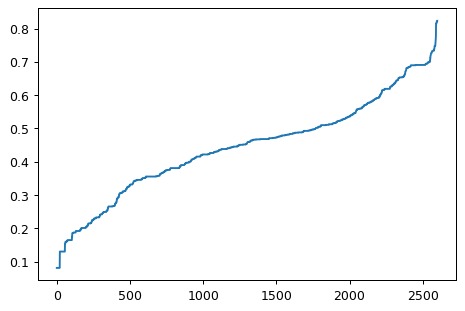

In [ ]:
fig = plt.figure(dpi=90)
plt.plot(accuracy_hist2)

In [ ]:
accuracy_hist2[-10:]

array([0.77909091, 0.81454545, 0.81454545, 0.81454545, 0.81909091,
       0.81909091, 0.81909091, 0.82363636, 0.82363636, 0.82363636])

In [ ]:
features_history2[-10:]

array([['len', 'Client_BCAST', 'in_scope_AP'],
       ['subtype', 'reason', 'TXFlags_TX_FAIL'],
       ['reason', 'TXFlags_NOACK', 'TXFlags_TX_FAIL'],
       ['reason', 'TXFlags_NOSEQ', 'TXFlags_TX_FAIL'],
       ['subtype', 'reason', 'TXFlags_NOSEQ'],
       ['reason', 'TXFlags_NOACK', 'TXFlags_NOSEQ'],
       ['subtype', 'reason', 'TXFlags_NOACK'],
       ['Rate', 'reason', 'TXFlags_NOSEQ'],
       ['Rate', 'reason', 'TXFlags_NOACK'],
       ['Rate', 'subtype', 'reason']], dtype='<U21')

In [12]:
#train__, validate__, test__ = np.split(test.sample(frac=1), [int(.8*len(test)), int(.9*len(test))])
train__, test__ = np.split(test_.sample(frac=1), [int(.82*len(test_))])
X_train = train__.values[:,:25]
Y_train = train__.values[:,25]
X_test = test__.values[:,:25]
Y_test = test__.values[:,25]

In [13]:
X_train.shape

(902, 25)

In [14]:
X_test.shape

(198, 25)

>svm1 1.000 (0.000)
>svm2 0.969 (0.015)
>svm3 0.953 (0.024)
>svm4 0.919 (0.029)
>svm5 0.910 (0.029)
>soft_voting 0.969 (0.015)


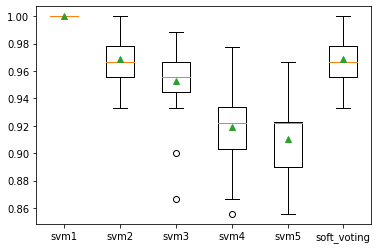

In [16]:
# compare soft voting ensemble to standalone classifiers
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot

# define dataset
X = X_train.copy()
y = Y_train.copy()

# get a voting ensemble of models
def get_voting():
	# define the base models
	models = list()
	models.append(('svm1', SVC(probability=True, kernel='poly', degree=1)))
	models.append(('svm2', SVC(probability=True, kernel='poly', degree=2)))
	models.append(('svm3', SVC(probability=True, kernel='poly', degree=3)))
	models.append(('svm4', SVC(probability=True, kernel='poly', degree=4)))
	models.append(('svm5', SVC(probability=True, kernel='poly', degree=5)))
	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='soft')
	return ensemble

# get a list of models to evaluate
def get_models():
	models = dict()
	models['svm1'] = SVC(probability=True, kernel='poly', degree=1)
	models['svm2'] = SVC(probability=True, kernel='poly', degree=2)
	models['svm3'] = SVC(probability=True, kernel='poly', degree=3)
	models['svm4'] = SVC(probability=True, kernel='poly', degree=4)
	models['svm5'] = SVC(probability=True, kernel='poly', degree=5)
	models['soft_voting'] = get_voting()
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [52]:
# make a prediction with a soft voting ensemble
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# define dataset
X = X_train.copy()
y = Y_train.copy()
x_test = X_test.copy()
y_test = Y_test.copy()

# define the base models
models = list()
models.append(('svm1', SVC(probability=True, kernel='poly', degree=1)))
models.append(('svm2', SVC(probability=True, kernel='poly', degree=2)))
models.append(('svm3', SVC(probability=True, kernel='poly', degree=3)))
models.append(('svm4', SVC(probability=True, kernel='poly', degree=4)))
models.append(('svm5', SVC(probability=True, kernel='poly', degree=5)))

# define the soft voting ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')

# fit the model on all available data
ensemble.fit(X, y)

# make predictions
yhat = ensemble.predict(x_test)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy * 100))

Accuracy: 95.960


In [62]:
list1 = ['Rate', 'len', 'subtype', 'ID', 'SC', 'ChannelFrequency',
        'reason', 'same_time', 'same_AP_addr', 'same_client_addr',
        'Client_BCAST', 'in_scope_AP', 'TXFlags_NOACK', 'TXFlags_NOSEQ',
        'TXFlags_TX_FAIL', 'FCfield_RETRY', 'FCS', 'ChannelFlags_2GHZ',
        'entropy_of_notdecoded', 'TSFT', 'CHANNEL', 'RXFLAGS',
        'RADIOTAPNS', 'EXT']
list2 = ['Rate', 'len', 'subtype', 'ID', 'SC', 'ChannelFrequency',
        'dBm_AntSignal', 'reason', 'same_AP_addr', 'same_client_addr',
        'Client_BCAST', 'in_scope_AP', 'TXFlags_NOACK', 'TXFlags_NOSEQ',
        'TXFlags_TX_FAIL', 'FCfield_RETRY', 'FCS', 'ChannelFlags_2GHZ',
        'entropy_of_notdecoded', 'TSFT', 'CHANNEL', 'RXFLAGS',
        'RADIOTAPNS', 'EXT']
list3 = ['Rate', 'len', 'subtype', 'ID', 'SC', 'ChannelFrequency',
        'dBm_AntSignal', 'reason', 'same_time', 'same_BSSID',
        'Client_BCAST', 'in_scope_AP', 'TXFlags_NOACK', 'TXFlags_NOSEQ',
        'TXFlags_TX_FAIL', 'FCfield_RETRY', 'FCS', 'ChannelFlags_2GHZ',
        'entropy_of_notdecoded', 'TSFT', 'CHANNEL', 'RXFLAGS',
        'RADIOTAPNS', 'EXT']


list_difference = [item for item in list1 if item not in list2]
print(list_difference)
list_difference = [item for item in list3 if item not in list2]
print(list_difference)
list_difference = [item for item in list1 if item not in list3]
print(list_difference)

['same_time']
['same_time', 'same_BSSID']
['same_AP_addr', 'same_client_addr']


In [110]:
# make a prediction with a soft voting ensemble
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# define dataset
X = X_train.copy()
y = Y_train.copy()
x_test = X_test.copy()
y_test = Y_test.copy()

# define selected features sets
features_subsets = [['subtype', 'reason'], ['Rate', 'reason'], 
                    ['same_time', 'same_BSSID', 'same_AP_addr', 'same_client_addr'],
                    ['Rate', 'reason', 'TXFlags_NOSEQ'],
                    ['Rate', 'reason', 'TXFlags_NOACK']]
                    #['Rate', 'reason', 'subtype']

# get ensemble of models
def get_ensemble():
  # define the base models
  models = list()
  for i in range(1, 26):
    # create the feature selection transform
    fs = SelectKBest(score_func=mutual_info_classif, k=i)
    #print(fs)
    # create the model
    #model = XGBClassifier()
    model = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    # create the pipeline
    pipe = Pipeline([('fs',fs), ('m', model)])
    # add as a tuple to the list of models for voting
    models.append((str(i),pipe))
  # define the voting ensemble
  #ensemble = VotingClassifier(estimators=models, voting='hard')
  # define the soft voting ensemble
  ensemble = VotingClassifier(estimators=models, voting='soft')
  return ensemble

# fit the model on all available data
ensemble = get_ensemble()
ensemble.fit(X, y)

# make predictions
yhat = ensemble.predict(x_test)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy * 100))

Accuracy: 100.000


In [111]:
# make a prediction with a soft voting ensemble
from sklearn.datasets import make_classification
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np

features = cols
#print(features)

class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        col_list = []
        #print(self.cols)
        for c in self.cols:
            col_list.append(X[:, c:c+1])
        return np.concatenate(col_list, axis=1)

    def fit(self, X, y=None):
        return self

# define dataset
X = X_train.copy()
y = Y_train.copy()
x_test = X_test.copy()
y_test = Y_test.copy()

# define selected features sets
features_subsets = [[2, 7], [0, 7], 
                    [8, 9, 10, 11],
                    [0, 7, 15],
                    [0, 7, 14]]

#print(features[0], features[2], features[7], features[8], features[9], features[10], features[11], features[14], features[15])

# get ensemble of models
def get_ensemble():
  # define the base models
  models = list()
  for i in range(len(features_subsets)):
    # create the model
    #model = XGBClassifier()
    model = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    # create the pipeline
    pipe = Pipeline([('dim_red', ColumnExtractor(cols=features_subsets[i])), ('m', model)])
    # add as a tuple to the list of models for voting
    models.append((str(i),pipe))
  # define the voting ensemble
  #ensemble = VotingClassifier(estimators=models, voting='hard')
  # define the soft voting ensemble
  ensemble = VotingClassifier(estimators=models, voting='soft')
  return ensemble

# fit the model on all available data
ensemble = get_ensemble()
ensemble.fit(X, y)

# make predictions
yhat = ensemble.predict(x_test)

# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % (accuracy * 100))

Accuracy: 97.980


In [112]:
# make a prediction for one example
for i in range(len(x_test)):
  yhat = ensemble.predict(x_test[i].reshape(1, -1) )
  if y_test[i] != yhat:
    print('Class is %d, but predicted %d'  % (y_test[i], yhat))

Class is 0, but predicted 1
Class is 0, but predicted 1
Class is 0, but predicted 1
Class is 0, but predicted 1


## Save Model

In [114]:
from sklearn.externals import joblib

# save the model to disk
filename = 'finalized_model'
joblib.dump(ensemble, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, Y_test)
print(result)

0.9797979797979798


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
